# Data profiling

In [2]:
import pandas as pd
import numpy as np
from support_functions import log_progress, clean_drugbank, query_chembl
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import functools
from cmapPy.pandasGEXpress import parse
import scipy
%load_ext line_profiler
import time

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## 0. Lookup known targets

In [77]:
# load perturbation info
pert_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_pert_info.txt', sep='\t', header=0)
pert_info_2a = pd.read_csv('data/GSE70138_Broad_LINCS_pert_info.txt', sep='\t', header=0)
all_pert_info = pd.concat([pert_info_1, pert_info_2a], ignore_index=True)

In [78]:
# lookup cpd inchi keys
all_cpd_pert_info = all_pert_info[all_pert_info.pert_type == 'trt_cp']
all_cpd_inchis = all_cpd_pert_info[['pert_id','inchi_key']].set_index('pert_id').copy()
# remove duplicates, store as series
all_cpd_inchis = all_cpd_inchis[~all_cpd_inchis.index.duplicated()].inchi_key

### 0a. Lookup Drugbank targets

In [5]:
# lookup and store drugbank targets as dictionary: { inchi: [targets]}
db_db_path = 'data/full_drugbank_database.xml'
drugbank_target_dict = clean_drugbank(db_db_path)

KeyboardInterrupt: 

In [ ]:
# save to file
filename = 'checkpoint_files/drugbank_target_dict.sav'
pickle.dump(drugbank_target_dict, open(filename, 'wb'))

### 0b. Lookup Chembl targets

In [ ]:
# lookup and store chembl targets as dictionary: { inchi: [targets]}
chembl_target_dict = {}
tested_inchis = [] # b/c this bitch keeps crashing

In [ ]:
# query CHEMBL API using cpd inchi_keys to find human targets
for inchi in log_progress(all_cpd_inchis.values, every=2):
    if inchi not in tested_inchis:
        human_target_genes = query_chembl(inchi)
        if len(human_target_genes) > 0:
            chembl_target_dict[inchi] = human_target_genes
        tested_inchis.append(inchi)

In [ ]:
# save to file
filename = 'checkpoint_files/chembl_target_dict.sav'
pickle.dump(chembl_target_dict, open(filename, 'wb'))

### 0c. Combine targets

In [79]:
drugbank_target_dict = pickle.load(open('checkpoint_files/drugbank_target_dict.sav', 'rb'))
chembl_target_dict = pickle.load(open('checkpoint_files/chembl_target_dict.sav', 'rb'))

combined_target_dict = drugbank_target_dict.copy()
for cpd, chembl_targets in log_progress(chembl_target_dict.items()):
    try:
        drugbank_targets = drugbank_target_dict[cpd]
        combined_targets = list(set().union(chembl_targets,drugbank_targets))
        combined_target_dict[cpd] = combined_targets
    except KeyError:
        combined_target_dict[cpd] = chembl_targets

## 1. Identify cpd-KD pairs (pair set 1)

The first of several filtering steps, this set is composed of pairs of known cpd-target interactions where both the cpd and the target KD have been tested in at least one LINCS experiment.

In [80]:
all_kd_pert_info = all_pert_info[all_pert_info.pert_type == 'trt_sh']
kd_genes = all_kd_pert_info.pert_iname.unique()
len(kd_genes)

4371

In [83]:
cpd_1_, target_1_, label_1_ = [], [], []
for index, row in log_progress(all_cpd_pert_info.iterrows(), every=1000):
    inchi = row.inchi_key
    
    # if the cpd has targets
    if inchi in combined_target_dict.keys():
        pert_id = row.pert_id
        targets = combined_target_dict[inchi]
        
        # add targets as positive examples
        for target in targets:
            if target in kd_genes:
                cpd_1_.append(pert_id)
                target_1_.append(target)
                label_1_.append(1)
                
        # add non-targets as negative examples
        for gene in kd_genes:
            if gene not in targets:
                cpd_1_.append(pert_id)
                target_1_.append(gene)
                label_1_.append(0)
                
    # if the compound has no targets
    else:
        pert_id = row.pert_id
        for gene in kd_genes:
            cpd_1_.append(pert_id)
            target_1_.append(gene)
            label_1_.append(0)

In [84]:
pair_set_1_df = pd.DataFrame({'cpd': cpd_1_, 'target': target_1_, 'label': label_1_})
pair_set_1_df.to_csv('checkpoint_files/pair_set_1_df.csv')

In [85]:
pair_set_1_df = pd.DataFrame.from_csv('checkpoint_files/pair_set_1_df.csv')

print('Pair set 1 statistics\n')
print('No. True interactions:\t', pair_set_1_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_1_df[pair_set_1_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_1_df[pair_set_1_df.label == 1].target.unique()))
print('\nNo. False interactions:\t', pair_set_1_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_1_df[pair_set_1_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_1_df[pair_set_1_df.label == 0].target.unique()))

Pair set 1 statistics

No. True interactions:	 4220
No. True cpds:		 1076
No. True genes:		 624

No. False interactions:	 97071332
No. False cpds:		 21299
No. False genes:	 4371


## 2. Identify same-cell cpd-KD pairs (pair set 2)

The second of several filtering steps, here we filter out cpd-KD pairs that have not both been tested in at least one common cell line.

### 2a. Signature quality filter

This step of finding common cells for all 100 million potential cpd-kd pairs is very slow. To speed things up we'll apply the signature quality filter here, rather than later on in the pipeline. We'll also store the high-quality signatures in dictionaries so that we can look them up quickly.

In [8]:
# load the signature information
all_sig_info = pd.DataFrame.from_csv('checkpoint_files/all_sig_info.csv')
all_cpd_sig_info = all_sig_info[all_sig_info.pert_type == 'trt_cp'].copy()
all_kd_sig_info = all_sig_info[all_sig_info.pert_type == 'trt_sh'].copy()

/Users/Nico/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (4,6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [12]:
# data quality parameters 
pct_self_rank_cutoff = 0.05
distill_cc_cutoff = 0.2

# filter the data
good_cpd_sig_info = all_cpd_sig_info[(all_cpd_sig_info.distil_cc_q75 >= distill_cc_cutoff) &
                                     (all_cpd_sig_info.pct_self_rank_q25 <= pct_self_rank_cutoff)].copy()
good_kd_sig_info = all_kd_sig_info[(all_kd_sig_info.distil_cc_q75 >= distill_cc_cutoff) &
                                   (all_kd_sig_info.pct_self_rank_q25 <= pct_self_rank_cutoff)].copy()

In [13]:
# create a dictionary of the good signatures so we can 
# look them up quickly by cpd/kd
good_cpds = set(good_cpd_sig_info.pert_id.unique())
good_cpd_sig_info_dict = {}
for cpd in log_progress(good_cpds):
    good_cpd_sig_info_dict[cpd] = good_cpd_sig_info[good_cpd_sig_info.pert_id == cpd].copy()
    
good_kds = set(good_kd_sig_info.pert_iname.unique())
good_kd_sig_info_dict = {}
for kd in log_progress(good_kds):
    good_kd_sig_info_dict[kd] = good_kd_sig_info[good_kd_sig_info.pert_iname == kd].copy()

In [14]:
# select representative sigs for good cpds
repr_cpd_sig_info_dict = {}
for cpd, good_sig_df in log_progress(good_cpd_sig_info_dict.items()):
    repr_cpd_sigs_df = pd.DataFrame(columns=good_sig_df.columns)
    for cell_line in good_sig_df.cell_id.unique():
        candidate_sigs = good_sig_df[good_sig_df.cell_id == cell_line]
        repr_sig = candidate_sigs.loc[candidate_sigs['tas'].idxmax()].copy()
        repr_cpd_sigs_df = repr_cpd_sigs_df.append(repr_sig)
    repr_cpd_sig_info_dict[cpd] = repr_cpd_sigs_df

# select representative kd sigs for good kds
repr_kd_sig_info_dict = {}
for kd, good_sig_df in log_progress(good_kd_sig_info_dict.items()):
    repr_kd_sigs_df = pd.DataFrame(columns=good_sig_df.columns)
    for cell_line in good_sig_df.cell_id.unique():
        candidate_sigs = good_sig_df[good_sig_df.cell_id == cell_line]
        repr_sig = candidate_sigs.loc[candidate_sigs['tas'].idxmax()].copy()
        repr_kd_sigs_df = repr_kd_sigs_df.append(repr_sig)
    repr_kd_sig_info_dict[kd] = repr_kd_sigs_df

In [15]:
# save the data
pickle.dump(good_cpds, open('checkpoint_files/good_cpds.sav', 'wb'))
pickle.dump(good_kds, open('checkpoint_files/good_kds.sav', 'wb'))
pickle.dump(repr_cpd_sig_info_dict, open('checkpoint_files/repr_cpd_sig_info_dict.sav', 'wb'))
pickle.dump(repr_kd_sig_info_dict, open('checkpoint_files/repr_kd_sig_info_dict.sav', 'wb'))

In [112]:
# load the data
good_cpds = pickle.load(open('checkpoint_files/good_cpds.sav', 'rb'))
good_kds = pickle.load(open('checkpoint_files/good_kds.sav', 'rb'))
repr_cpd_sig_info_dict = pickle.load(open('checkpoint_files/repr_cpd_sig_info_dict.sav', 'rb'))
repr_kd_sig_info_dict = pickle.load(open('checkpoint_files/repr_kd_sig_info_dict.sav', 'rb'))

### 2b. Identify pairs w/ high quality sigs (both cpd and kd)

In [92]:
cpd_2_, target_2_, label_2_, common_cells_2_ = [], [], [], []

for index, row in log_progress(pair_set_1_df.iterrows(), every=5000):

    # bookmark to (hopfeully) save time
    curr_cpd = ''
    curr_cpd_sigs_df = ''
    curr_cpd_cells = ''
    
    # extract signatures
    cpd = row.cpd
    if cpd in good_cpds:
        target = row.target
        if target in good_kds: 
            
            # check if we need to load data for new cpd
            if not cpd == curr_cpd:
                curr_cpd = cpd
                curr_cpd_sigs_df = repr_cpd_sig_info_dict[curr_cpd]
                curr_cpd_cells = set(curr_cpd_sigs_df.cell_id.unique())
            
            # load data for target
            kd_sigs = repr_kd_sig_info_dict[target]
            kd_cells = set(kd_sigs.cell_id.unique())
            
            # compare cell lines
            common_cells = curr_cpd_cells & kd_cells
            if len(common_cells) > 0:
                cpd_2_.append(cpd)
                target_2_.append(target)
                label_2_.append(row.label)
                common_cells_2_.append(common_cells)

In [93]:
pair_set_2_df = pd.DataFrame({'cpd': cpd_2_, 'target': target_2_, 'label': label_2_})
pair_set_2_df.to_csv('checkpoint_files/pair_set_2_df.csv')
pickle.dump(common_cells_2_, open('checkpoint_files/common_cells_2_.sav', 'wb'))

In [4]:
pair_set_2_df = pd.DataFrame.from_csv('checkpoint_files/pair_set_2_df.csv')
common_cells_2_ = pickle.load(open('checkpoint_files/common_cells_2_.sav', 'rb'))

In [5]:
print('Pair set 2 statistics\n')
print('No. True interactions:\t', pair_set_2_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_2_df[pair_set_2_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_2_df[pair_set_2_df.label == 1].target.unique()))
print('\nNo. False interactions:\t', pair_set_2_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_2_df[pair_set_2_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_2_df[pair_set_2_df.label == 0].target.unique()))

Pair set 2 statistics

No. True interactions:	 2827
No. True cpds:		 636
No. True genes:		 469

No. False interactions:	 18171209
No. False cpds:		 4240
No. False genes:	 4344


## 3. Identify cpd-KD pairs with interaction partner KDs (pair set 3)

The third of several filtering steps, here we filter out cpd-KD pairs for which we do not know any interaction partners for the target.

In [6]:
# load STRING 4.0 database
# 355319.0 high confidence interactions for 14893 genes
string_gene_interactions_700 = pd.DataFrame.from_csv('checkpoint_files/string_gene_interactions_700.csv')
string_genes = set(string_gene_interactions_700.gene_1.unique())

In [10]:
# convert string interactions to dictionary of sets for fast lookup
string_interactions_dict = {}
for gene in log_progress(string_genes, every=10):
    partners = string_gene_interactions_700[string_gene_interactions_700.gene_1 == gene].gene_2
    partner_set = set(partners)
    string_interactions_dict[gene] = partner_set

In [11]:
# save the interactions
pickle.dump(string_interactions_dict, open('checkpoint_files/string_interactions_dict.sav', 'wb'))

In [4]:
# load the interactions
string_interactions_dict = pickle.load(open('checkpoint_files/string_interactions_dict.sav', 'rb'))

In [14]:
cpd_3_, target_3_, label_3_, common_cells_3_ = [], [], [], []
targets_without_partner_kds = []

for index, row in log_progress(pair_set_2_df.iterrows(), every=5000):
    target = row.target
    # check if there are interaction partners
    if target in string_genes:
        partners = string_interactions_dict[target]
        # check if partners have KDS
        partner_kds = partners.intersection(good_kds)   
        if len(partner_kds) > 0:
            cpd_3_.append(row.cpd)
            target_3_.append(target)
            label_3_.append(row.label)
            common_cells_3_.append(common_cells_2_[index])
        else:
            targets_without_partner_kds.append(target)

In [15]:
pair_set_3_df = pd.DataFrame({'cpd': cpd_3_, 'target': target_3_, 'label': label_3_})
pair_set_3_df.to_csv('checkpoint_files/pair_set_3_df.csv')
pickle.dump(common_cells_3_, open('checkpoint_files/common_cells_3_.sav', 'wb'))

In [129]:
pair_set_3_df = pd.DataFrame.from_csv('checkpoint_files/pair_set_3_df.csv')
common_cells_3_ = pickle.load(open('checkpoint_files/common_cells_3_.sav', 'rb'))

In [16]:
print('Pair set 3 statistics\n')
print('No. True interactions:\t', pair_set_3_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_3_df[pair_set_3_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_3_df[pair_set_3_df.label == 1].target.unique()))
print('\nNo. False interactions:\t', pair_set_3_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_3_df[pair_set_3_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_3_df[pair_set_3_df.label == 0].target.unique()))

Pair set 3 statistics

No. True interactions:	 2789
No. True cpds:		 634
No. True genes:		 455

No. False interactions:	 15528727
No. False cpds:		 4240
No. False genes:	 3668


# 4. Discard pairs not tested in at least 3 different cell lines. (pair set 4)

In [14]:
min_num_cells = 3

In [17]:
cpd_4_, target_4_, label_4_, common_cells_4_ = [], [], [], [],

for index, row in log_progress(pair_set_3_df.iterrows(), every=5000):
    common_cells = common_cells_3_[index]
    if len(common_cells) >= min_num_cells:
        cpd_4_.append(row.cpd)
        target_4_.append(row.target)
        label_4_.append(row.label)
        common_cells_4_.append(common_cells)

In [18]:
pair_set_4_df = pd.DataFrame({'cpd': cpd_4_, 'target': target_4_, 'label': label_4_})

In [19]:
pair_set_4_df.to_csv('checkpoint_files/pair_set_4_df.csv')
pickle.dump(common_cells_4_, open('checkpoint_files/common_cells_4_.sav', 'wb'))

In [4]:
pair_set_4_df = pd.DataFrame.from_csv('checkpoint_files/pair_set_4_df.csv')
common_cells_4_ = pickle.load(open('checkpoint_files/common_cells_4_.sav', 'rb'))

In [20]:
print('Pair set 4 statistics\n')
print('No. True interactions:\t', pair_set_4_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_4_df[pair_set_4_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_4_df[pair_set_4_df.label == 1].target.unique()))
print('\nNo. False interactions:\t', pair_set_4_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_4_df[pair_set_4_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_4_df[pair_set_4_df.label == 0].target.unique()))

Pair set 4 statistics

No. True interactions:	 1310
No. True cpds:		 232
No. True genes:		 303

No. False interactions:	 4498567
No. False cpds:		 1228
No. False genes:	 3320


## 5. Identify cpd-KD pairs with same-cell interaction partner KDs (pair set 5)

The fourth of several filtering steps, here we filter out cpd-KD pairs for which the target's interaction partners were not knocked down in any of the same cells as the cpd-target pair.

Because this step takes SO long we're going to break up our dataframe into chunks and then run run the filter in parallel.

In [11]:
import multiprocessing
num_processes = 6 #multiprocessing.cpu_count()

In [12]:
def filter_pairs(input_stuff):
    pair_df, common_cells_ = input_stuff
    cpd_5_, target_5_, label_5_, common_cells_5_, common_partners_5_ = [], [], [], [], []
    
    for index, row in pair_df.iterrows(): 
        
        if index % 10000 == 0: print(index)
        
        common_cells = common_cells_[index]
        target = row.target
        common_partners_dict = {}

        # find interaction partner signatures
        partners = string_interactions_dict[target]
        partner_kds = partners.intersection(good_kds)
        partner_sigs = pd.concat([ repr_kd_sig_info_dict[p] for p in partner_kds ], ignore_index=True)
        # group partner sigs by cell line
        for cell_line in common_cells:
            partner_cell_sigs = partner_sigs[partner_sigs.cell_id == cell_line]
            
            if not partner_cell_sigs.empty:
                cell_partners = set(partner_cell_sigs.pert_iname.unique())
                common_partners_dict[cell_line] = cell_partners

        # make sure we have partner KDs in at least three cell lines,
        # since we're only considering pairs with this minimum amount of data
        if len(common_partners_dict.keys()) >= min_num_cells:
            common_cells_5 = set(common_partners_dict.keys())
            cpd_5_.append(row.cpd)
            target_5_.append(target)
            label_5_.append(row.label)
            common_cells_5_.append(common_cells_5)
            common_partners_5_.append(common_partners_dict)
            
    return cpd_5_, target_5_, label_5_, common_cells_5_, common_partners_5_

In [13]:
# break the pairs up into batches
num_batches = 10
batch_size = 450000 # len(pair_set_4_df) / num_batches = 449987.7
pdf4_batches = [ pair_set_4_df.iloc[pair_set_4_df.index[i:i + batch_size]].reset_index(drop=True)for i in range(0,num_batches*batch_size,batch_size) ]
common_cell_batches = [ common_cells_4_[i:i + batch_size] for i in range(0,num_batches*batch_size,batch_size) ]

In [14]:
# run the filter on each batch of the data
for j in range(10):
    
    print('STARTING BATCH: ', j)
    # reset memory
    cpd_5_, target_5_, label_5_, common_cells_5_, common_partners_5_, pair_set_5_df = [None]*6
    result = None
    cpd_5_t, target_5_t, label_5_t, common_cells_5_t, common_partners_5_t = [None]*5

    # get data
    pdf4_batch = pdf4_batches[j]
    cc_batch = common_cell_batches[j]

    # calculate the chunk size as an integer
    chunk_size = int(pdf4_batch.shape[0]/num_processes)

    # break the dataframe up into chunks
    pair_chunks = [ pdf4_batch.iloc[pdf4_batch.index[i:i + chunk_size]].reset_index(drop=True) for i in range(0, pdf4_batch.shape[0], chunk_size)]
    cell_chunks = [ cc_batch[i:i + chunk_size] for i in range(0, len(cc_batch), chunk_size) ]
    chunks = list(zip(pair_chunks, cell_chunks))

    # filter each section of the pairs dataframe in parallel
    cpd_5_, target_5_, label_5_, common_cells_5_, common_partners_5_ = [], [], [], [], []
    pool = multiprocessing.Pool(processes=num_processes)
    result = pool.map(filter_pairs, chunks)
    pool.close()

    cpd_5_t, target_5_t, label_5_t, common_cells_5_t, common_partners_5_t = zip(*result)
    cpd_5_ = functools.reduce( lambda x,y: x+y, [ c for c in list(cpd_5_t) ] )
    target_5_ = functools.reduce( lambda x,y: x+y, [ t for t in list(target_5_t) ] )
    label_5_ = functools.reduce( lambda x,y: x+y, [ l for l in list(label_5_t) ] )
    common_cells_5_ = functools.reduce( lambda x,y: x+y, [ cc for cc in list(common_cells_5_t) ] )
    common_partners_5_ = functools.reduce( lambda x,y: x+y, [ cc for cc in list(common_partners_5_t) ] )

    print('\nMAKING DATAFRAME')
    pair_set_5_df = pd.DataFrame({'cpd': cpd_5_, 'target': target_5_, 'label': label_5_})

    print('\nSAVING DATAFRAME')
    df_filename = 'checkpoint_files/pair_set_5_df_{}.csv'.format(j)
    pair_set_5_df.to_csv(df_filename)

    print('\nSAVING COMMON CELLS')
    cc_filename = 'checkpoint_files/common_cells_5_{}.sav'.format(j)
    cc_file = open(cc_filename, 'wb')
    pickle.dump(common_cells_5_, cc_file)
    cc_file.close()

    print('\nSAVING COMMON PARTNERS')
    cp_filename = 'checkpoint_files/common_partners_5_{}.sav'.format(j)
    cp_file = open(cp_filename, 'wb')
    pickle.dump(common_partners_5_, cp_file)
    cp_file.close()

    print('\nDONE')

STARTING BATCH:  0
0
0
0
0
0
0
10000
10000
10000
10000
10000
10000
20000
20000
20000
20000
20000
20000
30000
30000
30000
30000
30000
30000
40000
40000
40000
40000
40000
40000
50000
50000
50000
50000
50000
50000
60000
60000
60000
60000
60000
60000
70000
70000
70000
70000
70000
70000

MAKING DATAFRAME

SAVING DATAFRAME

SAVING COMMON CELLS

SAVING COMMON PARTNERS

DONE
STARTING BATCH:  1
0
0
0
0
0
0
10000
10000
10000
10000
10000
10000
20000
20000
20000
20000
20000
20000
30000
30000
30000
30000
30000
30000
40000
40000
40000
40000
40000
40000
50000
50000
50000
50000
50000
50000
60000
60000
60000
60000
60000
60000
70000
70000
70000
70000
70000
70000

MAKING DATAFRAME

SAVING DATAFRAME

SAVING COMMON CELLS

SAVING COMMON PARTNERS

DONE
STARTING BATCH:  2
0
0
0
0
0
0
10000
10000
10000
10000
10000
10000
20000
20000
20000
20000
20000
20000
30000
30000
30000
30000
30000
30000
40000
40000
40000
40000
40000
40000
50000
50000
50000
50000
50000
50000
60000
60000
60000
60000
60000
60000
70000
70000
7

In [15]:
# LOAD DATA AND put the pieces back together
pair_set_5_df = pd.DataFrame(columns=pair_set_4_df.columns)
common_cells_5_ = []
common_partners_5_ = []

for j in log_progress(range(10)):
    df_filename = 'checkpoint_files/pair_set_5_df_{}.csv'.format(j)
    cc_filename = 'checkpoint_files/common_cells_5_{}.sav'.format(j)
    cp_filename = 'checkpoint_files/common_partners_5_{}.sav'.format(j)
    
    pair_set_5_df = pair_set_5_df.append(pd.DataFrame.from_csv(df_filename))
    common_cells_5_ += pickle.load(open(cc_filename, 'rb'))
    #common_partners_5_ += pickle.load(open(cp_filename, 'rb'))

In [8]:
print('Pair set 5 statistics\n')
print('No. True interactions:\t', pair_set_5_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_5_df[pair_set_5_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_5_df[pair_set_5_df.label == 1].target.unique()))
print('\nNo. False interactions:\t', pair_set_5_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_5_df[pair_set_5_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_5_df[pair_set_5_df.label == 0].target.unique()))

Pair set 5 statistics

No. True interactions:	 1308
No. True cpds:		 232
No. True genes:		 302

No. False interactions:	 4429884
No. False cpds:		 1228
No. False genes:	 3288


## Cell count anaylsis
Which cell lines are are true interactions happening in?

In [16]:
true_pair_idx = pair_set_5_df[pair_set_5_df.label == 1].index.values.astype(int)
true_pair_common_cells = np.array(common_cells_5_)[true_pair_idx]

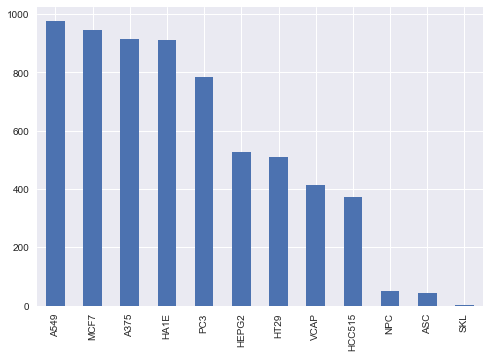

In [17]:
# which cell lines are most common?
all_cell_list = np.array(functools.reduce( lambda x,y: x+y, [ list(s) for s in true_pair_common_cells ] ))
cell_line_counts = pd.Series(all_cell_list).value_counts()
cell_line_counts.plot.bar()
plt.show()

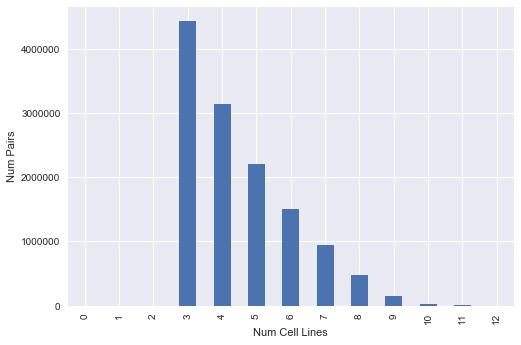

In [18]:
# how many pairs tested in at least n cell lines?
num_common_cells_5 = np.array([ len(cells) for cells in common_cells_5_])
pair_set_5_df['ncells'] = num_common_cells_5
ncell_counts = pair_set_5_df.ncells.value_counts()
cum_ncell_counts = [0,0,0]
for i in ncell_counts.index:
    cum_ncell_counts.append(sum(ncell_counts.loc[i:]))
cum_ncell_counts = pd.Series(cum_ncell_counts)
cum_ncell_counts.plot.bar()
plt.ylabel('Num Pairs')
plt.xlabel('Num Cell Lines')
plt.show()

## 6. Most common cell lines (pair set 6)
Three of the cell lines have very few drugs. We can ignore them and just focus on data from the 9 most common cell lines. 

**This also has to be done in batches**

In [19]:
top_9_cell_lines = set(cell_line_counts.index[:9])

In [18]:
# filter out pairs not in the top-9 cell lines
for j in range(10):
    print('BATCH {}'.format(j))
    cpd_6_, target_6_, label_6_, common_cells_6_, common_partners_6_ = [], [], [], [], []
    
    print('LOADING DATA')
    df_filename = 'checkpoint_files/pair_set_5_df_{}.csv'.format(j)
    cc_filename = 'checkpoint_files/common_cells_5_{}.sav'.format(j)
    cp_filename = 'checkpoint_files/common_partners_5_{}.sav'.format(j)
    
    p_5_df = pd.DataFrame.from_csv(df_filename)
    
    cc_5_file = open(cc_filename, 'rb')
    cc_5_ = pickle.load(cc_5_file)
    cc_5_file.close()
    
    cp_5_file = open(cp_filename, 'rb')
    cp_5_ = pickle.load(cp_5_file)
    cp_5_file.close()
    
    print('FILTERING DATA')
    for index, row in log_progress(p_5_df.iterrows(), every=5000):
        common_cells = cc_5_[index]
        top_common_cells = common_cells & top_9_cell_lines
        if len(top_common_cells) >= min_num_cells:
            cpd_6_.append(row.cpd)
            target_6_.append(row.target)
            label_6_.append(row.label)
            common_cells_6_.append(top_common_cells)

            common_partners = {}
            for c in top_common_cells:
                common_partners[c] = cp_5_[index][c]
            common_partners_6_.append(common_partners)
            
    print('MAKING DATAFRAME')
    pair_set_6_df = pd.DataFrame({'cpd': cpd_6_, 'target': target_6_, 'label': label_6_})

    print('SAVING DATAFRAME')
    df_filename = 'checkpoint_files/pair_set_6_df_{}.csv'.format(j)
    pair_set_6_df.to_csv(df_filename)

    print('SAVING COMMON CELLS')
    cc_filename = 'checkpoint_files/common_cells_6_{}.sav'.format(j)
    cc_file = open(cc_filename, 'wb')
    pickle.dump(common_cells_6_, cc_file)
    cc_file.close()

    print('SAVING COMMON PARTNERS')
    cp_filename = 'checkpoint_files/common_partners_6_{}.sav'.format(j)
    cp_file = open(cp_filename, 'wb')
    pickle.dump(common_partners_6_, cp_file)
    cp_file.close()

    print('RESETTING MEMORY')
    cpd_6_, target_6_, label_6_, common_cells_6_, common_partners_6_ = None, None, None, None, None
    p_5_df, cc_5_, cp_5_ = None, None, None
    
    
    print('DONE\n')

BATCH 0
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 1
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 2
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 3
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 4
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 5
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 6
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 7
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 8
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 9
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE



In [3]:
# LOAD DATA AND put the pieces back together
pair_set_6_df = pd.DataFrame(columns=['cpd', 'label', 'target'])
common_cells_6_ = []
common_partners_6_ = []

for j in log_progress(range(10)):
    df_filename = 'checkpoint_files/pair_set_6_df_{}.csv'.format(j)
    cc_filename = 'checkpoint_files/common_cells_6_{}.sav'.format(j)
    cp_filename = 'checkpoint_files/common_partners_6_{}.sav'.format(j)
    
    pair_set_6_df = pair_set_6_df.append(pd.DataFrame.from_csv(df_filename))
    #common_cells_6_ += pickle.load(open(cc_filename, 'rb'))
    #common_partners_5_ += pickle.load(open(cp_filename, 'rb'))

In [20]:
print('Pair set 6 statistics\n')
print('No. True interactions:\t', pair_set_6_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_6_df[pair_set_6_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_6_df[pair_set_6_df.label == 1].target.unique()))
print('\nNo. False interactions:\t', pair_set_6_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_6_df[pair_set_6_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_6_df[pair_set_6_df.label == 0].target.unique()))

Pair set 6 statistics

No. True interactions:	 1303
No. True cpds:		 229
No. True genes:		 302

No. False interactions:	 4394682
No. False cpds:		 1180
No. False genes:	 3245


___
# Extract gene expression signatures

### Compounds

In [165]:
# load filtered data
pair_set_6_df = pickle.load(open('checkpoint_files/pair_set_6_df.sav', 'rb'))
common_cells_6_ = pickle.load(open('checkpoint_files/common_cells_6_.sav', 'rb'))
#common_partners_6_ = pickle.load(open('checkpoint_files/common_partners_7_', 'rb'))

In [123]:
# reference lists
top_9_cell_line_cpds = pair_set_6_df.cpd.unique()
top_9_cell_line_kds = list(repr_kd_sig_info_dict.keys())

gene_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_gene_info.txt', sep='\t', header=0)
lm_genes = gene_info_1[gene_info_1['pr_is_lm'].astype(bool)]
lm_gene_ids = lm_genes['pr_gene_id'].astype(str).values

In [20]:
# select representatives
repr_top_9_cpd_sigs = pd.DataFrame(columns=all_cpd_sig_info.columns)
for pert_id in log_progress(top_9_cell_line_cpds):
    repr_cpd_sigs = repr_cpd_sig_info_dict[pert_id]
    repr_cpd_sigs = repr_cpd_sigs[repr_cpd_sigs.cell_id.isin(top_9_cell_lines)]
    repr_top_9_cpd_sigs = repr_top_9_cpd_sigs.append(repr_cpd_sigs)

In [21]:
# extract the actual signatures
phase_1_sig_ids = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', col_meta_only=True).index.values
phase_2_sig_ids = parse('data/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx', col_meta_only=True).index.values

# The GCTX files encode the sig IDS as strings of byte strings (why????) so we have to deal with that
top_9_cpd_sig_ids = [ str(s.encode('UTF8')) for s  in repr_top_9_cpd_sigs.sig_id.values ]
phase_1_top_9_cpd_sig_ids = [ s for s in top_9_cpd_sig_ids if s in phase_1_sig_ids ]
phase_2_top_9_cpd_sig_ids = [ s for s in top_9_cpd_sig_ids if s in phase_2_sig_ids ]

# extract the actual signatures
phase_1_top_9_cpd_sigs = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', cid=phase_1_top_9_cpd_sig_ids).data_df
phase_2_top_9_cpd_sigs = parse('data/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx', cid=phase_2_top_9_cpd_sig_ids).data_df
phase_2_top_9_cpd_sigs.rename(lambda x: x[2:-1], inplace=True)
top_9_cpd_raw_sigs = pd.concat([phase_1_top_9_cpd_sigs, phase_2_top_9_cpd_sigs], axis=1)

# discard all but landmark gene values
top_9_cpd_lm_sigs = top_9_cpd_raw_sigs[top_9_cpd_raw_sigs.index.isin(lm_gene_ids)].sort_index().copy()

# reformat the sig_ids so they are nice strings
top_9_cpd_lm_sigs = top_9_cpd_lm_sigs.T.rename(lambda x: x.lstrip('b\'').rstrip('\'')).T
top_9_cpd_lm_sigs.head()

KeyboardInterrupt: 

In [ ]:
print(repr_top_9_cpd_sigs.shape)
print(top_9_cpd_lm_sigs.shape)
repr_top_9_cpd_sigs.to_csv('checkpoint_files/repr_top_9_cpd_sigs.csv')
top_9_cpd_lm_sigs.to_csv('checkpoint_files/top_9_cpd_lm_sigs.csv')

### Knockdowns

In [124]:
# select representatives
repr_top_9_kd_sigs = pd.DataFrame(columns=all_kd_sig_info.columns)
for pert_iname in log_progress(top_9_cell_line_kds):
    repr_kd_sigs = repr_kd_sig_info_dict[pert_iname]
    repr_kd_sigs = repr_kd_sigs[repr_kd_sigs.cell_id.isin(top_9_cell_lines)]
    repr_top_9_kd_sigs = repr_top_9_kd_sigs.append(repr_kd_sigs)

In [127]:
# The GCTX files encode the sig IDS as strings of byte strings (why????) so we have to deal with that
top_9_kd_sig_ids = [ str(s.encode('UTF8')) for s in repr_top_9_kd_sigs.sig_id.values ]

# read in the data
top_9_kd_raw_sigs = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', cid=top_9_kd_sig_ids).data_df

# discard non-landmark gene expression scores
top_9_kd_lm_sigs = top_9_kd_raw_sigs[top_9_kd_raw_sigs.index.isin(lm_gene_ids)].sort_index().copy()

# reformat the sig_ids so they are nice strings
top_9_kd_lm_sigs = top_9_kd_lm_sigs.T.rename(lambda x: x.lstrip('b\'').rstrip('\'')).T
top_9_kd_lm_sigs.head()

cid    DER001_A375_96H:TRCN0000197159:-666  \
rid                                          
10007                            -1.582821   
1001                             -0.037421   
10013                             0.156317   
10038                             0.717362   
10046                            -0.171960   

cid    DER001_A375_96H:TRCN0000006029:-666  \
rid                                          
10007                             1.147524   
1001                              1.322280   
10013                             0.654752   
10038                             0.046802   
10046                             1.246416   

cid    DER001_A375_96H:TRCN0000338772:-666  \
rid                                          
10007                            -0.233997   
1001                              0.614880   
10013                             1.081601   
10038                             0.573958   
10046                             4.340301   

cid    DER001_A375_96H:TRCN0000218565:-666  \
rid                                          
10007                             0.705900   
1001                             -0.021201   
10013                             0.210859   
10038                            -1.193527   
10046                            -0.888133   

cid    DER001_A375_96H:TRCN0000369366:-666  \
rid                                          
10007                            -0.493815   
1001                              1.828483   
10013                             0.883683   
10038                            -0.049510   
10046                             0.597416   

cid    DER001_A375_96H:TRCN0000138966:-666  \
rid                                          
10007                            -0.215770   
1001                              1.179174   
10013                            -0.093974   
10038                             0.716104   
10046                             1.460984   

cid    DER001_A375_96H:TRCN0000262375:-666  \
rid                                          
10007                             0.451134   
1001                             -0.062841   
10013                             1.296774   
10038                             1.441153   
10046                            -1.016598   

cid    DER001_A375_96H:TRCN0000141905:-666  \
rid                                          
10007                            -0.327473   
1001                              0.722374   
10013                            -1.416878   
10038                            -0.215514   
10046                             0.117003   

cid    DER001_A375_96H:TRCN0000350521:-666  \
rid                                          
10007                            -0.766019   
1001                              0.865695   
10013                            -0.155374   
10038                             0.236909   
10046                             0.889986   

cid    DER001_A375_96H:TRCN0000051204:-666  \
rid                                          
10007                             2.288669   
1001                              0.364353   
10013                            -0.297705   
10038                            -1.513038   
10046                             0.808288   

cid                   ...                  KDB001_PC3_96H:TRCN0000343797:-666  \
rid                   ...                                                       
10007                 ...                                            -0.39430   
1001                  ...                                             0.75325   
10013                 ...                                            -0.43025   
10038                 ...                                            -0.14960   
10046                 ...                                            -0.15285   

cid    KDB001_PC3_96H:TRCN0000319318:-666  KDB001_PC3_96H:TRCN0000323290:-666  \
rid                                                                             
10007                             0.3925

In [128]:
print(repr_top_9_kd_sigs.shape)
print(top_9_kd_lm_sigs.shape)
repr_top_9_kd_sigs.to_csv('checkpoint_files/repr_top_9_kd_sigs.csv')
top_9_kd_lm_sigs.to_csv('checkpoint_files/top_9_kd_lm_sigs.csv')

(30323, 15)
(978, 30323)


___
## Feature construction

### Direct Correlation

In [24]:
# load data
repr_top_9_cpd_sigs = pd.DataFrame.from_csv('checkpoint_files/repr_top_9_cpd_sigs.csv')
top_9_cpd_lm_sigs = pd.DataFrame.from_csv('checkpoint_files/top_9_cpd_lm_sigs.csv')
print(repr_top_9_cpd_sigs.shape)
print(top_9_cpd_lm_sigs.shape)

(6098, 15)
(978, 6098)


In [111]:
# load data
repr_top_9_kd_sigs = pd.DataFrame.from_csv('checkpoint_files/repr_top_9_kd_sigs.csv')
top_9_kd_lm_sigs = pd.DataFrame.from_csv('checkpoint_files/top_9_kd_lm_sigs.csv')
print(repr_top_9_kd_sigs.shape)
print(top_9_kd_lm_sigs.shape)

(25386, 15)
(978, 25386)


In [28]:
# reset memory
pair_set_4_df = None
pair_set_5_df = None
common_cells_4_ = None
common_cells_5_ = None

We'll try to run this in parallel since it is SUPER slow.

In [44]:
len(pair_set_6_df)

4395985

In [34]:
import multiprocessing
num_processes = 4 #multiprocessing.cpu_count()

In [ ]:
def compute_dir_corr(pair_subset):
    
    # initialize empty dataframe to hold direct correlation values
    dir_corr_df = pd.DataFrame(index=pair_subset.index, columns=top_9_cell_lines)

    # loop through cpd-target pairs, calculate correlations in each cell line
    for index, row in log_progress(pair_subset.iterrows(), every=1):
        if index % 1000 == 0: print('INDEX: {}'.format(index))
        
        cpd = row.cpd
        cpd_sig_info = repr_cpd_sig_info_dict[cpd]
        kd = row.target
        kd_sig_info = repr_kd_sig_info_dict[kd]
        
        for cell_line in top_9_cell_lines:
            cpd_cell_sig_info = cpd_sig_info[cpd_sig_info.cell_id == cell_line]
            kd_cell_sig_info = kd_sig_info[kd_sig_info.cell_id == cell_line]

            # remember we have missing data, not all pairs are tested in all cell lines
            if not (cpd_cell_sig_info.empty or kd_cell_sig_info.empty):
                # extract signatures
                cpd_sig_id = cpd_cell_sig_info.sig_id
                kd_sig_id = kd_cell_sig_info.sig_id
                cpd_lm_sig = top_9_cpd_lm_sigs[cpd_sig_id].values
                kd_lm_sig = top_9_kd_lm_sigs[kd_sig_id].values
                #compute and store correlation
                corr = scipy.stats.pearsonr(cpd_lm_sig, kd_lm_sig)[0][0]
                dir_corr_df.at[index, cell_line] = corr
    
    return dir_corr_df

In [37]:
# break the pairs up into batches
num_batches = 10
batch_size = 450000 # len(pair_set_6_df) / num_batches = 439598.5
pdf6_batches = [ pair_set_6_df.iloc[pair_set_6_df.index[i:i + batch_size]].reset_index(drop=True)for i in range(0,num_batches*batch_size,batch_size) ]

In [38]:
# run the filter on each batch of the data
for j in range(10):
    
    print('STARTING BATCH: ', j)
    # reset memory
    result = None
    dir_corr_sub_df = None
    
    # get data
    pdf6_batch = pdf6_batches[j]

    # calculate the chunk size as an integer
    chunk_size = int(pdf6_batch.shape[0]/num_processes)

    # break the dataframe up into chunks
    pair_chunks = [ pdf6_batch.iloc[pdf6_batch.index[i:i + chunk_size]].reset_index(drop=True) for i in range(0, pdf6_batch.shape[0], chunk_size)]

    # filter each section of the pairs dataframe in parallel
    pool = multiprocessing.Pool(processes=num_processes)
    result = pool.map(compute_dir_corr, pair_chunks)
    pool.close()
    
    dir_corr_sub_df = functools.reduce(lambda x,y: pd.concat([x,y]), result)
    filename = 'features/top_9_dir_corr_sub_df_{}.csv'.format(j)
    dir_corr_sub_df.to_csv(filename)

STARTING BATCH:  0
INDEX: 0
INDEX: 0
INDEX: 0
INDEX: 0
INDEX: 1000
INDEX: 1000
INDEX: 1000
INDEX: 1000
INDEX: 2000
INDEX: 2000
INDEX: 2000
INDEX: 2000
INDEX: 3000
INDEX: 3000
INDEX: 3000
INDEX: 3000
INDEX: 4000
INDEX: 4000
INDEX: 5000
INDEX: 4000
INDEX: 4000
INDEX: 5000
INDEX: 6000
INDEX: 5000
INDEX: 5000
INDEX: 6000
INDEX: 7000
INDEX: 6000
INDEX: 7000
INDEX: 6000
INDEX: 8000
INDEX: 7000
INDEX: 8000
INDEX: 9000
INDEX: 7000
INDEX: 8000
INDEX: 9000
INDEX: 10000
INDEX: 8000
INDEX: 9000
INDEX: 10000
INDEX: 9000
INDEX: 10000
INDEX: 11000
INDEX: 11000
INDEX: 11000
INDEX: 10000
INDEX: 12000
INDEX: 12000
INDEX: 13000
INDEX: 12000
INDEX: 11000
INDEX: 13000
INDEX: 14000
INDEX: 13000
INDEX: 12000
INDEX: 14000
INDEX: 15000
INDEX: 16000
INDEX: 14000
INDEX: 15000
INDEX: 13000
INDEX: 17000
INDEX: 15000
INDEX: 14000
INDEX: 16000
INDEX: 18000
INDEX: 16000
INDEX: 17000
INDEX: 15000
INDEX: 19000
INDEX: 18000
INDEX: 17000
INDEX: 16000
INDEX: 20000
INDEX: 19000
INDEX: 17000
INDEX: 18000
INDEX: 21000
INDEX:

INDEX: 44000
INDEX: 46000
INDEX: 46000
INDEX: 44000
INDEX: 45000
INDEX: 47000
INDEX: 47000
INDEX: 45000
INDEX: 46000
INDEX: 48000
INDEX: 48000
INDEX: 46000
INDEX: 47000
INDEX: 49000
INDEX: 49000
INDEX: 48000
INDEX: 50000
INDEX: 47000
INDEX: 50000
INDEX: 51000
INDEX: 49000
INDEX: 51000
INDEX: 48000
INDEX: 52000
INDEX: 52000
INDEX: 50000
INDEX: 49000
INDEX: 53000
INDEX: 53000
INDEX: 51000
INDEX: 50000
INDEX: 54000
INDEX: 52000
INDEX: 54000
INDEX: 51000
INDEX: 55000
INDEX: 53000
INDEX: 55000
INDEX: 52000
INDEX: 56000
INDEX: 54000
INDEX: 53000
INDEX: 56000
INDEX: 57000
INDEX: 54000
INDEX: 55000
INDEX: 57000
INDEX: 58000
INDEX: 55000
INDEX: 56000
INDEX: 59000
INDEX: 58000
INDEX: 56000
INDEX: 57000
INDEX: 60000
INDEX: 59000
INDEX: 57000
INDEX: 58000
INDEX: 61000
INDEX: 60000
INDEX: 58000
INDEX: 59000
INDEX: 62000
INDEX: 61000
INDEX: 60000
INDEX: 59000
INDEX: 63000
INDEX: 62000
INDEX: 61000
INDEX: 64000
INDEX: 60000
INDEX: 63000
INDEX: 62000
INDEX: 65000
INDEX: 61000
INDEX: 64000
INDEX: 63000

INDEX: 88000
INDEX: 90000
INDEX: 90000
INDEX: 89000
INDEX: 89000
INDEX: 91000
INDEX: 91000
INDEX: 90000
INDEX: 90000
INDEX: 92000
INDEX: 91000
INDEX: 92000
INDEX: 91000
INDEX: 93000
INDEX: 92000
INDEX: 93000
INDEX: 92000
INDEX: 94000
INDEX: 93000
INDEX: 93000
INDEX: 94000
INDEX: 95000
INDEX: 94000
INDEX: 94000
INDEX: 95000
INDEX: 96000
INDEX: 95000
INDEX: 95000
INDEX: 96000
INDEX: 97000
INDEX: 96000
INDEX: 96000
INDEX: 97000
INDEX: 98000
INDEX: 97000
INDEX: 99000
INDEX: 97000
INDEX: 98000
INDEX: 98000
INDEX: 100000
INDEX: 99000
INDEX: 98000
INDEX: 99000
INDEX: 101000
INDEX: 100000
INDEX: 99000
INDEX: 102000
INDEX: 100000
INDEX: 101000
INDEX: 100000
INDEX: 103000
INDEX: 101000
INDEX: 101000
INDEX: 102000
INDEX: 104000
INDEX: 102000
INDEX: 103000
INDEX: 102000
INDEX: 105000
INDEX: 103000
INDEX: 103000
INDEX: 106000
INDEX: 104000
INDEX: 107000
INDEX: 104000
INDEX: 105000
INDEX: 104000
INDEX: 108000
INDEX: 105000
INDEX: 106000
INDEX: 105000
INDEX: 109000
INDEX: 107000
INDEX: 106000
INDEX: 

INDEX: 21000
INDEX: 21000
INDEX: 20000
INDEX: 19000
INDEX: 22000
INDEX: 22000
INDEX: 21000
INDEX: 20000
INDEX: 23000
INDEX: 23000
INDEX: 22000
INDEX: 21000
INDEX: 24000
INDEX: 24000
INDEX: 23000
INDEX: 22000
INDEX: 25000
INDEX: 25000
INDEX: 24000
INDEX: 23000
INDEX: 26000
INDEX: 26000
INDEX: 24000
INDEX: 25000
INDEX: 27000
INDEX: 25000
INDEX: 27000
INDEX: 26000
INDEX: 28000
INDEX: 26000
INDEX: 28000
INDEX: 29000
INDEX: 27000
INDEX: 27000
INDEX: 30000
INDEX: 28000
INDEX: 29000
INDEX: 28000
INDEX: 31000
INDEX: 29000
INDEX: 30000
INDEX: 29000
INDEX: 32000
INDEX: 30000
INDEX: 31000
INDEX: 33000
INDEX: 30000
INDEX: 31000
INDEX: 32000
INDEX: 34000
INDEX: 31000
INDEX: 32000
INDEX: 33000
INDEX: 35000
INDEX: 33000
INDEX: 34000
INDEX: 32000
INDEX: 36000
INDEX: 34000
INDEX: 33000
INDEX: 35000
INDEX: 37000
INDEX: 35000
INDEX: 34000
INDEX: 36000
INDEX: 36000
INDEX: 38000
INDEX: 35000
INDEX: 37000
INDEX: 37000
INDEX: 36000
INDEX: 39000
INDEX: 38000
INDEX: 38000
INDEX: 37000
INDEX: 39000
INDEX: 40000

INDEX: 65000
INDEX: 65000
INDEX: 66000
INDEX: 65000
INDEX: 63000
INDEX: 67000
INDEX: 64000
INDEX: 66000
INDEX: 66000
INDEX: 68000
INDEX: 65000
INDEX: 67000
INDEX: 67000
INDEX: 69000
INDEX: 66000
INDEX: 68000
INDEX: 70000
INDEX: 68000
INDEX: 67000
INDEX: 69000
INDEX: 71000
INDEX: 68000
INDEX: 69000
INDEX: 70000
INDEX: 72000
INDEX: 69000
INDEX: 70000
INDEX: 73000
INDEX: 71000
INDEX: 70000
INDEX: 74000
INDEX: 71000
INDEX: 72000
INDEX: 71000
INDEX: 75000
INDEX: 73000
INDEX: 72000
INDEX: 72000
INDEX: 76000
INDEX: 74000
INDEX: 73000
INDEX: 73000
INDEX: 77000
INDEX: 75000
INDEX: 74000
INDEX: 74000
INDEX: 78000
INDEX: 76000
INDEX: 75000
INDEX: 75000
INDEX: 79000
INDEX: 77000
INDEX: 76000
INDEX: 76000
INDEX: 80000
INDEX: 78000
INDEX: 77000
INDEX: 77000
INDEX: 81000
INDEX: 78000
INDEX: 79000
INDEX: 78000
INDEX: 82000
INDEX: 79000
INDEX: 80000
INDEX: 79000
INDEX: 83000
INDEX: 80000
INDEX: 81000
INDEX: 80000
INDEX: 84000
INDEX: 81000
INDEX: 82000
INDEX: 81000
INDEX: 85000
INDEX: 82000
INDEX: 83000

INDEX: 111000
INDEX: 110000
INDEX: 112000
INDEX: 106000
INDEX: 106000
INDEX: 111000
INDEX: 107000
INDEX: 107000
INDEX: 112000
INDEX: 108000
INDEX: 108000
INDEX: 109000
INDEX: 109000
INDEX: 110000
INDEX: 110000
INDEX: 111000
INDEX: 111000
INDEX: 112000
INDEX: 112000
STARTING BATCH:  7
INDEX: 0
INDEX: 0
INDEX: 0
INDEX: 0
INDEX: 1000
INDEX: 1000
INDEX: 1000
INDEX: 1000
INDEX: 2000
INDEX: 2000
INDEX: 2000
INDEX: 2000
INDEX: 3000
INDEX: 3000
INDEX: 3000
INDEX: 3000
INDEX: 4000
INDEX: 4000
INDEX: 4000
INDEX: 5000
INDEX: 4000
INDEX: 5000
INDEX: 5000
INDEX: 6000
INDEX: 5000
INDEX: 6000
INDEX: 6000
INDEX: 7000
INDEX: 6000
INDEX: 7000
INDEX: 7000
INDEX: 8000
INDEX: 7000
INDEX: 8000
INDEX: 8000
INDEX: 8000
INDEX: 9000
INDEX: 9000
INDEX: 9000
INDEX: 10000
INDEX: 9000
INDEX: 10000
INDEX: 11000
INDEX: 10000
INDEX: 10000
INDEX: 11000
INDEX: 12000
INDEX: 11000
INDEX: 11000
INDEX: 12000
INDEX: 13000
INDEX: 12000
INDEX: 14000
INDEX: 12000
INDEX: 13000
INDEX: 13000
INDEX: 15000
INDEX: 13000
INDEX: 14000


INDEX: 38000
INDEX: 39000
INDEX: 42000
INDEX: 40000
INDEX: 39000
INDEX: 40000
INDEX: 43000
INDEX: 41000
INDEX: 40000
INDEX: 41000
INDEX: 44000
INDEX: 42000
INDEX: 41000
INDEX: 42000
INDEX: 45000
INDEX: 43000
INDEX: 43000
INDEX: 42000
INDEX: 46000
INDEX: 44000
INDEX: 44000
INDEX: 47000
INDEX: 43000
INDEX: 45000
INDEX: 45000
INDEX: 48000
INDEX: 44000
INDEX: 46000
INDEX: 46000
INDEX: 45000
INDEX: 49000
INDEX: 47000
INDEX: 47000
INDEX: 46000
INDEX: 50000
INDEX: 48000
INDEX: 48000
INDEX: 47000
INDEX: 51000
INDEX: 49000
INDEX: 49000
INDEX: 48000
INDEX: 52000
INDEX: 50000
INDEX: 50000
INDEX: 49000
INDEX: 53000
INDEX: 51000
INDEX: 50000
INDEX: 51000
INDEX: 54000
INDEX: 52000
INDEX: 51000
INDEX: 55000
INDEX: 52000
INDEX: 53000
INDEX: 56000
INDEX: 52000
INDEX: 53000
INDEX: 54000
INDEX: 57000
INDEX: 53000
INDEX: 54000
INDEX: 55000
INDEX: 54000
INDEX: 58000
INDEX: 55000
INDEX: 56000
INDEX: 55000
INDEX: 56000
INDEX: 59000
INDEX: 57000
INDEX: 56000
INDEX: 57000
INDEX: 58000
INDEX: 60000
INDEX: 57000

INDEX: 85000
INDEX: 81000
INDEX: 86000
INDEX: 84000
INDEX: 86000


INDEX: 0
INDEX: 82000
INDEX: 85000
INDEX: 83000
INDEX: 84000
INDEX: 86000
INDEX: 85000
INDEX: 86000


In [8]:
# LOAD CORRELATION DATA AND put the pieces back together
dir_corr_df_0 = pd.DataFrame.from_csv('features/top_9_dir_corr_sub_df_0.csv')
dir_corr_df = pd.DataFrame(columns=dir_corr_df_0.columns)
dir_corr_df = dir_corr_df.append(dir_corr_df_0)

for j in log_progress(range(1,10)):
    df_filename = 'features/top_9_dir_corr_sub_df_{}.csv'.format(j)
    dir_corr_df = dir_corr_df.append(pd.DataFrame.from_csv(df_filename))

In [11]:
dir_corr_df.shape

(4395985, 9)

### Indirect Correlation

In [174]:
def compute_indir_corr(input):
    pair_subset, partner_subset = input

    # initialize empty dataframe to hold direct correlation values
    indir_max_corr_df = pd.DataFrame(index=pair_subset.index, columns=top_9_cell_lines)
    indir_min_corr_df = pd.DataFrame(index=pair_subset.index, columns=top_9_cell_lines)
    indir_avg_corr_df = pd.DataFrame(index=pair_subset.index, columns=top_9_cell_lines)

    # loop through cpd-target pairs, calculate correlations in each cell line
    for index, row in pair_subset.iterrows():
        if index % 10 == 0: print(index)
        
        cpd = row.cpd
        partner_dict = partner_subset[index]
        
        # locate cpd's representative sigs
        cpd_sig_info = repr_cpd_sig_info_dict[cpd]

        # compute corr with each partner in each cell line
        for cell_line in partner_dict.keys():
            
            # extract cell-specific cpd sig
            cpd_sig_id = cpd_sig_info[cpd_sig_info.cell_id == cell_line].sig_id
            cpd_lm_sig = top_9_cpd_lm_sigs[cpd_sig_id].values

            # locate same-cell target partners
            cell_partners = partner_dict[cell_line]
            pkd_corrs = pd.Series(index=cell_partners)

            for partner in cell_partners:
                pkd_sig_info = repr_kd_sig_info_dict[partner]
                pkd_sig_id = pkd_sig_info[pkd_sig_info.cell_id == cell_line].sig_id
                pkd_lm_sig = top_9_kd_lm_sigs[pkd_sig_id].values
                
                # compute and store correlations
                corr = scipy.stats.pearsonr(cpd_lm_sig, pkd_lm_sig)[0][0]
                pkd_corrs[partner] = corr

            # compute correlation statistics
            max_pkd_corr = pkd_corrs.max()
            min_pkd_corr = pkd_corrs.min()
            avg_pkd_corr = pkd_corrs.mean()

            # store these in the appropriate data frames
            indir_max_corr_df.at[index, cell_line] = max_pkd_corr
            indir_min_corr_df.at[index, cell_line] = min_pkd_corr
            indir_avg_corr_df.at[index, cell_line] = avg_pkd_corr
            
    return indir_max_corr_df, indir_min_corr_df, indir_avg_corr_df

In [200]:
for j in range(1,10):
    print('LOADING BATCH: {}'.format(j))
    df_filename = 'checkpoint_files/pair_set_6_df_{}.csv'.format(j)
    cp_filename = 'checkpoint_files/common_partners_6_{}.sav'.format(j)
    pair_subset = pd.DataFrame.from_csv(df_filename)
    partner_subset = pickle.load(open(cp_filename, 'rb'))
    
    print('CHUNKING DATA')
    chunk_size = int(pair_subset.shape[0]/num_processes)
    # break the dataframe up into chunks
    pair_chunks = [ pair_subset.iloc[pair_subset.index[i:i + chunk_size]].reset_index(drop=True) for i in range(0, pair_subset.shape[0], chunk_size)]
    partner_chunks = [ partner_subset[i:i + chunk_size] for i in range(0, len(partner_subset), chunk_size) ]
    chunks = list(zip(pair_chunks, partner_chunks))

    print('SPAWNING PROCESSES')
    # compute indirect correlations for each chunk in parallel
    pool = multiprocessing.Pool(processes=num_processes)
    result = pool.map(compute_indir_corr, chunks)
    pool.close()

    print('COLLECTION RESULTS')
    max_dfs, min_dfs, avg_dfs = zip(*result)
    indir_max_corr_df = functools.reduce(lambda x,y: pd.concat([x,y]), max_dfs)
    indir_min_corr_df = functools.reduce(lambda x,y: pd.concat([x,y]), min_dfs)
    indir_avg_corr_df = functools.reduce(lambda x,y: pd.concat([x,y]), avg_dfs)

    print('SAVING TO DISK')
    max_df_filename = 'features/top_9_indir_max_corr_sub_df_{}.csv'.format(j)
    min_df_filename = 'features/top_9_indir_min_corr_sub_df_{}.csv'.format(j)
    avg_df_filename = 'features/top_9_indir_avg_corr_sub_df_{}.csv'.format(j)

    indir_max_corr_df.to_csv(max_df_filename)
    indir_min_corr_df.to_csv(min_df_filename)
    indir_avg_corr_df.to_csv(avg_df_filename)
    
    print('CLEARING VARIABLES')
    max_dfs, min_dfs, avg_dfs = None, None, None
    indir_max_corr_df, indir_min_corr_df, indir_avg_corr_df = None, None, None
    
    print('DONE\n')

LOADING BATCH: 1
CHUNKING DATA
SPAWNING PROCESSES
0
10
20
0
30
40
50
230
60
10
70
20
80
30
90
40
50
100
60
70
110
80
90
120
100
130
110
140
120
150
160
130
170
140
180
150
190
200
160
210
170
220
180
190
240
200
250
210
220
260
230
270
240
250
280
0
290
10
260
20
270
300
30
280
40
310
50
320
290
60
300
330
70
310
320
80
330
340
90
340
100
350
110
120
350
130
140
360
360
150
370
160
370
380
170
380
390
180
390
400
190
410
420
200
430
440
400
450
210
220
410
460
230
470
0
240
480
420
490
250
10
500
430
510
440
20
260
520
450
270
530
30
460
280
40
540
550
290
300
560
310
50
320
570
330
580
470
60
340
480
590
350
360
490
70
600
500
370
610
380
80
390
510
620
400
90
410
520
420
530
100
430
630
540
110
550
440
120
640
560
450
570
650
580
460
130
590
470
600
660
140
480
610
670
490
620
150
630
680
500
690
160
640
700
510
170
650
710
520
660
720
530
670
540
180
730
550
680
740
690
560
700
570
750
580
190
760
710
200
770
590
210
600
720
780
220
610
790
800
730
810
620
230
740
820
750
830
760
63

4330
4390
4340
4400
5470
4350
4410
2990
5480
4360
4420
5490
4430
3000
4440
4370
5500
4450
3010
4460
4380
5510
4470
3020
4480
5520
3030
4390
4490
5530
3040
4500
4510
5540
4520
4400
3050
5550
4530
4410
4420
4540
5560
3060
4550
5570
4430
4440
4560
5580
3070
4450
5590
4570
5600
4460
5610
4580
4590
3080
4470
5620
4600
4480
5630
4490
4610
5640
3090
4500
4620
5650
4510
3100
4630
4520
4640
5660
4530
3110
4650
4540
3120
4660
5670
4550
4670
4680
4690
4560
4700
5680
4710
5690
4720
4570
4730
4740
3130
4750
4580
4760
5700
4770
4590
4780
4600
4790
4800
4810
5710
4820
3140
4830
4610
4840
4850
4860
4620
4870
5720
4880
4890
4900
4910
4920
4630
3150
5730
4930
4940
4950
5740
3160
4640
4960
4970
4650
4980
5750
3170
4990
4660
5000
5760
5010
5020
5770
5030
5780
4670
3180
5790
5040
5050
5800
5810
5060
5820
5070
4680
3190
5830
5080
5840
3200
5090
3210
5850
5100
4690
3220
5860
5110
3230
5870
5880
3240
5120
5130
5890
3250
5140
4700
5900
3260
5150
5910
5920
3270
5160
5930
5170
5180
5940
4710
3280
5190
5950
5200


5960
7990
10250
9320
5970
10260
8000
9330
10270
9340
8010
10280
10290
9350
8020
10300
10310
5980
9360
10320
9370
5990
10330
8030
9380
10340
9390
10350
8040
6000
10360
9400
10370
8050
10380
9410
10390
9420
10400
8060
6010
10410
9430
10420
9440
8070
9450
10430
6020
8080
9460
10440
8090
9470
6030
6040
10450
9480
9490
10460
9500
8100
10470
6050
9510
6060
9520
8110
10480
9530
6070
10490
8120
8130
10500
9540
10510
6080
8140
10520
9550
6090
9560
10530
8150
9570
6100
9580
10540
9590
6110
8160
10550
9600
10560
10570
9610
6120
8170
9620
10580
9630
10590
10600
8180
9640
10610
10620
6130
8190
10630
10640
10650
9650
8200
10660
10670
6140
9660
10680
10690
6150
10700
10710
8210
9670
10720
9680
6160
10730
10740
9690
10750
8220
10760
10770
9700
10780
10790
6170
9710
10800
10810
8230
10820
9720
6180
10830
8240
10840
9730
10850
9740
6190
8250
9750
10860
6200
9760
8260
8270
10870
9770
8280
6210
8290
8300
8310
10880
8320
6220
8330
9780
10890
8340
9790
6230
8350
9800
8360
8370
9810
8380
6240
8390
8400
9820


12970
10030
11620
12980
13680
10040
11630
12990
13690
10050
13000
11640
11650
10060
13700
11660
10070
13710
11670
10080
13720
11680
13010
11690
13730
13020
10090
13030
13740
10100
13040
13750
10110
11700
11710
13050
13060
11720
13760
10120
13070
11730
13080
13770
13090
10130
13780
11740
13100
13110
10140
11750
13120
13790
13130
10150
13140
11760
10160
13150
13800
11770
13160
11780
13810
13170
10170
11790
13180
13820
13190
10180
11800
13830
13200
10190
13840
13210
11810
13220
10200
13850
13230
13860
13240
11820
13870
10210
13880
13250
11830
10220
13890
13260
10230
13900
11840
13270
13910
10240
13920
13280
13290
10250
13300
13930
11850
10260
13940
13310
13950
13320
11860
13960
10270
13970
13330
13980
13990
11870
13340
10280
11880
14000
13350
14010
10290
11890
14020
13360
10300
11900
14030
14040
11910
14050
11920
13370
11930
14060
13380
11940
14070
11950
10310
14080
11960
10320
11970
14090
10330
13390
11980
14100
11990
10340
12000
10350
14110
12010
10360
14120
12020
13400
10370
10380
1413

17280
13610
13620
13630
15850
17290
15220
13640
15860
17300
13650
15870
15230
17310
15240
13660
15880
17320
15890
13670
17330
15250
17340
15900
15260
13680
15910
15270
15920
13690
17350
13700
15280
13710
15930
15290
17360
13720
15300
13730
15940
15310
13740
17370
13750
15950
15320
15960
13760
15330
15970
13770
15980
15340
17380
13780
15990
13790
13800
15350
13810
16000
13820
16010
17390
13830
17400
15360
13840
16020
17410
15370
13850
16030
13860
17420
17430
13870
15380
13880
17440
16040
17450
13890
17460
15390
17470
13900
16050
17480
15400
17490
13910
16060
17500
13920
13930
17510
13940
15410
17520
15420
13950
16070
13960
15430
13970
15440
16080
17530
13980
15450
15460
17540
13990
15470
16090
14000
15480
14010
17550
15490
14020
16100
15500
14030
17560
16110
15510
14040
17570
14050
17580
15520
16120
14060
15530
14070
16130
14080
17590
14090
15540
17600
14100
16140
15550
14110
17610
14120
14130
17620
15560
16150
14140
15570
14150
16160
14160
17630
14170
16170
14180
15580
17640
16180
1419

19110
18400
18220
19890
18410
18230
18420
19120
18240
18430
18440
18250
19900
18450
18260
19130
18460
18270
18470
18280
18290
18480
18490
19140
18500
18300
18510
18520
18310
19150
18530
18320
19910
18540
18330
18550
18340
18560
19920
19160
18570
18350
18580
18360
19930
18590
18370
18600
19170
18610
18380
18620
18630
18640
18390
19940
18650
18660
18400
19180
18670
18680
18410
18690
19190
18700
19950
18710
18420
18720
19200
18730
18430
19960
18740
19970
18750
18440
19210
18760
19980
18450
18770
18460
19990
18780
18470
20000
19220
18790
20010
18480
18800
20020
18810
18820
19230
20030
18490
18830
20040
18840
18500
18850
20050
18860
18510
19240
18870
20060
18520
18880
18530
20070
18890
20080
18900
20090
18540
19250
18910
20100
20110
18550
20120
18920
18560
20130
18930
18570
20140
19260
18940
20150
18950
18580
20160
18590
18960
20170
18600
18610
18970
19270
18620
18630
20180
18980
20190
18640
18650
20200
18990
20210
18660
19000
18670
19010
19280
20220
19020
18680
18690
19030
19290
18700
1904

23430
23170
23440
23180
21600
21080
23450
21610
23460
23190
21620
23470
23480
21630
21090
23490
23200
23500
21640
23510
23520
23210
23530
21100
23220
21650
23540
23550
23230
23560
23570
21660
23240
21110
23580
23250
23590
21670
23260
23600
23610
21680
23270
23620
21690
23280
23630
21700
23290
23640
23300
21120
23650
23310
21710
23660
21130
21720
23670
23320
23680
23330
21730
21140
23340
23690
21150
21740
23350
23700
23710
23720
23360
23730
23740
23370
23750
21750
21160
23380
23760
23390
23770
23400
23780
23410
23790
23420
21760
23430
23800
21170
23440
21770
23810
23820
23450
23830
23460
21780
21180
23840
23470
23480
23850
23490
21790
21190
23500
23860
23510
23520
23870
21200
23530
23880
21800
23890
23540
23900
23550
21210
23560
23910
21810
23570
23580
23920
21220
23930
23590
21820
23940
23600
21830
21230
23950
23960
23970
21840
23980
23610
23990
21240
24000
21850
23620
24010
21860
21250
23630
24020
24030
24040
21260
21870
23640
24050
21880
24060
23650
21890
21270
24070
21900
23660
2408

26180
27010
23450
26300
27020
26190
26310
26200
27030
26210
26320
26220
23460
26330
26230
26240
26340
26250
23470
27040
26260
26350
26270
23480
26360
27050
26370
23490
26280
26380
23500
26390
26400
23510
26290
23520
26410
27060
26300
26420
26310
23530
26430
26320
23540
26440
27070
26330
26450
23550
26340
26350
23560
26460
27080
26360
27090
23570
26470
26370
26480
26380
27100
26490
23580
27110
26390
26500
27120
26400
23590
26510
26410
23600
27130
26520
23610
27140
23620
26420
26530
27150
27160
26430
26540
27170
26550
27180
26440
23630
26560
27190
26570
26450
23640
27200
26580
27210
23650
26460
27220
26590
26470
23660
26600
27230
26610
23670
26480
26620
26630
27240
26640
26490
26650
26500
23680
26660
26510
27250
26670
26520
23690
26530
26680
27260
26540
26690
26550
27270
23700
26700
26560
23710
26570
27280
26710
23720
26580
27290
26720
26590
23730
26730
26600
26610
23740
26740
26620
27300
26750
26630
23750
27310
26760
26640
26770
26650
27320
26660
26780
26670
23760
27330
26680
26790
2669

30300
30080
29950
30310
26270
30090
29960
30320
29970
30100
29980
26280
30110
29990
30330
26290
30120
30340
30130
30350
26300
30140
30000
30360
30010
30020
30150
30370
30030
26310
30380
30160
30040
30390
30050
30400
30060
30070
30410
26320
30080
30170
30420
30090
30100
30430
30180
30110
30440
30120
30190
30130
30450
30140
26330
30150
30160
30460
30200
30170
26340
30180
30470
26350
30190
30200
30210
26360
30210
30220
30480
30230
30240
26370
30250
30490
30220
26380
30260
30500
30270
30280
30290
30510
30230
30300
26390
30520
30310
30530
30240
30540
30550
30320
30560
26400
30570
30250
30580
30330
30590
30260
26410
30600
30340
30270
30610
26420
30350
30280
30620
30360
26430
30290
30300
30630
30640
30310
30650
26440
30320
30660
30370
30330
30670
26450
30680
30340
26460
30690
30350
26470
30700
30360
30380
30710
26480
30720
30730
30740
30370
30750
26490
30760
26500
30380
30390
30390
30770
30400
30780
26510
30790
30800
30410
30810
26520
26530
30400
30820
30420
30830
30840
30430
30850
30410
2654

32510
29590
33550
34610
32520
32530
33560
29600
33570
32540
34620
33580
29610
33590
34630
32550
33600
29620
34640
33610
29630
32560
33620
34650
32570
33630
29640
32580
33640
33650
34660
29650
32590
33660
29660
33670
34670
29670
33680
32600
33690
34680
33700
32610
29680
32620
33710
34690
29690
32630
34700
29700
33720
32640
34710
33730
29710
33740
32650
34720
29720
29730
33750
32660
33760
34730
29740
32670
34740
33770
34750
33780
34760
29750
32680
33790
34770
33800
29760
34780
33810
33820
32690
34790
29770
33830
32700
29780
33840
29790
34800
32710
33850
32720
33860
34810
29800
33870
32730
29810
34820
33880
32740
34830
33890
34840
33900
32750
29820
32760
32770
33910
34850
32780
29830
32790
33920
32800
33930
34860
29840
32810
33940
32820
29850
33950
32830
34870
29860
32840
33960
29870
32850
33970
34880
32860
33980
29880
34890
32870
33990
32880
34000
29890
34900
32890
34010
32900
29900
34020
34910
32910
29910
32920
34030
34920
32930
34930
29920
34940
32940
34040
29930
34950
34050
32950
2994

36600
36610
36620
36630
32910
38040
36370
36640
32920
36650
36660
36670
36680
38050
36380
36690
32930
36700
36710
36720
36390
36730
38060
32940
36740
36750
36760
38070
36770
36780
36400
36790
36800
38080
32950
36810
36820
36830
36840
38090
36850
36860
36410
38100
36870
36880
38110
36890
32960
38120
36900
38130
36910
36920
38140
32970
36420
38150
36930
36940
38160
38170
32980
36950
36960
36430
36970
38180
36980
38190
32990
36440
36990
38200
37000
38210
38220
36450
37010
38230
37020
38240
37030
38250
37040
37050
33000
38260
37060
38270
37070
37080
36460
38280
37090
37100
38290
37110
38300
37120
36470
38310
37130
33010
37140
38320
37150
38330
38340
38350
36480
37160
38360
37170
37180
37190
38370
37200
33020
36490
38380
37210
38390
37220
38400
36500
37230
37240
37250
36510
37260
38410
37270
37280
38420
37290
33030
37300
38430
36520
38440
37310
33040
38450
36530
37320
38460
33050
38470
37330
38480
36540
33060
38490
38500
33070
37340
38510
36550
38520
38530
33080
37350
38540
38550
33090
3656

42250
39770
39340
39780
42260
39790
36220
39350
39800
42270
42280
39810
36230
42290
39820
39360
36240
42300
39830
39370
36250
42310
39840
39380
42320
36260
39850
42330
39860
36270
42340
42350
39390
39870
42360
39880
36280
42370
39890
39400
36290
42380
39900
42390
39910
36300
42400
36310
39920
36320
39930
39410
36330
42410
39940
36340
42420
36350
39950
36360
39420
42430
39960
36370
42440
39970
36380
42450
39980
39430
39990
42460
36390
39440
42470
40000
42480
42490
39450
36400
40010
42500
36410
39460
42510
42520
36420
40020
39470
42530
40030
42540
40040
42550
36430
42560
40050
39480
42570
36440
42580
36450
42590
39490
42600
36460
40060
39500
36470
42610
39510
42620
40070
39520
36480
39530
42630
39540
40080
36490
40090
42640
39550
36500
40100
42650
39560
36510
42660
36520
42670
39570
36530
40110
39580
42680
36540
40120
39590
42690
42700
36550
40130
39600
42710
40140
40150
36560
42720
39610
42730
40160
40170
39620
36570
42740
40180
42750
39630
36580
39640
42760
36590
36600
39650
40190
4020

43360
45870
45880
43370
42510
43380
45890
39500
43390
42520
45900
43400
45910
42530
45920
43410
43420
42540
45930
43430
45940
43440
42550
43450
39510
45950
42560
43460
42570
45960
43470
43480
39520
42580
45970
42590
43490
42600
43500
39530
42610
45980
42620
42630
43510
42640
42650
43520
45990
43530
39540
42660
46000
42670
43540
43550
42680
46010
42690
43560
42700
39550
46020
43570
42710
43580
42720
46030
39560
43590
39570
42730
46040
43600
42740
39580
43610
39590
43620
46050
42750
43630
39600
46060
43640
46070
43650
46080
39610
42760
46090
39620
43660
42770
46100
39630
46110
42780
43670
42790
46120
46130
43680
39640
46140
43690
42800
39650
46150
46160
42810
39660
46170
42820
46180
43700
42830
39670
43710
46190
43720
46200
39680
42840
46210
46220
43730
46230
39690
43740
42850
46240
43750
46250
39700
43760
43770
43780
39710
46260
43790
42860
43800
46270
43810
39720
43820
42870
46280
43830
39730
46290
42880
46300
39740
43840
46310
46320
43850
39750
39760
46330
39770
46340
43860
46350
4289

49840
41990
46300
49850
46770
46310
49860
49870
46780
49880
46790
49890
42000
49900
46320
46800
49910
46810
46330
46820
49920
42010
49930
42020
46830
49940
42030
46340
46840
49950
46350
42040
46850
46360
42050
49960
46860
46370
42060
49970
42070
49980
46380
49990
42080
46870
50000
42090
46880
50010
46890
46390
50020
42100
46900
50030
46910
42110
46920
50040
46400
46930
46940
46950
50050
46960
42120
46970
46410
50060
46980
42130
46990
47000
50070
42140
46420
50080
42150
50090
46430
47010
50100
46440
42160
47020
50110
42170
46450
50120
47030
50130
42180
46460
50140
42190
47040
42200
46470
50150
47050
47060
46480
46490
47070
42210
50160
46500
47080
46510
42220
50170
47090
47100
46520
50180
46530
47110
42230
50190
46540
47120
47130
46550
50200
46560
42240
47140
47150
46570
42250
47160
47170
50210
47180
42260
47190
46580
50220
47200
50230
46590
42270
47210
46600
50240
47220
50250
42280
47230
46610
50260
47240
47250
46620
50270
42290
47260
46630
50280
47270
47280
50290
47290
46640
50300
4730

49530
54240
54250
49490
54260
45300
54270
49540
49500
54280
49510
54290
45310
54300
49520
49550
54310
45320
54320
49530
54330
49540
45330
49560
54340
54350
54360
54370
54380
49550
54390
45340
49570
54400
49560
54410
54420
49570
45350
54430
54440
49580
54450
49590
54460
45360
54470
49600
54480
49580
49610
54490
54500
49620
45370
54510
49630
54520
49640
54530
49590
54540
45380
49650
54550
45390
49600
54560
49660
54570
49670
49610
49680
54580
49690
45400
49700
49620
54590
49630
54600
45410
54610
49710
49640
54620
49720
54630
54640
49730
49650
45420
49740
54650
54660
49660
54670
49750
54680
54690
54700
49760
54710
49670
45430
54720
54730
49770
54740
54750
49680
45440
49780
54760
54770
54780
49790
54790
49690
54800
45450
54810
49800
54820
54830
49810
54840
54850
54860
49700
49820
54870
54880
49830
45460
54890
54900
54910
49840
54920
49710
54930
49850
45470
49860
54940
54950
49720
54960
54970
49870
54980
49730
54990
45480
49880
55000
55010
49890
49740
55020
55030
49900
55040
55050
55060
4549

58740
58750
47830
51990
53660
58760
52000
47840
52010
58770
47850
58780
47860
52020
47870
53670
58790
52030
58800
58810
47880
53680
52040
53690
47890
58820
47900
52050
58830
47910
58840
53700
52060
47920
58850
52070
58860
47930
53710
52080
58870
58880
47940
52090
58890
52100
47950
58900
53720
52110
47960
58910
52120
53730
47970
52130
58920
53740
47980
58930
52140
52150
58940
47990
53750
52160
58950
52170
48000
58960
52180
53760
52190
58970
52200
53770
52210
58980
52220
48010
52230
53780
48020
58990
52240
52250
48030
48040
52260
52270
52280
53790
59000
48050
52290
53800
52300
53810
59010
48060
48070
59020
59030
52310
48080
52320
48090
52330
59040
48100
59050
52340
53820
48110
59060
59070
48120
59080
52350
48130
59090
59100
48140
52360
59110
59120
48150
53830
52370
59130
48160
59140
52380
48170
48180
48190
59150
52390
48200
59160
53840
48210
48220
52400
48230
48240
52410
48250
59170
52420
53850
48260
59180
59190
59200
52430
53860
48270
59210
48280
59220
48290
53870
48300
52440
59230
5924

62620
56150
51100
62630
56010
62640
56160
62650
56020
62660
51110
56170
56030
62670
56180
62680
56040
51120
56050
56190
62690
56060
51130
56070
51140
56080
56200
62700
51150
56090
56210
62710
56100
56220
51160
62720
56110
56230
56120
62730
56240
62740
51170
51180
62750
56250
56130
62760
51190
56140
62770
51200
56260
56150
62780
62790
56270
51210
62800
56160
62810
56280
51220
62820
62830
51230
56290
56170
62840
62850
56180
62860
56190
56300
62870
62880
56200
51240
62890
56210
62900
51250
56310
56220
62910
51260
51270
62920
56230
56320
62930
51280
56330
56240
56340
56250
62940
56260
51290
51300
56270
62950
56350
62960
51310
56280
51320
62970
51330
56290
51340
56360
51350
62980
51360
56300
62990
56370
51370
63000
51380
56310
63010
51390
56380
51400
63020
56390
51410
56320
51420
63030
56400
51430
56330
51440
63040
56410
51450
51460
56340
51470
56420
63050
51480
56350
51490
63060
51500
56360
56430
51510
51520
51530
63070
51540
56440
63080
56370
51550
56450
51560
56460
63090
51570
56380
6310

58000
60530
66140
60540
60550
58010
66150
54870
66160
60560
60570
66170
58020
60580
54880
66180
60590
66190
58030
60600
60610
60620
54890
66200
60630
58040
60640
66210
60650
54900
60660
54910
60670
66220
60680
54920
60690
58050
60700
66230
60710
58060
54930
60720
66240
58070
60730
54940
60740
66250
54950
66260
58080
60750
66270
58090
66280
54960
60760
66290
66300
58100
54970
60770
66310
66320
66330
58110
66340
54980
66350
60780
66360
58120
66370
54990
55000
66380
58130
66390
66400
58140
66410
60790
66420
66430
55010
58150
66440
60800
66450
66460
60810
58160
66470
66480
66490
60820
58170
55020
66500
66510
58180
66520
60830
58190
66530
60840
66540
55030
66550
58200
66560
60850
66570
55040
58210
66580
66590
58220
55050
66600
66610
60860
58230
66620
66630
55060
58240
60870
66640
58250
55070
60880
66650
55080
55090
66660
55100
66670
60890
58260
55110
66680
55120
55130
60900
66690
58270
55140
66700
55150
66710
55160
66720
58280
60910
66730
55170
66740
55180
60920
60930
66750
55190
55200
6094

61230
63510
70250
63520
61240
61250
70260
63530
70270
58210
61260
61270
70280
63540
58220
61280
70290
61290
70300
63550
58230
61300
58240
70310
70320
61310
58250
63560
70330
61320
70340
58260
70350
61330
58270
63570
70360
63580
61340
70370
61350
70380
58280
63590
58290
61360
63600
58300
70390
61370
63610
70400
58310
61380
58320
70410
58330
61390
63620
58340
61400
63630
58350
61410
70420
63640
70430
58360
70440
61420
63650
58370
61430
70450
61440
58380
61450
61460
70460
63660
61470
58390
61480
61490
70470
58400
61500
70480
63670
61510
58410
61520
63680
70490
58420
63690
58430
63700
61530
70500
58440
63710
61540
70510
63720
63730
58450
63740
58460
70520
70530
61550
58470
70540
63750
61560
58480
61570
63760
70550
58490
61580
70560
63770
61590
70570
63780
61600
63790
61610
70580
58500
63800
61620
63810
58510
61630
63820
70590
63830
58520
61640
70600
63840
61650
58530
70610
61660
63850
63860
61670
61680
70620
61690
58540
63870
70630
61700
70640
58550
63880
61710
70650
63890
58560
70660
6172

61630
66410
64280
61640
66420
61650
64290
66430
74540
61660
64300
66440
61670
66450
61680
66460
61690
74550
61700
66470
64310
66480
61710
74560
61720
66490
61730
66500
74570
61740
66510
64320
74580
61750
66520
64330
61760
66530
74590
64340
61770
66540
66550
66560
61780
64350
66570
74600
61790
66580
66590
61800
64360
74610
66600
64370
74620
61810
66610
61820
64380
74630
66620
61830
74640
66630
64390
61840
74650
66640
74660
66650
61850
64400
74670
61860
66660
61870
64410
74680
61880
66670
64420
66680
61890
74690
66690
61900
64430
74700
61910
66700
61920
74710
64440
61930
64450
74720
66710
61940
66720
64460
61950
74730
66730
61960
66740
64470
66750
61970
74740
74750
66760
64480
61980
74760
61990
66770
62000
64490
66780
62010
74770
62020
66790
62030
62040
62050
74780
66800
62060
62070
66810
62080
74790
62090
66820
62100
64500
74800
66830
62110
74810
62120
64510
64520
74820
62130
66840
74830
66850
62140
62150
64530
66860
62160
66870
64540
74840
62170
64550
74850
62180
66880
62190
64560
7486

78490
78500
70250
67030
64750
78510
70260
78520
64760
78530
70270
64770
78540
78550
64780
78560
64790
78570
78580
64800
78590
70280
78600
64810
78610
78620
64820
78630
64830
70290
64840
78640
67040
78650
78660
67050
64850
70300
64860
78670
64870
70310
78680
67060
78690
78700
64880
78710
67070
70320
64890
78720
67080
64900
78730
67090
70330
78740
67100
67110
78750
70340
78760
67120
78770
67130
70350
70360
78780
64910
67140
70370
78790
64920
70380
67150
78800
78810
67160
70390
64930
70400
64940
67170
78820
70410
67180
70420
78830
67190
64950
70430
78840
67200
70440
64960
78850
67210
70450
64970
67220
67230
70460
64980
67240
78860
70470
64990
78870
67250
70480
67260
78880
70490
65000
67270
78890
70500
65010
78900
67280
78910
70510
67290
78920
70520
65020
78930
78940
78950
67300
78960
70530
65030
78970
67310
78980
70540
78990
67320
70550
65040
67330
65050
67340
70560
79000
67350
70570
79010
70580
70590
65060
70600
67360
79020
70610
67370
65070
67380
79030
79040
79050
67390
70620
65080
7906

81810
67870
74300
70200
67880
74310
81820
74320
67890
74330
74340
81830
67900
74350
67910
74360
67920
70210
74370
67930
74380
67940
74390
81840
74400
67950
74410
81850
70220
74420
81860
67960
74430
74440
67970
74450
67980
74460
70230
74470
74480
74490
81870
67990
74500
74510
68000
74520
70240
74530
81880
74540
68010
70250
74550
74560
81890
74570
74580
68020
74590
68030
74600
68040
74610
81900
74620
74630
70260
68050
74640
68060
74650
74660
68070
81910
74670
68080
74680
70270
74690
81920
68090
74700
68100
81930
74710
81940
68110
74720
70280
68120
74730
68130
74740
81950
70290
74750
81960
74760
68140
70300
74770
81970
74780
74790
68150
74800
81980
74810
74820
68160
74830
70310
81990
68170
74840
74850
68180
74860
74870
82000
70320
74880
74890
68190
74900
82010
70330
74910
74920
70340
68200
74930
82020
74940
70350
68210
74950
70360
74960
68220
82030
74970
70370
74980
74990
68230
82040
70380
75000
68240
70390
75010
75020
75030
70400
68250
82050
75040
68260
70410
75050
68270
70420
75060
6828

73410
78900
84520
71010
73420
78910
71020
84530
71030
78920
71040
84540
71050
78930
73430
71060
71070
71080
78940
84550
73440
71090
71100
71110
78950
73450
71120
84560
71130
78960
71140
73460
84570
71150
71160
73470
78970
71170
78980
84580
84590
78990
73480
71180
79000
71190
79010
71200
84600
71210
73490
79020
79030
71220
71230
79040
84610
73500
71240
79050
71250
79060
71260
73510
84620
71270
73520
71280
84630
79070
71290
84640
71300
73530
79080
71310
79090
73540
84650
71320
73550
71330
73560
79100
73570
84660
73580
73590
84670
71340
84680
73600
84690
71350
79110
73610
84700
71360
73620
84710
79120
84720
73630
84730
73640
71370
84740
79130
73650
73660
84750
79140
84760
71380
73670
84770
73680
79150
71390
73690
84780
73700
71400
84790
71410
73710
84800
73720
79160
84810
84820
73730
71420
79170
73740
84830
73750
73760
84840
71430
79180
84850
71440
84860
73770
73780
71450
84870
84880
73790
73800
79190
71460
73810
79200
84890
71470
84900
73820
79210
84910
84920
71480
84930
73830
71490
7922

76530
81890
89030
74050
89040
74060
76540
81900
89050
76550
81910
89060
89070
74070
89080
76560
89090
81920
89100
74080
76570
89110
81930
89120
76580
89130
89140
89150
89160
76590
74090
81940
89170
81950
89180
81960
76600
89190
74100
76610
81970
89200
76620
74110
89210
81980
76630
89220
89230
81990
74120
89240
76640
82000
89250
89260
74130
89270
76650
89280
74140
89290
74150
89300
74160
82010
74170
76660
89310
74180
82020
89320
74190
82030
89330
74200
89340
74210
89350
76670
74220
89360
82040
74230
89370
89380
74240
89390
74250
76680
89400
82050
74260
89410
74270
76690
74280
89420
74290
89430
74300
82060
76700
74310
89440
74320
76710
74330
89450
74340
74350
82070
89460
82080
74360
74370
89470
74380
74390
82090
89480
74400
76720
89490
89500
89510
74410
89520
89530
89540
89550
74420
89560
89570
74430
89580
82100
76730
89590
74440
89600
89610
74450
89620
89630
74460
82110
89640
89650
74470
89660
76740
89670
74480
89680
89690
74490
89700
76750
89710
74500
82120
89720
74510
89730
89740
8975

77640
94050
77650
79440
84030
77660
94060
77670
94070
77680
79450
84040
84050
77690
77700
94080
84060
79460
77710
79470
77720
94090
77730
94100
84070
79480
94110
79490
77740
94120
84080
94130
77750
94140
94150
94160
79500
77760
94170
94180
84090
94190
79510
94200
94210
77770
79520
79530
77780
84100
94220
79540
77790
77800
79550
94230
84110
79560
77810
94240
79570
77820
77830
79580
94250
77840
79590
94260
94270
77850
94280
77860
94290
84120
77870
79600
77880
94300
94310
77890
79610
77900
94320
79620
77910
94330
84130
94340
79630
77920
94350
94360
79640
94370
84140
77930
94380
79650
94390
77940
79660
94400
84150
79670
94410
79680
94420
77950
94430
79690
77960
77970
94440
84160
79700
94450
79710
77980
94460
77990
94470
84170
79720
78000
94480
94490
78010
78020
78030
94500
79730
78040
78050
94510
84180
78060
94520
78070
79740
94530
78080
78090
94540
84190
94550
79750
78100
84200
94560
94570
79760
84210
78110
94580
84220
79770
78120
94590
78130
94600
78140
84230
94610
94620
78150
79780
9463

98290
83730
81130
83740
81140
81150
83750
81160
98300
81170
83760
98310
85670
81180
83770
98320
83780
81190
81200
83790
98330
81210
83800
98340
83810
85680
81220
83820
83830
81230
98350
85690
83840
85700
98360
83850
83860
81240
81250
83870
98370
81260
85710
81270
83880
83890
81280
83900
98380
83910
81290
85720
81300
83920
83930
83940
98390
81310
83950
83960
98400
83970
81320
83980
81330
85730
83990
98410
84000
84010
81340
84020
81350
98420
98430
84030
81360
98440
81370
81380
98450
84040
81390
98460
84050
98470
98480
84060
85740
81400
98490
98500
84070
81410
98510
98520
98530
81420
81430
84080
98540
81440
98550
81450
98560
84090
85750
81460
98570
81470
98580
84100
81480
98590
84110
81490
98600
84120
81500
98610
81510
84130
98620
81520
81530
84140
98630
85760
98640
84150
98650
81540
98660
81550
84160
98670
98680
81560
84170
98690
85770
81570
84180
81580
98700
85780
81590
84190
98710
84200
98720
81600
81610
84210
98730
81620
98740
98750
84220
98760
85790
81630
98770
81640
84230
81650
9878

88020
85580
87740
88030
88040
88050
100980
87750
88060
85590
88070
88080
87760
88090
85600
100990
85610
88100
88110
88120
85620
87770
88130
85630
101000
88140
85640
88150
88160
87780
88170
85650
88180
88190
87790
101010
88200
85660
88210
88220
87800
85670
88230
101020
88240
88250
87810
101030
85680
88260
88270
88280
85690
88290
88300
101040
88310
101050
88320
87820
85700
101060
88330
101070
87830
101080
88340
101090
88350
101100
88360
101110
85710
87840
88370
101120
88380
85720
101130
88390
87850
87860
101140
85730
88400
88410
87870
88420
88430
101150
87880
85740
101160
87890
88440
85750
88450
88460
101170
88470
85760
88480
88490
101180
87900
88500
101190
88510
101200
88520
87910
85770
88530
87920
88540
101210
88550
101220
88560
87930
88570
85780
88580
101230
88590
85790
88600
101240
88610
87940
85800
88620
88630
101250
88640
87950
88650
85810
88660
88670
85820
88680
101260
87960
88690
87970
101270
88700
87980
88710
88720
101280
85830
88730
101290
87990
88740
88000
88750
88760
101300
8

90870
92250
88970
88980
88990
90880
90890
89000
92260
103470
89010
90900
92270
90910
89020
92280
90920
89030
90930
92290
103480
90940
92300
89040
103490
92310
89050
90950
103500
90960
89060
92320
90970
89070
90980
92330
90990
89080
91000
92340
103510
91010
89090
91020
92350
89100
91030
91040
91050
92360
89110
91060
91070
89120
91080
103520
92370
91090
89130
91100
91110
91120
89140
92380
91130
92390
89150
91140
89160
92400
91150
89170
103530
91160
91170
92410
89180
91180
92420
91190
103540
91200
92430
89190
103550
91210
92440
89200
91220
92450
92460
89210
91230
103560
91240
89220
92470
103570
89230
92480
103580
91250
103590
103600
89240
103610
92490
103620
91260
103630
89250
103640
92500
103650
92510
89260
91270
103660
92520
103670
89270
103680
89280
89290
103690
92530
91280
89300
103700
89310
89320
103710
91290
92540
89330
91300
103720
89340
103730
89350
89360
91310
103740
89370
103750
92550
89380
103760
89390
91320
89400
103770
89410
91330
103780
89420
92560
89430
103790
89440
89450
9

92110
94130
95770
92120
92130
94140
106680
94150
92140
95780
94160
92150
94170
94180
92160
95790
94190
94200
92170
94210
106690
94220
95800
94230
92180
94240
92190
94250
94260
106700
94270
92200
94280
95810
94290
94300
106710
92210
94310
92220
94320
94330
94340
106720
92230
94350
95820
106730
92240
94360
95830
94370
92250
94380
94390
92260
95840
94400
92270
94410
95850
106740
94420
92280
94430
95860
92290
95870
94440
92300
106750
94450
92310
95880
92320
94460
94470
92330
95890
94480
92340
106760
92350
94490
92360
95900
94500
92370
94510
106770
95910
92380
94520
106780
95920
94530
94540
92390
94550
95930
106790
94560
92400
94570
92410
94580
94590
106800
94600
92420
106810
94610
95940
106820
106830
92430
94620
106840
94630
92440
106850
95950
106860
94640
106870
95960
92450
106880
92460
94650
94660
106890
95970
106900
92470
94670
94680
106910
92480
94690
106920
94700
94710
92490
106930
94720
95980
106940
94730
92500
106950
106960
94740
92510
95990
106970
94750
94760
106980
92520
96000
106

98070
98550
98080
98560
98570
95020
98090
98580
98100
98110
95030
98590
98120
98600
98130
95040
98140
98150
98610
98160
98170
98620
95050
98180
98190
98200
98210
98630
95060
98220
98230
98640
98240
95070
98650
98250
98260
95080
98660
98270
95090
98280
98670
98290
98300
95100
98310
98680
98320
95110
98330
98340
95120
98350
98690
95130
98360
95140
98370
98380
98700
98390
98710
95150
98720
95160
98400
98730
95170
98410
98740
98420
95180
98750
95190
98430
95200
98440
98760
95210
98450
98770
98460
95220
98780
98470
98480
95230
98490
98790
98500
98510
98800
98520
98530
95240
98540
98550
98810
98560
98570
98820
98580
95250
98830
98590
98600
98840
98610
98620
95260
98630
98850
98640
98650
98660
95270
98860
98670
95280
98680
98870
98690
98700
98880
98710
98720
95290
98730
98890
98740
98900
98750
98760
95300
98770
98910
98780
98790
98920
98800
95310
98810
98820
98930
95320
98830
98840
98850
95330
98940
98860
98950
98870
95340
98960
98880
98890
98900
95350
98910
95360
95370
98920
95380
98970
9893

98680
103080
98690
102590
103090
98700
98710
103100
102600
98720
102610
102620
103110
98730
98740
103120
102630
98750
103130
98760
103140
98770
102640
103150
98780
98790
103160
102650
98800
98810
103170
102660
98820
103180
102670
98830
98840
103190
98850
103200
98860
102680
103210
103220
98870
102690
102700
102710
103230
102720
102730
98880
102740
103240
102750
98890
102760
102770
98900
102780
102790
103250
98910
102800
102810
102820
98920
103260
102830
102840
98930
102850
102860
102870
103270
98940
102880
102890
98950
102900
103280
102910
103290
102920
98960
102930
102940
102950
103300
98970
102960
102970
98980
102980
102990
98990
103310
103000
99000
103010
103020
99010
103030
103320
103040
99020
103050
103060
99030
103330
103070
103080
103340
103090
99040
103100
103350
103110
99050
103120
99060
103360
103130
103370
103140
103380
103390
103400
99070
103150
103410
103420
103160
103430
103170
99080
103440
103180
103450
103190
99090
103460
103200
99100
103470
103210
103480
103220
99110
1

102600
106640
106650
107010
102610
106660
102620
106670
102630
107020
102640
107030
102650
106680
102660
102670
102680
102690
107040
102700
106690
102710
107050
102720
107060
102730
106700
102740
102750
107070
102760
102770
106710
102780
106720
107080
102790
102800
106730
102810
107090
102820
102830
106740
102840
102850
107100
102860
106750
102870
107110
102880
102890
106760
102900
102910
106770
107120
102920
102930
107130
106780
102940
107140
102950
107150
106790
102960
102970
106800
107160
102980
107170
102990
106810
103000
106820
103010
107180
106830
103020
107190
106840
103030
106850
107200
106860
103040
107210
103050
107220
106870
103060
107230
106880
103070
106890
103080
107240
106900
103090
107250
103100
106910
103110
106920
103120
106930
103130
103140
106940
107260
103150
106950
103160
106960
103170
106970
103180
107270
103190
107280
103200
106980
103210
106990
103220
107290
103230
103240
107000
107300
103250
107010
107310
103260
107320
103270
103280
103290
107330
107340
103300

109900
107930
109910
107940
107950
109920
107960
107970
107980
109930
107990
108000
108010
109940
108020
108030
108040
108050
109950
108060
109960
109970
108070
108080
109980
108090
109990
108100
108110
108120
110000
108130
110010
108140
108150
108160
110020
108170
108180
108190
110030
108200
110040
108210
108220
108230
108240
110050
110060
108250
110070
108260
110080
110090
108270
110100
108280
108290
110110
108300
108310
110120
108320
108330
108340
108350
108360
108370
108380
108390
108400
108410
108420
108430
108440
108450
108460
108470
108480
108490
108500
108510
108520
108530
108540
108550
108560
108570
108580
108590
108600
108610
108620
108630
108640
108650
108660
108670
108680
108690
108700
108710
108720
108730
108740
108750
108760
108770
108780
108790
108800
108810
108820
108830
108840
108850
108860
108870
108880
108890
108900
108910
108920
108930
108940
108950
108960
108970
108980
108990
109000
109010
109020
109030
109040
109050
109060
109070
109080
109090
109100
109110
109120

2960
3030
2970
4830
2980
3040
2840
2990
4840
3000
3050
3060
3010
4850
3070
3020
2850
4860
3080
3090
3030
4870
3100
2860
3110
3040
4880
2870
4890
3120
3050
4900
4910
3130
3060
4920
3070
3140
4930
3080
2880
4940
3150
3090
4950
3160
3100
4960
3110
4970
3120
3170
2890
4980
3180
3190
3130
4990
3200
3140
3210
2900
3220
3230
3150
5000
3240
2910
3160
3170
5010
3250
2920
3180
3260
3190
5020
3200
3270
5030
2930
3280
3210
2940
3290
3300
5040
3310
3220
3320
2950
3230
5050
3240
5060
3330
3250
5070
3340
2960
3260
5080
3270
3350
5090
2970
3280
3290
3360
5100
3300
3310
3370
2980
3380
3320
5110
5120
3330
5130
2990
3390
3340
5140
3350
3000
3400
3410
5150
3360
3420
5160
3370
3430
3380
3440
3390
5170
3010
3400
3450
3410
5180
3460
3420
3430
5190
3020
3470
3440
3450
5200
3030
3460
3470
5210
3480
3490
3480
3500
3040
3510
5220
3520
3530
3490
3540
3550
3560
5230
3500
3570
3050
3510
3580
5240
3590
3520
5250
3060
3530
3600
5260
3610
3070
3620
3540
5270
3630
5280
3550
3080
5290
5300
3560
5310
3640
5320
3570
3650


6600
6960
5790
10580
6610
6620
6970
5800
10590
5810
6980
10600
6630
5820
10610
6990
6640
6650
5830
7000
5840
6660
10620
5850
7010
5860
6670
10630
5870
7020
6680
7030
5880
7040
5890
7050
10640
6690
5900
7060
6700
7070
5910
10650
7080
10660
6710
7090
5920
7100
10670
10680
7110
5930
7120
5940
10690
7130
6720
7140
10700
5950
7150
6730
10710
7160
10720
7170
5960
10730
7180
6740
7190
10740
7200
10750
5970
6750
7210
10760
7220
10770
5980
7230
6760
10780
5990
7240
6770
10790
6000
7250
10800
6010
7260
6780
7270
7280
10810
6020
6790
7290
10820
6800
6030
7300
10830
6810
6040
6050
10840
7310
6820
6060
7320
6070
6830
7330
6840
10850
6080
6850
7340
6090
10860
6860
6100
10870
7350
6110
6870
10880
6880
10890
7360
6890
6120
10900
7370
6900
7380
6130
10910
6910
6140
7390
6920
10920
6150
6930
10930
7400
10940
6940
6160
7410
6170
6950
10950
6960
7420
6970
6180
10960
6190
6980
7430
10970
6990
6200
7440
7000
6210
7450
10980
6220
7460
6230
7010
7470
6240
7020
10990
7030
6250
7040
11000
7050
7480
6260
7060
74

11000
15560
9810
8760
9820
15570
9830
15580
15590
9840
15600
9850
15610
8770
15620
11010
15630
15640
8780
9860
15650
15660
15670
9870
15680
8790
11020
15690
15700
9880
15710
15720
8800
15730
15740
8810
11030
9890
9900
15750
9910
15760
9920
15770
8820
11040
9930
15780
8830
9940
15790
9950
15800
11050
15810
8840
9960
15820
15830
9970
8850
15840
9980
8860
11060
15850
9990
10000
15860
10010
15870
10020
10030
15880
8870
10040
11070
15890
15900
8880
11080
15910
15920
15930
10050
15940
10060
8890
15950
15960
11090
15970
10070
15980
10080
15990
16000
11100
8900
16010
10090
16020
10100
16030
16040
16050
8910
16060
11110
16070
10110
10120
16080
8920
10130
16090
10140
11120
16100
10150
16110
16120
16130
10160
16140
10170
16150
10180
16160
11130
8930
16170
10190
16180
10200
8940
11140
16190
10210
11150
8950
16200
10220
10230
8960
10240
16210
11160
10250
8970
10260
10270
10280
16220
10290
10300
11170
10310
8980
10320
16230
10330
8990
10340
10350
9000
10360
10370
16240
11180
10380
9010
10390
16250
1

11470
19830
13360
14370
11480
13370
14380
19840
13380
14390
19850
14400
13390
19860
11490
14410
19870
13400
14420
13410
19880
11500
14430
13420
19890
13430
14440
19900
13440
11510
14450
13450
14460
19910
11520
13460
14470
11530
19920
13470
11540
13480
13490
19930
13500
14480
11550
13510
14490
13520
14500
19940
14510
13530
11560
14520
13540
19950
14530
11570
19960
13550
14540
13560
14550
13570
19970
14560
13580
14570
11580
13590
14580
13600
14590
19980
14600
13610
19990
14610
13620
14620
11590
13630
20000
14630
20010
13640
11600
14640
20020
13650
14650
11610
11620
14660
20030
13660
20040
13670
13680
20050
14670
13690
11630
14680
14690
20060
13700
20070
14700
20080
14710
13710
14720
14730
20090
11640
14740
13720
14750
14760
14770
20100
14780
13730
14790
13740
14800
20110
13750
14810
13760
11650
14820
13770
20120
11660
14830
11670
14840
20130
14850
13780
14860
13790
14870
13800
20140
14880
11680
13810
14890
14900
20150
11690
13820
14910
11700
14920
13830
20160
11710
14930
11720
13840
1385

19020
16430
19030
22970
14270
16440
14280
19040
19050
19060
16450
14290
19070
22980
16460
19080
19090
19100
16470
19110
14300
19120
19130
19140
19150
14310
19160
22990
19170
19180
19190
16480
19200
19210
14320
19220
19230
19240
16490
19250
19260
23000
19270
16500
19280
14330
19290
23010
19300
16510
19310
19320
19330
14340
23020
19340
14350
16520
19350
16530
19360
23030
19370
16540
19380
23040
14360
16550
19390
16560
23050
16570
19400
16580
14370
16590
16600
19410
23060
16610
16620
23070
19420
16630
14380
16640
23080
16650
23090
19430
16660
23100
16670
19440
19450
23110
16680
14390
23120
16690
19460
16700
14400
19470
16710
16720
23130
19480
16730
14410
23140
16740
16750
19490
16760
23150
19500
16770
23160
19510
16780
14420
16790
19520
23170
16800
16810
19530
16820
14430
16830
19540
23180
16840
19550
16850
19560
16860
23190
19570
16870
23200
19580
14440
19590
16880
23210
19600
16890
19610
16900
19620
16910
23220
16920
19630
14450
23230
16930
19640
23240
16940
19650
16950
23250
14460
1696

26410
20320
23090
20330
26420
20340
16530
26430
20350
16540
26440
23100
20360
26450
20370
26460
16550
23110
20380
26470
26480
20390
20400
16560
26490
20410
26500
23120
26510
20420
16570
20430
20440
26520
20450
26530
20460
16580
23130
26540
16590
20470
26550
23140
26560
20480
16600
26570
20490
26580
23150
20500
26590
16610
20510
26600
20520
26610
16620
20530
23160
20540
16630
23170
26620
20550
16640
23180
26630
26640
20560
26650
23190
26660
16650
26670
20570
16660
26680
23200
26690
26700
20580
16670
16680
26710
20590
23210
16690
26720
16700
20600
26730
16710
26740
23220
26750
26760
26770
16720
26780
26790
20610
16730
26800
26810
23230
26820
16740
26830
20620
26840
16750
26850
26860
16760
26870
26880
23240
26890
16770
20630
26900
16780
26910
23250
26920
26930
16790
23260
26940
26950
26960
26970
20640
26980
16800
23270
26990
20650
16810
27000
27010
20660
16820
27020
27030
27040
27050
27060
16830
27070
27080
20670
23280
27090
27100
27110
20680
16840
27120
20690
27130
27140
23290
16850
2715

31170
19670
31180
31190
19680
22910
31200
31210
26260
19690
19700
31220
19710
31230
26270
31240
19720
22920
19730
31250
26280
19740
31260
19750
31270
31280
26290
19760
31290
19770
22930
31300
26300
19780
31310
22940
19790
31320
19800
31330
26310
19810
31340
22950
19820
31350
26320
19830
31360
19840
31370
19850
22960
31380
19860
31390
31400
26330
19870
31410
31420
19880
22970
26340
31430
19890
31440
26350
22980
31450
19900
31460
26360
19910
31470
19920
31480
26370
19930
22990
31490
19940
23000
31500
19950
31510
26380
23010
31520
19960
23020
31530
19970
19980
23030
26390
31540
19990
31550
23040
31560
23050
20000
26400
23060
31570
23070
20010
31580
20020
23080
20030
31590
23090
20040
26410
31600
23100
20050
31610
23110
31620
26420
23120
31630
20060
31640
31650
20070
26430
23130
31660
23140
20080
31670
26440
31680
20090
23150
31690
20100
23160
31700
23170
20110
31710
23180
20120
31720
31730
31740
26450
23190
31750
31760
23200
31770
20130
23210
31780
31790
20140
31800
20150
26460
20160
3181

26400
29470
23930
26410
26420
33870
23940
26430
26440
23950
33880
26450
33890
29480
26460
23960
33900
26470
29490
33910
23970
26480
33920
29500
33930
26490
33940
23980
26500
33950
26510
23990
29510
29520
33960
26520
24000
26530
24010
24020
24030
26540
24040
33970
26550
24050
26560
29530
24060
33980
24070
26570
33990
24080
26580
24090
29540
24100
34000
24110
26590
24120
34010
26600
24130
34020
29550
26610
26620
24140
24150
34030
29560
24160
26630
34040
24170
29570
34050
24180
26640
26650
24190
34060
29580
26660
24200
26670
34070
26680
34080
24210
26690
29590
26700
24220
26710
24230
34090
26720
24240
24250
26730
34100
24260
26740
29600
26750
24270
26760
26770
24280
26780
26790
34110
26800
24290
29610
26810
34120
24300
24310
24320
26820
24330
24340
26830
34130
26840
24350
26850
34140
24360
26860
29620
24370
34150
26870
24380
26880
24390
24400
34160
26890
24410
24420
34170
34180
26900
24430
29630
26910
34190
24440
24450
34200
24460
26920
34210
24470
24480
24490
34220
24500
29640
34230
2693

30080
32110
28060
30090
37080
37090
30100
32120
30110
28070
37100
37110
28080
32130
30120
28090
37120
32140
37130
28100
30130
30140
37140
28110
30150
37150
32150
37160
28120
37170
28130
30160
37180
32160
28140
37190
30170
37200
28150
30180
30190
37210
32170
28160
30200
30210
37220
28170
30220
30230
37230
32180
37240
32190
37250
28180
32200
30240
37260
30250
37270
28190
37280
32210
30260
37290
28200
30270
32220
37300
37310
37320
32230
28210
30280
37330
30290
37340
37350
30300
32240
37360
30310
37370
28220
30320
37380
37390
30330
32250
37400
28230
30340
37410
32260
30350
28240
37420
30360
28250
32270
30370
37430
28260
37440
32280
30380
37450
28270
37460
30390
32290
32300
30400
28280
37470
30410
37480
32310
30420
37490
28290
37500
32320
28300
30430
32330
37510
28310
30440
30450
28320
37520
30460
32340
30470
30480
37530
28330
30490
32350
37540
30500
32360
28340
37550
30510
30520
30530
32370
28350
30540
30550
32380
37560
30560
30570
37570
28360
30580
32390
37580
30590
37590
32400
28370
3060

32170
41060
32750
32180
41070
32760
32190
41080
32770
35010
32200
32780
41090
35020
32790
32210
35030
32800
41100
32810
32820
32220
32830
41110
35040
32840
32850
32230
41120
35050
32860
32870
32880
32240
41130
35060
32890
32900
32250
32910
35070
32920
32260
41140
32270
35080
32930
35090
32940
41150
32280
32950
32960
41160
32970
32290
41170
32980
32300
32990
33000
35100
32310
41180
33010
41190
33020
33030
32320
41200
35110
33040
33050
32330
33060
41210
32340
33070
35120
32350
41220
41230
33080
32360
35130
33090
33100
41240
32370
32380
33110
33120
41250
35140
33130
32390
33140
33150
33160
35150
33170
32400
33180
33190
33200
32410
41260
33210
35160
32420
41270
33220
41280
35170
33230
41290
32430
33240
35180
32440
41300
32450
33250
41310
33260
33270
35190
33280
32460
41320
33290
33300
35200
33310
32470
33320
41330
35210
33330
35220
41340
33340
41350
32480
35230
33350
33360
33370
35240
33380
33390
35250
33400
41360
33410
35260
33420
41370
35270
33430
33440
33450
35280
33460
33470
41380
3529

43970
38210
36980
36990
38220
35490
37000
43980
37010
38230
35500
43990
37020
44000
38240
35510
37030
38250
38260
44010
35520
37040
38270
44020
37050
37060
44030
35530
38280
44040
37070
35540
44050
44060
44070
38290
35550
44080
44090
38300
44100
44110
38310
35560
38320
44120
44130
44140
44150
35570
44160
38330
44170
44180
35580
44190
37080
44200
38340
37090
44210
37100
35590
44220
37110
38350
37120
35600
37130
38360
37140
35610
38370
37150
35620
38380
35630
37160
38390
35640
38400
44230
44240
38410
37170
35650
44250
44260
37180
35660
38420
44270
37190
44280
38430
44290
37200
35670
38440
44300
38450
37210
38460
44310
38470
37220
35680
38480
35690
44320
37230
38490
37240
44330
35700
38500
37250
44340
37260
38510
44350
37270
38520
37280
35710
38530
37290
44360
37300
37310
44370
38540
37320
35720
37330
38550
37340
44380
38560
37350
37360
38570
37370
44390
35730
37380
44400
37390
44410
38580
37400
37410
35740
37420
38590
44420
37430
35750
38600
44430
37440
38610
44440
37450
35760
37460
3862

41460
37480
41470
41800
37490
41480
41490
41810
37500
41500
37510
47570
41820
41510
37520
41520
37530
41830
41530
37540
41540
41840
37550
41550
47580
41560
41850
41570
41580
37560
41590
37570
41600
41610
41860
41620
37580
41630
47590
41640
37590
41870
41650
41660
37600
41670
41680
41880
37610
41690
41890
37620
41700
41900
41910
37630
41710
47600
41720
37640
41730
41920
47610
41740
47620
41750
37650
41760
41930
41770
41780
41790
47630
37660
41800
41940
41810
37670
47640
37680
41950
41820
47650
37690
41830
41960
41840
47660
37700
41850
41860
41970
37710
41980
41870
37720
47670
41880
41890
41900
37730
41990
41910
41920
47680
41930
37740
41940
41950
41960
42000
37750
47690
41970
41980
41990
42000
47700
42010
37760
42020
42030
42010
42040
42050
37770
42060
42070
42080
47710
42090
42020
37780
42100
42110
42030
47720
42120
42130
47730
42140
42040
42150
47740
42160
37790
42050
42170
42180
42060
47750
42190
42070
37800
42080
47760
42200
42090
42100
42210
42110
42220
37810
42230
47770
42120
4224

49730
46340
45000
40900
46350
49740
40910
46360
40920
46370
40930
49750
45010
46380
40940
46390
40950
45020
46400
49760
40960
46410
40970
49770
46420
49780
49790
40980
46430
46440
45030
46450
40990
49800
46460
41000
46470
49810
41010
45040
46480
49820
46490
41020
46500
49830
45050
41030
46510
46520
41040
49840
46530
45060
46540
41050
46550
41060
49850
46560
41070
45070
41080
46570
41090
49860
41100
46580
41110
49870
41120
46590
41130
45080
41140
49880
41150
46600
41160
41170
41180
45090
46610
46620
41190
41200
46630
41210
41220
46640
41230
46650
49890
45100
41240
46660
46670
41250
46680
46690
41260
46700
49900
46710
41270
45110
46720
46730
41280
45120
46740
41290
49910
41300
41310
46750
45130
41320
49920
46760
41330
41340
45140
41350
49930
46770
41360
46780
46790
41370
46800
49940
46810
41380
46820
45150
46830
49950
41390
46840
41400
46850
49960
41410
46860
41420
45160
49970
46870
46880
49980
46890
41430
46900
46910
41440
46920
49990
41450
50000
46930
41460
50010
41470
46940
45170
4148

51440
52230
47700
44260
52240
44270
51450
44280
47710
51460
52250
51470
44290
44300
51480
52260
44310
47720
51490
44320
51500
44330
44340
51510
52270
47730
44350
51520
52280
44360
51530
44370
47740
51540
44380
44390
47750
51550
47760
44400
44410
51560
47770
52290
44420
44430
51570
44440
47780
51580
44450
52300
47790
51590
44460
52310
51600
44470
51610
44480
47800
51620
52320
44490
47810
52330
44500
51630
51640
44510
52340
47820
44520
52350
51650
44530
52360
52370
47830
52380
44540
51660
52390
47840
52400
44550
51670
52410
44560
52420
44570
47850
51680
44580
47860
52430
51690
47870
44590
51700
47880
52440
44600
47890
51710
52450
44610
47900
44620
51720
44630
47910
44640
51730
47920
52460
52470
47930
44650
47940
51740
52480
44660
52490
51750
44670
47950
52500
44680
51760
44690
51770
52510
47960
44700
52520
51780
44710
52530
51790
47970
44720
52540
51800
51810
52550
51820
47980
44730
51830
51840
47990
44740
52560
44750
51850
52570
48000
52580
51860
44760
51870
52590
52600
51880
44770
5261

48150
51070
48160
48170
55140
51080
55150
51090
48180
48190
55160
54930
51100
48200
55170
48210
54940
51110
48220
55180
48230
51120
55190
48240
48250
54950
55200
51130
48260
55210
48270
51140
51150
55220
48280
55230
51160
55240
48290
55250
51170
54960
55260
48300
54970
51180
48310
55270
55280
55290
54980
51190
51200
55300
54990
48320
51210
55310
55000
55320
51220
48330
55330
51230
55340
55010
55350
55360
51240
48340
55020
55370
55380
51250
55390
55030
55400
55410
48350
51260
55420
51270
55040
55430
48360
55440
51280
48370
55050
51290
55450
55060
55460
48380
51300
55470
55070
51310
55480
48390
51320
55080
55490
48400
51330
51340
55500
51350
51360
48410
55090
51370
55510
51380
48420
51390
55520
55530
51400
55100
51410
48430
55540
55550
51420
55560
55570
48440
55580
55590
55600
51430
55610
55110
55620
55630
48450
51440
55640
51450
55650
51460
48460
55660
55120
55670
51470
48470
51480
48480
51490
55130
55680
55690
51500
55700
55140
48490
55710
51510
55720
48500
55150
51520
55730
55740
4851

55190
57890
59160
50710
55200
59170
59180
57900
55210
50720
59190
57910
55220
59200
50730
57920
50740
55230
57930
59210
55240
50750
59220
57940
55250
50760
57950
59230
50770
55260
57960
50780
55270
59240
57970
59250
57980
50790
55280
57990
59260
50800
58000
55290
59270
58010
55300
50810
59280
58020
59290
50820
58030
59300
59310
59320
50830
55310
59330
58040
50840
55320
59340
58050
55330
50850
59350
58060
59360
59370
50860
59380
50870
58070
55340
59390
58080
50880
59400
58090
50890
59410
55350
50900
59420
58100
55360
50910
59430
58110
55370
50920
58120
59440
55380
50930
58130
58140
59450
55390
58150
50940
59460
55400
58160
50950
59470
55410
50960
58170
55420
59480
50970
55430
50980
59490
58180
59500
55440
50990
59510
55450
58190
59520
51000
55460
58200
59530
55470
58210
51010
55480
59540
51020
55490
51030
59550
58220
59560
55500
51040
58230
59570
55510
51050
58240
55520
58250
51060
59580
58260
58270
58280
51070
59590
58290
51080
58300
55530
58310
59600
58320
51090
58330
55540
58340
5961

63010
53810
63020
63030
62100
53820
63040
63050
63060
62110
63070
53830
57690
63080
53840
63090
63100
53850
63110
63120
62120
63130
57700
53860
63140
62130
63150
53870
53880
63160
57710
53890
62140
57720
53900
63170
53910
53920
62150
57730
53930
63180
53940
57740
53950
63190
62160
53960
53970
57750
53980
53990
62170
54000
63200
57760
54010
54020
62180
54030
57770
54040
62190
54050
54060
63210
54070
62200
57780
54080
54090
62210
54100
57790
54110
62220
54120
63220
54130
54140
57800
62230
54150
54160
54170
62240
54180
62250
63230
54190
57810
54200
62260
63240
54210
63250
54220
57820
54230
62270
63260
54240
57830
54250
62280
63270
54260
54270
63280
54280
57840
54290
54300
62290
54310
63290
62300
57850
54320
62310
63300
54330
54340
62320
54350
57860
63310
54360
54370
57870
63320
54380
54390
54400
57880
62330
54410
54420
54430
63330
54440
54450
57890
54460
54470
62340
54480
63340
54490
54500
54510
54520
54530
54540
63350
57900
54550
62350
63360
54560
57910
54570
63370
54580
54590
62360
5460

66270
56960
66360
66280
60680
66370
66290
66380
56970
66300
60690
66390
66400
66310
56980
60700
66410
66420
66320
66430
56990
66330
66440
60710
66340
66450
66350
57000
66460
60720
66360
66470
66370
66480
60730
66380
66490
57010
66500
66390
66510
66520
66530
66540
66400
66550
60740
66560
66570
66580
57020
66410
66590
60750
66600
57030
66610
60760
66620
66420
66630
66640
57040
66430
66650
60770
66660
66670
57050
66680
66690
66700
66440
60780
57060
66710
66720
57070
66730
66740
66750
66450
66760
66770
57080
66780
60790
66790
66800
57090
66810
66820
66830
57100
66840
57110
66460
66850
57120
60800
66860
57130
66870
60810
57140
66880
57150
66470
57160
60820
57170
66890
60830
66480
57180
66490
57190
66900
57200
66500
57210
57220
66910
57230
66510
60840
66520
57240
57250
57260
57270
66920
57280
66530
66930
60850
66940
57290
57300
66540
66950
57310
66960
57320
66550
57330
66970
60860
57340
57350
66560
66980
57360
66990
57370
66570
60870
57380
67000
57390
60880
66580
57400
67010
67020
57410
6089

63510
69060
63520
60780
69070
63530
70580
60790
60800
63540
69080
70590
63550
69090
60810
63560
70600
69100
63570
70610
60820
70620
60830
63580
69110
70630
63590
70640
60840
63600
70650
60850
63610
69120
70660
60860
63620
70670
69130
60870
70680
60880
69140
60890
70690
63630
70700
60900
70710
60910
69150
70720
63640
60920
70730
70740
60930
70750
63650
60940
60950
69160
63660
70760
60960
63670
70770
60970
60980
70780
63680
60990
69170
61000
70790
61010
63690
70800
70810
61020
63700
69180
70820
63710
70830
69190
61030
70840
61040
69200
70850
61050
63720
61060
70860
61070
69210
61080
70870
70880
61090
63730
70890
61100
70900
69220
70910
63740
61110
70920
69230
70930
63750
70940
61120
70950
69240
63760
69250
70960
61130
69260
61140
70970
70980
69270
70990
63770
61150
71000
71010
71020
69280
71030
71040
71050
61160
63780
71060
71070
71080
71090
69290
71100
61170
71110
71120
69300
63790
71130
71140
69310
71150
69320
61180
71160
71170
71180
71190
63800
71200
69330
71210
61190
71220
71230
6381

72240
74720
74730
66220
64410
72250
66230
72260
74740
64420
74750
72270
66240
64430
74760
66250
64440
72280
64450
72290
66260
74770
64460
74780
72300
64470
66270
72310
74790
66280
64480
72320
74800
74810
72330
66290
74820
64490
74830
66300
72340
74840
74850
64500
66310
72350
66320
74860
72360
64510
66330
74870
72370
64520
74880
66340
74890
66350
72380
74900
66360
74910
64530
74920
72390
66370
74930
74940
74950
64540
74960
72400
66380
64550
66390
74970
72410
64560
66400
72420
74980
66410
64570
74990
72430
66420
75000
75010
64580
64590
66430
75020
72440
64600
75030
64610
72450
75040
66440
64620
75050
72460
66450
64630
66460
75060
64640
72470
72480
66470
64650
72490
75070
64660
72500
66480
75080
72510
64670
66490
75090
64680
64690
66500
72520
64700
75100
72530
66510
64710
72540
66520
64720
72550
64730
66530
64740
75110
72560
64750
72570
66540
72580
66550
72590
64760
75120
72600
72610
64770
66560
72620
72630
66570
72640
64780
66580
72650
75130
72660
66590
64790
72670
72680
66600
72690
7270

75600
77040
68950
69660
68960
68970
68980
75610
77050
69670
68990
69000
69010
69680
77060
75620
69020
69030
69690
69700
77070
69040
75630
69710
69050
69060
69070
77080
69080
69720
69090
77090
69100
69730
77100
69110
69740
69750
77110
75640
69760
69120
77120
69770
77130
69780
77140
69130
75650
77150
69790
77160
69140
77170
75660
77180
69800
69150
69810
77190
69820
77200
75670
69830
77210
77220
69840
77230
69850
69160
77240
69860
77250
69870
69880
75680
77260
69890
69900
77270
69910
69920
69930
69170
75690
69940
77280
69950
69960
75700
69970
77290
69980
69180
69990
70000
70010
77300
75710
70020
70030
77310
77320
70040
75720
70050
70060
77330
69190
70070
70080
70090
77340
69200
75730
70100
77350
70110
69210
70120
77360
75740
70130
77370
69220
77380
70140
75750
69230
70150
77390
69240
75760
70160
77400
75770
77410
75780
70170
69250
75790
69260
70180
77420
75800
77430
69270
77440
70190
75810
69280
77450
69290
77460
70200
77470
75820
69300
77480
70210
77490
69310
75830
69320
77500
77510
7022

79130
72110
72120
79140
80710
72130
72960
79150
72140
79160
79170
72970
72150
79180
80720
79190
72160
72980
80730
79200
72170
79210
72990
80740
72180
79220
80750
73000
72190
79230
72200
80760
79240
73010
80770
79250
72210
72220
79260
79270
80780
72230
72240
79280
80790
72250
79290
80800
79300
79310
72260
73020
79320
80810
79330
72270
80820
73030
79340
79350
79360
80830
72280
79370
73040
73050
80840
72290
72300
80850
79380
72310
79390
73060
80860
79400
80870
72320
79410
72330
80880
79420
73070
80890
73080
80900
72340
79430
80910
79440
72350
73090
80920
79450
73100
79460
80930
73110
72360
79470
80940
73120
79480
73130
79490
73140
72370
80950
79500
73150
72380
80960
79510
80970
73160
79520
72390
80980
73170
80990
73180
79530
72400
73190
79540
81000
79550
73200
73210
81010
72410
81020
73220
79560
73230
81030
73240
79570
73250
72420
81040
79580
73260
79590
81050
72430
79600
73270
72440
79610
72450
73280
79620
81060
79630
73290
79640
72460
81070
73300
72470
73310
79650
79660
81080
72480
7332

75730
84240
84250
75740
84260
76530
82070
84270
84280
75750
84290
84300
76540
82080
84310
75760
84320
84330
76550
75770
84340
82090
76560
75780
84350
84360
84370
75790
84380
75800
84390
82100
84400
75810
84410
76570
84420
75820
84430
84440
84450
84460
75830
84470
75840
84480
84490
75850
76580
84500
82110
75860
84510
84520
75870
84530
84540
75880
84550
75890
84560
75900
84570
82120
84580
75910
84590
75920
76590
84600
84610
75930
84620
82130
84630
82140
75940
84640
75950
75960
76600
84650
75970
84660
82150
75980
84670
75990
76610
76000
76010
76620
76020
84680
82160
76030
76630
76040
84690
76640
76050
76060
76070
82170
76080
76650
76090
84700
76100
84710
76110
84720
82180
76660
84730
76120
82190
84740
76130
76670
84750
76140
76680
76150
82200
76690
84760
76700
76160
84770
76710
82210
76170
76720
84780
82220
82230
82240
84790
76730
76180
82250
76740
82260
76190
84800
82270
76200
76750
82280
84810
76210
82290
76220
76760
84820
76230
82300
76240
84830
76250
76770
76260
82310
76270
84840
7628

87330
84890
87340
78910
84900
78920
81100
81110
87350
81120
84910
87360
78930
81130
84920
87370
81140
78940
81150
87380
81160
81170
81180
78950
81190
84930
81200
81210
87390
78960
81220
81230
78970
81240
81250
84940
87400
81260
78980
81270
81280
87410
81290
81300
87420
81310
81320
84950
81330
78990
87430
81340
81350
81360
84960
81370
79000
81380
87440
84970
81390
87450
81400
81410
79010
84980
81420
87460
84990
79020
81430
87470
79030
85000
87480
87490
85010
79040
87500
87510
81440
85020
79050
85030
85040
79060
85050
81450
85060
85070
87520
79070
81460
87530
85080
79080
87540
81470
85090
79090
87550
85100
85110
79100
85120
87560
79110
81480
87570
85130
87580
87590
85140
87600
81490
79120
87610
85150
87620
87630
85160
87640
87650
79130
85170
87660
79140
81500
87670
79150
87680
85180
87690
87700
85190
79160
87710
85200
87720
81510
87730
85210
87740
79170
87750
85220
87760
79180
81520
85230
81530
87770
79190
85240
79200
87780
79210
81540
87790
85250
79220
87800
87810
79230
81550
85260
7924

83530
81570
89110
83540
81580
91680
89120
83550
81590
89130
89140
81600
83560
81610
89150
83570
89160
91690
81620
83580
89170
81630
91700
81640
83590
89180
83600
81650
91710
81660
83610
91720
89190
83620
81670
91730
89200
81680
83630
91740
83640
81690
91750
91760
83650
89210
91770
81700
89220
91780
89230
91790
81710
83660
91800
81720
89240
91810
89250
91820
83670
89260
91830
81730
89270
89280
91840
83680
89290
89300
91850
83690
89310
81740
91860
89320
89330
81750
91870
89340
91880
81760
83700
89350
91890
81770
91900
91910
89360
83710
91920
81780
91930
83720
89370
91940
91950
81790
83730
91960
91970
89380
81800
89390
83740
91980
89400
91990
92000
81810
89410
83750
92010
89420
92020
89430
92030
81820
89440
83760
92040
89450
92050
92060
83770
89460
89470
92070
83780
89480
92080
89490
81830
89500
89510
92090
81840
89520
89530
92100
92110
81850
92120
89540
83790
81860
89550
92130
89560
89570
92140
83800
81870
89580
92150
89590
81880
92160
92170
83810
89600
89610
92180
89620
92190
89630
8189

95370
86870
92220
85090
86880
95380
92230
86890
85100
92240
85110
85120
92250
86900
85130
95390
92260
86910
85140
85150
92270
85160
95400
92280
85170
85180
95410
85190
92290
85200
92300
85210
86920
85220
92310
85230
95420
85240
85250
92320
85260
92330
85270
86930
92340
95430
85280
85290
85300
85310
92350
85320
85330
92360
95440
86940
85340
85350
92370
85360
92380
95450
85370
86950
95460
85380
92390
86960
86970
92400
95470
92410
85390
95480
85400
85410
86980
92420
92430
92440
85420
92450
92460
86990
85430
92470
92480
92490
87000
85440
92500
92510
85450
95490
92520
85460
87010
85470
92530
92540
85480
87020
95500
85490
92550
85500
87030
85510
92560
85520
92570
92580
85530
87040
95510
92590
85540
92600
85550
87050
92610
85560
92620
95520
92630
85570
87060
92640
95530
85580
92650
87070
85590
92660
92670
87080
95540
92680
92690
92700
87090
85600
95550
92710
87100
85610
95560
92720
87110
92730
85620
92740
92750
87120
95570
92760
85630
92770
85640
92780
85650
92790
87130
95580
92800
92810
8566

98180
88740
98190
89320
96970
98200
88750
89330
98210
96980
89340
98220
96990
98230
98240
88760
89350
98250
97000
98260
89360
88770
88780
97010
98270
89370
89380
97020
98280
88790
89390
98290
88800
97030
98300
89400
98310
88810
98320
97040
89410
97050
98330
89420
88820
89430
98340
88830
97060
98350
89440
88840
98360
89450
97070
88850
89460
98370
89470
97080
89480
88860
89490
98380
88870
98390
89500
88880
97090
98400
89510
97100
88890
89520
98410
88900
97110
89530
88910
89540
98420
89550
97120
89560
88920
89570
98430
88930
97130
89580
98440
88940
98450
98460
89590
89600
98470
89610
97140
98480
88950
89620
88960
98490
97150
89630
88970
98500
88980
98510
97160
89640
88990
98520
97170
89650
98530
89000
97180
89660
89010
97190
89670
98540
89020
98550
89680
98560
97200
89030
98570
89040
98580
97210
89690
89050
98590
89700
89060
98600
97220
98610
89070
89710
97230
97240
89080
98620
89720
89090
89730
97250
98630
97260
89740
97270
89100
98640
89750
97280
97290
89110
98650
89760
97300
98660
8912

91720
102440
100650
91730
100660
102450
91740
100670
100680
91750
91540
102460
100690
91760
100700
102470
91550
102480
100710
91770
102490
91560
100720
100730
102500
102510
100740
91780
91570
102520
100750
100760
102530
91790
102540
100770
102550
100780
91580
100790
100800
102560
100810
91800
102570
100820
91590
100830
102580
100840
91810
100850
100860
91820
91830
100870
102590
100880
100890
100900
100910
91840
102600
91850
91600
102610
100920
102620
91860
102630
91870
100930
102640
100940
102650
102660
100950
102670
91610
102680
91880
102690
100960
102700
102710
100970
102720
91890
100980
102730
91900
100990
102740
101000
91620
91910
91920
102750
101010
101020
91930
91940
101030
91950
91630
102760
101040
102770
91960
101050
102780
91640
102790
102800
101060
101070
102810
102820
91970
101080
102830
91980
91650
101090
102840
91990
102850
101100
92000
102860
102870
102880
101110
92010
102890
102900
92020
102910
101120
102920
91660
101130
92030
101140
92040
102930
92050
102940
101150
1029

93550
94510
104240
106440
93560
94520
104250
94530
106450
93570
104260
94540
104270
94550
93580
94560
104280
106460
94570
93590
94580
93600
104290
94590
106470
104300
93610
104310
94600
106480
104320
94610
106490
93620
104330
94620
106500
104340
106510
104350
106520
94630
104360
93630
94640
104370
94650
104380
106530
94660
93640
104390
106540
104400
94670
104410
93650
106550
104420
94680
93660
94690
106560
94700
104430
94710
106570
104440
94720
94730
104450
94740
104460
106580
94750
94760
106590
94770
104470
94780
104480
106600
104490
94790
94800
104500
106610
104510
104520
106620
93670
104530
104540
104550
104560
104570
94810
104580
104590
94820
94830
104600
93680
106630
94840
104610
93690
94850
106640
104620
94860
94870
94880
106650
94890
93700
94900
94910
104630
94920
106660
93710
94930
104640
94940
93720
106670
104650
104660
93730
94950
104670
94960
104680
106680
104690
93740
104700
106690
94970
104710
104720
93750
94980
94990
104730
106700
95000
104740
104750
95010
104760
106710
1

109160
96830
96840
108050
109170
96850
97270
96860
108060
96870
109180
96880
96890
108070
109190
108080
109200
96900
108090
109210
96910
108100
96920
96930
108110
109220
108120
96940
97280
109230
108130
96950
108140
96960
109240
108150
96970
109250
108160
108170
108180
96980
109260
108190
97290
108200
108210
108220
108230
109270
96990
108240
97300
108250
97000
109280
108260
108270
108280
109290
108290
108300
97310
108310
108320
108330
97010
97320
109300
108340
108350
97330
108360
97340
108370
109310
97350
97020
108380
97360
97370
108390
97380
108400
108410
97390
109320
108420
97030
97400
108430
97410
108440
97420
108450
97430
109330
108460
97440
108470
108480
109340
97040
97450
108490
109350
108500
97460
108510
108520
97050
97470
109360
108530
97480
108540
97060
108550
108560
97490
108570
108580
109370
97500
108590
97510
108600
97070
108610
109380
108620
97520
108630
108640
97530
108650
97540
108660
97080
108670
109390
108680
97550
97090
108690
108700
108710
97560
97570
109400
108720
9

100560
103200
100570
103210
103220
100580
100590
103230
103240
100600
103250
100610
103260
100620
103270
100630
103280
100640
103290
100650
103300
100660
103310
100670
103320
100680
103330
100690
103340
100700
103350
100710
103360
100720
103370
100730
103380
103390
100740
100750
103400
100760
103410
103420
100770
103430
100780
103440
100790
103450
100800
103460
100810
103470
100820
103480
100830
103490
100840
103500
103510
100850
100860
103520
100870
100880
103530
103540
100890
103550
100900
100910
103560
103570
100920
103580
103590
100930
103600
100940
100950
103610
100960
100970
103620
100980
100990
103630
103640
103650
101000
103660
103670
101010
101020
103680
103690
101030
103700
101040
103710
101050
103720
101060
101070
103730
103740
103750
101080
103760
101090
101100
103770
101110
103780
101120
101130
103790
101140
103800
103810
103820
101150
101160
103830
101170
103840
101180
103850
101190
101200
103860
101210
103870
101220
103880
101230
103890
103900
101240
103910
101250
103920

109810
109820
105660
109830
105670
109840
105680
105690
109850
109860
109870
109880
105700
109890
109900
105710
109910
109920
109930
105720
109940
109950
105730
109960
105740
109970
109980
109990
105750
110000
110010
105760
105770
105780
105790
110020
105800
105810
110030
105820
105830
110040
105840
105850
105860
105870
105880
105890
105900
105910
105920
105930
105940
105950
105960
105970
105980
105990
106000
106010
106020
106030
106040
106050
106060
106070
106080
106090
106100
106110
106120
106130
106140
106150
106160
106170
106180
106190
106200
106210
106220
106230
106240
106250
106260
106270
106280
106290
106300
106310
106320
106330
106340
106350
106360
106370
106380
106390
106400
106410
106420
106430
106440
106450
106460
106470
106480
106490
106500
106510
106520
106530
106540
106550
106560
106570
106580
106590
106600
106610
106620
106630
106640
106650
106660
106670
106680
106690
106700
106710
106720
106730
106740
106750
106760
106770
106780
106790
106800
106810
106820
106830
106840

2630
2320
2640
2770
2780
2650
2790
2330
2340
2860
2800
2350
2660
2870
2810
2360
2670
2370
2820
2880
2380
2390
2680
2830
2690
2400
2410
2700
2890
2840
2710
2900
2850
2420
2720
2910
2430
2860
2920
2730
2930
2940
2870
2740
2950
2880
2440
2890
2960
2750
2900
2970
2760
2450
2980
2910
2990
2770
2460
2780
2920
3000
2930
2790
3010
2940
2470
2800
2480
2950
2810
2490
3020
2960
2500
2820
2510
2970
2830
3030
2520
2840
2530
2980
3040
3050
2850
2990
2540
3060
2860
3070
3000
2870
2550
3010
2560
3080
2880
3090
3020
2570
2890
2580
3100
3030
2590
2900
2600
2910
3040
2610
3110
2920
2620
3120
3050
2930
3130
2940
3140
3060
2630
3070
3150
2950
3160
2640
3170
3180
2650
2960
3080
2660
3090
3190
2670
2970
3100
2680
3200
2980
2690
3210
2700
2990
3220
3110
2710
3000
2720
3230
2730
3120
3240
2740
3010
3130
2750
3250
2760
3260
3140
3270
3020
3280
3150
2770
3290
3300
2780
3030
3160
3310
3040
3170
2790
3320
3050
3180
2800
3330
2810
3190
3060
3340
3200
2820
3070
3350
3210
3080
2830
3090
3100
2840
3220
3110
3360
2850


6470
7320
6580
7330
6590
6480
6600
7340
6600
7350
6610
7360
6490
6610
6620
6500
7370
7380
6510
7390
6630
6640
7400
6620
6520
7410
6650
6530
6660
7420
6670
6540
6680
7430
6690
6700
6550
6710
6560
6630
6570
6720
7440
6730
6580
7450
6590
6600
7460
6740
6750
6610
6760
7470
6620
6770
6630
7480
7490
6640
6640
6780
6650
7500
6660
6790
6670
7510
6680
7520
6800
6690
6700
7530
6650
6710
6810
7540
6720
7550
6820
6730
6740
7560
6750
6660
6830
7570
6760
6670
6840
7580
6770
6850
6780
6680
7590
6790
7600
6860
6800
6870
7610
6810
6690
6880
7620
7630
6820
7640
6890
6700
7650
6830
7660
6900
6710
7670
6840
7680
6910
7690
7700
6920
7710
6850
7720
6860
6720
7730
6930
7740
6940
7750
6870
6730
7760
7770
6950
7780
6880
6960
7790
6740
7800
6890
6970
7810
6900
7820
6980
7830
6990
6750
6910
7840
7850
6920
7000
7860
6930
6940
6760
7870
6950
7010
7880
6960
7890
6970
7900
6980
7020
7910
6990
6770
7000
7920
7010
7030
7930
7020
7040
6780
7030
6790
7940
7950
7040
7050
7050
7960
7060
6800
7070
7970
7080
7090
7060
7980


11470
12110
9680
9390
12120
11480
12130
11490
11500
9690
12140
9400
11510
9700
11520
12150
11530
9710
11540
12160
9410
11550
9720
12170
11560
9730
9420
11570
12180
9740
11580
9430
12190
9750
11590
12200
11600
9440
9760
11610
12210
11620
9450
12220
11630
9770
12230
9780
11640
9460
12240
11650
12250
9790
12260
9800
11660
9810
12270
11670
12280
9820
9470
12290
11680
12300
11690
9830
12310
9480
9840
11700
12320
9490
9850
9500
11710
11720
12330
11730
9860
12340
9510
11740
12350
11750
12360
9870
9520
11760
9530
12370
12380
11770
9880
9540
9890
9550
12390
11780
9560
9900
12400
9570
9580
12410
9590
11790
9600
9910
12420
9610
11800
12430
9920
9620
12440
9930
9630
11810
12450
9640
9940
9650
11820
9660
12460
9950
12470
11830
9670
9680
9690
11840
9700
9960
12480
9710
11850
12490
9720
11860
12500
9970
11870
11880
9730
11890
9980
9740
12510
11900
9750
11910
9990
9760
11920
12520
9770
11930
12530
11940
9780
12540
11950
9790
11960
12550
9800
11970
10000
11980
12560
11990
9810
12570
12000
12580
12010
1

15020
15240
13460
12740
15250
13470
13480
13490
15260
15030
13500
15270
13510
15280
13520
15290
13530
12750
15300
15040
13540
15310
15320
13550
15050
15330
13560
12760
15340
15350
15060
15360
15070
13570
15370
15080
15380
15390
12770
13580
15400
15090
15410
15420
15430
13590
15440
15100
12780
15450
15460
12790
15110
15470
13600
15480
12800
15490
15500
13610
15510
15520
13620
15120
12810
15530
15540
15550
13630
12820
15560
15570
15580
15590
13640
15600
15610
15620
15130
13650
15630
12830
15640
13660
15650
15660
15670
15140
12840
15680
15690
13670
15700
12850
15710
15150
13680
12860
15720
15160
12870
13690
15730
12880
15740
12890
15750
13700
12900
13710
15760
15170
12910
15770
13720
12920
13730
13740
12930
15780
15180
12940
13750
12950
15790
13760
13770
15800
15810
15190
15820
12960
13780
15200
15830
13790
15840
12970
13800
15210
15850
12980
13810
15860
12990
13820
15220
15870
15880
15230
13000
13830
15890
15240
15250
13010
15260
15900
15270
13840
13020
15910
15280
15920
13850
15290
1303

18270
15830
16780
18280
18290
15840
16790
18300
18310
15850
18320
16800
19240
18330
15860
18340
18350
15870
18360
19250
16810
18370
18380
19260
18390
15880
16820
19270
18400
18410
16830
15890
18420
15900
16840
18430
18440
18450
16850
15910
18460
16860
19280
18470
18480
15920
16870
18490
16880
18500
19290
18510
15930
16890
18520
18530
16900
18540
15940
19300
16910
18550
15950
16920
18560
16930
15960
18570
19310
16940
18580
16950
16960
18590
15970
19320
16970
18600
18610
15980
19330
16980
18620
19340
18630
18640
16990
15990
18650
19350
17000
18660
18670
19360
18680
17010
18690
16000
18700
19370
17020
18710
19380
16010
18720
17030
19390
16020
19400
18730
16030
17040
18740
19410
19420
16040
18750
17050
18760
19430
18770
17060
16050
18780
18790
18800
18810
17070
18820
19440
18830
19450
16060
17080
18840
19460
17090
16070
18850
19470
17100
16080
17110
18860
16090
18870
17120
19480
16100
18880
17130
16110
18890
17140
18900
16120
17150
18910
19490
17160
18920
16130
18930
16140
18940
18950
1950

22340
22440
22350
19210
22360
19220
22370
22450
22380
22460
22390
19230
22400
19790
22470
22410
22420
19240
22430
22440
22450
19250
22480
19800
22460
19260
19270
22470
22490
19810
19280
22480
19290
22490
19300
19820
22500
22510
22500
19310
22520
19320
22510
22530
19330
19830
22540
19340
22550
22560
22520
19840
19350
22570
19850
22530
22580
19860
22590
19870
22540
19880
19360
19890
22550
22600
19370
22610
19900
19380
22620
22560
19910
22630
19920
19390
22640
22570
22650
19930
22580
22660
19940
22670
19400
22590
22680
19950
22600
22690
22700
22710
19410
22610
22720
22620
19960
22730
19420
22740
19970
22630
22750
19430
22760
22640
19980
22770
19990
22780
19440
22790
20000
22650
22800
22810
22820
22660
20010
19450
22830
20020
22670
19460
22840
20030
22850
22860
22870
22680
19470
20040
20050
22880
22890
20060
22900
19480
22690
22910
19490
19500
20070
22700
22920
20080
20090
20100
19510
22710
22930
20110
19520
22940
22720
19530
20120
22950
22730
20130
22740
19540
20140
22750
20150
22960
2276

23010
25560
26140
22730
25570
26150
25580
26160
22740
23020
25590
25600
26170
25610
26180
25620
26190
22750
26200
25630
26210
23030
25640
26220
25650
22760
26230
25660
23040
26240
26250
25670
26260
23050
25680
26270
26280
26290
25690
26300
22770
23060
26310
25700
25710
26320
23070
25720
23080
22780
26330
23090
25730
23100
26340
23110
26350
25740
23120
22790
25750
26360
23130
26370
23140
25760
25770
23150
26380
22800
25780
23160
25790
26390
22810
23170
26400
25800
23180
26410
23190
26420
23200
25810
26430
23210
25820
23220
26440
23230
25830
22820
26450
25840
23240
23250
25850
26460
23260
26470
25860
23270
23280
25870
26480
22830
25880
23290
25890
25900
26490
23300
25910
23310
26500
25920
23320
25930
23330
26510
25940
23340
25950
25960
22840
25970
23350
25980
26520
25990
23360
26000
22850
26530
23370
26010
26020
23380
26030
26540
26040
26550
26050
22860
23390
26060
26560
23400
26070
23410
26080
26570
26090
26580
26100
22870
23420
26590
26110
23430
26120
26600
22880
23440
26130
26610
2614

25590
29750
29760
25600
29770
26020
29740
29780
25610
26030
29790
25620
29800
25630
29750
29810
26040
25640
29760
29820
29830
25650
29770
29840
25660
29850
25670
29860
25680
29870
26050
25690
25700
29780
29880
25710
26060
25720
29790
29890
25730
29900
26070
25740
29800
25750
29810
29910
26080
25760
29820
25770
26090
25780
29920
29930
25790
29830
29940
29840
25800
26100
29950
29960
25810
29970
25820
29850
29980
29990
30000
26110
25830
30010
30020
30030
29860
25840
30040
30050
25850
29870
26120
29880
25860
30060
25870
25880
30070
29890
26130
25890
25900
29900
26140
30080
25910
26150
30090
29910
30100
30110
25920
26160
30120
30130
25930
29920
30140
26170
30150
25940
30160
25950
25960
30170
29930
26180
30180
30190
30200
25970
30210
30220
29940
30230
25980
30240
26190
29950
25990
30250
30260
26000
30270
29960
30280
26010
30290
26200
29970
30300
26020
26030
30310
26040
30320
26050
30330
26060
30340
26070
30350
26080
26090
30360
26100
26210
30370
29980
26110
30380
26120
26130
26140
26150
3039

33050
29350
33750
33760
28610
33060
33770
28620
29360
33780
33070
28630
29370
33080
28640
33790
33090
29380
28650
33100
33800
29390
33810
28660
29400
33820
33110
28670
29410
33830
28680
33120
29420
33840
33850
29430
28690
33860
29440
33130
33870
29450
33880
28700
33890
29460
33140
28710
33900
28720
29470
33150
33910
33160
33920
29480
28730
33170
29490
33930
28740
33180
33940
33950
29500
33190
33960
28750
29510
33970
29520
33980
33200
28760
33990
29530
34000
29540
33210
34010
28770
29550
34020
33220
29560
34030
28780
29570
29580
34040
29590
28790
34050
29600
33230
34060
29610
34070
29620
33240
29630
28800
34080
33250
34090
33260
28810
34100
33270
29640
33280
34110
28820
33290
34120
29650
33300
34130
33310
34140
33320
34150
29660
34160
28830
33330
34170
34180
33340
34190
28840
33350
34200
33360
29670
34210
33370
28850
33380
29680
33390
34220
34230
29690
33400
34240
33410
28860
29700
34250
33420
34260
29710
33430
33440
34270
28870
33450
29720
34280
29730
33460
33470
29740
34290
33480
3349

33130
31850
36700
33140
36740
31860
33150
36710
31870
31880
33160
36750
33170
36720
31890
33180
36760
36730
31900
33190
36740
31910
36770
36750
31920
33200
36760
36780
33210
31930
36770
33220
36790
36780
36800
31940
33230
36790
33240
31950
31960
33250
33260
36810
33270
31970
36800
33280
36820
33290
36810
33300
31980
33310
36830
33320
36820
33330
33340
31990
33350
36830
32000
36840
33360
32010
36840
33370
33380
32020
33390
36850
36850
33400
32030
33410
36860
36860
32040
33420
36870
32050
36870
36880
33430
32060
36890
36880
36900
32070
33440
36910
33450
36920
33460
36890
32080
32090
36930
33470
36900
32100
36940
33480
36950
36910
32110
33490
32120
33500
36960
36920
36970
32130
33510
36930
36980
32140
32150
33520
36990
36940
37000
33530
32160
36950
37010
33540
32170
36960
37020
33550
36970
32180
37030
36980
32190
33560
36990
32200
37040
33570
37000
37050
32210
33580
37060
33590
37010
32220
37070
33600
37020
33610
32230
37080
37090
33620
37100
32240
33630
32250
33640
37110
33650
32260
3703

37760
35320
39310
37770
39690
37780
39700
37790
39320
35330
39710
37800
37810
37820
39330
39720
39730
37830
39740
37840
39750
35340
39340
39760
37850
39350
35350
37860
37870
35360
35370
39360
37880
37890
37900
39370
39770
39780
39380
39790
35380
37910
39800
39810
39390
37920
39820
39400
39830
39840
35390
39850
39860
39870
37930
39880
37940
39410
37950
39890
39900
39420
39910
37960
35400
39920
37970
39930
37980
39940
37990
35410
39430
38000
39950
38010
39960
38020
39970
39440
38030
35420
39980
38040
39450
38050
39990
40000
38060
39460
40010
38070
38080
40020
35430
38090
38100
39470
40030
38110
38120
40040
38130
35440
38140
40050
38150
40060
39480
38160
35450
38170
40070
38180
35460
35470
40080
38190
38200
40090
38210
35480
38220
40100
39490
38230
40110
35490
40120
40130
35500
40140
38240
40150
38250
35510
38260
40160
38270
35520
40170
39500
40180
38280
40190
35530
40200
38290
40210
38300
35540
40220
38310
40230
35550
40240
38320
38330
40250
39510
35560
38340
38350
35570
38360
40260
3558

42680
43380
43390
41580
43400
42690
38100
43410
43420
41590
43430
42700
43440
38110
41600
43450
42710
43460
41610
42720
38120
43470
42730
41620
42740
41630
43480
42750
43490
38130
43500
41640
42760
43510
38140
42770
42780
43520
38150
43530
43540
38160
42790
43550
41650
43560
42800
41660
43570
41670
42810
38170
43580
41680
43590
41690
42820
38180
43600
42830
42840
41700
41710
43610
43620
38190
41720
42850
41730
43630
41740
42860
43640
41750
38200
41760
43650
41770
43660
38210
41780
42870
41790
43670
38220
43680
41800
43690
42880
41810
38230
43700
41820
43710
38240
43720
41830
42890
43730
41840
43740
38250
41850
42900
43750
41860
43760
41870
42910
43770
41880
42920
43780
41890
38260
43790
38270
43800
42930
41900
43810
38280
43820
38290
42940
43830
43840
41910
43850
38300
41920
43860
42950
38310
43870
41930
41940
43880
42960
38320
42970
43890
41950
42980
38330
43900
42990
41960
43910
43920
43000
38340
41970
43930
38350
43940
43010
41980
43950
38360
43020
43960
41990
38370
43030
43970
4398

46070
46770
46080
46780
45020
41540
46090
41550
46790
46100
46110
41560
45030
46120
46800
46810
41570
45040
46130
46820
41580
46830
46840
46140
41590
46850
46860
46870
41600
46880
46890
45050
41610
46900
46150
41620
46910
45060
41630
46920
45070
46930
41640
45080
46160
41650
45090
41660
46940
46950
46170
45100
41670
46960
45110
46180
46970
46980
46190
45120
41680
46990
47000
45130
46200
41690
45140
47010
47020
47030
47040
46210
47050
45150
46220
41700
47060
45160
46230
47070
45170
47080
41710
47090
46240
47100
45180
41720
47110
45190
47120
46250
41730
47130
45200
47140
47150
45210
46260
45220
47160
46270
41740
47170
46280
45230
47180
45240
46290
47190
46300
41750
47200
45250
46310
47210
45260
47220
45270
47230
47240
46320
47250
41760
45280
47260
47270
47280
41770
45290
47290
45300
47300
46330
47310
45310
45320
47320
41780
46340
47330
45330
47340
46350
41790
47350
41800
46360
47360
45340
41810
47370
41820
41830
46370
47380
41840
47390
45350
41850
46380
47400
45360
41860
47410
41870
4537

49630
51050
44560
49640
47820
49650
49660
51060
47830
44570
49670
47840
49680
51070
49690
47850
51080
49700
51090
49710
44580
47860
49720
51100
49730
51110
49740
51120
49750
47870
49760
44590
51130
49770
51140
47880
49780
51150
47890
44600
47900
51160
49790
47910
49800
51170
44610
47920
44620
49810
47930
51180
51190
47940
49820
51200
47950
51210
49830
44630
51220
47960
51230
49840
47970
49850
51240
49860
47980
51250
51260
44640
49870
49880
49890
51270
47990
49900
49910
49920
51280
49930
49940
49950
48000
49960
51290
44650
49970
49980
48010
49990
50000
50010
51300
44660
50020
48020
50030
51310
50040
50050
48030
50060
51320
44670
50070
50080
51330
50090
50100
50110
50120
48040
50130
44680
51340
50140
50150
48050
50160
44690
50170
51350
48060
50180
50190
44700
50200
44710
48070
50210
44720
51360
50220
48080
44730
50230
44740
50240
51370
44750
48090
50250
50260
51380
44760
50270
44770
48100
50280
51390
50290
50300
51400
44780
50310
48110
44790
51410
50320
50330
50340
48120
44800
50350
4813

47160
54750
50700
54760
54110
47170
50710
54770
54120
54780
50720
47180
54130
54790
47190
50730
47200
54800
54140
54150
50740
54810
54160
47210
50750
50760
54820
54170
50770
54830
47220
54180
50780
54190
47230
50790
54840
54200
54210
50800
47240
54220
54850
54230
50810
54240
47250
50820
54250
54260
50830
54860
54270
54280
47260
54870
54290
50840
47270
54300
50850
54880
54310
47280
54320
50860
54330
54890
47290
50870
54900
54340
50880
54350
54910
47300
54920
54360
50890
54370
54930
54380
47310
54940
54390
54950
50900
54400
54960
54410
54970
50910
50920
54980
54420
47320
54990
54430
55000
54440
50930
47330
55010
54450
55020
47340
54460
55030
50940
54470
55040
54480
55050
47350
55060
55070
54490
50950
54500
55080
55090
54510
55100
47360
55110
54520
50960
55120
50970
54530
55130
50980
55140
47370
54540
55150
55160
54550
55170
54560
55180
54570
50990
47380
55190
55200
54580
55210
51000
47390
55220
54590
54600
55230
47400
55240
54610
51010
54620
47410
54630
55250
55260
54640
51020
55270
5465

58900
54180
49460
54190
57840
54200
49470
58910
58920
49480
54210
57850
58930
54220
49490
54230
49500
57860
54240
49510
58940
49520
54250
49530
57870
54260
49540
58950
54270
49550
54280
57880
49560
54290
49570
58960
49580
54300
57890
49590
49600
58970
54310
49610
57900
49620
58980
54320
57910
49630
58990
49640
54330
57920
49650
59000
49660
49670
54340
59010
49680
57930
49690
54350
49700
57940
59020
49710
54360
59030
57950
49720
49730
59040
49740
59050
54370
49750
57960
59060
49760
54380
59070
59080
49770
54390
57970
59090
57980
49780
49790
54400
59100
49800
54410
59110
54420
54430
54440
49810
59120
57990
54450
54460
59130
54470
49820
54480
54490
58000
59140
54500
49830
54510
54520
54530
49840
59150
54540
49850
54550
59160
49860
54560
54570
58010
54580
59170
54590
49870
54600
54610
49880
59180
54620
54630
58020
59190
49890
54640
54650
59200
49900
58030
54660
49910
59210
54670
49920
54680
58040
59220
49930
54690
49940
54700
59230
54710
59240
54720
59250
58050
54730
49950
54740
49960
5926

58620
59850
62280
59860
58630
59870
58640
62290
53290
59880
58650
59890
62300
59900
62310
53300
59910
58660
62320
59920
62330
58670
59930
53310
62340
59940
58680
53320
62350
59950
53330
59960
62360
59970
58690
62370
53340
58700
62380
53350
58710
59980
62390
53360
58720
59990
62400
60000
58730
53370
58740
60010
62410
53380
60020
53390
58750
53400
60030
53410
58760
62420
53420
58770
60040
53430
53440
60050
58780
62430
53450
58790
60060
53460
62440
53470
58800
62450
53480
62460
58810
58820
60070
53490
58830
60080
62470
53500
58840
53510
58850
60090
53520
62480
60100
58860
58870
53530
60110
58880
53540
62490
58890
60120
53550
53560
62500
58900
60130
53570
62510
60140
53580
58910
60150
60160
53590
62520
60170
58920
53600
62530
60180
53610
60190
58930
53620
62540
62550
60200
53630
58940
62560
60210
62570
58950
53640
62580
60220
62590
53650
60230
62600
62610
60240
53660
58960
60250
62620
62630
60260
62640
60270
53670
58970
62650
60280
62660
60290
62670
53680
60300
62680
62690
60310
58980
5369

56380
61960
63700
56390
65660
61970
61980
63710
65670
61990
56400
62000
63720
62010
56410
65680
62020
65690
63730
56420
62030
65700
63740
62040
63750
62050
65710
63760
56430
65720
62060
63770
65730
65740
63780
65750
65760
62070
56440
65770
63790
65780
65790
65800
56450
63800
62080
56460
65810
65820
65830
62090
63810
56470
65840
62100
63820
65850
56480
65860
62110
65870
63830
56490
65880
65890
65900
63840
65910
65920
56500
65930
62120
56510
65940
63850
65950
65960
65970
63860
62130
65980
63870
56520
65990
63880
66000
66010
56530
63890
62140
66020
63900
66030
56540
66040
62150
66050
63910
66060
62160
63920
66070
63930
66080
62170
56550
66090
66100
63940
66110
62180
56560
62190
63950
66120
66130
62200
56570
66140
63960
66150
62210
66160
56580
62220
63970
66170
62230
63980
66180
62240
66190
63990
62250
56590
66200
62260
66210
62270
66220
64000
56600
62280
66230
66240
62290
66250
56610
64010
66260
62300
66270
62310
56620
66280
66290
62320
64020
66300
66310
56630
66320
62330
66330
64030
6234

67070
70210
67080
65520
70220
58560
65530
70230
67090
70240
65540
70250
58570
70260
58580
70270
67100
65550
70280
58590
70290
58600
67110
65560
70300
58610
67120
70310
65570
70320
58620
70330
70340
65580
70350
65590
58630
67130
70360
65600
70370
58640
70380
67140
65610
70390
58650
70400
70410
65620
67150
70420
58660
70430
58670
70440
67160
65630
70450
58680
70460
67170
70470
58690
65640
67180
58700
70480
65650
67190
70490
65660
58710
70500
67200
70510
70520
67210
58720
65670
67220
70530
58730
67230
70540
58740
67240
65680
70550
70560
67250
58750
70570
67260
70580
67270
65690
70590
67280
58760
65700
65710
70600
67290
70610
70620
67300
58770
70630
65720
70640
67310
65730
58780
65740
70650
70660
67320
65750
58790
70670
65760
67330
65770
70680
67340
70690
58800
70700
65780
65790
70710
70720
65800
67350
70730
65810
58810
70740
67360
70750
65820
70760
65830
70770
67370
65840
70780
65850
70790
67380
70800
58820
65860
67390
70810
70820
65870
70830
67400
65880
58830
65890
65900
70840
70850
7086

68600
74530
60760
74540
68610
74550
60770
71130
68620
74560
71140
68630
74570
74580
60780
74590
71150
68640
60790
74600
71160
60800
68650
74610
68660
71170
60810
60820
60830
74620
71180
60840
68670
74630
71190
60850
74640
71200
60860
68680
71210
74650
60870
68690
60880
71220
74660
71230
74670
71240
68700
71250
74680
71260
60890
74690
68710
71270
74700
68720
71280
60900
68730
71290
74710
71300
68740
71310
71320
60910
68750
74720
71330
71340
74730
68760
74740
71350
71360
68770
74750
71370
74760
60920
68780
71380
74770
60930
68790
71390
74780
71400
74790
60940
68800
74800
71410
74810
74820
60950
71420
74830
68810
60960
71430
68820
74840
71440
74850
68830
74860
71450
68840
60970
74870
71460
60980
74880
68850
74890
74900
71470
74910
60990
74920
74930
71480
74940
71490
68860
61000
71500
74950
61010
74960
68870
74970
74980
71510
68880
71520
74990
61020
61030
75000
68890
71530
75010
61040
71540
75020
71550
61050
68900
61060
71560
61070
75030
68910
71570
61080
68920
71580
75040
68930
71590
7160

76650
76660
65370
71620
76670
65380
76680
75040
65390
71630
65400
76690
75050
65410
71640
76700
71650
65420
75060
71660
65430
65440
76710
71670
75070
65450
71680
75080
76720
65460
75090
76730
71690
76740
75100
65470
76750
75110
76760
75120
65480
76770
71700
75130
76780
65490
65500
76790
75140
71710
65510
75150
76800
76810
75160
71720
65520
75170
76820
76830
76840
76850
71730
75180
65530
76860
71740
76870
75190
75200
76880
71750
75210
65540
75220
76890
75230
76900
65550
76910
75240
65560
71760
76920
65570
75250
76930
65580
76940
75260
75270
65590
71770
76950
76960
76970
75280
65600
76980
76990
75290
65610
71780
77000
65620
77010
65630
71790
75300
77020
65640
65650
65660
75310
77030
71800
65670
75320
77040
65680
75330
71810
65690
77050
65700
77060
71820
71830
65710
77070
71840
75340
71850
65720
71860
77080
75350
77090
71870
77100
71880
65730
77110
71890
77120
77130
71900
65740
77140
75360
65750
77150
71910
65760
71920
77160
71930
77170
75370
77180
71940
77190
65770
77200
71950
75380
7721

80220
78270
69080
80230
69090
74770
80240
74780
80250
78280
80260
80270
69100
80280
69110
80290
69120
80300
74790
69130
80310
78290
69140
80320
69150
80330
69160
80340
74800
80350
80360
69170
80370
80380
78300
74810
69180
80390
78310
69190
80400
74820
78320
69200
80410
69210
69220
69230
74830
69240
80420
78330
69250
74840
80430
74850
69260
80440
74860
78340
69270
74870
80450
74880
78350
69280
69290
74890
80460
74900
69300
80470
69310
74910
80480
69320
74920
74930
80490
78360
74940
69330
74950
69340
80500
78370
74960
69350
74970
69360
80510
69370
74980
78380
69380
74990
80520
75000
69390
75010
69400
80530
69410
78390
75020
69420
75030
69430
75040
78400
69440
80540
69450
75050
69460
69470
75060
69480
80550
75070
69490
75080
69500
78410
80560
69510
75090
69520
69530
80570
75100
78420
75110
78430
69540
80580
69550
75120
69560
80590
78440
75130
69570
69580
80600
78450
69590
75140
80610
69600
78460
75150
80620
80630
75160
69610
80640
75170
69620
80650
78470
75180
69630
80660
80670
75190
6964

73320
81570
82820
78290
81580
73330
78300
73340
82830
78310
81590
78320
82840
78330
73350
78340
78350
81600
73360
78360
78370
78380
78390
81610
73370
78400
78410
82850
73380
81620
78420
78430
82860
81630
78440
82870
78450
78460
73390
81640
78470
78480
82880
81650
78490
82890
78500
82900
73400
81660
78510
82910
82920
82930
82940
78520
82950
78530
81670
82960
78540
73410
82970
78550
82980
81680
78560
81690
82990
73420
78570
78580
73430
78590
83000
81700
78600
73440
83010
78610
81710
78620
78630
83020
78640
81720
83030
73450
83040
83050
78650
83060
73460
81730
78660
83070
83080
81740
78670
78680
83090
81750
78690
73470
83100
78700
81760
83110
78710
83120
83130
73480
78720
83140
78730
78740
83150
83160
78750
83170
81770
78760
78770
78780
73490
83180
78790
73500
78800
78810
81780
83190
78820
83200
78830
73510
78840
83210
78850
83220
73520
78860
78870
83230
81790
78880
78890
83240
78900
73530
78910
83250
78920
83260
78930
83270
83280
78940
73540
81800
78950
83290
78960
78970
83300
81810
7898

82780
87220
83910
75750
87230
82790
83920
83930
75760
82800
87240
83940
75770
82810
83950
75780
75790
87250
83960
75800
82820
83970
82830
83980
75810
87260
82840
75820
83990
82850
84000
87270
75830
82860
84010
75840
87280
84020
82870
87290
84030
75850
84040
87300
82880
84050
75860
87310
82890
84060
82900
87320
84070
75870
82910
87330
84080
75880
87340
84090
82920
84100
75890
87350
75900
84110
82930
87360
84120
75910
87370
84130
82940
75920
84140
82950
87380
75930
84150
84160
87390
82960
87400
75940
82970
84170
87410
75950
75960
87420
84180
75970
87430
82980
75980
84190
87440
87450
82990
84200
75990
87460
84210
84220
87470
83000
76000
87480
84230
76010
76020
87490
83010
84240
76030
83020
84250
87500
84260
83030
76040
87510
84270
76050
83040
87520
84280
76060
83050
87530
76070
84290
76080
84300
83060
76090
76100
76110
87540
76120
83070
76130
83080
76140
84310
87550
83090
76150
83100
84320
76160
83110
83120
76170
84330
76180
84340
87560
83130
76190
76200
83140
84350
76210
76220
87570
8315

86140
90740
79860
90750
86580
86150
79870
90760
79880
86160
86590
79890
79900
79910
86170
79920
86600
79930
90770
86610
79940
86620
79950
79960
79970
90780
86180
79980
86630
90790
79990
90800
86190
86640
86200
80000
90810
80010
86210
90820
80020
86650
90830
86220
80030
86230
86660
90840
80040
86240
86670
80050
86250
86260
80060
90850
86270
86280
86680
80070
86290
86300
90860
80080
86690
86310
80090
86700
90870
86710
86720
80100
86320
86730
86740
90880
80110
86750
80120
86330
86760
80130
86770
90890
80140
86780
86340
80150
86790
86800
86810
80160
86820
90900
86830
86350
86840
80170
86850
86860
86360
90910
86870
80180
86880
86370
86890
86900
86380
90920
80190
86910
80200
86390
86920
90930
86930
86400
80210
86940
86950
86410
86960
86420
80220
86970
86980
86990
90940
86430
80230
87000
87010
86440
90950
87020
80240
86450
87030
80250
87040
90960
86460
86470
80260
87050
87060
90970
86480
86490
80270
87070
86500
87080
90980
80280
86510
87090
80290
80300
80310
80320
87100
80330
87110
80340
9099

92980
91100
84400
88500
84410
91110
92990
84420
91120
84430
84440
91130
93000
91140
84450
93010
91150
84460
91160
88510
91170
84470
93020
91180
84480
93030
91190
84490
91200
91210
93040
88520
84500
91220
84510
91230
84520
84530
91240
93050
91250
84540
88530
84550
84560
91260
91270
84570
91280
91290
93060
84580
84590
91300
88540
91310
84600
93070
91320
84610
91330
84620
93080
84630
91340
84640
91350
84650
91360
93090
91370
88550
84660
91380
91390
84670
91400
93100
88560
91410
84680
91420
84690
91430
84700
91440
84710
93110
88570
91450
84720
84730
91460
91470
93120
84740
91480
84750
88580
93130
84760
91490
91500
93140
84770
88590
91510
84780
91520
88600
93150
91530
84790
91540
88610
91550
91560
84800
93160
91570
88620
84810
91580
93170
84820
91590
91600
84830
91610
91620
88630
93180
91630
84840
91640
93190
84850
91650
91660
93200
91670
84860
91680
84870
91690
88640
91700
84880
91710
93210
84890
91720
84900
91730
84910
93220
91740
84920
91750
84930
91760
84940
91770
84950
88650
91780
8496

91380
88060
91390
95870
91400
88070
88080
95880
88090
91410
95330
95890
88100
88110
91420
95900
88120
88130
95910
91430
88140
95340
88150
91440
95920
88160
91450
95350
88170
88180
88190
91460
95360
88200
95930
88210
91470
95940
88220
95370
88230
88240
95950
95380
88250
91480
88260
95960
88270
91490
88280
95970
95390
88290
95980
91500
88300
88310
91510
88320
95400
95990
91520
88330
96000
91530
88340
95410
96010
96020
91540
95420
88350
88360
96030
95430
91550
96040
88370
91560
95440
96050
88380
91570
96060
95450
91580
96070
91590
88390
95460
91600
96080
88400
96090
91610
96100
95470
88410
91620
88420
96110
91630
96120
88430
91640
95480
96130
91650
96140
95490
88440
96150
88450
96160
95500
91660
96170
96180
88460
91670
95510
96190
91680
88470
88480
96200
96210
88490
91690
88500
96220
91700
88510
96230
95520
91710
96240
96250
91720
96260
95530
91730
96270
88520
95540
88530
91740
88540
96280
91750
96290
88550
95550
96300
91760
88560
96310
91770
88570
91780
96320
91790
88580
88590
95560
9180

90600
100400
98330
98340
90610
90620
94900
100410
98350
98360
90630
98370
100420
98380
90640
98390
100430
90650
98400
94910
100440
98410
100450
90660
98420
90670
94920
98430
90680
90690
100460
98440
90700
90710
98450
100470
94930
98460
90720
98470
94940
100480
98480
90730
100490
94950
90740
98490
90750
94960
100500
94970
94980
90760
98500
100510
94990
100520
90770
100530
95000
98510
100540
90780
100550
100560
98520
95010
90790
100570
100580
98530
95020
90800
100590
95030
90810
98540
100600
90820
100610
100620
95040
98550
100630
90830
100640
98560
100650
95050
90840
100660
98570
95060
98580
100670
90850
100680
98590
100690
98600
90860
100700
95070
98610
100710
100720
100730
95080
98620
98630
95090
90870
100740
95100
100750
98640
100760
90880
95110
100770
98650
100780
95120
90890
98660
100790
95130
100800
98670
90900
100810
95140
100820
90910
98680
95150
95160
100830
98690
100840
90920
98700
95170
100850
90930
98710
90940
100860
95180
90950
100870
95190
98720
95200
90960
100880
95210
909

97330
103370
102340
93960
103380
102350
93970
103390
97340
102360
103400
97350
102370
93980
103410
102380
93990
97360
103420
103430
94000
102390
103440
97370
94010
103450
102400
94020
103460
102410
94030
102420
97380
103470
103480
94040
102430
103490
94050
103500
102440
103510
94060
102450
97390
102460
102470
94070
102480
103520
102490
97400
102500
97410
102510
103530
94080
97420
102520
103540
102530
94090
103550
102540
102550
97430
94100
102560
103560
97440
102570
102580
102590
97450
102600
103570
102610
102620
94110
103580
102630
102640
97460
103590
102650
94120
102660
102670
97470
103600
94130
102680
103610
102690
97480
102700
94140
102710
103620
102720
97490
94150
94160
103630
102730
94170
103640
94180
102740
94190
97500
94200
102750
103650
94210
102760
97510
94220
102770
103660
94230
97520
94240
103670
102780
97530
94250
102790
94260
94270
102800
102810
97540
103680
94280
102820
97550
94290
102830
103690
94300
97560
103700
94310
94320
102840
97570
94330
102850
102860
94340
97580
1

97130
97140
106120
100320
97150
97160
106130
97170
105970
100330
97180
106140
97190
97200
105980
97210
106150
97220
100340
105990
97230
106160
97240
106170
106000
97250
106180
97260
100350
106010
97270
97280
97290
97300
106190
97310
97320
106020
97330
106200
97340
100360
106030
97350
106210
97360
97370
97380
106220
97390
97400
106230
97410
106040
97420
100370
106240
97430
97440
106250
106050
100380
100390
97450
106060
106260
97460
97470
106270
97480
106280
100400
106070
106290
97490
97500
97510
106300
100410
97520
106080
106310
97530
100420
97540
106320
97550
100430
97560
106090
106330
97570
100440
106340
97580
97590
100450
106100
106350
97600
97610
106360
100460
106370
106110
97620
97630
100470
106120
97640
97650
106380
106130
97660
97670
97680
100480
97690
106390
97700
97710
100490
97720
97730
100500
97740
97750
106400
100510
97760
106140
97770
106410
97780
97790
100520
97800
106420
97810
97820
100530
97830
97840
97850
106150
106430
100540
97860
106440
97870
97880
106450
97890
106460

107990
101050
102480
101060
108000
102490
108010
101070
102500
101080
0
102510
101090
101100
108020
101110
102520
101120
108030
101130
101140
102530
101150
108040
101160
102540
108050
102550
101170
108060
102560
101180
108070
101190
102570
101200
101210
108080
102580
101220
108090
102590
102600
108100
101230
101240
102610
108110
101250
101260
102620
101270
108120
101280
102630
101290
108130
101300
102640
108140
102650
101310
108150
101320
101330
101340
101350
101360
102660
101370
101380
108160
101390
102670
101400
101410
101420
108170
101430
102680
101440
101450
101460
102690
108180
101470
101480
101490
101500
108190
101510
102700
101520
101530
101540
102710
101550
108200
101560
101570
102720
108210
101580
101590
102730
101600
101610
108220
102740
101620
102750
101630
108230
101640
102760
108240
102770
101650
108250
102780
101660
108260
102790
101670
102800
108270
101680
108280
102810
108290
102820
101690
102830
108300
101700
102840
108310
102850
108320
101710
102860
108330
102870
1017

106060
107030
107040
106070
107050
107060
107070
107080
106080
107090
106090
107100
106100
107110
106110
107120
106120
106130
107130
106140
106150
106160
107140
106170
106180
107150
106190
106200
107160
106210
107170
106220
107180
106230
107190
106240
107200
107210
106250
107220
106260
106270
107230
106280
106290
107240
106300
106310
107250
107260
106320
106330
106340
107270
106350
106360
107280
106370
106380
107290
106390
107300
107310
106400
106410
107320
106420
107330
106430
107340
106440
107350
106450
106460
107360
106470
106480
107370
106490
107380
106500
106510
107390
106520
107400
107410
106530
106540
107420
106550
106560
107430
106570
107440
106580
106590
106600
106610
106620
106630
106640
107450
106650
106660
106670
107460
106680
107470
106690
106700
107480
106710
106720
107490
106730
107500
107510
106740
107520
107530
107540
107550
106750
107560
107570
106760
107580
106770
106780
107590
106790
107600
106800
106810
107610
106820
106830
106840
107620
106850
107630
106860
107640

1940
2020
2030
1470
2040
1560
1480
1950
2050
1570
2060
1490
1960
1580
2070
1590
2080
1970
2090
1600
1500
2100
1980
2110
1610
1510
2120
2130
1990
2140
1520
1620
2150
1530
2160
2170
1630
2180
2190
2000
1640
1540
2200
2210
2220
2010
1650
1550
2230
2020
2240
1560
2250
1660
1570
2030
2260
1580
2040
2270
1670
1590
2050
2280
1600
2290
2300
1610
2060
1680
2310
1620
2320
1630
2070
2330
1690
2080
2340
1700
1640
2350
2090
2360
1710
1650
2370
2100
2380
1660
1720
2390
1670
2110
1730
2400
1740
2410
2120
1680
2420
1750
2130
1760
2430
1690
2140
1770
1700
2440
2450
2150
1780
1710
2460
1720
2470
1790
1730
2480
2490
1740
2500
1750
2160
1760
2510
1770
1780
2520
2530
1790
1800
2540
2170
2550
1810
1800
2560
1810
2570
1820
2580
1820
2590
1830
2600
1830
2610
2180
2620
2630
1840
2640
2650
1840
2660
2670
2190
1850
2680
1850
2690
2200
2700
1860
1860
2710
1870
1870
2720
2210
1880
1880
2730
1890
1890
2740
2750
2220
2760
1900
1900
2770
1910
1910
2230
1920
1920
2780
1930
2240
1930
2790
1940
1940
2800
1950
2810
1960


5600
5840
6890
5050
5610
6900
5060
5850
5620
5630
5860
5070
5640
6910
5870
5080
5650
5090
6920
5100
5880
5890
6930
5110
5660
5900
5120
5910
5920
6940
5130
5930
5670
5140
5940
5680
5150
5950
5690
5960
6950
5160
5970
5170
5980
6960
5700
5990
5180
5190
6970
5200
6000
5710
5210
6010
5220
6980
5230
6020
6030
6040
6990
5720
6050
5240
6060
5250
7000
6070
6080
5260
6090
5730
5270
7010
6100
5280
6110
6120
5290
6130
5740
7020
6140
5300
6150
5750
5310
7030
5320
5760
7040
5330
6160
5340
7050
5770
6170
5350
6180
5780
7060
5360
6190
5370
6200
7070
5790
5380
6210
5390
5800
6220
7080
6230
5810
5400
5820
6240
5410
5830
6250
5420
5840
7090
6260
5850
5430
5860
6270
5440
6280
5450
7100
5870
5460
5470
6290
5480
5880
5490
6300
5500
5890
6310
5510
7110
5900
5520
5530
6320
5910
5540
7120
6330
5550
6340
5560
7130
5570
5920
5580
6350
5930
5590
7140
5600
5940
6360
5610
5950
6370
6380
5620
6390
7150
5960
5630
5640
6400
5650
5970
6410
5980
6420
5660
6430
7160
5990
5670
6440
5680
6000
6450
5690
6460
6010
7170
5700


10170
10180
9140
9530
10190
10750
9150
10760
10200
9540
9160
10210
10770
9550
9170
10220
10780
9560
10230
9180
10790
10240
9570
9190
10800
9200
9580
9210
10810
9590
9220
10250
9600
10820
9230
10260
10830
9240
9610
10270
9620
9250
10840
9260
10280
9630
10850
10290
9640
9270
9650
10860
9660
9280
10300
9290
10310
9300
10320
9670
10870
10330
9310
9680
10880
10340
9690
9700
10350
10890
9320
10360
9710
10370
10900
9330
9720
10380
10910
9340
10390
9350
10920
10400
9730
10930
10410
9360
10420
9740
10940
10430
9370
9750
10950
10440
10450
10960
9760
9380
10460
10970
9770
10980
10470
9390
10990
9780
11000
9400
10480
9410
9790
11010
9420
9800
10490
11020
10500
10510
9810
9430
11030
9820
9440
10520
11040
9830
10530
9450
10540
9840
9460
10550
9470
9850
11050
10560
9480
11060
9860
10570
9490
11070
9870
10580
11080
9500
11090
9880
11100
10590
11110
11120
11130
9890
10600
11140
11150
9510
11160
9900
9520
11170
9530
9910
11180
10610
9540
11190
9550
11200
10620
9560
9920
10630
9930
9570
9580
11210
9590
9

15220
11080
14240
12930
15230
15240
11090
15250
14250
15260
12940
15270
15280
12950
14260
15290
11100
12960
15300
14270
15310
12970
14280
15320
11110
15330
15340
12980
14290
15350
11120
12990
15360
14300
15370
13000
15380
15390
13010
15400
14310
15410
15420
13020
11130
13030
15430
11140
13040
15440
14320
13050
15450
13060
15460
11150
14330
13070
13080
15470
11160
13090
14340
11170
15480
13100
14350
13110
14360
15490
11180
13120
15500
14370
15510
13130
13140
15520
14380
13150
15530
11190
13160
15540
11200
13170
14390
15550
13180
11210
13190
15560
13200
11220
14400
15570
13210
13220
14410
15580
13230
11230
13240
15590
14420
13250
13260
15600
15610
11240
14430
13270
15620
14440
11250
14450
14460
15630
13280
15640
14470
11260
14480
13290
14490
15650
11270
14500
13300
14510
15660
15670
14520
11280
15680
14530
11290
13310
14540
15690
14550
13320
11300
14560
13330
14570
14580
15700
13340
11310
14590
13350
14600
13360
15710
11320
14610
13370
13380
13390
14620
11330
13400
14630
15720
13410
1573

13570
17100
13580
17110
17120
17410
17130
13590
17140
17150
17420
17160
13600
17170
19050
17180
13610
17430
19060
17190
13620
17200
13630
19070
17210
17220
13640
17230
19080
17240
17250
17440
17260
13650
17270
19090
17280
19100
13660
17290
13670
17300
17450
19110
17310
13680
17320
19120
13690
17330
19130
17460
19140
17340
13700
17350
19150
17470
13710
17360
13720
17370
19160
17380
13730
17480
17390
17400
19170
13740
17410
17420
17490
17430
17440
13750
19180
17450
17500
17460
17510
17470
13760
17520
17480
17490
13770
17530
19190
17500
13780
17540
17510
13790
17550
17520
17530
17560
13800
17540
17550
17560
17570
17570
19200
17580
13810
17590
17580
17600
17590
17610
13820
19210
17620
17630
17600
17640
17610
17650
19220
17660
13830
17620
19230
17670
17680
17630
17690
17700
17640
17650
13840
17710
17660
17720
17670
13850
19240
17730
17740
17680
17750
13860
17690
17760
17700
13870
17710
17770
19250
17780
17720
17790
17800
17730
13880
17740
17810
17750
17820
17760
17830
19260
17770
13890
1784

21180
21190
21200
20420
21210
17120
21220
22070
21230
21240
22080
21250
21260
21270
21280
17130
21290
20430
21300
22090
17140
21310
21320
22100
20440
21330
21340
20450
21350
17150
21360
21370
22110
21380
20460
17160
21390
17170
17180
17190
21400
22120
17200
17210
20470
17220
21410
20480
17230
21420
22130
17240
22140
20490
17250
22150
17260
21430
20500
17270
22160
17280
22170
20510
17290
21440
17300
22180
17310
17320
20520
17330
22190
17340
20530
22200
17350
21450
17360
17370
20540
17380
22210
17390
17400
21460
22220
20550
17410
17420
17430
20560
22230
20570
21470
17440
21480
20580
17450
17460
21490
22240
17470
20590
17480
21500
22250
17490
20600
21510
17500
22260
17510
21520
20610
17520
22270
17530
17540
22280
21530
17550
20620
17560
21540
17570
22290
21550
17580
20630
17590
17600
22300
21560
20640
17610
22310
21570
17620
20650
17630
22320
20660
21580
17640
22330
17650
21590
21600
22340
17660
17670
20670
21610
17680
22350
21620
17690
17700
21630
22360
17710
20680
17720
22370
21640
2238

22420
22430
24900
22440
23710
22450
24910
22460
23420
22470
23720
22480
24920
22490
22500
23430
23730
22510
22520
22530
23440
22540
24930
22550
22560
23740
24940
22570
23450
22580
24950
22590
23750
24960
22600
22610
24970
22620
23760
24980
23460
22630
24990
22640
23770
23470
22650
25000
23780
25010
25020
22660
23790
22670
25030
22680
25040
23480
25050
23800
22690
22700
22710
25060
23810
25070
23820
23490
22720
25080
22730
25090
22740
23500
23830
25100
22750
23840
23510
23850
22760
25110
23860
25120
23520
25130
23870
22770
22780
25140
23880
23530
22790
25150
23890
22800
25160
23900
22810
23540
23910
25170
22820
25180
23920
25190
22830
23930
23550
22840
25200
22850
23940
23950
25210
22860
23560
23960
22870
23570
25220
23970
23580
23980
22880
25230
23590
23990
24000
23600
25240
24010
22890
25250
24020
23610
22900
24030
22910
24040
25260
22920
23620
24050
23630
25270
24060
22930
23640
24070
24080
25280
23650
22940
24090
24100
23660
25290
22950
24110
25300
24120
25310
22960
24130
23670
2532

29030
26140
25770
27170
29040
29050
25780
29060
27180
29070
26150
25790
29080
27190
25800
29090
26160
27200
29100
25810
29110
29120
27210
26170
25820
29130
29140
27220
29150
25830
26180
29160
25840
29170
25850
27230
29180
29190
26190
29200
27240
25860
29210
29220
29230
26200
27250
29240
25870
29250
29260
26210
29270
26220
29280
27260
29290
25880
26230
29300
26240
29310
29320
25890
26250
29330
27270
25900
29340
29350
26260
25910
29360
29370
27280
25920
26270
29380
27290
29390
26280
29400
29410
27300
29420
29430
25930
26290
29440
29450
25940
29460
26300
29470
29480
29490
25950
29500
27310
25960
29510
26310
25970
27320
25980
26320
29520
27330
25990
26330
29530
27340
26000
26340
29540
27350
29550
26350
26010
27360
26020
29560
26360
26030
27370
26370
26040
29570
26380
27380
26050
26390
27390
26060
27400
29580
26070
27410
26080
26400
26090
26100
27420
26410
29590
26110
26120
29600
26130
27430
26420
29610
26140
26150
26430
26160
26440
29620
27440
26170
26450
29630
26180
26190
29640
26460
2620

29770
29780
32410
30330
29790
32420
29260
29800
29810
29270
29820
32430
29280
30340
29830
29290
29840
32440
30350
29300
29850
29860
29310
32450
29870
29320
32460
29330
29880
30360
29340
32470
29890
29350
32480
29900
29910
29360
32490
32500
29370
29920
32510
29380
30370
29930
32520
29390
29940
29950
29400
29960
32530
29410
30380
29420
32540
29430
32550
29440
29970
30390
29450
32560
29980
30400
29460
32570
29990
29470
30410
32580
30000
32590
30420
30010
32600
29480
30020
32610
29490
30430
32620
29500
29510
32630
30030
30040
29520
30440
32640
30050
29530
30450
29540
30060
32650
30070
29550
32660
30460
32670
30080
32680
29560
30090
30470
32690
30100
29570
32700
30480
30110
29580
32710
30120
29590
32720
32730
29600
30490
30130
30140
29610
30150
30500
32740
30160
32750
30510
30170
32760
29620
30180
29630
30190
29640
32770
30520
30200
29650
30210
29660
30220
32780
30530
30230
30240
29670
30250
32790
29680
30540
30260
29690
30550
30270
32800
29700
30280
30560
29710
32810
30570
29720
32820
2973

33880
32750
35650
33890
33150
32760
33900
35660
32770
35670
33910
32780
35680
33920
32790
35690
33160
33930
35700
32800
35710
33940
35720
33170
32810
35730
33950
32820
33960
33180
35740
32830
32840
35750
33970
33190
35760
32850
35770
35780
32860
33980
32870
35790
32880
33200
35800
32890
33990
35810
32900
35820
32910
33210
32920
32930
33220
35830
33230
32940
34000
32950
32960
32970
35840
32980
33240
35850
33250
35860
32990
34010
33000
33260
33010
35870
33020
33270
33030
33280
33040
34020
35880
33290
33050
33060
35890
33300
33070
33080
35900
33310
34030
35910
33090
33320
33100
35920
34040
33330
34050
33110
33340
35930
33120
35940
33350
33130
34060
35950
33140
33360
33370
35960
34070
33150
35970
34080
33380
33160
35980
33170
33390
33180
35990
34090
33190
33400
36000
33410
33200
36010
34100
33420
33210
36020
33220
36030
33230
34110
33240
36040
33430
33250
33260
34120
36050
33270
36060
33440
33280
34130
33290
36070
33450
33300
36080
34140
33460
33310
36090
33470
36100
34150
34160
33480
3611

36850
39790
36300
36860
36150
39800
36310
39810
36320
36870
39820
39830
36160
39840
39850
36880
36330
36170
36890
36340
36180
39860
36900
36350
39870
36910
36920
39880
39890
36930
36360
36940
39900
36950
36370
36960
39910
36190
36970
36380
39920
39930
36980
36390
39940
36200
36990
36400
39950
37000
39960
36210
37010
39970
36410
37020
36220
39980
36420
37030
39990
37040
36430
37050
36230
37060
40000
37070
36440
40010
37080
36450
36240
40020
37090
36460
40030
36250
40040
37100
36470
36260
36480
37110
40050
37120
40060
36490
37130
36270
36500
40070
40080
40090
36510
37140
40100
36280
40110
37150
40120
37160
36290
40130
36520
40140
37170
40150
36300
40160
40170
37180
36310
36530
40180
36540
40190
36320
40200
36550
36330
40210
40220
36560
37190
40230
36340
36570
40240
40250
36350
36580
40260
40270
36590
40280
40290
36360
37200
36600
40300
36370
40310
36610
37210
40320
36620
40330
37220
36630
40340
37230
36640
40350
36380
36650
36390
40360
36400
37240
40370
36660
36670
40380
36410
36420
4039

40500
40510
40080
39460
40090
40520
40100
39470
40110
40530
42710
40120
40540
40130
39480
40550
40140
40560
40570
40150
40580
39490
40590
40160
40600
42720
40610
40620
40630
40170
42730
39500
40640
40650
42740
40660
40180
39510
40670
40190
40680
40200
40690
40210
40700
39520
42750
40220
40710
42760
40230
40720
40240
39530
42770
40730
40250
42780
42790
40260
42800
40740
40270
42810
40750
40280
40290
42820
39540
40300
40310
42830
40320
42840
40760
40330
42850
39550
40340
40770
40350
40360
39560
40370
42860
40380
40780
40390
39570
40400
40410
42870
40420
40430
40440
39580
40790
40450
40460
40800
39590
40810
40470
42880
40480
39600
40820
40490
42890
40500
40510
40830
42900
39610
40520
42910
40840
40530
40540
39620
40550
40560
40850
40570
39630
42920
40580
42930
39640
40590
40600
40860
40610
39650
42940
40620
40630
39660
42950
40640
40870
40650
39670
40660
40880
40670
42960
39680
40680
39690
40890
42970
40690
39700
40700
40710
39710
40900
42980
40720
39720
40910
40730
42990
40740
40920
4300

41430
45190
45550
45200
45210
41440
45220
45560
45230
45240
44240
41450
45250
41460
45570
44250
45260
45580
44260
45270
41470
45590
45280
45290
41480
45600
41490
45300
45610
45310
45620
44270
45320
41500
45330
45630
45340
41510
45640
45350
41520
44280
41530
45360
45650
41540
45370
45660
45380
41550
45390
45670
44290
45680
45400
45410
45690
45420
41560
45700
41570
45710
45430
44300
41580
45440
45450
45720
41590
45460
45730
45470
44310
45740
45480
41600
45490
44320
45750
45500
45510
41610
45520
44330
45530
45760
45540
44340
41620
45550
45770
41630
44350
45560
45780
45790
45570
41640
45580
45800
41650
44360
45810
45590
45820
41660
44370
45600
45610
45830
44380
41670
45620
45840
45630
44390
45640
45850
41680
45650
45660
45670
44400
45860
45680
45690
44410
45700
45870
41690
44420
45880
45710
45890
45720
41700
44430
45900
41710
45730
44440
45910
45740
44450
45750
45760
45770
45920
41720
44460
45780
45790
45930
41730
44470
45800
45810
41740
45820
45830
44480
45840
45850
45860
45940
45870
4175

47280
49610
49260
49620
43920
47290
43930
49630
49270
49640
47300
49280
49650
47310
49290
43940
49660
49670
49300
47320
47330
49680
43950
49690
47340
49310
49700
47350
49710
47360
49720
49320
43960
49730
47370
49330
49740
47380
49750
49340
47390
49760
43970
49770
49350
47400
49780
43980
49790
49360
49800
49810
43990
49820
49370
47410
49830
49840
49380
49850
47420
49390
47430
49400
44000
49410
49860
49420
49430
47440
44010
49870
49440
49450
47450
49880
49460
49470
49480
44020
49490
47460
49500
49890
49510
49520
47470
49530
49540
47480
44030
49550
49560
49900
47490
49570
49580
47500
49590
44040
47510
49600
49610
44050
47520
49910
49620
49630
47530
49640
44060
47540
49650
47550
44070
49660
47560
49670
47570
44080
49680
49920
49690
47580
49700
47590
49930
44090
47600
49940
49710
47610
49720
44100
49950
49730
49740
47620
44110
49750
44120
47630
49960
47640
44130
49760
44140
49770
49970
44150
47650
49780
49790
47660
49800
44160
49980
47670
49810
44170
47680
49820
49990
44180
49830
47690
4419

47490
53610
52000
50630
52010
47500
53620
50640
52020
53630
50650
47510
52030
53640
52040
50660
53650
53660
50670
47520
52050
53670
53680
52060
53690
47530
50680
53700
50690
52070
53710
50700
53720
47540
52080
53730
50710
53740
47550
50720
52090
53750
53760
50730
52100
47560
52110
50740
53770
53780
50750
47570
53790
47580
53800
47590
50760
53810
52120
47600
47610
53820
50770
47620
53830
52130
47630
53840
50780
47640
52140
47650
50790
53850
52150
47660
50800
53860
47670
50810
47680
53870
52160
47690
47700
53880
50820
47710
53890
50830
52170
47720
50840
47730
50850
53900
47740
53910
47750
50860
52180
53920
47760
53930
47770
47780
53940
53950
47790
53960
52190
50870
53970
47800
53980
47810
52200
53990
47820
50880
54000
47830
54010
50890
54020
47840
54030
47850
50900
54040
47860
54050
47870
54060
50910
47880
52210
47890
54070
47900
50920
52220
54080
47910
50930
54090
47920
54100
50940
47930
52230
54110
47940
50950
54120
52240
54130
54140
47950
50960
47960
54150
47970
52250
50970
54160
4798

51900
53790
57480
53800
51910
57490
53810
51920
57500
53820
51930
57510
54220
53830
53840
51940
57520
51950
54230
57530
53850
51960
53860
54240
57540
53870
51970
53880
57550
51980
51990
53890
54250
57560
52000
53900
57570
53910
52010
54260
52020
57580
53920
52030
52040
52050
57590
53930
54270
52060
57600
53940
52070
53950
57610
57620
52080
54280
53960
54290
57630
52090
53970
57640
52100
53980
53990
52110
57650
52120
54300
57660
52130
54000
57670
57680
52140
54010
54310
52150
54020
57690
52160
57700
52170
54320
54030
57710
57720
52180
54040
57730
54330
52190
54050
54340
52200
57740
54060
54070
52210
57750
54350
57760
52220
54080
52230
54090
57770
52240
54100
54360
54110
57780
54370
54120
57790
52250
54130
52260
57800
54140
54150
52270
57810
52280
54380
54160
52290
57820
52300
54170
54390
57830
52310
57840
54400
54180
57850
57860
52320
54190
52330
54200
57870
54210
52340
54220
54410
57880
52350
54230
57890
54240
54250
54260
52360
54270
54420
52370
54280
54290
57900
54300
52380
52390
5443

61410
61420
58310
61430
54340
56990
58320
61440
61450
57000
58330
61460
61470
58340
54350
57010
61480
54360
57020
57030
61490
58350
57040
54370
61500
57050
58360
61510
57060
61520
58370
54380
57070
61530
61540
57080
58380
54390
61550
57090
61560
58390
57100
61570
54400
57110
54410
58400
57120
61580
57130
61590
57140
54420
57150
61600
58410
61610
57160
57170
61620
54430
57180
58420
61630
61640
54440
57190
61650
57200
57210
61660
61670
58430
61680
57220
61690
54450
58440
54460
61700
57230
54470
61710
57240
57250
61720
58450
61730
54480
61740
54490
57260
61750
54500
61760
57270
58460
61770
57280
54510
57290
61780
57300
58470
61790
57310
61800
61810
57320
54520
58480
57330
61820
54530
61830
58490
57340
61840
54540
61850
57350
61860
57360
54550
58500
61870
58510
54560
58520
61880
57370
58530
54570
58540
57380
61890
58550
57390
58560
54580
57400
58570
54590
61900
58580
54600
57410
58590
61910
57420
54610
58600
57430
58610
61920
58620
57440
54620
58630
61930
57450
54630
58640
57460
61940
5865

61930
64860
61450
61940
56470
61460
64870
61950
61470
61960
61480
56480
64880
61970
61490
64890
64900
61980
61500
64910
61990
61510
56490
64920
61520
62000
61530
64930
62010
61540
61550
64940
62020
62030
61560
64950
62040
61570
61580
64960
62050
61590
64970
61600
61610
64980
61620
64990
56500
62060
62070
61630
65000
61640
62080
65010
61650
62090
61660
65020
65030
61670
56510
62100
65040
61680
62110
65050
65060
61690
62120
62130
65070
56520
62140
61700
65080
62150
62160
65090
65100
62170
65110
61710
56530
62180
65120
62190
61720
65130
56540
65140
62200
65150
62210
65160
62220
65170
61730
62230
65180
56550
62240
62250
65190
62260
62270
65200
61740
62280
56560
62290
65210
62300
65220
62310
62320
65230
62330
62340
61750
62350
65240
56570
62360
62370
65250
62380
62390
65260
56580
65270
62400
62410
56590
65280
65290
62420
61760
56600
65300
62430
61770
62440
62450
61780
65310
62460
56610
65320
65330
62470
61790
65340
62480
62490
56620
65350
62500
61800
65360
62510
65370
65380
62520
61810
6539

68830
64260
59140
66140
68840
64270
68850
64280
66150
68860
64290
59150
64300
68870
66160
64310
59160
66170
64320
68880
66180
59170
64330
66190
68890
64340
68900
66200
59180
68910
64350
66210
64360
68920
66220
64370
59190
68930
64380
66230
68940
66240
64390
68950
66250
64400
68960
66260
59200
68970
66270
64410
68980
64420
64430
68990
69000
66280
64440
59210
66290
69010
66300
64450
59220
66310
69020
59230
66320
64460
59240
69030
66330
64470
66340
69040
59250
66350
69050
66360
59260
64480
66370
69060
64490
66380
66390
66400
64500
59270
66410
69070
66420
66430
66440
59280
64510
66450
66460
69080
64520
66470
66480
59290
66490
66500
64530
66510
69090
59300
64540
66520
64550
66530
69100
64560
59310
66540
69110
66550
66560
64570
66570
69120
59320
66580
64580
69130
66590
66600
59330
69140
66610
59340
64590
69150
66620
59350
64600
69160
69170
64610
66630
69180
59360
69190
66640
64620
69200
66650
59370
69210
59380
69220
64630
66660
69230
64640
69240
59390
64650
66670
64660
69250
64670
59400
5941

73390
70030
62290
73400
62300
66320
73410
62310
73420
62320
73430
66330
70040
62330
73440
62340
66340
73450
62350
73460
70050
66350
62360
73470
70060
73480
66360
62370
73490
73500
66370
73510
70070
73520
62380
73530
73540
73550
66380
73560
73570
66390
62390
70080
73580
73590
73600
62400
66400
73610
73620
66410
73630
73640
70090
73650
73660
66420
73670
62410
73680
73690
70100
73700
66430
73710
73720
62420
73730
70110
73740
66440
73750
70120
73760
66450
70130
73770
62430
73780
73790
73800
73810
66460
62440
73820
70140
66470
73830
62450
66480
73840
62460
73850
70150
73860
73870
66490
62470
73880
73890
66500
73900
66510
73910
73920
73930
66520
62480
66530
73940
70160
66540
73950
66550
62490
73960
73970
66560
73980
66570
73990
70170
74000
66580
62500
74010
66590
74020
74030
74040
74050
74060
62510
74070
66600
70180
74080
74090
74100
74110
66610
70190
62520
74120
74130
74140
74150
70200
62530
66620
74160
70210
74170
74180
62540
74190
66630
74200
70220
74210
66640
66650
74220
62550
74230
6666

73630
65130
69490
73640
69500
65140
77440
73650
77450
65150
73660
77460
69510
73670
77470
65160
77480
65170
69520
73680
77490
65180
69530
77500
73690
69540
77510
65190
73700
69550
65200
69560
73710
65210
77520
69570
73720
77530
69580
77540
65220
73730
65230
69590
77550
73740
65240
73750
69600
73760
77560
73770
65250
69610
73780
77570
73790
73800
69620
65260
73810
77580
73820
69630
77590
73830
77600
73840
69640
73850
77610
73860
69650
77620
73870
77630
73880
77640
73890
65270
77650
73900
65280
73910
69660
73920
77660
73930
73940
65290
73950
77670
73960
69670
77680
65300
77690
73970
77700
73980
73990
69680
65310
77710
74000
77720
74010
69690
77730
74020
65320
77740
77750
74030
77760
74040
65330
74050
65340
74060
77770
65350
74070
65360
74080
77780
74090
65370
77790
69700
65380
77800
74100
65390
77810
74110
69710
65400
77820
69720
74120
65410
77830
74130
65420
77840
65430
74140
69730
74150
77850
65440
69740
74160
65450
69750
74170
77860
74180
65460
69760
74190
65470
69770
69780
65480
7420

72640
68240
81420
77050
72650
68250
81430
77060
72660
68260
81440
72670
77070
68270
81450
68280
72680
68290
68300
81460
72690
72700
68310
77080
81470
81480
68320
81490
81500
72710
68330
81510
68340
77090
72720
81520
68350
72730
81530
77100
68360
81540
77110
81550
72740
68370
81560
77120
72750
68380
81570
72760
68390
77130
81580
68400
72770
81590
68410
77140
72780
81600
77150
72790
68420
81610
77160
72800
68430
81620
72810
77170
81630
68440
72820
81640
68450
77180
72830
68460
81650
72840
68470
77190
72850
68480
81660
77200
72860
81670
81680
68490
72870
77210
72880
81690
77220
81700
72890
77230
68500
81710
68510
72900
68520
81720
68530
77240
72910
81730
72920
68540
68550
77250
81740
68560
68570
68580
81750
77260
81760
72930
68590
68600
68610
68620
72940
68630
81770
72950
68640
68650
72960
77270
68660
81780
72970
68670
68680
72980
72990
68690
73000
68700
73010
81790
73020
68710
68720
77280
73030
68730
81800
77290
73040
73050
68740
81810
73060
77300
68750
73070
68760
81820
68770
77310
8183

80290
86720
70430
75570
80300
70440
70450
86730
80310
75580
70460
80320
75590
70470
80330
70480
80340
75600
80350
70490
80360
86740
70500
75610
80370
75620
80380
80390
86750
70510
75630
80400
75640
80410
70520
75650
80420
86760
75660
75670
70530
75680
80430
86770
75690
80440
80450
75700
86780
80460
80470
70540
75710
86790
80480
75720
70550
80490
80500
80510
70560
80520
75730
80530
86800
80540
80550
70570
86810
75740
80560
75750
70580
75760
80570
75770
86820
80580
70590
75780
70600
86830
80590
70610
86840
80600
75790
80610
80620
86850
75800
80630
86860
70620
75810
80640
70630
86870
80650
75820
86880
80660
86890
80670
70640
80680
75830
70650
86900
80690
80700
70660
75840
80710
80720
86910
70670
80730
70680
75850
86920
70690
80740
86930
75860
80750
86940
80760
70700
80770
75870
80780
75880
80790
80800
86950
70710
75890
80810
80820
80830
70720
80840
86960
75900
80850
70730
86970
80860
75910
80870
70740
86980
75920
80880
70750
80890
80900
70760
75930
86990
80910
75940
80920
70770
87000
8093

90600
78690
73880
73890
90610
78700
83500
78710
90620
78720
73900
78730
78740
73910
90630
83510
73920
78750
73930
78760
90640
73940
78770
90650
83520
90660
78780
73950
73960
78790
73970
83530
73980
90670
73990
78800
74000
90680
78810
74010
90690
74020
78820
90700
74030
90710
74040
78830
78840
90720
74050
74060
90730
74070
78850
90740
74080
78860
74090
83540
90750
74100
78870
90760
74110
83550
78880
83560
90770
74120
78890
74130
74140
78900
90780
78910
83570
90790
74150
83580
78920
74160
90800
74170
83590
90810
78930
74180
90820
78940
90830
90840
74190
90850
78950
90860
74200
90870
78960
90880
78970
74210
90890
78980
74220
78990
90900
79000
74230
90910
90920
79010
90930
74240
90940
79020
74250
90950
90960
74260
90970
79030
90980
74270
79040
90990
74280
91000
79050
91010
79060
91020
74290
79070
91030
79080
74300
79090
79100
74310
91040
79110
83600
74320
79120
91050
83610
83620
74330
91060
79130
74340
91070
83630
74350
79140
83640
91080
74360
91090
91100
83650
74370
91110
79150
74380
8366

76330
86930
82210
94860
86940
86950
82220
76340
86960
86970
82230
76350
94870
86980
82240
86990
82250
87000
82260
87010
87020
94880
82270
87030
82280
87040
82290
87050
76360
87060
82300
87070
82310
87080
82320
94890
87090
87100
82330
82340
76370
87110
82350
87120
82360
94900
82370
76380
87130
87140
82380
76390
87150
94910
82390
87160
76400
82400
87170
94920
87180
87190
82410
76410
82420
87200
82430
87210
76420
87220
94930
87230
82440
76430
87240
87250
87260
82450
87270
76440
82460
87280
87290
82470
87300
76450
87310
94940
82480
87320
87330
87340
76460
82490
87350
87360
76470
82500
76480
82510
87370
94950
82520
76490
87380
76500
87390
82530
94960
76510
87400
94970
82540
76520
82550
87410
94980
82560
76530
87420
82570
82580
76540
87430
82590
82600
94990
87440
82610
87450
82620
82630
87460
76550
82640
82650
87470
82660
95000
76560
82670
87480
82680
76570
87490
82690
82700
76580
82710
82720
87500
76590
82730
95010
87510
76600
82740
82750
76610
87520
76620
82760
76630
82770
82780
76640
8753

85120
97470
91620
79780
91630
79790
85130
91640
97480
91650
79800
85140
91660
91670
79810
97490
79820
97500
85150
91680
79830
85160
91690
79840
79850
97510
79860
85170
79870
91700
97520
79880
79890
91710
79900
85180
97530
91720
91730
79910
91740
85190
79920
91750
91760
85200
91770
79930
91780
85210
91790
97540
85220
91800
97550
91810
91820
79940
85230
97560
85240
79950
97570
91830
85250
79960
79970
91840
79980
85260
97580
91850
79990
80000
80010
97590
91860
91870
85270
97600
91880
80020
85280
91890
97610
91900
80030
91910
97620
91920
85290
91930
91940
97630
80040
91950
91960
85300
80050
91970
97640
80060
97650
91980
97660
80070
85310
80080
91990
97670
80090
85320
92000
97680
80100
92010
97690
85330
92020
97700
92030
80110
85340
92040
97710
80120
85350
92050
92060
97720
80130
85360
92070
80140
97730
85370
92080
97740
80150
97750
92090
80160
85380
92100
97760
92110
92120
97770
80170
92130
85390
97780
80180
80190
85400
92140
80200
92150
97790
92160
80210
92170
80220
92180
97800
80230
8541

101430
87260
94390
94400
101440
84330
101450
87270
94410
101460
84340
87280
94420
84350
94430
101470
94440
94450
101480
84360
87290
101490
101500
84370
94460
101510
101520
84380
101530
87300
94470
101540
84390
84400
101550
94480
87310
101560
94490
84410
101570
101580
94500
84420
101590
87320
101600
84430
101610
94510
84440
101620
87330
94520
84450
101630
84460
87340
101640
94530
87350
84470
94540
101650
84480
87360
94550
101660
101670
94560
87370
84490
101680
101690
94570
101700
101710
84500
101720
87380
101730
94580
101740
101750
84510
101760
94590
101770
101780
84520
101790
87390
94600
84530
101800
101810
94610
94620
101820
84540
101830
101840
87400
101850
84550
94630
101860
101870
94640
101880
101890
94650
87410
101900
84560
101910
101920
101930
101940
87420
94660
84570
101950
101960
101970
84580
101980
94670
84590
87430
101990
102000
84600
94680
87440
102010
102020
84610
94690
102030
102040
94700
102050
102060
84620
102070
102080
102090
102100
94710
84630
102110
87450
102120
84640


89810
105810
89820
96920
105820
89830
105830
87800
89840
105840
105850
89850
87810
105860
87820
96930
89860
105870
105880
87830
89870
105890
87840
105900
105910
89880
105920
87850
105930
105940
89890
105950
87860
96940
105960
105970
87870
89900
105980
89910
105990
106000
87880
89920
106010
87890
89930
106020
106030
96950
106040
87900
89940
106050
89950
89960
106060
89970
106070
87910
89980
96960
89990
106080
106090
90000
106100
87920
96970
90010
87930
106110
90020
90030
106120
90040
96980
87940
106130
90050
106140
106150
96990
90060
106160
106170
90070
87950
106180
90080
97000
87960
90090
106190
87970
106200
90100
106210
87980
106220
90110
97010
90120
106230
87990
90130
106240
106250
90140
106260
97020
90150
106270
88000
90160
106280
90170
106290
97030
106300
90180
106310
88010
90190
106320
97040
106330
90200
106340
88020
106350
90210
97050
106360
106370
97060
90220
106380
88030
106390
90230
106400
90240
97070
88040
106410
106420
106430
88050
90250
106440
90260
88060
97080
90270
106450

94390
98810
94400
90650
94410
94420
94430
98820
94440
94450
98830
94460
98840
94470
94480
90660
98850
94490
94500
90670
98860
90680
94510
98870
98880
90690
94520
98890
90700
94530
98900
90710
94540
98910
94550
90720
94560
98920
94570
98930
94580
90730
94590
94600
90740
94610
98940
90750
94620
94630
90760
94640
98950
94650
98960
90770
94660
94670
98970
94680
90780
94690
90790
94700
98980
94710
90800
98990
94720
90810
94730
94740
99000
90820
94750
90830
99010
99020
94760
99030
99040
90840
94770
99050
94780
90850
99060
94790
90860
94800
99070
99080
99090
90870
94810
99100
99110
90880
94820
99120
99130
94830
99140
90890
99150
94840
99160
94850
99170
99180
90900
94860
99190
99200
94870
90910
99210
94880
90920
99220
94890
99230
90930
94900
99240
94910
94920
99250
94930
99260
94940
99270
94950
99280
94960
90940
94970
99290
94980
94990
99300
90950
95000
99310
99320
95010
99330
95020
95030
99340
90960
95040
99350
95050
95060
99360
90970
95070
99370
95080
99380
90980
95090
99390
95100
90990
9511

103590
93830
103600
103610
99490
103620
103630
93840
103640
99500
103650
99510
103660
93850
103670
103680
93860
99520
103690
103700
103710
103720
103730
99530
103740
103750
103760
93870
103770
103780
103790
99540
103800
103810
99550
103820
93880
103830
103840
99560
103850
103860
99570
103870
93890
103880
103890
103900
103910
103920
103930
99580
93900
103940
103950
93910
103960
99590
93920
103970
103980
99600
103990
93930
104000
104010
99610
104020
93940
104030
104040
104050
93950
104060
104070
104080
99620
93960
104090
104100
99630
93970
104110
104120
99640
104130
93980
104140
104150
104160
99650
104170
104180
104190
104200
93990
104210
104220
99660
104230
104240
94000
104250
99670
104260
104270
94010
104280
104290
99680
104300
104310
94020
104320
104330
94030
99690
104340
104350
104360
104370
94040
104380
99700
94050
104390
104400
99710
104410
104420
94060
99720
104430
104440
104450
104460
94070
99730
104470
104480
104490
104500
94080
99740
104510
104520
104530
94090
104540
104550
997

102930
102940
97000
97010
97020
109210
102950
97030
102960
97040
109220
102970
102980
97050
102990
103000
97060
103010
103020
109230
103030
97070
103040
103050
109240
103060
103070
97080
109250
103080
103090
97090
103100
97100
109260
103110
103120
103130
103140
109270
97110
103150
103160
103170
103180
97120
109280
103190
103200
103210
97130
103220
103230
109290
103240
103250
97140
103260
103270
97150
103280
97160
103290
97170
103300
109300
97180
103310
103320
97190
97200
103330
109310
103340
97210
103350
103360
97220
103370
103380
97230
109320
103390
103400
97240
103410
103420
103430
97250
109330
103440
103450
109340
97260
97270
103460
97280
103470
97290
109350
97300
103480
103490
97310
103500
103510
103520
97320
103530
103540
103550
97330
103560
97340
103570
103580
109360
103590
103600
97350
103610
103620
97360
103630
103640
103650
109370
97370
103660
103670
103680
103690
97380
103700
97390
103710
103720
109380
97400
103730
103740
103750
109390
103760
97410
103770
103780
103790
97420


102510
109240
102520
109250
102530
102540
109260
109270
102550
109280
102560
109290
109300
102570
109310
102580
109320
109330
102590
109340
109350
109360
109370
102600
109380
102610
109390
109400
102620
109410
102630
109420
109430
102640
109440
102650
102660
109450
109460
102670
109470
102680
109480
102690
102700
109490
102710
109500
102720
109510
102730
109520
102740
102750
102760
102770
102780
102790
102800
102810
102820
102840
102830
102850
102860
102870
102880
102890
102900
102910
102920
102930
102940
102950
102960
102970
102980
102990
103000
103010
103020
103030
103040
103050
103060
103070
103080
103090
103100
103110
103120
103130
103140
103150
103160
103170
103180
103190
103200
103210
103220
103230
103240
103250
103260
103270
103280
103290
103300
103310
103320
103330
103340
103350
103360
103370
103380
103390
103400
103410
103420
103430
103440
103450
103460
103470
103480
103490
103500
103510
103520
103530
103540
103550
103560
103570
103580
103590
103600
103610
103620
103630
103640

1230
2490
2500
1240
1690
1700
2510
1710
1420
1250
1720
1730
2520
1260
1740
1270
2530
1430
1280
1750
1290
2540
1760
1440
1770
1300
2550
1780
1310
1320
1450
1790
2560
1330
2570
1340
1460
1800
2580
1350
1470
1810
2590
1360
1480
1490
1820
1500
2600
1370
1830
1510
1380
2610
1520
1840
1390
1530
2620
1400
1540
1850
1410
1550
2630
1420
1860
1560
1430
2640
2650
1440
1570
1870
1580
1450
1880
1590
1460
1890
2660
1600
1470
1900
1610
1620
1910
1480
2670
1630
1490
1640
1920
1500
1650
1510
2680
1660
1520
1670
1680
1930
1530
1940
2690
1950
1690
1700
1540
2700
1710
1720
1960
1730
2710
1550
1560
1970
1740
1570
1980
2720
1750
1990
1580
2000
1760
2010
1770
2730
2020
1590
2030
2040
1780
2050
1790
1600
2060
2070
1800
2740
2080
1610
2090
1620
1810
2100
1820
2110
1630
2120
2750
2130
1830
2140
2150
1840
2160
1640
2170
1850
1650
2760
1860
2180
1870
2770
1660
2190
2200
1670
2780
2210
1680
1880
2220
2790
1890
1690
2230
1900
2800
2240
1700
2250
1910
2260
1920
1710
2810
1930
2270
2820
2280
2830
1720
2290
2840
1940


4960
6600
4970
6300
6610
4980
6620
5360
6310
6630
4990
5370
6640
6320
5380
6650
6660
5000
6670
6330
5010
5390
6680
6340
5400
6690
5020
6700
6710
5410
6350
5030
6720
5040
5420
5430
6360
5440
6730
5050
5450
6370
5060
5460
5070
5470
5080
6740
5480
5090
6750
6380
6760
5490
5100
6390
5110
6770
5120
6780
5130
5500
5140
6790
6400
5510
5150
6410
6800
5160
6810
5170
6420
5180
5190
6820
5520
5200
6830
5210
6840
6430
6850
5530
5220
6860
5540
5230
6440
5550
5240
6870
5250
6450
5560
6880
5260
5570
6460
6890
5270
5580
6470
5280
6900
5590
5290
6910
6480
6920
5600
5300
6490
5610
6500
5620
5310
6930
6510
6940
5630
5640
6520
6950
5320
5650
6960
6530
5660
5670
6970
5330
5680
6540
6550
6980
6990
6560
5690
7000
6570
5340
7010
5700
7020
6580
5710
7030
5720
7040
6590
5350
5730
7050
5740
7060
7070
6600
5750
5760
6610
7080
5770
5780
7090
5360
5790
5800
7100
5810
6620
5820
7110
5830
6630
5370
6640
7120
5840
7130
7140
6650
5380
5850
6660
7150
5860
5390
7160
6670
5870
7170
6680
7180
5400
6690
7190
6700
7200
5880


10700
7340
11250
9930
10710
7350
10720
11260
9940
9950
11270
10730
7360
9960
10740
9970
11280
10750
9980
7370
10760
9990
11290
7380
10000
10770
10010
10020
7390
10780
10030
11300
7400
11310
10040
10790
7410
10050
10800
7420
10060
10070
11320
10080
7430
10810
10090
10100
11330
10110
10820
7440
10120
10130
7450
10830
10140
7460
11340
10150
10840
10850
7470
10160
11350
7480
10170
10180
11360
10860
10190
7490
10870
11370
10200
10880
7500
10210
10220
10890
7510
11380
10900
10230
10910
10920
7520
11390
10240
10930
11400
11410
7530
10940
11420
10950
11430
10960
11440
10970
10980
7540
11450
10990
11460
10250
11000
11010
7550
11470
11020
10260
7560
11030
11480
7570
11490
10270
11040
11500
7580
11050
10280
11510
11520
11060
11070
7590
11530
7600
11080
7610
10290
11540
11090
11550
11100
11560
7620
11110
11570
11120
10300
7630
11580
11130
11590
7640
11140
11150
10310
11600
7650
11160
11610
7660
11620
10320
11170
11630
10330
10340
11640
11180
7670
11190
11650
11200
10350
11660
7680
11210
11670
1036

12410
15050
10870
15000
12420
15060
12430
15070
12440
15010
15080
10880
15090
12450
15100
12460
10890
15020
15110
10900
15120
12470
15130
10910
15030
12480
10920
15140
10930
15150
12490
10940
15160
15040
12500
12510
10950
15170
10960
15180
10970
10980
12520
10990
15190
11000
15200
15050
12530
11010
15210
12540
15220
11020
15230
12550
11030
15240
11040
15250
15060
11050
15260
12560
11060
11070
15270
15070
15280
11080
12570
15290
11090
15080
11100
15300
15310
11110
12580
11120
15320
11130
15330
11140
12590
15340
11150
11160
15350
12600
15090
11170
15360
11180
11190
11200
15370
11210
11220
15380
11230
15100
12610
15390
15400
11240
11250
12620
11260
15410
11270
15420
12630
15430
11280
15110
15440
11290
12640
15450
11300
11310
15120
11320
15460
12650
15470
12660
11330
15130
11340
15480
12670
11350
15490
11360
11370
15140
11380
12680
11390
12690
15500
11400
12700
15150
12710
15160
15510
12720
11410
15170
11420
12730
15180
11430
15520
15190
12740
11440
15530
15200
12750
11450
15210
11460
1276

14760
15110
17750
15120
14770
17760
19370
15130
17770
15140
19380
14780
15150
17780
15160
19390
17790
14790
19400
15170
17800
14800
17810
19410
15180
19420
15190
19430
17820
19440
19450
17830
15200
19460
19470
15210
17840
19480
15220
14810
19490
15230
19500
15240
17850
19510
15250
17860
14820
19520
15260
14830
15270
17870
17880
14840
19530
15280
19540
19550
15290
17890
14850
19560
19570
15300
17900
19580
15310
17910
14860
15320
19590
17920
19600
15330
17930
14870
19610
15340
15350
14880
19620
17940
19630
15360
15370
19640
15380
19650
14890
15390
15400
19660
17950
14900
15410
19670
15420
17960
14910
19680
15430
19690
15440
15450
17970
19700
14920
15460
15470
19710
14930
19720
15480
19730
17980
19740
15490
14940
19750
19760
14950
15500
19770
17990
15510
14960
19780
19790
15520
18000
15530
19800
15540
14970
19810
18010
19820
15550
19830
18020
19840
15560
14980
19850
15570
19860
19870
18030
19880
18040
14990
19890
18050
19900
18060
19910
18070
19920
19930
18080
19940
18090
19950
18100
1996

21530
17250
21540
18780
23090
21550
21560
17260
18790
23100
21570
23110
18800
21580
18810
23120
21590
17270
18820
23130
21600
18830
21610
18840
21620
18850
23140
21630
21640
18860
21650
18870
23150
21660
17280
18880
21670
18890
23160
18900
21680
18910
17290
23170
21690
21700
18920
21710
18930
21720
17300
18940
18950
21730
18960
21740
18970
17310
23180
18980
21750
18990
21760
23190
19000
21770
23200
19010
21780
19020
17320
19030
23210
21790
19040
19050
21800
23220
19060
21810
23230
17330
19070
21820
19080
19090
17340
21830
23240
19100
23250
21840
23260
17350
19110
21850
23270
21860
23280
19120
17360
21870
23290
21880
19130
23300
21890
19140
23310
19150
23320
21900
17370
23330
19160
23340
19170
23350
21910
17380
21920
19180
23360
21930
23370
19190
19200
21940
23380
19210
17390
23390
21950
19220
23400
21960
23410
17400
23420
21970
23430
21980
17410
21990
23440
19230
22000
23450
17420
19240
22010
22020
23460
19250
22030
19260
22040
23470
22050
17430
22060
19270
23480
22070
23490
19280
2208

25200
25210
26300
25220
25230
22550
20260
25240
26310
25250
22560
26320
25260
25270
26330
25280
26340
25290
20270
25300
25310
26350
25320
25330
20280
25340
26360
25350
22570
25360
20290
26370
25370
25380
26380
25390
22580
25400
26390
25410
25420
22590
25430
25440
22600
25450
20300
26400
26410
25460
25470
26420
22610
20310
26430
25480
22620
26440
26450
25490
22630
20320
26460
26470
25500
26480
22640
26490
26500
20330
22650
26510
22660
26520
25510
26530
26540
22670
26550
26560
20340
26570
22680
25520
26580
20350
26590
25530
26600
26610
25540
22690
26620
20360
26630
25550
26640
26650
20370
26660
22700
26670
25560
26680
25570
20380
26690
26700
25580
26710
22710
26720
26730
20390
25590
26740
26750
26760
25600
26770
22720
20400
26780
25610
20410
26790
20420
22730
25620
26800
20430
26810
20440
25630
22740
26820
26830
20450
22750
26840
25640
20460
25650
26850
25660
20470
25670
20480
22760
25680
20490
25690
20500
22770
25700
25710
25720
20510
26860
22780
25730
26870
26880
20520
26890
20530
2690

25500
22790
28240
31440
28250
25510
31450
31460
28260
31470
22800
25520
22810
31480
25530
22820
31490
25540
28270
22830
25550
31500
28280
31510
25560
31520
22840
31530
28290
25570
25580
28300
25590
31540
28310
31550
25600
28320
31560
25610
31570
28330
31580
22850
31590
22860
28340
25620
31600
22870
25630
31610
22880
25640
31620
31630
28350
31640
22890
25650
28360
31650
28370
31660
22900
25660
31670
28380
22910
31680
31690
25670
31700
22920
31710
28390
25680
22930
31720
31730
28400
31740
22940
31750
25690
22950
31760
28410
25700
31770
22960
25710
28420
31780
22970
25720
31790
28430
25730
22980
31800
31810
25740
28440
31820
31830
28450
25750
22990
31840
28460
25760
31850
28470
25770
23000
31860
25780
28480
23010
25790
31870
25800
25810
28490
23020
31880
31890
28500
31900
23030
25820
28510
25830
31910
31920
28520
23040
25840
31930
28530
23050
25850
31940
23060
25860
28540
28550
23070
31950
25870
25880
23080
28560
28570
25890
23090
28580
31960
25900
28590
23100
28600
25910
31970
25920
2311

33800
29370
32020
26440
29380
32030
33810
26450
32040
29390
32050
29400
32060
26460
33820
29410
33830
29420
32070
32080
33840
26470
29430
32090
29440
32100
33850
29450
32110
33860
26480
29460
32120
33870
32130
29470
29480
32140
33880
26490
32150
29490
33890
26500
33900
26510
32160
29500
33910
29510
29520
29530
33920
32170
26520
33930
32180
29540
26530
32190
33940
26540
33950
29550
32200
29560
26550
29570
33960
32210
26560
29580
33970
32220
26570
29590
33980
32230
26580
33990
32240
29600
26590
34000
32250
29610
32260
29620
34010
32270
26600
34020
34030
32280
29630
26610
26620
32290
34040
29640
32300
34050
32310
34060
26630
32320
29650
34070
32330
26640
34080
29660
32340
26650
32350
29670
34090
32360
34100
32370
26660
29680
34110
34120
32380
26670
29690
34130
26680
29700
32390
34140
34150
32400
26690
34160
32410
29710
34170
26700
32420
29720
32430
29730
34180
32440
26710
32450
32460
34190
32470
29740
32480
26720
34200
32490
32500
34210
26730
29750
32510
34220
26740
32520
29760
26750
3423

38040
35510
38050
29700
35520
38060
35530
38070
32040
35540
29710
35550
38080
35560
32050
38090
38100
35570
38110
29720
35580
32060
38120
29730
35590
38130
29740
32070
35600
38140
35610
38150
29750
38160
35620
32080
38170
35630
29760
35640
29770
38180
35650
32090
35660
38190
29780
35670
35680
32100
29790
38200
35690
35700
38210
29800
38220
32110
32120
35710
35720
35730
29810
38230
35740
32130
35750
32140
29820
38240
35760
32150
29830
38250
35770
32160
35780
29840
38260
29850
32170
35790
29860
38270
35800
32180
38280
29870
35810
29880
32190
38290
35820
38300
29890
35830
38310
32200
35840
38320
29900
35850
38330
29910
29920
35860
38340
38350
32210
38360
35870
38370
35880
38380
29930
32220
35890
38390
38400
32230
29940
38410
38420
35900
35910
38430
32240
29950
35920
38440
35930
38450
38460
29960
32250
35940
38470
29970
35950
32260
29980
38480
38490
32270
38500
35960
38510
29990
32280
35970
38520
35980
38530
35990
32290
30000
38540
38550
36000
38560
32300
36010
38570
30010
38580
36020
3231

32870
34570
34580
39680
32880
41830
34590
39690
39700
39710
34600
32890
34610
41840
39720
32900
34620
34630
39730
32910
34640
39740
34650
34660
41850
39750
34670
34680
32920
39760
41860
34690
39770
39780
34700
34710
41870
34720
32930
34730
39790
34740
34750
41880
34760
39800
34770
32940
34780
41890
34790
41900
39810
41910
34800
41920
39820
41930
34810
41940
34820
32950
39830
34830
39840
41950
34840
32960
41960
34850
41970
32970
34860
39850
32980
41980
34870
41990
34880
39860
42000
32990
34890
33000
42010
42020
39870
34900
42030
34910
33010
42040
34920
42050
39880
34930
42060
33020
42070
34940
39890
42080
42090
39900
34950
33030
42100
42110
39910
34960
33040
39920
34970
42120
42130
34980
42140
42150
39930
33050
34990
35000
42160
35010
39940
33060
35020
42170
39950
35030
42180
39960
42190
33070
39970
35040
42200
39980
33080
35050
39990
42210
33090
40000
35060
35070
42220
40010
33100
35080
40020
42230
35090
35100
33110
40030
42240
35110
40040
33120
42250
35120
40050
35130
42260
35140
4227

45500
43140
38720
45510
38730
45520
38740
38750
45530
38760
45540
43150
35250
45550
38770
35260
45560
38780
45570
38790
45580
38800
45590
43160
35270
45600
38810
45610
38820
35280
45620
38830
45630
45640
43170
38840
35290
45650
43180
38850
45660
38860
35300
43190
38870
45670
38880
45680
43200
38890
35310
38900
43210
35320
38910
45690
38920
35330
43220
45700
38930
45710
35340
38940
45720
35350
45730
38950
43230
45740
38960
45750
35360
45760
38970
45770
38980
45780
43240
45790
35370
45800
38990
35380
45810
45820
35390
39000
43250
45830
35400
45840
39010
39020
35410
43260
39030
45850
35420
45860
45870
35430
43270
39040
45880
45890
35440
39050
45900
45910
39060
35450
45920
35460
39070
45930
43280
35470
45940
39080
45950
35480
45960
39090
35490
45970
45980
45990
35500
39100
43290
46000
35510
39110
35520
46010
39120
43300
46020
35530
39130
46030
46040
46050
35540
46060
39140
43310
39150
46070
35550
46080
46090
43320
35560
46100
39160
35570
46110
46120
35580
46130
39170
46140
35590
39180
4615

42230
38500
45420
42240
50120
42250
45430
38510
50130
42260
38520
45440
42270
50140
38530
50150
42280
50160
45450
38540
42290
50170
45460
38550
42300
45470
50180
38560
42310
38570
50190
38580
45480
42320
50200
50210
38590
50220
42330
38600
50230
50240
42340
38610
50250
50260
45490
38620
50270
42350
38630
50280
50290
42360
38640
50300
45500
50310
38650
42370
50320
38660
50330
38670
50340
42380
50350
45510
50360
38680
50370
42390
38690
45520
50380
42400
38700
45530
38710
50390
38720
50400
38730
50410
38740
50420
42410
45540
50430
38750
50440
42420
38760
50450
42430
50460
38770
42440
45550
38780
50470
38790
42450
38800
45560
50480
38810
42460
38820
45570
42470
50490
38830
45580
42480
38840
50500
38850
42490
45590
38860
42500
45600
42510
50510
38870
42520
45610
42530
38880
42540
38890
42550
50520
38900
38910
42560
38920
45620
42570
45630
38930
42580
50530
38940
45640
45650
38950
38960
42590
38970
50540
45660
38980
38990
42600
42610
45670
42620
39000
45680
42630
50550
45690
42640
39010
4570

42830
52000
46130
42840
42850
42860
46140
42870
42880
46150
42890
52010
42900
46160
48970
42910
46170
52020
42920
42930
46180
42940
42950
46190
48980
42960
46200
52030
42970
46210
46220
46230
42980
46240
48990
46250
52040
42990
46260
52050
49000
43000
46270
43010
46280
52060
46290
43020
46300
52070
52080
46310
49010
43030
46320
52090
43040
46330
43050
52100
46340
43060
52110
46350
43070
52120
49020
43080
52130
46360
43090
46370
46380
49030
43100
52140
46390
49040
46400
46410
49050
52150
46420
43110
43120
49060
46430
49070
46440
43130
52160
46450
43140
49080
46460
43150
43160
49090
46470
43170
49100
43180
52170
43190
46480
43200
49110
46490
52180
43210
43220
43230
49120
52190
46500
43240
52200
46510
43250
43260
49130
46520
43270
43280
52210
46530
43290
43300
46540
43310
46550
43320
52220
43330
46560
52230
43340
49140
46570
43350
52240
46580
43360
46590
46600
43370
49150
43380
46610
43390
49160
46620
52250
43400
46630
43410
46640
43420
52260
46650
43430
49170
46660
43440
43450
46670
4346

51960
48510
47390
55730
47400
55740
47410
47420
55750
55760
47430
48520
51970
47440
55770
47450
48530
47460
55780
47470
55790
47480
55800
51980
47490
47500
48540
55810
47510
47520
48550
47530
55820
47540
48560
51990
55830
47550
55840
47560
48570
47570
47580
52000
55850
47590
55860
48580
47600
52010
47610
55870
48590
47620
55880
52020
47630
47640
55890
55900
52030
47650
48600
47660
55910
48610
55920
52040
55930
47670
55940
47680
48620
52050
47690
55950
47700
47710
55960
47720
48630
47730
52060
47740
55970
47750
47760
55980
47770
48640
52070
47780
55990
52080
47790
48650
56000
47800
48660
47810
56010
52090
48670
47820
56020
47830
47840
52100
48680
47850
56030
47860
47870
56040
48690
47880
47890
47900
47910
47920
48700
47930
56050
47940
52110
56060
48710
56070
47950
56080
56090
56100
47960
48720
56110
56120
48730
56130
47970
47980
56140
47990
56150
52120
56160
48000
48740
56170
48010
56180
48020
56190
48750
56200
48030
52130
56210
56220
48040
48760
48050
56230
56240
52140
48060
56250
5626

52360
53710
60000
53720
51180
52370
60010
60020
53730
51190
60030
52380
52390
60040
51200
53740
52400
53750
60050
53760
51210
60060
52410
53770
60070
52420
52430
51220
53780
60080
52440
53790
52450
51230
60090
53800
52460
51240
52470
60100
52480
51250
53810
60110
52490
52500
60120
51260
53820
51270
52510
51280
60130
51290
51300
60140
53830
51310
52520
51320
60150
51330
53840
51340
60160
53850
60170
52530
51350
60180
51360
60190
52540
51370
51380
60200
53860
51390
60210
52550
51400
60220
51410
60230
53870
51420
60240
51430
53880
52560
51440
60250
53890
60260
51450
51460
53900
51470
60270
51480
52570
60280
53910
51490
53920
60290
60300
53930
51500
60310
51510
52580
60320
51520
53940
60330
60340
52590
51530
60350
51540
60360
53950
52600
53960
60370
51550
60380
51560
53970
52610
60390
51570
52620
52630
53980
60400
51580
52640
60410
53990
51590
52650
60420
52660
51600
54000
60430
52670
51610
52680
60440
54010
52690
51620
60450
60460
52700
54020
51630
60470
52710
51640
52720
54030
60480
5273

64180
55890
56140
54700
56150
55900
64190
56160
56170
55910
56180
64200
64210
56190
55920
54710
64220
56200
55930
54720
56210
64230
54730
56220
55940
55950
56230
54740
55960
54750
64240
56240
54760
54770
56250
55970
54780
54790
54800
64250
56260
55980
54810
54820
56270
64260
55990
54830
54840
64270
56000
56280
64280
56010
56290
54850
56020
64290
56300
54860
64300
56030
56310
56040
64310
54870
56320
56050
56060
56330
64320
56070
56340
54880
64330
54890
56350
54900
56080
64340
54910
56360
54920
64350
56090
56370
54930
54940
56380
56100
64360
54950
64370
54960
64380
56110
56390
54970
64390
56400
54980
64400
54990
55000
56410
64410
56120
56420
55010
64420
56130
55020
55030
56140
56430
55040
64430
56440
56150
64440
56160
56450
64450
55050
56170
55060
56460
56180
56190
55070
56200
64460
56470
56210
56220
55080
56480
56230
64470
55090
56240
56490
55100
56250
56500
55110
64480
55120
56510
55130
56260
55140
56520
56530
56270
55150
64490
55160
64500
56540
55170
55180
56280
64510
56550
64520
5519

60070
67450
60080
60090
60100
67460
59770
60110
60120
60130
60140
57280
67470
60150
60160
60170
67480
67490
57290
60180
59780
67500
60190
60200
60210
57300
67510
59790
57310
67520
60220
57320
60230
60240
59800
57330
67530
60250
67540
60260
57340
60270
59810
67550
57350
60280
67560
59820
57360
60290
67570
57370
60300
67580
67590
60310
57380
59830
67600
60320
67610
60330
57390
67620
60340
59840
57400
60350
67630
60360
60370
67640
59850
67650
60380
57410
60390
59860
60400
67660
57420
60410
59870
60420
60430
57430
67670
60440
59880
60450
57440
60460
59890
57450
67680
60470
60480
60490
60500
59900
60510
57460
67690
60520
67700
57470
60530
67710
60540
59910
60550
60560
57480
60570
60580
59920
57490
60590
67720
60600
57500
60610
59930
60620
67730
57510
59940
60630
60640
59950
57520
57530
67740
60650
60660
57540
57550
60670
67750
60680
57560
60690
67760
59960
60700
67770
60710
60720
67780
60730
59970
57570
67790
60740
59980
57580
60750
67800
60760
57590
60770
59990
67810
57600
67820
60780
6079

62580
63680
72160
59810
63690
62590
72170
63700
59820
62600
72180
62610
72190
63710
59830
62620
72200
63720
72210
59840
62630
63730
72220
63740
72230
72240
59850
63750
72250
62640
72260
72270
63760
59860
72280
62650
72290
59870
63770
72300
72310
59880
63780
62660
72320
72330
72340
63790
59890
72350
63800
72360
72370
72380
59900
63810
72390
63820
72400
62670
59910
72410
63830
72420
72430
72440
59920
72450
72460
62680
72470
72480
59930
63840
59940
63850
72490
63860
72500
63870
72510
59950
72520
62690
63880
72530
59960
72540
63890
63900
72550
63910
72560
63920
72570
63930
59970
72580
63940
63950
72590
63960
62700
63970
72600
63980
59980
63990
62710
64000
72610
59990
72620
64010
62720
72630
64020
60000
64030
72640
64040
62730
64050
72650
64060
72660
64070
72670
72680
64080
72690
72700
60010
64090
72710
62740
72720
72730
64100
62750
72740
72750
64110
64120
72760
60020
64130
72770
72780
72790
64140
72800
72810
64150
62760
72820
64160
72830
64170
60030
72840
72850
72860
62770
72870
64180
7288

66040
77360
63390
65100
77370
63400
77380
65110
66050
77390
65120
77400
63410
77410
77420
66060
65130
77430
66070
77440
63420
65140
77450
77460
77470
77480
65150
77490
66080
63430
65160
66090
77500
65170
77510
77520
66100
65180
77530
77540
65190
77550
66110
63440
66120
77560
65200
66130
77570
65210
63450
77580
66140
65220
63460
66150
77590
65230
65240
77600
66160
65250
63470
77610
65260
66170
77620
65270
77630
77640
77650
65280
66180
77660
63480
77670
77680
65290
77690
66190
77700
77710
65300
63490
77720
65310
66200
77730
77740
77750
65320
77760
63500
77770
65330
77780
66210
77790
63510
77800
65340
66220
77810
77820
65350
63520
77830
66230
77840
65360
65370
77850
77860
66240
63530
66250
77870
65380
77880
66260
65390
63540
66270
77890
77900
66280
77910
66290
63550
65400
66300
77920
77930
66310
77940
65410
77950
63560
77960
77970
66320
77980
63570
65420
77990
66330
78000
63580
65430
78010
66340
78020
65440
78030
66350
63590
78040
78050
66360
78060
66370
63600
78070
65450
66380
78080
7809

66190
69090
68590
81680
66200
69100
68600
66210
81690
68610
69110
81700
69120
68620
66220
68630
81710
66230
69130
68640
81720
66240
68650
69140
81730
68660
81740
68670
69150
66250
81750
68680
81760
69160
66260
81770
69170
68690
68700
66270
81780
68710
69180
81790
66280
68720
69190
68730
81800
66290
69200
69210
68740
66300
81810
69220
66310
68750
69230
81820
68760
66320
68770
69240
81830
66330
81840
68780
66340
69250
68790
66350
69260
69270
68800
81850
69280
68810
66360
68820
69290
68830
81860
66370
68840
66380
69300
68850
81870
68860
69310
66390
68870
81880
68880
81890
66400
68890
69320
68900
81900
66410
69330
81910
68910
81920
81930
69340
68920
81940
81950
66420
81960
69350
81970
69360
81980
66430
81990
68930
66440
82000
82010
66450
68940
68950
82020
69370
82030
82040
82050
68960
68970
82060
69380
82070
68980
68990
66460
82080
69000
69010
82090
69020
82100
82110
69030
69040
69390
82120
69050
82130
66470
69060
82140
82150
69400
82160
69070
82170
69410
69080
82180
82190
66480
82200
6909

72240
72250
68810
72260
85860
72300
72270
68820
72310
72280
85870
68830
72290
68840
72300
72310
72320
72320
72330
68850
85880
72340
72350
72360
68860
72370
85890
72380
72330
72390
68870
72400
72410
85900
72340
68880
85910
72420
72350
72430
68890
85920
72440
68900
72450
72360
68910
72460
85930
72470
72370
72480
85940
72490
68920
72500
85950
72380
68930
72510
68940
72520
72390
85960
68950
68960
72530
85970
85980
68970
72540
72400
72550
68980
72410
72560
72420
85990
72570
68990
72430
72580
72590
72600
86000
72440
72610
72620
69000
72630
69010
72640
72450
72650
69020
86010
72660
72670
69030
72680
72460
72690
72700
69040
72710
86020
72720
72730
69050
72740
86030
72470
72750
69060
86040
72760
69070
72770
69080
72780
72790
69090
72800
69100
72480
69110
72810
69120
72820
86050
72830
69130
72840
69140
72490
72850
69150
86060
69160
72860
69170
72500
72870
69180
72510
72880
69190
72890
69200
86070
69210
72900
69220
69230
72910
72920
72520
69240
72930
69250
72940
86080
72950
69260
69270
69280
7253

75160
76780
88660
72270
76790
88670
88680
76800
72280
75170
88690
88700
72290
88710
76810
75180
88720
76820
88730
88740
76830
88750
72300
88760
75190
76840
76850
88770
72310
88780
72320
76860
88790
88800
75200
88810
76870
72330
72340
76880
88820
72350
75210
76890
72360
88830
72370
72380
72390
76900
88840
72400
88850
75220
72410
72420
88860
72430
88870
76910
88880
72440
88890
76920
75230
72450
88900
88910
76930
72460
88920
76940
75240
72470
72480
88930
76950
72490
72500
88940
72510
88950
76960
72520
72530
75250
76970
72540
88960
76980
72550
75260
72560
76990
72570
77000
72580
88970
77010
75270
77020
72590
72600
77030
72610
77040
75280
77050
77060
88980
72620
77070
72630
77080
77090
72640
72650
77100
77110
88990
72660
77120
72670
77130
72680
77140
72690
75290
72700
77150
72710
77160
89000
72720
77170
77180
72730
89010
77190
72740
89020
72750
77200
75300
77210
72760
89030
72770
77220
77230
72780
89040
77240
72790
77250
72800
89050
77260
77270
75310
77280
72810
72820
77290
72830
72840
7730

77740
79680
91990
79690
77120
92000
77750
92010
79700
92020
77130
79710
92030
79720
92040
79730
92050
77760
77140
79740
92060
77770
79750
79760
92070
79770
92080
77780
77150
92090
77790
92100
79780
77800
92110
77160
92120
77810
92130
79790
77820
92140
92150
79800
77170
77830
92160
92170
92180
77840
77180
79810
77850
92190
77190
77860
79820
77200
79830
92200
77870
79840
77210
79850
77880
92210
77220
77890
79860
77230
79870
77900
92220
77910
77920
79880
92230
77930
92240
77240
77940
79890
77950
92250
77960
77250
79900
92260
77970
92270
77260
77980
79910
77990
92280
79920
78000
79930
77270
78010
92290
78020
79940
79950
77280
92300
78030
79960
78040
92310
78050
78060
78070
79970
92320
77290
78080
92330
77300
79980
77310
78090
92340
79990
92350
78100
77320
80000
78110
92360
78120
77330
80010
92370
78130
92380
78140
80020
77340
92390
78150
80030
78160
77350
92400
80040
78170
92410
80050
92420
77360
80060
78180
80070
77370
92430
77380
80080
78190
80090
92440
78200
80100
77390
78210
80110
9245

81340
79710
95830
81350
79720
79730
83310
95840
81360
83320
79740
95850
79750
83330
81370
83340
79760
83350
81380
95860
79770
83360
81390
79780
83370
95870
83380
79790
83390
95880
79800
83400
83410
81400
95890
83420
79810
83430
95900
83440
79820
83450
83460
81410
79830
83470
95910
79840
83480
83490
95920
79850
83500
83510
83520
81420
83530
83540
95930
79860
83550
95940
83560
83570
95950
79870
83580
83590
95960
81430
83600
79880
83610
95970
83620
79890
81440
83630
79900
81450
83640
95980
83650
81460
79910
95990
83660
83670
81470
83680
79920
83690
81480
96000
79930
83700
79940
83710
81490
83720
79950
83730
96010
83740
79960
83750
81500
79970
96020
79980
83760
81510
96030
83770
83780
96040
81520
83790
83800
83810
79990
83820
81530
96050
83830
80000
83840
83850
83860
83870
80010
80020
83880
81540
96060
83890
83900
83910
80030
83920
83930
81550
83940
81560
83950
83960
80040
83970
96070
83980
80050
81570
83990
80060
96080
84000
84010
80070
81580
84020
84030
80080
96090
84040
81590
80090
8405

84430
86350
84440
82870
100170
86360
84450
84460
100180
82880
84470
100190
100200
82890
86370
100210
100220
84480
82900
100230
82910
86380
100240
82920
84490
100250
82930
100260
84500
100270
86390
84510
82940
100280
84520
100290
82950
100300
84530
86400
82960
100310
84540
82970
84550
100320
86410
82980
84560
100330
82990
100340
100350
83000
84570
86420
83010
100360
100370
83020
84580
100380
83030
100390
84590
100400
83040
86430
83050
84600
100410
86440
83060
100420
84610
83070
100430
86450
83080
100440
84620
86460
100450
83090
100460
83100
86470
83110
84630
100470
86480
83120
100480
100490
100500
100510
84640
86490
83130
100520
86500
83140
100530
100540
86510
100550
83150
100560
86520
84650
100570
83160
86530
100580
83170
84660
100590
100600
83180
86540
84670
100610
86550
83190
100620
100630
86560
100640
100650
100660
83200
86570
84680
100670
84690
86580
100680
100690
86590
100700
84700
83210
100710
86600
83220
100720
83230
100730
86610
100740
100750
86620
83240
84710
100760
86630
1007

102800
87150
86910
87160
102810
87170
86920
102820
86930
87180
102830
86940
90180
87190
102840
86950
87200
86960
87210
90190
102850
86970
87220
86980
90200
87230
102860
86990
87240
87000
87010
90210
87020
87250
87030
87260
90220
87040
102870
87270
87050
87060
87070
87280
87080
87290
90230
102880
87090
87300
87100
102890
87110
87310
87120
102900
87130
90240
102910
87320
87140
87150
102920
87160
87170
87330
87180
102930
87190
90250
87200
102940
87340
87210
87220
87350
102950
87230
87360
87240
90260
87250
87370
102960
87260
87270
102970
87280
90270
87290
87300
87310
87380
90280
87320
102980
87330
87390
102990
87340
103000
87350
90290
87400
87360
103010
90300
103020
87410
87370
103030
87420
87380
87430
87390
87400
90310
103040
87410
87440
87420
90320
87430
103050
87450
90330
103060
87440
90340
103070
87450
90350
87460
87460
103080
90360
87470
87470
90370
87480
103090
87480
87490
103100
90380
87500
87490
87510
87520
90390
103110
87530
103120
87500
87540
103130
87550
90400
87510
87560
103140

90820
93980
90150
90830
105330
93990
90840
90160
90850
105340
94000
90860
90870
94010
90880
105350
90170
94020
90890
94030
90900
90180
105360
90910
94040
90920
94050
105370
90190
90930
94060
90940
105380
90200
90950
94070
90960
105390
90970
90210
90980
94080
105400
90990
90220
94090
105410
91000
90230
94100
90240
105420
94110
91010
105430
90250
94120
90260
91020
105440
94130
91030
90270
94140
90280
105450
94150
90290
91040
105460
94160
90300
94170
105470
91050
94180
90310
105480
94190
105490
90320
94200
90330
91060
90340
94210
105500
91070
90350
105510
94220
91080
105520
90360
105530
90370
105540
91090
90380
90390
91100
94230
90400
94240
90410
105550
94250
91110
90420
94260
91120
90430
94270
105560
94280
94290
91130
94300
90440
94310
105570
94320
90450
91140
94330
94340
105580
94350
90460
90470
91150
94360
91160
90480
105590
94370
90490
91170
105600
91180
90500
91190
105610
94380
90510
91200
94390
90520
94400
91210
105620
94410
90530
94420
91220
105630
94430
90540
94440
105640
90550
94

95130
108130
93660
95140
96550
108140
93670
95150
93680
108150
95160
96560
93690
95170
108160
96570
95180
95190
93700
108170
95200
96580
93710
95210
108180
96590
93720
95220
93730
95230
95240
93740
96600
95250
93750
95260
108190
93760
95270
96610
95280
95290
96620
95300
108200
95310
95320
96630
108210
95330
93770
93780
95340
96640
108220
95350
95360
93790
95370
96650
93800
95380
95390
96660
93810
108230
95400
95410
93820
96670
95420
108240
93830
96680
93840
95430
93850
96690
108250
95440
93860
95450
93870
108260
93880
95460
93890
108270
93900
96700
95470
96710
93910
95480
93920
96720
95490
93930
96730
108280
93940
95500
96740
93950
95510
108290
93960
93970
95520
93980
93990
95530
96750
94000
108300
95540
95550
94010
108310
95560
108320
94020
96760
95570
94030
108330
95580
95590
94040
94050
96770
95600
94060
108340
95610
95620
94070
96780
95630
94080
95640
108350
95650
94090
95660
96790
95670
94100
108360
95680
96800
94110
95690
96810
108370
94120
95700
96820
94130
95710
108380
96830
94

97430
97440
99030
100240
99040
97450
100250
97460
99050
100260
97470
99060
100270
97480
99070
97490
100280
99080
97500
100290
99090
97510
99100
99110
100300
97520
99120
100310
97530
99130
99140
100320
97540
97550
100330
99150
97560
99160
99170
100340
97570
99180
97580
97590
99190
100350
97600
99200
97610
100360
97620
99210
99220
100370
97630
99230
97640
99240
99250
97650
97660
100380
97670
99260
97680
99270
100390
100400
99280
97690
100410
99290
99300
97700
100420
99310
100430
100440
99320
97710
100450
100460
99330
100470
97720
99340
100480
99350
100490
99360
100500
99370
97730
99380
100510
97740
99390
99400
97750
100520
99410
97760
99420
100530
99430
97770
99440
100540
97780
99450
97790
99460
97800
97810
99470
97820
97830
100550
99480
97840
99490
100560
97850
99500
100570
97860
99510
100580
97870
99520
97880
100590
99530
97890
99540
100600
100610
99550
97900
100620
99560
99570
97910
99580
97920
100630
99590
97930
100640
99600
97940
100650
99610
100660
97950
100670
97960
99620
100680
9

104080
101230
104090
103600
104100
104110
101240
104120
104130
104140
103610
104150
103620
104160
103630
104170
101250
103640
104180
103650
104190
103660
103670
104200
101260
104210
104220
103680
104230
103690
104240
103700
104250
104260
103710
103720
104270
101270
103730
104280
103740
103750
104290
103760
104300
101280
104310
103770
103780
104320
103790
103800
104330
103810
104340
101290
103820
104350
104360
103830
103840
103850
104370
103860
101300
104380
103870
104390
104400
101310
103880
104410
104420
103890
103900
104430
104440
104450
104460
103910
101320
104470
103920
104480
104490
103930
104500
104510
103940
104520
103950
104530
104540
104550
103960
104560
104570
101330
103970
103980
104580
103990
104590
104000
104600
104010
104020
104610
104620
104030
104630
104040
104640
104050
104650
104060
104660
101340
104670
104070
104080
104680
104090
104100
104110
104690
104120
104700
104130
101350
104710
104720
104140
104730
104740
104150
101360
104750
104160
104170
104760
104770
104180

108180
108190
104110
108200
108330
104120
108210
108340
104130
104140
108350
108220
104150
108230
104160
108360
108240
104170
108250
104180
108260
108370
104190
108380
104200
108270
104210
108280
104220
108290
104230
104240
108390
108300
104250
108310
104260
108400
104270
108320
108330
104280
108340
104290
108350
108410
104300
108360
104310
108370
108380
104320
108390
108420
104330
108400
104340
108410
108430
104350
108420
108440
104360
108430
104370
108440
104380
104390
108450
104400
108450
108460
104410
104420
108470
104430
104440
108460
108480
108490
104450
108500
108470
104460
108510
104470
108520
104480
108530
104490
108540
108480
108550
104500
108560
104510
108570
108580
108490
108590
108600
108610
108500
104520
108620
104530
108630
108510
108640
104540
108650
104550
108660
108520
104560
104570
104580
108670
108530
104590
104600
108680
104610
108690
104620
104630
104640
104650
108700
108540
104660
108710
104670
104680
108720
104690
108730
108550
104700
108740
104710
104720
104730

1110
580
930
940
590
950
950
960
1120
600
970
1130
610
980
1140
620
960
1150
990
630
1160
640
1170
970
1180
1000
1190
980
1010
1200
650
1210
1020
660
1220
1030
1230
990
1040
670
1050
680
1240
1060
1000
690
1070
1250
1080
1260
1010
700
1090
1270
710
1280
1020
720
1100
1290
1300
1030
730
1040
1310
1110
1320
1120
740
1050
1330
1340
1060
1130
750
1350
1070
1140
1360
1080
1150
1370
760
1090
1380
1160
1390
1100
1170
1400
1110
1410
770
1180
1120
1420
1430
1440
1130
780
1190
1450
1460
1140
790
800
1150
1470
1200
1160
1480
1170
1210
1490
1180
1500
1190
810
1220
1510
1520
1230
820
1200
1530
1540
830
1550
1560
1570
1210
840
1240
1580
1250
1590
1220
1600
1610
1260
1230
850
1620
1240
1270
1630
1640
1250
860
1280
1650
1260
1660
1290
1670
870
1270
1300
1680
1690
1280
880
1700
1310
1710
1320
1290
1330
1720
890
1340
1730
1300
1350
1360
1740
1310
1370
1750
1320
1760
1380
900
1330
1770
1390
1780
910
1340
1790
1400
1800
1810
1820
1410
920
1350
1830
1840
1850
930
1420
1860
1870
1360
1430
1880
1890
1900
144

5210
4780
5340
4740
5350
4790
5220
4800
5360
4810
4750
5370
4820
5230
5380
5240
4760
4830
5390
5400
5250
4840
4770
5260
5270
4850
5280
5410
5290
4780
5420
4860
5430
5440
5300
4870
5450
4790
5310
4880
5460
4800
5320
4890
5470
4810
5330
5480
4820
4900
5340
5490
4830
5350
4910
5360
5370
5500
4920
5510
5380
4840
5520
4930
5530
5390
4940
5400
4850
5540
5410
4950
5550
5420
4860
5430
5440
5560
5450
4960
5570
5460
4870
5580
5470
4970
5590
5480
5490
4880
5500
4980
5600
5510
5520
5530
4890
4990
5610
5540
5000
4900
5550
5620
5560
5630
5010
5570
4910
5580
5640
5590
4920
5020
5600
5650
4930
5030
5660
5610
4940
5620
4950
5630
5670
5040
5640
5680
4960
5690
5050
5650
4970
5060
5700
5070
5710
5660
4980
5670
5080
5720
4990
5680
5000
5690
5090
5700
5730
5710
5740
5010
5720
5750
5730
5020
5740
5100
5760
5750
5110
5760
5030
5120
5770
5770
5780
5780
5790
5040
5130
5790
5800
5050
5800
5810
5060
5820
5810
5140
5820
5830
5830
5070
5150
5840
5840
5850
5080
5160
5850
5860
5170
5860
5870
5180
5870
5880
5190
5890


9410
8730
9420
9530
8740
9540
9430
8750
9550
9440
8790
9560
8760
9570
8770
9580
9450
8780
8800
8790
9460
8800
9590
9470
8810
8820
9480
9600
8830
8810
9610
9490
8840
9500
9620
8850
9510
9630
9520
9530
8860
9640
9540
8820
8870
9650
9550
9660
8880
9560
9670
9570
8890
9580
9680
8900
9590
9690
8910
9600
9700
9610
8920
9710
9620
8930
9630
8830
8940
9640
9650
9720
8950
9730
9660
8960
9740
9670
8840
9680
9750
8970
9690
9760
9700
8850
8980
9710
9770
8990
9780
9790
9000
9720
9800
9730
9810
9820
8860
9740
9830
9010
9750
9840
9760
9020
9770
9850
9780
9860
9030
9790
9870
9800
9880
9040
9810
9050
9890
9820
9900
9830
9060
9910
9840
9070
8870
9920
9850
9930
9080
9860
9940
9870
8880
9090
9950
9960
9100
9970
9110
9880
8890
9980
9120
9990
9130
10000
9890
9140
10010
8900
9150
9160
10020
9170
9900
10030
9180
8910
9190
9200
10040
9210
9220
10050
9910
9230
9240
9920
10060
9250
9930
9260
8920
9270
9280
9290
9940
9300
10070
9310
9950
10080
9320
8930
9330
9960
10090
9340
9350
9360
10100
9970
9370
10110
8940
938

13180
11000
13190
13200
11010
13200
13210
13210
11020
13330
13220
13220
13230
13340
11030
13240
13230
13250
13350
13260
13240
11040
13250
13270
13280
13260
13290
11050
13300
13270
11060
13280
13310
13360
13290
11070
13300
13320
11080
13310
13320
13330
13370
13330
13340
13340
13350
13350
11090
13360
13360
11100
13370
13370
13380
13380
13390
13390
11110
13380
13400
13400
11120
13410
13410
13420
13420
11130
13430
13430
13440
11140
13450
13440
13460
13450
13390
13460
13470
11150
13480
13470
13490
11160
13480
13500
13510
13490
13400
13520
13530
13500
13410
13540
11170
13550
11180
13510
13560
11190
13570
13420
13520
13580
13530
13430
11200
13590
13540
13550
13560
13600
13570
13580
11210
13590
13440
13600
13610
13610
11220
13620
13630
13620
11230
13630
13640
11240
13640
13650
11250
13450
13650
13660
11260
11270
11280
13660
13460
11290
13670
13670
13680
13470
11300
13690
13680
13700
13690
11310
13480
13710
13700
11320
13720
13710
13730
11330
13490
13720
13740
11340
13500
11350
13750
13760
1351

13550
17080
18070
15670
13560
15680
18080
13570
13580
15690
13590
15700
18090
13600
17090
13610
15710
13620
15720
13630
18100
15730
13640
18110
13650
18120
17100
15740
13660
15750
13670
18130
13680
15760
13690
18140
13700
15770
18150
13710
17110
13720
15780
18160
17120
13730
18170
15790
18180
17130
13740
15800
18190
13750
15810
13760
15820
17140
18200
13770
15830
13780
17150
18210
13790
17160
15840
13800
17170
17180
13810
15850
17190
18220
13820
17200
15860
18230
15870
17210
13830
17220
18240
15880
17230
13840
18250
15890
17240
13850
15900
17250
13860
17260
18260
17270
17280
15910
15920
17290
18270
13870
15930
17300
17310
15940
13880
17320
17330
18280
15950
13890
17340
13900
17350
15960
18290
17360
17370
15970
13910
15980
15990
13920
17380
16000
17390
18300
17400
16010
17410
17420
16020
13930
16030
18310
13940
16040
13950
17430
18320
16050
13960
18330
16060
16070
13970
17440
16080
17450
13980
18340
16090
17460
13990
14000
16100
16110
17470
14010
18350
16120
14020
16130
17480
16140
1836

15730
20520
20240
20530
20540
21540
15740
20550
20560
21550
20250
20570
15750
20580
20590
15760
20600
21560
20610
20260
20620
15770
20630
21570
20640
20650
15780
21580
20660
20270
20670
15790
20680
21590
15800
20690
20280
15810
20700
15820
21600
20710
20290
21610
15830
20300
20720
21620
15840
20310
15850
15860
21630
20730
15870
21640
21650
21660
21670
20740
21680
20320
21690
15880
21700
21710
20750
21720
20760
20330
21730
21740
15890
21750
20770
15900
21760
20780
21770
20790
15910
21780
20340
21790
20800
21800
21810
20350
15920
21820
20810
21830
20360
21840
15930
20820
15940
20830
21850
20370
21860
21870
20840
21880
15950
20380
21890
20850
21900
15960
20390
21910
20400
20410
21920
20860
20420
20870
21930
20430
15970
20440
20880
21940
15980
20450
20890
21950
20460
21960
21970
21980
20900
21990
20470
15990
22000
20910
20480
22010
20490
16000
22020
22030
20920
20500
16010
22040
20510
20930
22050
20520
20940
22060
20530
22070
22080
20540
20950
20550
16020
22090
22100
20560
16030
20960
2211

25880
23600
23610
25890
23620
24170
18040
23630
25900
25910
23640
24180
23650
25920
23660
25930
23670
25940
18050
23680
24190
23690
23700
25950
23710
24200
23720
25960
23730
23740
23750
25970
24210
23760
18060
23770
23780
24220
23790
23800
25980
23810
24230
18070
25990
18080
23820
26000
24240
23830
23840
24250
23850
26010
18090
23860
24260
23870
26020
24270
23880
24280
18100
23890
24290
26030
24300
23900
18110
24310
23910
24320
23920
26040
24330
23930
23940
24340
18120
26050
24350
23950
26060
23960
24360
23970
26070
18130
26080
23980
24370
23990
26090
24380
18140
24000
26100
24390
24010
26110
18150
24400
24020
26120
26130
24030
24040
24410
26140
26150
18160
24420
26160
24050
24430
24060
26170
24440
24070
26180
24080
24450
26190
24090
18170
24460
24100
26200
24110
26210
24120
24470
18180
24130
24480
18190
26220
24140
24490
24150
24500
26230
18200
26240
24510
24160
26250
24170
24520
18210
26260
18220
24530
26270
24180
26280
18230
24190
24200
26290
24540
26300
24210
24220
24550
24230
2631

30380
28660
30390
28670
19740
30400
30410
28680
30420
19750
30430
28690
30440
28700
30450
30460
28710
19760
26570
28720
28730
30470
28740
28750
30480
19770
28760
30490
28770
30500
28780
28790
30510
19780
30520
28800
26580
28810
30530
30540
19790
30550
30560
19800
28820
28830
30570
28840
28850
30580
28860
30590
28870
19810
30600
19820
28880
30610
30620
19830
28890
30630
30640
28900
30650
28910
28920
19840
28930
30660
26590
28940
28950
30670
28960
30680
28970
30690
28980
30700
19850
28990
19860
30710
30720
29000
30730
26600
29010
19870
30740
29020
19880
30750
29030
30760
29040
26610
30770
29050
19890
29060
29070
19900
30780
29080
30790
29090
19910
30800
26620
19920
30810
29100
19930
29110
30820
29120
19940
30830
29130
19950
29140
30840
26630
30850
29150
30860
29160
29170
30870
19960
26640
29180
30880
29190
29200
30890
19970
29210
26650
30900
29220
30910
26660
29230
19980
30920
29240
29250
30930
26670
29260
30940
29270
30950
29280
26680
30960
29290
29300
30970
29310
26690
19990
30980
3099

23850
33070
33080
23860
29260
33090
23870
32830
33100
33110
23880
33120
23890
29270
23900
33130
23910
23920
29280
33140
29290
23930
32840
23940
23950
23960
23970
33150
23980
23990
32850
24000
24010
29300
24020
33160
24030
32860
24040
24050
24060
29310
32870
24070
24080
24090
24100
24110
24120
33170
24130
24140
24150
29320
24160
33180
24170
24180
33190
24190
33200
24200
32880
24210
29330
33210
24220
33220
24230
29340
24240
33230
29350
32890
33240
24250
33250
24260
29360
33260
24270
32900
24280
33270
24290
29370
33280
24300
33290
24310
32910
24320
33300
33310
24330
33320
33330
24340
29380
24350
32920
24360
33340
24370
32930
33350
29390
24380
33360
24390
32940
24400
33370
24410
32950
24420
33380
29400
24430
33390
24440
29410
32960
24450
33400
24460
33410
29420
33420
33430
24470
29430
33440
32970
24480
33450
29440
24490
33460
24500
32980
24510
33470
32990
29450
33000
24520
33480
33490
33010
24530
29460
33020
33500
29470
24540
33030
29480
33510
24550
33520
29490
24560
33040
29500
24570
3353

32000
35240
37070
32010
32020
37080
37090
35250
32030
28360
37100
28370
32040
37110
37120
28380
32050
37130
35260
35270
37140
32060
28390
37150
28400
32070
37160
37170
28410
32080
35280
28420
37180
28430
32090
28440
28450
35290
37190
32100
28460
37200
32110
28470
37210
32120
28480
32130
37220
28490
32140
35300
37230
32150
37240
28500
32160
37250
35310
37260
28510
37270
32170
32180
37280
35320
32190
28520
37290
35330
32200
37300
28530
35340
37310
32210
28540
37320
28550
32220
37330
32230
28560
37340
28570
32240
35350
28580
37350
37360
28590
35360
37370
32250
37380
28600
37390
35370
28610
37400
32260
37410
28620
37420
35380
37430
28630
37440
35390
28640
32270
37450
28650
37460
28660
32280
37470
35400
37480
28670
37490
35410
37500
28680
37510
37520
35420
32290
37530
28690
37540
28700
37550
28710
37560
28720
32300
37570
28730
28740
37580
35430
37590
28750
28760
35440
32310
28770
28780
35450
28790
37600
28800
35460
28810
28820
37610
32320
35470
28830
35480
37620
32330
28840
32340
35490
2885

40630
32940
34370
38390
40640
38400
34380
40650
32950
38410
40660
34390
40670
38420
34400
40680
38430
40690
38440
34410
32960
40700
38450
34420
40710
34430
38460
40720
34440
32970
40730
38470
34450
38480
32980
38490
40740
32990
34460
38500
34470
40750
33000
38510
33010
34480
33020
38520
40760
38530
34490
33030
40770
38540
34500
38550
33040
38560
34510
33050
34520
33060
38570
40780
38580
33070
34530
38590
34540
38600
34550
38610
33080
40790
34560
38620
33090
38630
33100
34570
33110
34580
33120
38640
33130
38650
34590
40800
38660
38670
33140
34600
33150
38680
33160
38690
34610
38700
33170
38710
38720
40810
33180
38730
38740
38750
38760
38770
34620
40820
33190
38780
38790
34630
38800
40830
38810
33200
38820
33210
40840
34640
38830
38840
33220
38850
34650
38860
38870
38880
38890
34660
33230
40850
38900
34670
38910
40860
38920
33240
38930
38940
34680
40870
38950
38960
34690
33250
38970
34700
38980
34710
33260
34720
38990
40880
34730
39000
33270
34740
39010
34750
33280
40890
34760
39020
3329

42480
38070
42900
38080
38090
36540
42910
38100
42920
38110
42930
38120
42940
42490
38130
36550
42950
38140
38150
42960
38160
38170
42500
36560
42970
38180
36570
38190
42510
42520
38200
42980
38210
38220
42530
42990
38230
42540
36580
43000
38240
43010
42550
38250
43020
38260
38270
42560
36590
38280
42570
43030
43040
38290
43050
38300
42580
38310
43060
36600
38320
42590
38330
43070
38340
38350
42600
43080
38360
36610
43090
36620
38370
43100
38380
42610
38390
38400
42620
38410
36630
38420
43110
42630
38430
38440
38450
36640
38460
38470
43120
38480
42640
36650
38490
36660
38500
43130
38510
36670
38520
36680
38530
38540
43140
36690
42650
38550
36700
38560
38570
38580
36710
38590
43150
38600
42660
38610
36720
43160
38620
36730
42670
38630
38640
43170
36740
38650
38660
42680
36750
38670
43180
38680
36760
38690
43190
42690
38700
36770
43200
43210
38710
36780
43220
36790
38720
36800
42700
43230
38730
36810
43240
42710
36820
43250
38740
43260
36830
38750
42720
36840
43270
36850
43280
36860
4273

41210
45560
47270
39610
41220
45570
41230
39620
47280
45580
41240
47290
41250
45590
47300
41260
39630
41270
41280
45600
47310
45610
39640
47320
41290
45620
41300
39650
41310
41320
39660
47330
41330
45630
41340
39670
45640
41350
47340
41360
39680
41370
45650
47350
41380
39690
41390
47360
45660
41400
39700
41410
45670
41420
47370
39710
45680
39720
41430
45690
39730
47380
41440
45700
41450
39740
41460
45710
47390
41470
39750
45720
47400
41480
45730
47410
45740
39760
45750
47420
45760
41490
45770
47430
45780
41500
39770
45790
47440
41510
45800
41520
45810
41530
47450
45820
39780
45830
47460
41540
47470
45840
39790
41550
45850
47480
41560
45860
39800
41570
39810
45870
41580
47490
41590
45880
41600
45890
47500
45900
39820
45910
41610
45920
41620
45930
39830
47510
41630
45940
41640
47520
45950
41650
45960
47530
45970
39840
45980
41660
47540
45990
41670
39850
41680
46000
41690
41700
39860
46010
41710
41720
41730
47550
46020
41740
39870
41750
41760
46030
41770
39880
47560
41780
46040
39890
4179

45350
49430
49440
42850
49450
49680
49460
42860
49690
49470
49700
45360
42870
49710
42880
49480
45370
49720
42890
49490
49500
49730
49740
49510
42900
45380
49750
49520
42910
49760
49530
49770
42920
49540
45390
49780
49550
42930
49790
42940
49560
49800
45400
42950
49810
49570
45410
49820
42960
49580
49830
45420
49590
42970
49840
45430
49600
49850
42980
49610
45440
49860
49620
49870
49630
42990
45450
49880
49890
49640
45460
49900
45470
49650
43000
45480
49910
49660
45490
49920
45500
43010
45510
49670
49930
43020
49940
45520
43030
45530
49680
49950
45540
49960
45550
43040
49970
45560
43050
49980
45570
49990
50000
45580
43060
45590
50010
43070
45600
43080
50020
45610
50030
49690
43090
45620
49700
50040
45630
43100
49710
50050
43110
45640
50060
43120
49720
43130
45650
50070
43140
49730
43150
49740
50080
43160
43170
49750
45660
43180
50090
49760
45670
43190
49770
45680
43200
49780
43210
49790
43220
45690
50100
43230
45700
49800
45710
50110
43240
49810
43250
50120
45720
43260
43270
49820
5013

48720
53760
46180
53770
53780
48730
52310
53790
48740
53800
46190
48750
53810
53820
52320
53830
52330
48760
53840
46200
48770
53850
52340
46210
52350
48780
53860
46220
48790
53870
53880
48800
46230
53890
52360
46240
48810
53900
46250
46260
48820
46270
53910
52370
46280
48830
46290
46300
53920
46310
48840
46320
48850
53930
46330
48860
52380
46340
53940
48870
53950
46350
52390
53960
46360
48880
53970
46370
52400
46380
46390
53980
48890
46400
46410
53990
52410
46420
54000
54010
48900
46430
54020
46440
52420
54030
46450
46460
54040
52430
52440
54050
48910
52450
46470
54060
46480
52460
46490
54070
46500
46510
52470
54080
48920
52480
54090
46520
52490
52500
48930
54100
46530
46540
52510
54110
46550
48940
54120
52520
52530
46560
48950
54130
54140
46570
52540
46580
52550
54150
52560
46590
46600
52570
54160
52580
48960
54170
46610
52590
54180
46620
52600
54190
46630
52610
54200
46640
48970
52620
52630
46650
54210
52640
54220
46660
54230
52650
46670
54240
52660
48980
52670
46680
52680
54250
5426

57740
51640
50060
55190
50070
57750
50080
57760
50090
57770
55200
57780
50100
50110
51650
55210
57790
57800
50120
57810
50130
57820
55220
57830
51660
50140
50150
50160
57840
51670
50170
50180
55230
57850
50190
57860
51680
50200
50210
57870
55240
50220
57880
50230
55250
50240
57890
51690
50250
55260
50260
57900
50270
55270
50280
57910
55280
50290
50300
57920
55290
50310
51700
57930
55300
50320
57940
50330
50340
55310
57950
50350
50360
57960
55320
50370
57970
50380
50390
51710
50400
55330
50410
50420
57980
50430
55340
57990
50440
51720
50450
50460
50470
58000
50480
55350
51730
50490
58010
50500
58020
51740
50510
55360
50520
58030
50530
50540
55370
50550
50560
58040
55380
50570
58050
50580
55390
58060
50590
51750
58070
50600
50610
58080
55400
58090
50620
58100
51760
55410
50630
58110
50640
55420
58120
50650
58130
50660
55430
58140
50670
58150
55440
50680
50690
58160
51770
50700
58170
50710
55450
50720
58180
50730
50740
55460
50750
58190
50760
50770
50780
58200
55470
50790
51780
50800
5081

58500
55050
60770
58510
53970
55060
53980
60780
55070
58520
60790
53990
54000
60800
54010
55080
58530
60810
54020
55090
60820
54030
58540
54040
60830
55100
58550
54050
60840
60850
58560
54060
54070
55110
60860
54080
60870
54090
55120
58570
60880
54100
55130
54110
60890
58580
55140
60900
58590
54120
60910
54130
60920
54140
58600
55150
60930
54150
60940
55160
60950
54160
58610
55170
60960
55180
60970
58620
54170
60980
55190
54180
58630
60990
54190
58640
61000
54200
61010
55200
61020
61030
54210
58650
55210
61040
55220
58660
54220
61050
54230
55230
58670
55240
61060
54240
55250
61070
58680
54250
61080
54260
55260
58690
54270
55270
61090
58700
54280
58710
61100
55280
58720
61110
54290
55290
58730
61120
61130
54300
58740
54310
61140
54320
55300
61150
54330
58750
61160
55310
61170
54340
54350
61180
55320
54360
58760
54370
54380
55330
61190
55340
61200
54390
54400
54410
58770
54420
61210
54430
58780
54440
61220
54450
55350
58790
54460
61230
54470
54480
58800
55360
54490
54500
61240
54510
5452

64360
61800
64370
57360
64380
57370
61810
64390
57380
64400
58430
61820
64410
57390
58440
61830
64420
64430
57400
58450
57410
61840
64440
58460
57420
57430
64450
61850
58470
64460
58480
57440
61860
64470
64480
58490
64490
61870
64500
64510
57450
64520
64530
57460
61880
58500
64540
64550
57470
64560
61890
57480
64570
58510
57490
57500
64580
61900
58520
57510
64590
64600
64610
61910
57520
64620
61920
64630
64640
61930
64650
58530
61940
57530
64660
57540
64670
61950
57550
64680
64690
58540
64700
64710
57560
61960
64720
57570
58550
64730
61970
57580
64740
64750
57590
64760
57600
58560
64770
57610
61980
64780
58570
64790
57620
64800
57630
57640
64810
64820
57650
64830
57660
61990
57670
64840
57680
64850
57690
64860
58580
62000
57700
64870
57710
64880
57720
62010
57730
64890
64900
62020
57740
64910
57750
64920
57760
64930
64940
58590
64950
57770
64960
57780
64970
64980
62030
64990
57790
65000
65010
57800
57810
65020
58600
57820
65030
62040
57830
65040
58610
57840
65050
57850
65060
65070
5786

66100
60340
60350
66110
60360
61680
66120
60370
66130
66140
67490
60380
67500
61690
66150
60390
66160
67510
60400
66170
61700
66180
67520
66190
61710
60410
66200
67530
66210
60420
61720
66220
60430
66230
67540
67550
60440
61730
66240
60450
66250
60460
67560
60470
66260
60480
66270
61740
67570
60490
66280
60500
66290
66300
67580
66310
60510
66320
61750
66330
66340
66350
60520
67590
66360
67600
66370
67610
60530
66380
66390
60540
66400
60550
61760
67620
66410
67630
66420
60560
67640
66430
60570
66440
60580
67650
66450
66460
61770
66470
60590
60600
67660
66480
60610
66490
66500
67670
61780
66510
60620
67680
66520
61790
66530
67690
60630
66540
61800
67700
66550
60640
67710
60650
66560
67720
60660
67730
66570
60670
67740
66580
61810
67750
60680
66590
67760
66600
60690
67770
66610
60700
66620
61820
67780
67790
66630
66640
60710
66650
60720
66660
66670
60730
66680
67800
60740
66690
61830
66700
67810
60750
66710
66720
66730
67820
61840
66740
66750
67830
66760
66770
66780
61850
67840
66790
6076

71480
70300
71490
71500
62850
71510
64640
71520
62860
71530
70310
71540
71550
70320
71560
64650
62870
70330
71570
71580
71590
71600
62880
64660
71610
70340
62890
71620
70350
71630
64670
62900
71640
62910
70360
62920
64680
71650
62930
62940
70370
71660
62950
70380
64690
62960
70390
71670
71680
64700
70400
71690
62970
71700
64710
70410
62980
71710
64720
70420
62990
71720
70430
64730
71730
64740
63000
70440
71740
63010
70450
64750
71750
63020
70460
71760
64760
63030
70470
63040
71770
70480
64770
63050
71780
70490
63060
71790
70500
71800
64780
63070
71810
70510
63080
64790
71820
63090
71830
70520
64800
63100
71840
70530
71850
63110
70540
64810
71860
63120
71870
63130
71880
64820
63140
70550
64830
63150
71890
70560
64840
70570
71900
63160
63170
70580
63180
63190
71910
70590
63200
70600
63210
64850
71920
70610
63220
70620
70630
71930
63230
64860
70640
70650
71940
70660
63240
71950
70670
63250
64870
70680
63260
71960
64880
70690
63270
63280
71970
63290
70700
64890
71980
63300
71990
72000
6331

67150
75910
66550
75920
73320
67160
75930
67170
75940
73330
75950
73340
75960
73350
75970
73360
66560
75980
67180
75990
66570
76000
73370
76010
76020
66580
76030
67190
76040
67200
73380
76050
73390
76060
67210
73400
66590
67220
76070
73410
67230
76080
76090
67240
66600
73420
67250
76100
73430
67260
66610
76110
67270
76120
73440
76130
67280
73450
66620
76140
67290
67300
73460
76150
67310
66630
73470
76160
67320
76170
73480
67330
73490
67340
66640
67350
73500
76180
67360
66650
67370
76190
66660
67380
73510
76200
73520
67390
66670
76210
76220
73530
67400
66680
76230
73540
67410
66690
73550
76240
67420
76250
67430
76260
66700
76270
67440
73560
76280
67450
76290
66710
76300
67460
76310
73570
76320
66720
67470
76330
73580
66730
76340
73590
76350
67480
76360
73600
76370
76380
76390
76400
66740
73610
76410
67490
73620
76420
73630
76430
66750
76440
67500
73640
76450
76460
73650
76470
67510
73660
76480
76490
66760
73670
76500
73680
67520
76510
73690
66770
76520
73700
76530
66780
76540
76550
6679

69690
77820
77830
78720
69700
77840
70360
77850
78730
69710
77860
70370
77870
78740
77880
70380
78750
77890
69720
77900
77910
70390
78760
70400
69730
70410
77920
77930
78770
70420
70430
69740
77940
77950
70440
77960
69750
77970
70450
78780
70460
77980
78790
77990
70470
69760
78800
78000
70480
78810
70490
78010
70500
69770
78820
78020
70510
78030
69780
70520
78830
70530
78040
69790
78050
70540
78840
70550
78060
70560
69800
70570
78850
78070
70580
78080
70590
70600
78090
70610
69810
70620
78100
78860
70630
69820
78110
70640
70650
78870
70660
78120
69830
70670
78130
78880
70680
78140
69840
78150
70690
70700
78890
78160
70710
78900
70720
78170
70730
69850
78180
70740
78910
78190
70750
78200
78920
70760
78210
70770
78930
78220
78940
69860
78230
70780
78950
70790
78960
69870
78970
78980
70800
78240
78250
69880
70810
78990
78260
70820
78270
70830
79000
69890
79010
78280
70840
70850
79020
78290
69900
70860
78300
79030
70870
78310
79040
78320
69910
70880
78330
70890
79050
78340
78350
70900
7836

73140
80820
74280
74290
73150
80830
74300
73160
80840
73170
74310
73180
82010
73190
80850
73200
74320
74330
73210
80860
73220
80870
73230
74340
73240
80880
74350
73250
73260
73270
74360
80890
73280
74370
73290
82020
80900
74380
73300
74390
73310
74400
73320
74410
80910
73330
74420
73340
80920
74430
73350
74440
80930
73360
73370
74450
82030
73380
73390
74460
73400
74470
80940
73410
74480
73420
74490
73430
82040
74500
80950
73440
74510
80960
82050
74520
73450
74530
73460
74540
80970
73470
74550
74560
73480
74570
73490
82060
80980
74580
73500
74590
80990
73510
74600
82070
74610
73520
81000
74620
74630
74640
82080
73530
74650
81010
73540
73550
81020
74660
74670
81030
73560
81040
74680
73570
81050
73580
74690
81060
73590
82090
73600
81070
74700
73610
73620
81080
74710
73630
73640
74720
81090
73650
73660
74730
81100
73670
82100
73680
81110
74740
73690
74750
73700
82110
81120
73710
73720
74760
81130
73730
73740
82120
73750
81140
74770
73760
74780
81150
82130
73770
81160
73780
74790
73790
8117

76690
78610
83910
84700
76700
83920
78620
84710
78630
76710
76720
83930
84720
76730
76740
78640
83940
83950
84730
76750
76760
83960
78650
76770
76780
76790
83970
76800
84740
76810
76820
78660
83980
76830
76840
78670
76850
76860
83990
76870
78680
76880
84750
76890
76900
84000
78690
76910
76920
78700
76930
78710
84760
76940
78720
84010
78730
76950
84770
78740
78750
76960
78760
76970
76980
78770
84780
76990
78780
77000
78790
84020
77010
78800
77020
78810
77030
78820
78830
78840
77040
84030
78850
84790
78860
77050
78870
78880
84040
78890
78900
77060
78910
78920
78930
78940
84800
84050
77070
78950
78960
84060
78970
77080
78980
84070
78990
84810
79000
79010
77090
84080
79020
79030
79040
84090
79050
77100
84820
79060
84100
79070
84110
79080
84120
79090
84830
84130
79100
77110
79110
84840
84140
79120
77120
84150
77130
79130
84850
84160
79140
84170
77140
79150
84860
79160
84180
79170
77150
84190
84870
79180
77160
79190
84200
79200
79210
84210
84220
79220
77170
84880
79230
79240
79250
84230
7718

80030
87820
80040
80050
87240
87830
80060
87250
87840
80070
80080
80090
87850
80100
82480
80110
87860
87260
87870
80120
80130
87880
80140
82490
80150
87270
87890
80160
82500
80170
87900
87280
87910
82510
80180
87290
87920
80190
82520
80200
87930
87940
82530
87300
80210
80220
82540
87310
82550
80230
82560
87950
82570
80240
87320
82580
87960
80250
82590
82600
87330
80260
87340
82610
87970
87350
80270
87360
82620
87980
87370
80280
87990
87380
80290
88000
82630
87390
80300
87400
87410
82640
80310
87420
88010
80320
87430
88020
87440
87450
82650
80330
87460
88030
82660
80340
87470
80350
87480
82670
80360
87490
82680
88040
87500
80370
87510
80380
87520
82690
82700
87530
88050
88060
80390
87540
82710
80400
87550
88070
82720
80410
87560
88080
80420
87570
82730
87580
88090
87590
80430
87600
82740
80440
88100
87610
80450
88110
82750
80460
88120
87620
80470
82760
88130
82770
87630
88140
80480
87640
88150
82780
80490
82790
87650
88160
80500
82800
88170
80510
82810
87660
88180
88190
80520
87670
8820

91890
91900
90870
83480
91910
84990
91920
91930
83490
90880
91940
91950
90890
91960
85000
91970
91980
90900
91990
83500
90910
92000
92010
85010
90920
83510
90930
90940
92020
83520
92030
85020
92040
90950
92050
92060
83530
85030
92070
92080
92090
90960
92100
92110
83540
92120
92130
92140
85040
90970
92150
83550
92160
85050
92170
85060
90980
92180
83560
85070
92190
85080
92200
85090
92210
92220
85100
90990
85110
83570
92230
92240
85120
91000
92250
83580
92260
85130
92270
92280
83590
92290
85140
91010
83600
85150
91020
92300
92310
85160
92320
85170
92330
83610
92340
85180
92350
92360
92370
85190
92380
83620
91030
92390
85200
85210
92400
92410
85220
85230
92420
83630
92430
85240
92440
91040
85250
92450
85260
85270
92460
92470
92480
92490
92500
92510
85280
83640
85290
91050
92520
85300
85310
92530
92540
85320
92550
91060
92560
92570
92580
92590
85330
92600
83650
92610
91070
85340
92620
85350
92630
92640
91080
85360
92650
83660
85370
91090
92660
92670
91100
92680
91110
85380
91120
92690
8367

94890
86460
88600
86470
94900
94940
88610
94910
86480
88620
88630
94920
94950
88640
88650
94960
94930
88660
94940
94970
86490
94950
88670
88680
94960
94970
94980
88690
94980
94990
94990
86500
95000
95010
95020
88700
95000
95030
88710
95040
95010
95020
95050
95060
95030
95040
88720
95050
95070
86510
88730
95060
95080
88740
95070
95090
95080
95100
86520
88750
95110
95120
95090
88760
95130
86530
95140
88770
95150
88780
95100
95160
86540
88790
95170
95180
88800
86550
95190
88810
95110
95200
95210
86560
88820
95220
95230
88830
95240
95120
86570
88840
95250
95130
88850
95140
95260
88860
95270
88870
95280
86580
95150
95290
95160
88880
88890
95300
86590
95310
95170
88900
95320
95330
95180
86600
95340
86610
95350
88910
95360
95370
95190
86620
95380
88920
86630
95200
88930
95390
86640
95400
95210
95410
86650
95420
95220
95230
95430
86660
88940
95440
95240
95450
95250
88950
86670
95460
95260
88960
95470
95480
95270
86680
95490
95500
95510
88970
88980
95520
86690
95530
88990
95540
89000
95550
8901

98060
93430
89670
98070
93440
97390
98080
89680
98090
89690
89700
93450
98100
97400
89710
93460
98110
93470
89720
98120
97410
93480
89730
93490
89740
97420
98130
89750
97430
98140
93500
89760
98150
97440
93510
89770
98160
93520
89780
98170
89790
93530
98180
98190
89800
93540
98200
98210
98220
89810
93550
97450
98230
89820
98240
89830
98250
89840
98260
93560
89850
89860
98270
97460
93570
89870
89880
98280
93580
89890
98290
93590
89900
89910
97470
93600
98300
89920
97480
98310
89930
89940
93610
98320
98330
89950
97490
98340
98350
89960
93620
89970
98360
97500
98370
89980
93630
89990
98380
90000
97510
93640
98390
90010
93650
97520
98400
97530
90020
98410
97540
98420
90030
97550
98430
90040
98440
97560
90050
98450
90060
97570
98460
93660
90070
97580
97590
90080
98470
90090
97600
98480
93670
97610
98490
98500
97620
90100
98510
97630
90110
93680
98520
97640
90120
97650
98530
98540
90130
93690
97660
98550
97670
98560
90140
98570
97680
98580
97690
90150
98590
93700
97700
98600
97710
90160
9371

102050
99950
94170
102060
94180
102070
102080
94190
95700
94200
102090
102100
94210
102110
99960
102120
94220
95710
94230
102130
94240
94250
94260
102140
94270
102150
102160
95720
94280
94290
102170
94300
94310
95730
94320
99970
102180
94330
94340
102190
94350
102200
99980
102210
94360
99990
95740
94370
102220
95750
94380
102230
100000
94390
102240
95760
94400
102250
95770
102260
94410
94420
100010
102270
95780
94430
102280
100020
94440
95790
94450
102290
102300
95800
94460
102310
100030
94470
95810
102320
95820
102330
102340
102350
94480
100040
95830
102360
102370
94490
102380
95840
94500
102390
102400
100050
102410
95850
94510
102420
102430
102440
94520
95860
102450
100060
95870
94530
102460
94540
102470
102480
94550
94560
102490
100070
95880
102500
94570
95890
94580
102510
94590
95900
94600
95910
102520
100080
94610
95920
94620
102530
94630
94640
95930
102540
100090
94650
95940
94660
94670
94680
100100
94690
102550
95950
94700
94710
95960
100110
94720
94730
102560
94740
100120
95970

96990
102420
105760
102430
105770
97000
102440
105780
99340
102450
105790
97010
105800
102460
97020
102470
97030
102480
105810
102490
105820
97040
102500
99350
102510
105830
97050
102520
105840
97060
102530
97070
102540
105850
97080
105860
97090
102550
99360
97100
105870
102560
105880
97110
102570
102580
105890
97120
102590
105900
97130
102600
105910
97140
105920
99370
102610
105930
102620
97150
102630
99380
105940
97160
102640
99390
97170
102650
105950
97180
105960
102660
97190
105970
99400
97200
102670
99410
97210
105980
97220
102680
102690
97230
97240
105990
102700
97250
99420
97260
97270
106000
102710
97280
102720
97290
106010
99430
97300
102730
106020
97310
99440
97320
102740
102750
106030
97330
106040
97340
102760
99450
97350
106050
102770
99460
97360
106060
102780
99470
97370
99480
106070
106080
106090
97380
106100
99490
102790
106110
102800
97390
106120
102810
99500
97400
106130
97410
102820
106140
106150
99510
97420
102830
102840
99520
97430
106160
97440
102850
106170
97450
10

101670
106290
101680
106300
99570
101690
99580
106310
109150
101700
106320
99590
106330
101710
99600
106340
101720
109160
101730
99610
106350
99620
101740
106360
99630
101750
106370
99640
109170
106380
99650
101760
109180
106390
99660
101770
99670
109190
101780
99680
101790
106400
101800
106410
99690
99700
109200
106420
101810
99710
106430
101820
106440
106450
101830
109210
101840
99720
106460
101850
99730
106470
101860
106480
99740
106490
99750
101870
106500
106510
109220
99760
101880
106520
106530
106540
99770
106550
99780
101890
109230
99790
106560
101900
99800
101910
106570
109240
99810
106580
101920
99820
106590
99830
101930
106600
109250
99840
101940
106610
99850
101950
106620
99860
101960
106630
101970
109260
106640
101980
106650
99870
101990
109270
102000
106660
109280
102010
109290
106670
102020
99880
106680
109300
102030
106690
102040
109310
99890
106700
102050
109320
102060
99900
102070
106710
109330
102080
109340
102090
102100
106720
102110
109350
102120
106730
109360
10213

106200
102490
102500
106210
102510
102520
102530
106220
102540
106230
106240
102550
106250
102560
106260
106270
106280
106290
102570
106300
106310
102580
106320
106330
106340
102590
106350
102600
106360
102610
106370
102620
102630
106380
102640
106390
106400
102650
106410
106420
102660
106430
106440
102670
106450
102680
102690
106460
102700
106470
106480
106490
106500
102710
106510
102720
106520
102730
106530
102740
102750
106540
106550
106560
102760
106570
106580
106590
102770
106600
106610
102780
106620
106630
102790
106640
106650
106660
102800
106670
102810
106680
106690
102820
106700
106710
102830
106720
102840
106730
106740
106750
106760
106770
102850
106780
106790
102860
106800
106810
106820
102870
106830
106840
102880
106850
106860
102890
106870
106880
106890
102900
102910
106900
106910
106920
102920
106930
106940
106950
102930
106960
102940
106970
106980
102950
106990
107000
107010
102960
107020
102970
107030
102980
107040
102990
107050
107060
103000
107070
107080
103010
107090

410
0
240
270
10
420
250
280
430
20
260
30
270
280
440
290
450
40
460
50
290
300
470
480
310
490
60
500
320
330
510
520
340
70
300
350
530
80
360
370
310
90
540
380
100
390
550
110
400
320
120
130
410
420
560
330
430
140
440
450
460
340
470
150
480
160
490
570
350
500
580
170
590
360
510
180
600
370
520
610
190
380
530
200
620
540
390
630
550
400
210
560
220
640
570
230
410
240
650
420
660
250
580
430
260
590
670
680
600
270
280
440
690
610
700
620
710
450
630
290
640
720
650
460
300
660
670
730
310
680
470
740
690
320
750
700
710
480
330
760
720
490
770
730
340
740
780
500
350
360
750
760
790
370
800
380
770
810
510
390
820
400
780
410
830
520
790
530
840
800
420
430
540
850
810
440
820
550
450
860
460
830
470
870
560
840
480
850
880
490
860
500
870
890
570
880
900
890
900
510
910
910
580
920
920
930
520
930
940
940
950
530
950
590
960
960
540
970
600
970
550
980
990
980
1000
560
1010
610
570
1020
580
990
1030
1040
590
1000
1050
620
1060
600
1070
610
1080
630
620
1010
1090
640
630
110

4100
4530
3180
4110
4540
6140
4550
4120
4560
6150
4130
4570
6160
4580
3190
4140
4150
4590
4160
4600
6170
3200
4170
4610
4180
3210
6180
4620
6190
4190
3220
4630
6200
4200
4640
6210
3230
4650
6220
3240
4210
6230
6240
4660
6250
6260
4670
6270
3250
4680
6280
4220
6290
6300
3260
4690
4230
4700
6310
4710
4240
4720
6320
3270
4730
6330
4740
4250
3280
6340
4750
6350
6360
4760
3290
6370
4260
4770
6380
4780
3300
3310
6390
4790
6400
4800
4270
3320
6410
3330
4810
6420
3340
6430
4820
6440
4830
6450
3350
6460
4280
4840
6470
6480
4290
4850
6490
4300
3360
6500
4860
3370
6510
4310
6520
4870
3380
6530
4320
6540
3390
4880
4330
6550
4890
6560
6570
4900
6580
3400
6590
3410
6600
4340
6610
6620
4910
4350
4920
3420
6630
3430
6640
4360
4930
3440
6650
3450
6660
4940
4950
6670
4370
3460
4960
6680
6690
4380
6700
4970
3470
6710
6720
6730
3480
6740
4980
4390
6750
3490
6760
6770
4400
6780
4410
6790
4990
6800
6810
5000
3500
6820
4420
5010
6830
3510
5020
6840
4430
4440
3520
6850
5030
6860
5040
6870
4450
3530
5050
6880


9510
7640
9470
9520
7720
7650
9530
9540
9550
9560
7730
9480
9570
9580
7740
7660
9590
9600
9490
9610
7670
9620
9500
9630
9510
9640
9650
9520
9660
7750
9670
7680
9680
9530
9690
9700
9540
9550
7690
9710
7760
9720
7700
9730
9560
9740
9750
7710
9760
9570
9770
7720
9780
9580
7770
9790
9800
7730
9810
9820
9830
9590
9840
9600
7740
9850
9860
9610
9870
9880
9620
7750
7780
9890
9630
9640
7760
9900
7770
7790
9910
7780
9920
9930
7790
9650
7800
7800
9940
9950
7810
9960
9660
9970
7810
7820
9980
9670
7830
9990
9680
7820
10000
7840
10010
7850
9690
9700
7860
7830
10020
9710
10030
7870
9720
10040
9730
7840
9740
10050
7880
7850
10060
9750
7890
10070
9760
7900
7860
10080
10090
9770
7870
10100
10110
10120
9780
10130
7880
7910
7890
10140
10150
9790
7920
10160
10170
7900
7930
10180
9800
10190
10200
7940
10210
10220
7910
9810
10230
7950
10240
10250
7920
10260
7960
9820
10270
10280
7930
9830
7970
10290
10300
9840
7940
10310
7980
10320
10330
9850
7950
7990
10340
9860
8000
10350
8010
9870
9880
10360
8020
10370
98

10840
12080
11730
10850
12090
11740
14290
10860
12100
11750
12110
10870
14300
12120
11760
14310
11770
10880
12130
14320
12140
11780
14330
10890
12150
10900
14340
12160
14350
11790
12170
14360
11800
14370
10910
11810
14380
14390
12180
10920
14400
12190
11820
14410
12200
11830
10930
14420
12210
11840
11850
14430
14440
10940
12220
14450
11860
14460
10950
12230
11870
14470
10960
14480
11880
12240
11890
14490
14500
12250
11900
14510
10970
14520
11910
12260
11920
14530
12270
10980
11930
14540
14550
14560
12280
11940
14570
11950
11960
10990
12290
14580
12300
11970
14590
14600
12310
11980
11000
14610
11990
14620
12320
14630
12330
11010
14640
11020
14650
12000
12340
11030
14660
12350
12010
12020
11040
14670
14680
12360
11050
12030
12040
14690
12050
14700
12060
12370
14710
12070
11060
12080
12090
12100
12110
11070
12120
14720
12380
12130
14730
11080
12390
11090
14740
12140
11100
12400
12150
11110
14750
11120
12410
14760
12160
11130
14770
12420
11140
12170
12430
12180
11150
14780
12190
12440
1116

15470
15330
15480
14520
15340
15490
14530
17280
15500
15350
14540
15510
15520
14550
14560
15530
17290
14570
15540
15360
14580
15550
14590
15370
15560
15380
14600
17300
15390
14610
15400
15570
15410
15580
15420
17310
15430
14620
15440
15450
15590
14630
15460
14640
15470
15600
14650
14660
15610
14670
15480
15620
14680
17320
15630
14690
15490
15640
14700
15650
15500
15660
14710
15510
15670
17330
15680
14720
15690
15520
14730
15530
14740
15700
15540
14750
15710
14760
15720
15550
17340
15730
14770
15560
15740
15570
14780
15750
14790
15580
15760
15590
14800
15770
15600
17350
14810
14820
15780
14830
15610
17360
14840
15790
15620
15630
14850
17370
15800
14860
15640
14870
15810
15650
14880
15660
14890
15820
15670
14900
17380
15830
14910
15680
14920
15690
15700
14930
15840
14940
15710
14950
14960
15850
15720
17390
15860
14970
15730
15870
14980
15740
15880
14990
15750
15760
15770
15890
15000
17400
15780
15010
15790
15800
15020
15900
15810
15030
15820
15910
15040
15830
15840
15920
15850
15050
1586

20020
20030
20330
17800
20040
18110
20050
17810
20340
20060
18120
20070
17820
18130
20350
20080
18140
17830
20090
20360
20100
20370
18150
17840
20110
20380
17850
18160
20120
20390
20400
20410
18170
20420
17860
20430
20440
20130
18180
17870
20450
20460
17880
20470
17890
20140
18190
20480
20150
18200
20490
17900
20500
17910
20510
20160
20520
17920
20530
17930
20540
18210
20550
20170
17940
20560
20570
17950
20180
20580
17960
20590
18220
20190
17970
20600
20200
17980
20610
17990
20620
20210
18230
20630
20640
18000
20650
20220
18010
20660
20670
18020
18240
20230
18030
20680
18040
18050
20240
20690
20700
18060
20250
20710
20260
20720
20730
18070
20740
20270
20750
18080
20760
20280
20770
18250
18090
20780
20790
18100
20290
20800
18260
18110
20810
20820
18120
18270
20830
20300
20840
18130
20850
20860
18140
20870
20310
18280
20880
18290
20890
18150
20900
20910
18160
20920
18300
18170
20930
20320
20940
18310
18180
18320
20950
20960
18330
20970
20330
20980
18340
20990
18190
21000
18350
21010
2034

24530
24540
20390
24510
20490
24550
20400
24560
20410
20500
24570
20420
24580
24590
20510
20430
24600
24610
24620
20440
24630
24520
24640
24650
20450
24660
24670
20460
20520
20470
24680
24690
24700
20480
24710
20490
24720
24730
20530
24740
20500
24750
24530
20540
24760
20510
24770
24780
24790
24800
20550
24540
20520
24810
24820
24830
20530
24840
20540
24550
24850
20560
20550
24860
20560
24870
24880
20570
24560
20570
24890
24900
20580
24570
20580
20590
24910
20600
24920
20590
24930
20610
24940
20620
24950
20600
20630
24580
20640
24960
24970
20650
24980
20610
24990
25000
20660
25010
24590
20620
25020
25030
20670
25040
25050
25060
24600
20630
25070
20680
25080
25090
25100
20690
25110
24610
20700
25120
20640
25130
25140
24620
25150
20710
25160
20650
25170
20720
20660
25180
24630
20730
25190
24640
25200
20740
25210
20670
25220
20750
25230
20760
25240
20770
24650
20680
25250
20780
25260
20790
25270
20800
24660
20690
20810
25280
20820
20830
24670
25290
20840
20700
20850
25300
24680
25310
2086

26700
29890
23390
23600
26710
23400
23610
29900
29910
26720
23620
29920
26730
23630
26740
23640
29930
23650
29940
23660
26750
23410
26760
23670
26770
29950
23680
23420
26780
29960
23430
23690
26790
29970
23700
23440
26800
29980
23710
23450
23460
29990
26810
23470
23720
23480
26820
23490
30000
23500
30010
26830
23730
23510
23740
23520
26840
30020
23530
23750
30030
26850
23540
30040
23550
26860
30050
23760
26870
23560
30060
23770
30070
23780
23570
26880
30080
26890
23790
30090
23800
26900
23580
23810
26910
30100
23590
23820
23600
30110
23610
26920
23830
30120
23840
23620
30130
23630
23850
26930
23860
23640
23650
23870
30140
26940
23660
23880
26950
30150
26960
23670
23890
23680
30160
23690
23700
23900
26970
23710
23720
30170
23730
26980
23910
23740
30180
26990
30190
23920
23930
30200
23750
27000
23760
27010
30210
23940
23770
27020
23780
30220
27030
23790
23950
30230
23800
30240
27040
30250
23810
30260
23820
23960
30270
23830
23840
30280
23850
30290
23970
30300
23860
27050
23980
23870
3031

30230
27970
25790
30240
33250
30250
27980
30260
33260
27990
25800
30270
28000
33270
30280
30290
28010
30300
33280
28020
30310
30320
30330
25810
28030
33290
30340
30350
28040
28050
30360
33300
25820
28060
30370
30380
28070
28080
30390
25830
30400
28090
28100
30410
33310
30420
28110
30430
30440
28120
25840
30450
33320
28130
30460
28140
28150
30470
28160
28170
30480
28180
25850
33330
30490
28190
30500
28200
30510
28210
28220
30520
28230
30530
33340
30540
28240
28250
25860
30550
28260
33350
30560
28270
28280
30570
28290
30580
28300
33360
25870
28310
30590
28320
30600
28330
28340
28350
33370
30610
28360
28370
25880
33380
28380
30620
28390
30630
28400
30640
28410
33390
28420
28430
30650
28440
30660
28450
28460
33400
28470
30670
28480
25890
28490
28500
30680
28510
28520
30690
28530
28540
30700
25900
28550
33410
30710
25910
28560
28570
30720
33420
30730
25920
30740
28580
33430
30750
30760
28590
30770
33440
30780
28600
33450
30790
30800
25930
28610
28620
30810
33460
28630
30820
28640
30830
3347

34040
28410
34050
32400
34060
36050
34070
28420
34080
32410
36060
28430
34090
32420
36070
28440
34100
28450
34110
36080
32430
28460
28470
34120
32440
28480
36090
34130
32450
32460
32470
28490
34140
32480
28500
32490
36100
32500
34150
28510
32510
32520
34160
28520
32530
34170
36110
32540
28530
34180
28540
32550
34190
32560
28550
32570
32580
28560
34200
36120
32590
28570
34210
32600
36130
32610
36140
34220
28580
32620
32630
32640
34230
28590
32650
34240
28600
36150
34250
32660
32670
28610
32680
32690
36160
28620
32700
36170
34260
34270
32710
34280
28630
34290
32720
34300
32730
36180
32740
28640
36190
32750
28650
34310
32760
28660
36200
32770
32780
34320
28670
36210
32790
34330
32800
34340
36220
32810
28680
32820
34350
32830
36230
32840
28690
34360
32850
36240
34370
28700
36250
32860
32870
34380
36260
28710
34390
32880
28720
36270
32890
28730
36280
34400
32900
28740
32910
34410
36290
32920
28750
34420
32930
36300
32940
34430
28760
32950
28770
36310
28780
34440
32960
36320
28790
32970
2880

36690
39170
36700
36960
36710
36720
39180
36730
36740
39190
39200
31740
36750
36970
39210
36760
31750
36770
39220
36980
36780
39230
36790
39240
36990
39250
36800
37000
31760
36810
39260
36820
36830
37010
39270
36840
36850
36860
37020
36870
31770
39280
37030
36880
36890
37040
39290
31780
36900
36910
37050
31790
37060
36920
39300
31800
37070
36930
36940
37080
36950
31810
39310
37090
37100
36960
36970
37110
36980
37120
31820
36990
39320
37000
37130
37010
37020
31830
37030
37140
37040
37050
37060
31840
37070
37080
37090
39330
37150
37100
37110
31850
37120
37160
37130
39340
37140
31860
37150
39350
37160
37170
37170
31870
37180
39360
37190
37180
37200
37190
31880
37210
37220
37230
37240
39370
37250
31890
37260
39380
37200
37270
37280
37290
39390
37300
31900
37210
37310
37320
37330
39400
37340
31910
37220
37350
37360
37230
37370
39410
37240
37380
37390
37400
31920
39420
37410
37250
37420
37430
37260
39430
37270
37280
31930
37290
37440
37300
37450
37460
37310
39440
37320
37470
37330
31940
3748

39700
42040
39710
34780
42050
39720
42060
41700
42070
39730
42080
41710
34790
42090
39740
41720
42100
41730
34800
39750
42110
42120
41740
42130
39760
34810
42140
42150
41750
42160
34820
42170
42180
41760
39770
34830
42190
41770
42200
39780
42210
41780
42220
34840
42230
41790
42240
39790
34850
42250
41800
42260
34860
39800
42270
41810
34870
42280
39810
41820
42290
34880
41830
34890
42300
39820
34900
42310
34910
41840
39830
42320
41850
39840
34920
42330
39850
41860
42340
41870
39860
34930
42350
41880
39870
34940
39880
41890
42360
39890
34950
41900
42370
39900
42380
34960
41910
42390
42400
39910
41920
39920
42410
42420
34970
39930
41930
39940
34980
41940
42430
39950
41950
34990
39960
42440
41960
42450
39970
42460
41970
42470
39980
41980
42480
42490
39990
42500
42510
41990
42520
42530
42000
40000
42540
42550
42010
42560
42570
42580
40010
42020
42590
42600
42610
40020
42620
42630
42030
42640
42650
40030
42660
42670
42680
42040
40040
42690
42700
42710
35000
40050
42050
42720
42730
42060
4006

38360
46240
42630
44650
44660
38370
44670
46250
42640
44680
38380
44690
46260
42650
38390
44700
46270
38400
38410
46280
42660
38420
44710
38430
46290
38440
44720
38450
46300
42670
42680
38460
46310
44730
42690
38470
46320
44740
42700
38480
44750
46330
42710
38490
46340
38500
44760
42720
46350
38510
42730
38520
46360
44770
38530
44780
38540
46370
42740
44790
38550
46380
38560
42750
38570
46390
44800
42760
38580
38590
38600
46400
38610
42770
44810
42780
38620
46410
42790
42800
44820
42810
38630
46420
42820
44830
38640
38650
44840
38660
42830
38670
42840
38680
46430
42850
38690
42860
46440
46450
38700
44850
42870
38710
42880
46460
38720
46470
44860
38730
46480
42890
38740
42900
46490
46500
42910
44870
46510
38750
46520
42920
38760
46530
44880
42930
46540
46550
42940
46560
38770
44890
42950
38780
46570
42960
44900
46580
38790
42970
44910
38800
46590
42980
38810
44920
42990
38820
44930
46600
44940
38830
43000
46610
43010
44950
46620
38840
44960
46630
38850
44970
43020
46640
38860
43030
4498

47410
50070
42690
45370
50080
47420
50090
47430
42700
50100
50110
45380
42710
47440
50120
47450
50130
45390
42720
50140
47460
50150
45400
42730
50160
47470
50170
50180
42740
45410
47480
50190
42750
45420
50200
42760
42770
47490
42780
47500
50210
45430
42790
42800
47510
50220
45440
42810
47520
50230
42820
50240
47530
45450
42830
47540
47550
42840
50250
47560
42850
45460
42860
50260
50270
42870
50280
45470
42880
42890
50290
47570
45480
42900
42910
47580
42920
50300
42930
47590
42940
50310
47600
42950
45490
50320
42960
47610
42970
50330
45500
42980
47620
42990
45510
43000
47630
43010
47640
47650
50340
43020
47660
43030
43040
45520
50350
47670
43050
47680
50360
43060
47690
45530
50370
47700
43070
50380
45540
43080
50390
43090
45550
43100
47710
47720
50400
45560
43110
50410
47730
50420
43120
50430
50440
45570
43130
47740
50450
47750
43140
43150
50460
45580
43160
50470
47760
45590
50480
43170
47770
50490
45600
43180
47780
50500
47790
50510
45610
47800
43190
50520
47810
47820
43200
43210
4562

54230
48860
50320
45790
48870
50330
54240
48880
50340
48890
48900
50350
54250
45800
48910
50360
54260
48920
54270
48930
54280
50370
48940
54290
48950
54300
50380
45810
48960
54310
48970
50390
54320
48980
48990
45820
50400
54330
49000
45830
49010
54340
50410
45840
54350
50420
49020
45850
49030
54360
49040
50430
45860
49050
54370
49060
54380
45870
49070
54390
50440
49080
49090
54400
45880
49100
54410
49110
54420
45890
49120
50450
54430
49130
54440
50460
45900
49140
54450
54460
49150
45910
54470
49160
49170
54480
54490
49180
45920
54500
49190
54510
45930
49200
49210
50470
54520
49220
49230
49240
45940
49250
49260
50480
54530
49270
50490
49280
45950
54540
49290
54550
49300
49310
45960
50500
54560
49320
45970
49330
50510
54570
50520
45980
49340
54580
50530
49350
49360
45990
50540
50550
54590
49370
50560
54600
46000
50570
49380
49390
50580
54610
46010
50590
49400
54620
46020
50600
49410
46030
54630
49420
54640
49430
50610
54650
49440
50620
46040
54660
46050
49450
54670
46060
50630
46070
4946

48280
52980
58300
52990
58310
48290
53300
53000
58320
53010
48300
58330
53020
58340
53310
58350
53030
58360
53040
53320
58370
53050
48310
58380
53060
53330
48320
53070
58390
58400
53340
53080
58410
53090
48330
58420
58430
53100
53350
48340
58440
53110
53360
58450
53120
53130
58460
48350
53140
53370
53150
53160
58470
53380
48360
53170
58480
48370
53180
58490
53390
58500
48380
53400
53190
48390
53200
58510
53210
53410
58520
53220
48400
58530
53420
53230
58540
48410
53430
53240
58550
53250
48420
58560
53260
53440
48430
58570
53450
53270
53460
53280
58580
48440
58590
53470
48450
53480
58600
48460
53290
58610
58620
53490
53300
48470
58630
53500
58640
58650
53510
58660
48480
58670
53520
58680
58690
53310
53530
48490
58700
58710
58720
53540
58730
48500
53550
58740
53560
58750
48510
58760
53320
58770
53570
48520
58780
58790
53580
58800
48530
58810
53590
58820
53600
58830
48540
58840
53610
58850
58860
53620
48550
53330
53630
58870
48560
58880
58890
48570
48580
58900
53640
48590
58910
53650
4860

56700
54730
52560
56710
62530
56720
54740
52570
54750
56730
62540
62550
56740
56750
62560
56760
54760
52580
56770
62570
56780
62580
56790
54770
52590
56800
56810
54780
56820
62590
56830
56840
52600
62600
56850
62610
54790
56860
62620
56870
52610
54800
62630
56880
54810
62640
52620
54820
56890
62650
56900
52630
62660
56910
52640
54830
56920
54840
62670
56930
56940
52650
56950
56960
54850
56970
56980
54860
62680
52660
54870
56990
57000
54880
57010
54890
62690
54900
57020
54910
62700
57030
52670
54920
54930
57040
62710
52680
62720
57050
62730
52690
57060
54940
52700
57070
62740
57080
52710
54950
57090
62750
52720
57100
57110
52730
57120
62760
52740
54960
57130
57140
62770
52750
57150
57160
54970
57170
52760
57180
54980
57190
54990
57200
52770
62780
57210
52780
55000
55010
57220
62790
57230
52790
57240
55020
57250
62800
55030
57260
62810
57270
52800
57280
55040
57290
62820
57300
57310
52810
57320
55050
52820
57330
55060
57340
57350
52830
62830
55070
55080
57360
57370
55090
55100
57380
5511

60770
55580
58190
65640
58200
60780
58210
60790
55590
60800
58220
55600
58230
60810
65650
55610
58240
60820
65660
55620
60830
58250
60840
58260
55630
58270
60850
55640
65670
55650
58280
58290
55660
58300
60860
55670
58310
55680
58320
65680
58330
60870
58340
55690
58350
55700
60880
58360
58370
65690
60890
58380
55710
58390
58400
55720
60900
65700
58410
58420
58430
60910
58440
65710
55730
58450
60920
58460
65720
58470
60930
58480
58490
55740
60940
65730
60950
55750
58500
60960
58510
55760
58520
65740
60970
58530
60980
60990
58540
61000
58550
55770
65750
58560
61010
58570
61020
65760
61030
58580
55780
61040
58590
61050
58600
65770
58610
61060
55790
61070
58620
65780
61080
61090
61100
55800
58630
61110
58640
61120
65790
58650
55810
61130
58660
61140
55820
58670
58680
61150
55830
58690
58700
61160
58710
61170
55840
58720
65800
61180
58730
61190
58740
58750
55850
61200
58760
58770
55860
61210
58780
65810
61220
58790
61230
55870
58800
55880
65820
61240
55890
58810
55900
58820
61250
58830
5591

67860
59540
64380
67870
59550
64390
59560
67880
59570
64400
59580
67890
62060
64410
59590
64420
62070
67900
64430
62080
59600
64440
67910
59610
67920
62090
64450
59620
67930
64460
67940
64470
67950
62100
59630
64480
59640
59650
64490
67960
62110
64500
59660
67970
59670
67980
59680
59690
62120
59700
59710
59720
67990
59730
64510
59740
59750
64520
59760
68000
64530
62130
59770
64540
68010
59780
64550
62140
59790
62150
64560
68020
59800
64570
59810
68030
64580
59820
68040
64590
59830
59840
64600
68050
59850
59860
64610
62160
64620
59870
59880
64630
68060
59890
64640
59900
64650
68070
59910
62170
59920
59930
59940
68080
64660
59950
68090
64670
68100
59960
59970
64680
59980
68110
62180
59990
68120
60000
60010
64690
60020
60030
60040
68130
60050
62190
64700
60060
60070
64710
60080
64720
62200
60090
68140
64730
60100
62210
64740
68150
60110
64750
68160
60120
64760
64770
60130
64780
64790
68170
64800
60140
60150
64810
60160
64820
60170
64830
60180
68180
60190
60200
60210
68190
62220
64840
6022

64380
70520
64390
69650
62950
70530
64400
69660
64410
70540
69670
70550
64420
70560
64430
62960
70570
64440
69680
70580
62970
70590
62980
69690
70600
64450
62990
70610
64460
69700
63000
64470
70620
69710
64480
70630
69720
64490
69730
70640
63010
69740
69750
63020
64500
70650
69760
63030
70660
64510
69770
69780
70670
69790
64520
69800
70680
69810
63040
69820
64530
69830
70690
69840
63050
70700
69850
69860
64540
69870
69880
63060
69890
70710
64550
69900
64560
63070
63080
69910
64570
69920
70720
69930
63090
64580
63100
69940
70730
63110
69950
64590
70740
69960
70750
63120
69970
69980
64600
69990
70760
64610
70000
64620
70010
63130
70770
63140
70020
70780
64630
70030
63150
70790
63160
70040
70050
64640
70800
70060
63170
70070
63180
70810
70080
64650
70090
70100
63190
70110
63200
70820
64660
70120
63210
70130
64670
70830
63220
70140
64680
63230
70150
70840
70160
63240
64690
70170
63250
63260
70180
70190
64700
70200
70850
70210
70220
64710
63270
70230
70240
70250
70260
70860
63280
70270
6472

73820
74050
74060
73830
65160
73840
74070
73850
74080
73860
74090
68130
74100
73870
74110
74120
73880
74130
68140
68150
74140
73890
65170
74150
74160
73900
74170
74180
73910
73920
74190
65180
74200
74210
74220
68160
73930
74230
74240
73940
74250
73950
73960
65190
68170
74260
74270
74280
73970
74290
65200
73980
74300
74310
65210
73990
74320
68180
74000
74330
65220
74010
74340
65230
68190
74020
74350
68200
74360
74030
65240
74040
68210
74050
74370
74060
65250
74070
68220
74380
74080
74090
74100
68230
74110
65260
74120
74390
74130
74140
74150
74160
74170
68240
74180
74190
74400
65270
74200
74210
74410
74220
74230
74420
74240
68250
65280
74250
74260
74430
74270
74280
74290
74300
65290
74440
68260
65300
74310
74450
74320
74330
68270
74340
74350
74460
74360
68280
74370
74380
68290
74390
74470
65310
74400
68300
74410
74480
74420
74430
74490
65320
74440
74450
68310
74460
74500
74470
68320
74480
74510
68330
74490
74500
65330
74510
68340
74520
74520
68350
74530
74530
68360
65340
74540
74540
6837

77160
78270
77170
68210
78280
77180
71180
68220
77190
78290
77200
78300
68230
78310
68240
77210
68250
68260
71190
68270
68280
78320
68290
68300
68310
68320
78330
77220
68330
77230
68340
71200
68350
68360
77240
77250
78340
68370
71210
78350
68380
71220
77260
78360
68390
68400
78370
68410
77270
68420
77280
68430
71230
78380
77290
68440
68450
77300
78390
77310
71240
78400
78410
77320
68460
77330
78420
71250
68470
77340
78430
68480
68490
77350
78440
68500
78450
77360
68510
71260
68520
78460
77370
68530
77380
78470
77390
68540
77400
78480
71270
68550
77410
78490
68560
77420
68570
78500
77430
68580
68590
78510
68600
77440
71280
77450
68610
77460
68620
78520
68630
77470
71290
68640
78530
68650
78540
68660
77480
78550
68670
77490
71300
68680
68690
77500
78560
77510
68700
78570
68710
77520
78580
68720
77530
68730
78590
71310
68740
68750
77540
68760
78600
68770
77550
68780
71320
78610
68790
77560
68800
71330
68810
68820
68830
78620
68840
68850
77570
71340
68860
68870
77580
78630
68880
68890
7759

73050
73170
81520
80740
73060
81530
73180
73070
73080
73190
81540
73090
73200
73100
81550
80750
73210
73110
73120
80760
73220
73130
73230
81560
80770
73140
73150
73240
80780
81570
80790
73160
81580
73250
73170
80800
73260
80810
73180
80820
73190
73270
73200
81590
73210
73280
80830
73220
73230
81600
73290
73240
80840
73250
81610
73300
73260
73270
73310
80850
73280
73290
80860
73320
80870
73300
81620
80880
73330
73310
80890
73320
80900
73330
73340
81630
73340
80910
73350
81640
73360
73350
81650
80920
73370
80930
73380
81660
80940
73360
73390
80950
81670
73400
73370
80960
73380
80970
81680
73410
73420
80980
81690
80990
73390
73430
81000
81700
81010
73440
73450
81710
81020
73460
73400
73470
81030
73480
81720
73410
73490
81040
73420
73500
81730
81050
73510
73520
81740
73430
73530
73540
73550
81060
81750
73560
81760
73570
81070
73440
73580
73590
81080
73600
81770
73610
73450
81090
73620
73630
81100
81780
73640
73460
81110
73650
81120
81790
81130
73660
73470
81140
73670
81800
81150
73680
8116

76170
84970
77220
83780
76180
84980
77230
76190
84990
77240
77250
76200
83790
77260
85000
76210
83800
77270
77280
76220
85010
77290
77300
77310
85020
76230
77320
83810
77330
77340
77350
76240
77360
85030
77370
76250
77380
77390
77400
83820
77410
85040
77420
83830
77430
77440
85050
77450
83840
76260
77460
85060
77470
83850
85070
77480
76270
85080
83860
77490
77500
85090
77510
83870
85100
77520
76280
85110
83880
85120
83890
77530
85130
83900
77540
85140
83910
76290
77550
85150
83920
85160
83930
77560
85170
83940
76300
83950
77570
76310
85180
77580
85190
76320
77590
83960
83970
76330
85200
77600
76340
76350
85210
76360
83980
85220
77610
76370
85230
76380
85240
85250
83990
76390
77620
84000
85260
76400
84010
85270
76410
85280
84020
76420
84030
76430
77630
85290
85300
76440
84040
76450
84050
85310
85320
76460
85330
77640
84060
85340
85350
76470
76480
85360
77650
84070
76490
77660
76500
84080
76510
85370
76520
84090
85380
84100
76530
77670
85390
84110
76540
85400
84120
77680
84130
76550
8541

80320
87320
79890
87330
87340
79900
87350
80330
87360
79910
87370
79920
80340
88270
87380
88280
79930
80350
87390
79940
88290
87400
80360
87410
79950
80370
79960
87420
88300
79970
80380
88310
87430
79980
88320
87440
79990
88330
87450
88340
87460
88350
80390
87470
88360
80000
87480
80400
88370
87490
88380
87500
88390
80410
88400
80010
87510
80420
80020
80430
80030
87520
80440
80040
88410
87530
80450
87540
80050
88420
80060
87550
87560
80070
80460
80080
80090
87570
88430
80100
87580
80110
87590
80120
80470
80130
87600
87610
88440
80140
87620
80480
87630
80150
80490
88450
87640
80160
88460
80170
87650
80180
88470
80500
87660
80190
87670
88480
80200
80210
87680
80220
87690
80510
80230
87700
88490
80240
80520
87710
88500
87720
80250
80530
87730
80540
88510
80260
80550
87740
80270
80560
80280
87750
80290
88520
80570
80580
80300
88530
80590
80310
87760
80600
80320
87770
88540
80330
87780
80610
88550
80620
88560
80340
87790
80630
88570
80640
88580
80650
87800
88590
80350
87810
80660
87820
8067

83440
91680
91690
83450
83460
83220
91700
83470
91710
83480
91120
83230
83490
91720
91130
83500
83240
91730
91740
83510
83520
91140
83250
83530
91750
83260
91150
83540
83270
83550
91760
83560
83280
91160
91770
83570
83290
91170
83300
91780
91790
91800
83580
83310
91180
91810
83320
91820
83590
91190
91830
83330
83600
91200
83610
91210
83340
91840
83620
83350
91220
83630
91230
83360
91240
91850
83370
83640
91250
91860
83380
91870
91260
83650
83390
91270
83660
91880
83670
83400
91280
91890
91290
83680
83410
83420
91900
83690
83430
91300
91910
91310
83700
83440
91920
83710
91320
83450
91930
83720
91940
91330
83460
83730
91340
91950
91350
83740
91960
83470
91360
91370
83750
83480
91970
91380
83760
91980
83490
91390
83770
83500
83780
91400
83790
83510
91990
91410
83520
83800
92000
83810
91420
83530
83820
91430
92010
91440
83830
83540
91450
92020
83550
83840
92030
91460
83560
91470
83850
92040
83570
83860
92050
91480
91490
92060
83870
92070
91500
83580
92080
83880
92090
91510
92100
83590
8389

95060
95200
85430
95070
87430
95210
87440
95220
95080
95090
87450
95230
85440
95100
95240
87460
95110
85450
95120
95250
87470
95130
85460
95140
87480
95150
95260
95160
85470
95170
87490
87500
95180
95270
95190
85480
95200
95280
87510
95210
85490
95220
87520
95290
95230
95240
85500
87530
95250
87540
95300
85510
95260
87550
95310
85520
95270
85530
87560
95320
87570
95280
95330
95290
95300
95340
87580
85540
95310
95350
95320
87590
95360
95330
95340
95370
87600
85550
95350
95380
95360
85560
87610
95370
87620
95380
95390
87630
87640
85570
95400
95390
87650
95400
95410
87660
95410
87670
95420
95420
87680
85580
87690
95430
87700
85590
95440
95430
87710
85600
95450
87720
95460
95440
95470
87730
95480
87740
85610
95490
85620
95500
95450
87750
95510
85630
95520
95460
85640
95530
87760
85650
95540
85660
95550
85670
95470
87770
95560
85680
95570
87780
95480
85690
95580
95490
95590
85700
95500
95600
85710
95510
95610
95520
95620
95530
95630
95540
95640
87790
95550
85720
87800
95650
95560
87810
9557

91800
98970
91810
98040
98980
91820
98990
98050
91830
99000
87970
98060
99010
91840
91850
99020
98070
99030
91860
99040
87980
91870
99050
98080
91880
87990
91890
99060
98090
91900
99070
99080
91910
88000
98100
91920
99090
99100
98110
91930
99110
98120
91940
91950
99120
98130
88010
99130
91960
98140
91970
99140
91980
91990
98150
92000
99150
92010
98160
92020
88020
98170
92030
99160
92040
99170
92050
99180
92060
98180
99190
88030
92070
92080
98190
92090
99200
92100
98200
99210
99220
92110
92120
98210
92130
99230
98220
88040
92140
99240
98230
92150
99250
98240
92160
99260
98250
92170
98260
92180
99270
98270
92190
98280
88050
99280
98290
92200
98300
92210
98310
92220
98320
99290
92230
88060
98330
92240
99300
92250
98340
92260
98350
98360
99310
92270
88070
98370
99320
98380
88080
92280
98390
99330
92290
92300
98400
99340
92310
98410
99350
92320
92330
99360
92340
99370
88090
92350
98420
99380
92360
99390
98430
92370
92380
98440
92390
99400
92400
99410
92410
99420
98450
92420
99430
92430
9244

101230
101240
102040
101250
102050
90590
102060
101260
96030
102070
102080
101270
90600
102090
101280
102100
101290
101300
102110
102120
101310
96040
90610
101320
102130
102140
90620
101330
90630
101340
101350
101360
102150
101370
90640
96050
102160
101380
102170
101390
90650
101400
90660
102180
102190
96060
101410
90670
101420
102200
96070
102210
101430
102220
90680
101440
102230
96080
101450
102240
102250
90690
101460
102260
96090
102270
101470
90700
101480
102280
101490
96100
102290
101500
90710
101510
102300
101520
102310
101530
102320
101540
102330
90720
101550
102340
96110
101560
102350
101570
90730
101580
102360
101590
90740
96120
101600
102370
101610
90750
96130
101620
90760
102380
101630
96140
90770
102390
96150
101640
102400
90780
96160
102410
101650
96170
101660
101670
102420
90790
96180
101680
102430
102440
90800
101690
90810
102450
96190
101700
101710
102460
101720
96200
90820
102470
101730
96210
102480
90830
101740
96220
102490
101750
102500
101760
90840
96230
101770
9085

105460
105470
104020
99010
94020
105480
105490
105500
94030
94040
105510
104030
99020
105520
105530
99030
104040
94050
105540
105550
104050
99040
94060
105560
105570
104060
105580
105590
94070
104070
105600
99050
105610
104080
94080
99060
94090
104090
105620
94100
99070
104100
105630
105640
104110
105650
99080
104120
94110
105660
104130
99090
105670
94120
105680
105690
104140
105700
94130
99100
105710
99110
104150
99120
105720
94140
99130
104160
105730
94150
105740
99140
94160
94170
99150
94180
105750
104170
99160
105760
94190
105770
99170
94200
104180
94210
104190
105780
94220
99180
99190
94230
104200
105790
94240
94250
105800
104210
94260
104220
99200
105810
94270
104230
94280
105820
104240
104250
105830
99210
94290
104260
105840
104270
94300
105850
104280
105860
104290
105870
94310
104300
105880
99220
105890
104310
94320
105900
94330
105910
99230
105920
104320
94340
105930
94350
99240
105940
104330
105950
99250
105960
94360
105970
105980
105990
94370
106000
104340
94380
106010
10602

101460
109410
106490
109420
101470
101480
97500
109430
109440
109450
101490
97510
109460
101500
109470
101510
106500
101520
101530
109480
101540
106510
101550
109490
101560
109500
106520
109510
101570
109520
106530
101580
109530
109540
101590
109550
101600
109560
109570
106540
101610
109580
109590
109600
101620
109610
106550
109620
101630
109630
109640
109650
106560
109660
101640
109670
97520
101650
109680
109690
101660
109700
109710
97530
109720
106570
101670
109730
97540
106580
109740
109750
106590
101680
109760
109770
106600
109780
97550
101690
109790
109800
97560
97570
106610
101700
101710
97580
101720
106620
97590
101730
106630
97600
101740
101750
101760
97610
106640
101770
101780
101790
97620
101800
106650
101810
97630
106660
101820
106670
97640
101830
101840
106680
97650
101850
97660
101860
101870
106690
101880
97670
101890
101900
101910
101920
101930
106700
101940
101950
97680
101960
101970
101980
101990
106710
97690
102000
102010
102020
97700
106720
102030
102040
102050
106730

101730
105580
105590
101740
105600
101750
105610
105620
105630
101760
105640
101770
101780
101790
105650
101800
101810
105660
101820
101830
105670
101840
101850
105680
101860
101870
105690
101880
101890
101900
101910
105700
101920
105710
101930
101940
105720
101950
105730
101960
105740
101970
101980
105750
101990
102000
102010
105760
102020
102030
105770
102040
105780
105790
102050
102060
105800
105810
105820
102070
105830
102080
105840
102090
105850
102100
105860
102110
102120
105870
102130
102140
105880
102150
102160
102170
105890
102180
102190
102200
105900
102210
102220
105910
102230
102240
105920
102250
105930
102260
105940
102270
102280
105950
102290
105960
102300
105970
102310
105980
102320
105990
102330
106000
102340
106010
102350
102360
106020
102370
102380
106030
102390
106040
102400
102410
106050
102420
106060
106070
102430
102440
106080
102450
106090
102460
102470
106100
102480
106110
102490
102500
106120
102510
102520
106130
102530
106140
102540
106150
106160
102550
106170

109210
109220
109230
109240
109250
109260
109270
109280
109290
109300
109310
109320
109330
109340
109350
109360
109370
109380
109390
109400
109410
109420
109430
109440
109450
109460
109470
109480
109490
109500
109510
109520
109530
109540
109550
109560
109570
109580
109590
109600
109610
109620
109630
109640
109650
109660
109670
109680
109690
109700
109710
109720
109730
109740
109750
109760
109770
109780
109790
109800
COLLECTION RESULTS
SAVING TO DISK
CLEARING VARIABLES
DONE

LOADING BATCH: 8
CHUNKING DATA
SPAWNING PROCESSES
0
10
110
20
30
40
50
60
70
80
90
100
120
130
140
230
0
150
10
160
20
170
30
40
180
50
190
60
200
70
210
80
220
90
240
250
100
260
110
120
270
130
0
280
140
290
150
160
10
170
300
180
20
190
200
310
210
30
220
320
40
230
240
330
50
250
60
260
340
270
280
0
70
290
350
10
360
300
20
310
80
370
30
320
40
330
340
380
350
90
50
360
390
370
60
100
380
400
70
390
110
410
400
80
420
410
420
120
430
430
440
90
440
100
450
110
450
460
470
120
130
130
480
140
150
460
160
170
180

4500
4510
4410
3870
4520
4420
3440
4530
4430
4540
3880
3450
4440
4550
4450
3460
4560
3890
4460
4470
4570
3900
3470
4480
4580
3910
4490
4590
3480
4500
3490
4600
3920
3500
4610
4510
3930
3510
3940
4620
3950
4520
4630
3520
3960
4640
3970
4650
3530
3980
4530
4660
4540
3990
4670
4000
3540
4680
4550
4010
4690
4020
4560
4700
4710
4030
4570
3550
4040
4050
4720
4580
4730
4740
3560
4060
4750
4590
4070
4760
4600
4080
4610
4090
3570
4620
4770
4100
3580
4630
4110
4640
4120
3590
4780
4650
4130
4660
4790
4670
4140
4800
4680
4690
4150
4810
4160
4700
3600
4710
4170
4820
4720
4180
4830
4190
4730
4740
4750
3610
4840
4200
4760
4770
4850
4780
4210
4790
4220
4800
4230
4860
3620
4870
4810
4240
4820
3630
4880
4830
4840
4250
4850
4890
4860
3640
4900
4260
4870
3650
4270
4910
4880
4890
4280
4920
3660
4900
4290
3670
4910
3680
4930
3690
4300
3700
4920
3710
4940
4930
4310
3720
4950
3730
4320
4940
3740
4950
4960
4330
4960
3750
4340
3760
4350
3770
4970
4360
4970
4980
3780
4370
4990
3790
4980
3800
5000
5010
3810
4990


8180
7890
7470
8190
7900
9070
7480
7910
8200
7490
7920
8210
7500
7930
8220
7940
8230
9080
8240
7510
7950
8250
7960
7520
7970
9090
7980
8260
8270
7990
7530
8280
9100
7540
8290
8000
7550
9110
8300
7560
8310
8010
8320
7570
8020
8330
9120
8030
8340
7580
8350
8360
8040
8370
9130
8380
8050
7590
8390
8400
8060
7600
8410
7610
8420
8430
8070
8440
7620
9140
8080
8450
7630
8460
8090
9150
7640
8470
8100
9160
7650
8480
7660
8110
7670
8490
7680
8120
7690
9170
7700
8130
7710
8500
9180
7720
7730
9190
8140
9200
7740
8150
9210
7750
8510
9220
7760
9230
7770
7780
8160
7790
9240
8520
7800
9250
8170
7810
9260
8530
8540
8180
9270
8550
7820
9280
7830
7840
9290
8560
8190
9300
7850
8570
9310
7860
9320
8200
7870
9330
8580
7880
9340
8210
9350
8590
8220
7890
9360
9370
8600
9380
8230
7900
9390
9400
8610
9410
9420
8240
7910
8620
9430
7920
8250
8260
9440
8630
7930
8270
9450
8640
9460
8650
8280
9470
7940
8660
8290
9480
8670
8300
9490
8680
8310
9500
7950
9510
8690
8320
8330
8700
9520
8710
9530
7960
9540
8340
8720
9550


12270
11440
11940
11450
11950
12280
11960
11850
11970
12290
11980
11460
11990
12300
11470
12000
12010
12310
12020
11480
12320
11860
12030
11490
12040
12330
11870
12050
11500
12340
12060
12350
12070
11510
11520
11880
12080
12090
11530
12360
12100
11540
12110
11890
12120
12370
11550
12130
12140
12380
12150
11560
12390
12160
11570
12170
11900
12180
12400
12190
11580
12200
12210
12410
11590
12220
12230
11910
11600
12420
12240
12430
12250
12440
11920
12450
12260
11610
12270
12280
11620
12460
11630
11930
12290
12470
12300
12480
11640
12310
12490
12320
12500
12330
11940
11650
12340
12510
11950
12350
11660
11960
12360
11670
12520
12370
11680
11970
12530
11690
12380
12540
11980
11700
12550
12390
11710
12400
12560
11720
11990
12410
12420
12570
11730
11740
12430
11750
12580
12440
12000
11760
12590
12450
11770
12460
12600
12470
12480
11780
12490
12610
12500
12010
12510
12520
11790
12620
12530
12540
12630
12550
12560
12640
12020
11800
12570
12580
12590
11810
12600
12650
12610
12030
12620
12630
1182

15730
15870
15880
15740
15890
14630
14930
15750
15760
15900
15770
15910
14640
15780
15790
15800
15920
14940
14650
15810
15930
15940
15820
15830
15950
15960
15840
14660
15970
15850
15980
15990
16000
15860
16010
14670
16020
15870
14950
16030
15880
16040
16050
15890
15900
14680
16060
15910
15920
14960
14690
15930
16070
16080
16090
14700
15940
16100
14970
15950
14710
16110
16120
15960
15970
16130
14720
16140
15980
16150
14980
16160
14730
16170
15990
16180
16190
16200
14740
16000
14990
16210
16010
16220
16230
15000
14750
16020
16240
16250
16030
15010
16260
15020
16040
16270
14760
16280
14770
15030
16290
16300
15040
16050
16310
16320
15050
16060
16330
15060
14780
16070
16340
16080
15070
16350
16090
16360
16370
16100
14790
15080
16380
16110
16390
16400
15090
16410
16420
16430
16120
15100
16440
16450
16460
15110
14800
16470
16480
16490
16500
16130
15120
16510
16140
16520
15130
16150
14810
16530
15140
16160
16540
15150
14820
16550
16560
16170
15160
14830
16180
16570
16580
15170
16590
16190
1620

17090
17800
19980
17100
19950
19990
17810
17110
20000
17820
20010
17120
20020
17830
19960
17130
20030
17140
19970
20040
17840
20050
20060
17150
17850
19980
20070
17160
17860
19990
17170
17870
20080
17180
17190
20090
17880
17200
17890
20000
20100
20110
17900
17210
20120
17910
17220
17920
20130
20010
17230
17930
20140
17240
20150
17940
17950
20020
17250
20160
17960
20170
20180
20030
17970
20190
17260
17980
20200
20040
17270
17990
20050
17280
17290
20210
20060
18000
20220
20070
17300
20080
20230
20090
20240
18010
20100
20110
20250
18020
17310
20120
20260
20130
17320
18030
20270
20140
20280
20290
20150
17330
20300
20160
18040
17340
20310
20170
20320
17350
20330
20180
20340
17360
20190
20350
18050
20200
20360
20210
17370
20370
20380
20220
18060
20390
20230
17380
18070
20400
20240
20410
20250
20420
20260
20430
20270
20440
18080
20450
18090
20280
17390
20460
20290
18100
20300
17400
18110
20310
18120
20470
20320
17410
18130
20480
18140
20490
18150
20500
20330
17420
18160
20510
20340
18170
2052

23750
22810
21920
20000
21930
20010
23760
23770
20020
21940
20030
22820
21950
20040
23780
21960
20050
20060
21970
20070
23790
21980
22830
20080
21990
20090
22000
20100
22840
22010
20110
23800
22020
22850
20120
22030
23810
20130
22040
22050
20140
22860
22060
23820
20150
22070
20160
22080
22870
23830
20170
23840
20180
22090
23850
20190
22100
23860
22880
22110
20200
23870
22120
22130
23880
20210
22140
23890
22150
23900
20220
22160
23910
20230
23920
22890
22170
22180
20240
23930
20250
22190
22900
23940
20260
23950
22200
22210
20270
22220
23960
23970
23980
22230
23990
20280
22910
20290
22240
20300
24000
24010
22250
20310
22260
22920
24020
22270
24030
20320
24040
22280
22930
24050
20330
22290
24060
22300
20340
20350
22310
24070
20360
22320
24080
20370
24090
22940
22330
24100
22340
20380
24110
22350
20390
22360
24120
22950
22370
20400
20410
24130
22380
24140
22390
22400
20420
22960
22410
20430
24150
22420
22430
24160
22440
22450
24170
22460
24180
22970
20440
22470
24190
20450
22480
24200
2298

27000
24020
27010
25720
27020
25730
27030
24030
27040
25740
25400
24040
25410
24050
27050
25420
25750
25430
24060
24070
25760
24080
24090
25440
27060
25770
24100
27070
25450
25780
27080
24110
25460
25470
25790
27090
25480
24120
25490
27100
24130
25500
25800
24140
27110
25510
25810
25520
24150
25530
25820
27120
24160
25540
27130
25830
24170
27140
25550
25840
25560
27150
25570
24180
25850
24190
25580
27160
24200
25590
24210
27170
25860
25600
25610
24220
27180
25620
25870
25630
24230
25880
25640
27190
24240
25650
24250
25890
27200
25660
25900
24260
25670
27210
25680
24270
25690
25910
25700
24280
27220
25710
27230
24290
25720
25920
24300
27240
25730
25930
24310
25740
25940
27250
24320
24330
27260
24340
27270
25750
24350
27280
24360
25950
24370
27290
25760
27300
24380
25770
27310
25960
24390
27320
25780
24400
24410
27330
24420
27340
25790
24430
25970
24440
27350
24450
27360
24460
25800
27370
24470
25980
27380
27390
24480
25810
27400
25990
24490
27410
25820
26000
27420
25830
24500
25840
2601

29480
30420
30430
29320
26580
30440
29490
30450
26590
30460
29330
30470
26600
29500
26610
30480
29340
30490
29510
26620
30500
29520
29350
29530
30510
29540
29360
30520
29550
30530
26630
30540
29560
29570
29370
30550
30560
29380
29580
30570
26640
30580
29590
29390
30590
29600
26650
30600
29610
29400
29620
29410
26660
30610
29630
29420
29640
30620
29650
29430
26670
29660
30630
29440
29670
30640
26680
30650
29680
29690
29450
29700
30660
26690
29710
29720
30670
29730
30680
29740
29460
26700
30690
29750
26710
30700
29470
29760
30710
29770
29480
29780
26720
30720
29490
29790
26730
30730
29800
30740
29810
29500
26740
29820
26750
29830
29510
29840
30750
26760
30760
29850
29860
29520
30770
29870
26770
29530
30780
26780
29880
29890
30790
29540
29900
30800
26790
29550
29910
29560
30810
29570
29920
30820
29580
26800
29590
30830
29600
30840
29610
26810
30850
29930
29620
30860
26820
29630
29940
30870
29640
29950
30880
29960
30890
29650
29660
30900
29970
29670
29680
30910
29690
29980
30920
29700
2683

34010
33890
34020
29280
33900
34030
32280
34040
29290
33910
34050
33920
29300
34060
33930
29310
34070
33940
29320
34080
33950
34090
29330
33960
34100
34110
33970
29340
32290
33980
34120
33990
34130
29350
34140
34000
34150
34160
34170
34180
29360
34010
34190
34020
34030
34200
29370
32300
34040
34210
29380
34050
34220
29390
34060
34230
34070
34080
34240
32310
34090
34250
34100
34110
34120
34260
29400
34130
34270
34140
34150
34280
34290
34160
29410
32320
34170
34300
34180
34190
34200
34210
34220
34310
29420
34230
32330
29430
34320
34240
34250
34260
34270
34330
29440
34280
32340
34340
34290
34350
34300
32350
29450
34310
32360
29460
34360
29470
32370
29480
29490
34370
29500
32380
34320
29510
34380
32390
29520
29530
34390
34400
29540
32400
29550
34330
34410
29560
34420
29570
32410
29580
34430
32420
34340
29590
29600
29610
34350
29620
32430
29630
34440
29640
29650
34450
32440
29660
34460
32450
34470
29670
34360
29680
29690
32460
34480
34490
29700
32470
34500
29710
34510
34520
29720
32480
3437

34160
37800
35110
37810
35120
34170
36050
35130
36060
35140
34180
35150
36070
37820
34190
35160
34200
35170
37830
36080
35180
34210
37840
35190
36090
37850
35200
34220
37860
36100
35210
36110
37870
36120
34230
35220
37880
36130
37890
35230
36140
37900
36150
34240
35240
37910
34250
34260
36160
35250
37920
35260
34270
37930
35270
37940
34280
36170
37950
34290
35280
36180
37960
35290
34300
36190
35300
37970
36200
34310
35310
35320
37980
36210
34320
35330
36220
35340
34330
37990
35350
34340
36230
38000
36240
35360
34350
36250
36260
34360
35370
36270
34370
38010
35380
34380
36280
38020
38030
34390
36290
35390
36300
34400
35400
38040
38050
34410
38060
35410
38070
38080
36310
38090
34420
38100
38110
34430
36320
34440
35420
38120
38130
38140
36330
34450
35430
36340
38150
35440
36350
34460
38160
36360
35450
34470
35460
36370
38170
35470
36380
35480
35490
34480
36390
35500
38180
36400
35510
34490
38190
35520
36410
38200
35530
34500
36420
35540
38210
36430
38220
35550
35560
36440
38230
34510
3557

41830
39210
41840
39220
37580
41850
39230
41860
39240
38160
41870
39250
41880
39260
41890
39270
41900
41910
37590
41920
38170
41930
39280
41940
39290
37600
41950
38180
41960
37610
39300
41970
41980
39310
41990
39320
42000
38190
42010
39330
42020
39340
42030
39350
37620
39360
39370
42040
39380
39390
42050
39400
39410
42060
38200
37630
39420
42070
39430
42080
39440
39450
38210
42090
39460
39470
42100
39480
42110
42120
37640
39490
38220
42130
42140
39500
39510
42150
39520
42160
39530
38230
42170
37650
42180
39540
38240
42190
39550
42200
39560
37660
38250
42210
39570
42220
42230
42240
37670
39580
42250
39590
42260
38260
42270
42280
39600
42290
42300
42310
39610
38270
42320
42330
42340
42350
39620
37680
42360
42370
42380
38280
42390
39630
39640
37690
42400
39650
38290
39660
42410
39670
42420
39680
37700
39690
39700
39710
39720
38300
42430
39730
39740
39750
39760
37710
39770
39780
42440
39790
38310
39800
39810
39820
39830
39840
37720
39850
39860
42450
38320
39870
39880
39890
37730
39900
3991

43700
44960
41140
40640
43710
44970
40650
44980
40660
43720
44990
40670
45000
41150
43730
43740
40680
45010
45020
43750
40690
45030
40700
43760
41160
43770
40710
43780
45040
40720
43790
45050
43800
40730
45060
41170
40740
45070
40750
45080
40760
41180
43810
40770
45090
43820
41190
40780
40790
45100
43830
40800
43840
41200
45110
45120
40810
41210
43850
45130
41220
40820
43860
45140
40830
43870
45150
40840
41230
43880
40850
41240
45160
43890
43900
41250
40860
41260
45170
45180
43910
41270
40870
45190
41280
43920
40880
41290
43930
40890
45200
40900
41300
43940
45210
41310
40910
45220
43950
40920
41320
40930
43960
45230
41330
40940
45240
40950
40960
41340
45250
43970
40970
45260
40980
40990
43980
41000
45270
43990
41350
41010
41020
41360
44000
41370
41030
45280
45290
41380
41040
44010
41050
45300
41060
45310
44020
41070
44030
41390
41080
45320
44040
41400
41090
45330
41100
41410
41110
44050
45340
41120
45350
41420
41130
44060
45360
44070
41140
45370
41430
45380
44080
45390
41150
45400
4144

43960
46340
44910
48890
43970
48900
46350
44920
44930
48910
43980
46360
44940
48920
43990
48930
44950
46370
44000
48940
44010
44960
48950
46380
44970
48960
44980
46390
44020
44990
48970
46400
45000
48980
44030
45010
45020
46410
48990
44040
46420
44050
45030
49000
45040
46430
49010
45050
45060
44060
45070
49020
45080
46440
49030
45090
44070
49040
45100
46450
49050
45110
45120
46460
49060
44080
46470
45130
49070
45140
49080
49090
45150
46480
44090
49100
49110
45160
44100
46490
49120
44110
49130
45170
49140
49150
44120
49160
45180
46500
49170
44130
49180
49190
49200
44140
46510
49210
45190
49220
44150
46520
49230
44160
49240
49250
46530
45200
44170
49260
46540
49270
44180
49280
49290
44190
45210
46550
44200
49300
49310
44210
44220
46560
49320
49330
44230
45220
49340
46570
45230
44240
49350
44250
45240
46580
49360
49370
45250
44260
46590
49380
49390
44270
46600
45260
49400
46610
49410
49420
46620
49430
45270
46630
44280
46640
49440
44290
49450
46650
49460
46660
45280
49470
44300
49480
4667

47930
50490
47940
48280
50500
51060
47950
48290
50510
51070
48300
47960
48310
50520
48320
47970
47980
48330
47990
50530
51080
48340
48000
48010
50540
48350
51090
48020
48360
50550
48030
51100
50560
51110
48370
50570
48040
51120
50580
51130
48050
50590
48060
48380
51140
50600
48390
51150
48070
50610
48080
51160
48400
50620
48090
50630
51170
48100
50640
51180
48110
48410
50650
48120
48130
50660
48140
50670
48420
50680
48150
51190
48160
50690
50700
48430
50710
50720
51200
48170
48440
50730
48450
48180
50740
50750
48190
48460
50760
51210
48200
50770
48470
48210
50780
48220
48480
50790
48230
50800
48240
50810
48490
48250
50820
48260
48500
48270
51220
50830
48280
48290
48510
51230
50840
48300
50850
51240
48310
50860
48520
48320
50870
48530
48330
51250
48340
48350
48540
50880
48360
48550
51260
48370
48560
50890
48380
51270
50900
48570
51280
48390
48580
50910
50920
48590
48400
51290
50930
48410
48420
48600
50940
48430
50950
51300
48440
51310
50960
48450
48610
50970
48460
48620
50980
48470
5099

52750
52340
52350
52880
53450
52360
52890
52760
52370
52900
53460
52770
52910
52380
52920
52780
52390
53470
52930
52400
52410
52940
52420
52950
52790
53480
52430
52440
52800
52450
52810
52460
52960
53490
52470
52820
52830
52970
52480
52840
53500
52490
52850
52980
52500
52860
52870
52880
52510
52890
52900
52910
52520
52920
53510
52990
52930
53000
52940
52950
52530
53010
52960
52970
53020
52980
53520
52990
53000
52540
53010
53030
53020
53030
52550
52560
53040
53040
53050
53050
52570
53060
53070
53530
53080
52580
53060
53090
52590
53100
53110
53120
53070
53540
52600
53080
53130
53550
52610
53140
52620
53150
53090
53100
53160
53110
52630
53170
53180
52640
53120
53130
53560
53190
53140
53200
52650
53210
52660
53150
53220
53230
52670
53240
53570
52680
53250
53160
52690
53260
53170
53270
52700
53280
53180
53290
52710
53190
53300
52720
52730
53580
53310
53200
53320
53330
53340
53210
53350
52740
53360
53370
53220
53380
53390
52750
53230
53400
53590
53240
53410
53420
53430
53250
52760
53440
5345

55910
56600
55870
56700
56710
55920
55880
55930
56720
55890
55940
56730
55950
56610
56740
55900
55960
56750
55910
56620
56760
55970
55920
56630
55930
55980
56770
55940
55990
56780
56640
55950
56000
55960
56790
56650
56010
55970
56800
55980
56020
56810
55990
56660
56820
56000
56030
56010
56670
56020
56040
56030
56830
56050
56680
56840
56040
56050
56850
56690
56060
56860
56070
56700
56080
56090
56870
56710
56100
56060
56880
56110
56720
56890
56120
56070
56900
56080
56130
56910
56730
56140
56090
56920
56150
56160
56930
56100
56740
56170
56110
56940
56120
56180
56950
56130
56140
56150
56960
56970
56190
56160
56750
56200
56170
56180
56210
56190
56980
56220
56200
56990
56230
56760
56210
57000
56240
57010
56220
56770
56250
56260
56270
56780
56230
56280
56790
57020
56240
57030
56250
57040
56290
56260
56300
57050
56270
57060
56800
56310
57070
56280
56290
56320
57080
57090
57100
56300
56330
57110
56340
57120
57130
56310
57140
56810
56350
57150
56320
56360
57160
56330
56340
56350
57170
56820
5637

59340
60430
59570
60440
59350
59580
59400
60450
60460
59360
59410
60470
59420
59370
60480
59430
60490
59590
60500
59440
59600
59380
59610
59450
60510
59460
59620
59470
60520
59390
60530
59630
59480
60540
59490
59400
59640
60550
60560
59650
59500
59510
59410
59660
59670
60570
59520
60580
59530
59680
59420
60590
59540
59690
60600
59700
59550
60610
59710
60620
59720
59430
59560
60630
59730
59570
60640
59740
59580
59440
59750
59760
59590
59450
60650
59770
59600
59460
59780
60660
59610
59790
59800
60670
59620
59810
59470
59630
59820
60680
59640
60690
59650
59830
59480
59660
60700
59670
59490
60710
59840
59850
60720
59680
60730
59690
59860
60740
59870
60750
59500
60760
59880
60770
59700
59510
59520
59890
60780
59710
60790
59900
60800
59720
59910
60810
59730
60820
59920
59740
60830
59530
60840
59750
60850
59760
59930
59770
59540
60860
59940
59780
59790
59800
60870
59950
59810
59820
60880
59550
59960
60890
59830
59840
60900
59850
59860
59560
60910
59970
59870
59880
59980
59570
60920
59890
6093

63190
62570
63200
62330
64310
63210
62580
62340
62350
64320
62360
62590
63220
64330
62370
63230
62600
64340
62380
63240
64350
62390
62610
63250
64360
62400
64370
63260
62620
63270
62410
64380
62630
64390
62640
63280
62650
62420
64400
63290
62660
64410
63300
62670
63310
62430
62680
64420
63320
62690
63330
62440
63340
64430
62700
63350
64440
62710
63360
63370
64450
62720
63380
62730
63390
64460
63400
63410
64470
63420
62450
62740
63430
62750
64480
62760
63440
64490
62770
63450
63460
62780
64500
63470
64510
63480
63490
64520
63500
62460
64530
63510
64540
63520
63530
63540
63550
64550
63560
63570
64560
63580
62470
63590
64570
63600
64580
64590
64600
63610
64610
64620
62480
64630
64640
64650
63620
64660
64670
64680
64690
62490
62790
62500
64700
64710
62800
62510
63630
62810
62820
64720
64730
64740
62830
64750
62520
62840
64760
62530
63640
64770
62850
64780
62860
64790
62870
64800
62540
64810
64820
62880
64830
64840
62890
63650
64850
62900
62550
64860
62910
64870
64880
62920
64890
62560
6490

66060
69450
64960
65590
66070
69460
64970
64980
66080
69470
66090
64990
65600
65000
65010
69480
66100
65610
65020
69490
69500
66110
65030
69510
65620
69520
65040
69530
66120
65050
69540
65630
66130
69550
69560
65640
66140
65060
69570
65070
69580
66150
69590
65080
65650
65090
65660
66160
69600
65100
65670
66170
69610
69620
65680
65110
69630
65690
69640
65700
65120
66180
69650
65710
69660
66190
65130
69670
65720
69680
65140
69690
66200
65150
65730
69700
69710
65740
69720
69730
69740
65160
65750
66210
65760
69750
65770
65170
66220
69760
65780
69770
66230
69780
65180
65790
65800
66240
69790
65190
69800
65200
65810
66250
69810
65210
69820
65820
66260
69830
69840
66270
69850
65220
66280
65830
69860
65230
66290
69870
65840
69880
66300
65240
65850
69890
65250
66310
69900
65860
65260
66320
65270
69910
66330
69920
65870
65280
69930
66340
66350
65880
65290
65890
69940
66360
65900
69950
69960
66370
69970
65910
65300
69980
65310
66380
65920
65320
69990
66390
70000
65330
70010
65930
70020
65340
7003

68610
69080
73250
68780
69090
73260
69100
68790
68620
68800
69110
68810
73270
69120
68630
68820
69130
73280
73290
69140
68640
68830
69150
73300
73310
68650
69160
73320
68840
73330
69170
73340
73350
73360
69180
73370
68850
73380
73390
73400
69190
73410
69200
68660
69210
73420
68860
69220
73430
68670
68870
69230
73440
73450
73460
68880
73470
69240
73480
68890
73490
69250
73500
68900
68680
69260
73510
69270
73520
73530
69280
73540
73550
68910
68690
69290
73560
73570
73580
69300
69310
73590
69320
68700
69330
68920
73600
69340
73610
73620
68710
69350
73630
69360
73640
73650
68930
68720
69370
73660
73670
73680
68940
69380
68730
73690
69390
73700
68950
73710
69400
68740
73720
73730
69410
69420
68960
73740
73750
69430
68750
68970
73760
69440
68980
73770
68990
73780
69000
69450
68760
69010
73790
69460
69020
73800
69470
73810
68770
73820
69030
69480
73830
68780
73840
69040
73850
69050
73860
69490
68790
73870
69060
73880
68800
73890
69070
73900
69500
73910
69080
68810
73920
73930
69510
73940
6909

76440
72180
71860
76450
72900
71870
72910
72920
72190
76460
72930
76470
72200
71880
72940
72210
76480
72950
72220
76490
71890
72230
76500
72960
76510
72240
72970
76520
72980
76530
72250
72990
76540
72260
73000
71900
76550
72270
76560
73010
73020
72280
73030
71910
72290
76570
72300
73040
71920
76580
73050
72310
71930
72320
73060
76590
71940
72330
73070
72340
73080
71950
72350
73090
71960
72360
76600
73100
72370
76610
73110
76620
71970
73120
72380
73130
72390
76630
73140
73150
72400
71980
73160
76640
71990
72410
72000
73170
76650
73180
72010
72420
76660
72430
73190
72020
72440
73200
72450
72030
73210
76670
72460
73220
72040
73230
72050
73240
76680
72470
76690
72060
73250
73260
72070
72480
76700
72490
76710
73270
72080
76720
72500
76730
76740
73280
72090
72510
76750
73290
73300
72100
72520
76760
72110
73310
72530
72120
73320
72540
76770
73330
72550
73340
76780
72130
76790
73350
72560
72140
72570
73360
76800
72150
76810
73370
72580
72160
76820
73380
72590
72170
72600
76830
73390
76840
7685

75380
79710
75080
79720
75390
79730
75090
79740
76870
75400
79750
75100
79760
79770
79780
75410
79790
79800
75110
76880
79810
75420
75120
79820
75130
79830
79840
75430
75140
79850
76890
79860
75440
79870
76900
79880
79890
75150
76910
79900
75450
79910
79920
75460
75160
79930
79940
76920
75170
79950
79960
79970
75180
79980
75470
79990
75190
76930
80000
75480
75200
80010
76940
80020
80030
75210
80040
76950
75490
80050
80060
75220
80070
75500
75230
80080
75240
75510
80090
76960
75250
80100
75260
75520
80110
76970
75530
75270
76980
75540
75550
80120
75560
75280
80130
75570
75580
80140
75590
75600
80150
76990
75610
80160
75290
75620
75630
80170
80180
75640
75300
80190
75650
80200
75660
77000
80210
75670
75310
80220
75680
80230
75690
80240
75320
80250
75700
75710
80260
75330
75720
80270
75730
80280
80290
75740
75750
80300
77010
80310
75760
75770
80320
80330
75780
75340
80340
80350
75790
80360
80370
77020
75800
80380
75810
75350
80390
75820
80400
77030
75830
80410
80420
75840
80430
75360
7704

78740
79430
78440
78750
84090
79440
79450
79460
78760
78450
84100
78770
79470
78460
79480
78780
79490
78790
79500
78800
84110
79510
78810
78820
84120
79520
78830
79530
78470
79540
79550
84130
78840
79560
79570
78850
79580
84140
79590
78860
78480
84150
78870
78880
79600
79610
78890
79620
78900
84160
79630
79640
78910
79650
84170
78490
78920
79660
79670
84180
79680
84190
79690
78500
78930
79700
84200
79710
84210
78510
79720
78940
79730
84220
78950
79740
84230
78520
79750
84240
78960
78970
79760
84250
79770
78530
79780
84260
78540
78980
79790
78550
79800
78560
84270
79810
78990
79820
78570
79830
79000
78580
79840
79850
79010
79860
78590
84280
79870
79880
78600
79020
78610
79890
84290
79900
79910
79920
84300
78620
79030
79930
79940
78630
79950
84310
78640
79960
79040
78650
79970
79050
84320
78660
79980
78670
79060
79990
78680
80000
84330
78690
80010
84340
78700
80020
78710
80030
84350
80040
78720
84360
79070
80050
78730
78740
80060
78750
80070
84370
79080
78760
80080
78770
84380
78780
8009

87340
82420
82430
82440
82450
83820
82460
83830
87350
80780
82470
83840
82480
87360
83850
82490
82500
83860
82510
87370
83870
80790
83880
83890
82520
83900
83910
87380
83920
82530
83930
83940
83950
80800
83960
82540
87390
83970
83980
87400
83990
80810
84000
82550
87410
84010
80820
84020
82560
84030
80830
87420
84040
82570
84050
80840
87430
84060
82580
87440
80850
84070
82590
84080
80860
84090
84100
87450
82600
84110
80870
87460
84120
82610
84130
80880
84140
82620
87470
80890
84150
82630
87480
84160
80900
82640
87490
82650
84170
80910
82660
80920
82670
84180
82680
87500
82690
84190
80930
82700
87510
80940
82710
82720
84200
87520
80950
80960
82730
87530
80970
84210
82740
87540
80980
80990
82750
84220
81000
82760
87550
82770
81010
81020
87560
84230
82780
81030
87570
84240
84250
81040
82790
87580
81050
81060
81070
84260
82800
87590
84270
81080
87600
84280
82810
82820
87610
81090
82830
84290
82840
81100
87620
84300
81110
82850
87630
87640
84310
81120
82860
87650
82870
84320
81130
87660
8288

90580
87100
86930
87110
87120
90590
83410
86940
87130
86950
87140
90600
87150
86960
86970
87160
83420
86980
87170
86990
87000
87180
87190
87010
83430
90610
87200
87210
87020
87220
87030
90620
87230
87040
83440
87240
87250
87050
87260
87270
90630
87060
87070
90640
87280
83450
87080
87090
90650
87100
87290
87110
87300
90660
87120
83460
87310
87320
90670
87130
87140
87330
83470
90680
87340
87150
87350
87160
87360
90690
87170
87370
87180
90700
83480
87190
87380
90710
87200
87210
87390
87220
90720
87400
87230
87240
83490
87250
90730
87260
87410
87270
87280
87420
87290
87300
87310
87320
87430
87330
90740
87340
87350
83500
87360
87440
87450
90750
87370
87460
87380
90760
87470
87390
83510
87480
87400
90770
87410
83520
87490
87420
87500
87430
87440
83530
87510
87450
90780
87520
87460
87470
90790
87530
87480
87540
90800
87550
87490
87560
87500
90810
87570
83540
87580
90820
87590
87510
87520
87600
90830
87530
87610
83550
87540
90840
87620
87550
87560
87630
90850
87640
87570
87580
90860
87590
8760

85800
94370
85810
90940
94380
90570
90950
94390
85820
94400
90580
94410
85830
90960
90590
94420
94430
85840
90600
94440
94450
90970
85850
90610
94460
94470
90980
94480
94490
85860
90620
94500
85870
94510
85880
90630
90990
94520
85890
94530
90640
94540
85900
90650
91000
94550
85910
94560
91010
94570
94580
85920
91020
94590
85930
90660
91030
85940
94600
94610
90670
94620
85950
91040
94630
90680
91050
94640
85960
94650
91060
90690
94660
91070
94670
90700
85970
91080
94680
90710
91090
94690
85980
85990
90720
91100
94700
86000
91110
94710
90730
94720
91120
90740
94730
86010
90750
91130
94740
90760
91140
94750
90770
86020
94760
90780
94770
90790
86030
91150
94780
90800
94790
86040
94800
90810
91160
94810
86050
90820
94820
94830
90830
86060
91170
90840
86070
94840
90850
86080
94850
90860
94860
90870
91180
90880
94870
90890
90900
90910
90920
91190
94880
86090
90930
86100
91200
94890
94900
90940
91210
86110
94910
86120
90950
94920
94930
91220
94940
90960
94950
94960
91230
90970
94970
86130
9498

99280
94010
93760
94020
99290
88290
93770
94030
99300
93780
94040
99310
93790
99320
94050
88300
93800
94060
99330
88310
93810
94070
88320
99340
94080
93820
94090
99350
88330
93830
99360
94100
93840
99370
94110
88340
99380
94120
88350
94130
99390
94140
93850
99400
93860
94150
88360
94160
88370
93870
94170
88380
88390
99410
94180
99420
93880
88400
94190
99430
99440
93890
94200
88410
94210
93900
99450
88420
94220
93910
88430
94230
99460
93920
99470
94240
99480
93930
99490
99500
94250
93940
88440
94260
99510
99520
99530
94270
88450
93950
99540
94280
99550
93960
88460
99560
93970
99570
99580
94290
99590
93980
88470
99600
88480
94300
99610
99620
99630
99640
88490
94310
99650
94320
99660
88500
94330
88510
99670
99680
88520
99690
94340
99700
88530
99710
88540
94350
88550
99720
94360
99730
88560
99740
94370
88570
94380
99750
88580
94390
93990
88590
94000
94400
94010
99760
94020
88600
94410
88610
94030
88620
88630
88640
94040
94420
88650
94430
99770
94440
94050
88660
94450
94060
99780
88670
9407

92590
101620
98030
92600
101630
92610
101640
96490
92620
98040
98050
101650
92630
98060
96500
101660
98070
92640
98080
92650
101670
98090
101680
92660
98100
101690
92670
96510
98110
101700
92680
101710
98120
92690
98130
101720
92700
92710
96520
98140
98150
101730
98160
92720
98170
101740
98180
92730
98190
96530
92740
101750
96540
98200
101760
98210
92750
98220
92760
96550
98230
101770
92770
96560
98240
98250
101780
101790
96570
98260
92780
98270
98280
101800
98290
98300
92790
101810
96580
98310
101820
98320
98330
101830
92800
96590
101840
101850
96600
101860
98340
92810
96610
98350
101870
92820
98360
96620
101880
92830
96630
98370
101890
98380
92840
96640
101900
98390
92850
101910
98400
96650
98410
101920
92860
98420
96660
101930
98430
98440
92870
101940
98450
92880
96670
101950
98460
92890
92900
98470
101960
98480
96680
92910
98490
101970
92920
98500
96690
98510
92930
98520
98530
101980
92940
98540
92950
98550
96700
92960
98560
101990
96710
102000
92970
98570
102010
92980
96720
98580


102180
102190
104310
102200
95800
99290
102210
99300
104320
102220
104330
99310
99320
102230
95810
102240
102250
102260
104340
99330
102270
104350
102280
99340
102290
95820
104360
99350
102300
104370
99360
95830
102310
104380
95840
99370
104390
102320
104400
102330
95850
104410
99380
104420
99390
102340
104430
95860
99400
104440
102350
99410
104450
95870
99420
102360
104460
104470
99430
95880
102370
99440
99450
102380
104480
99460
102390
104490
99470
102400
95890
104500
99480
102410
104510
102420
104520
99490
104530
99500
95900
104540
102430
104550
104560
104570
99510
104580
102440
104590
99520
104600
95910
104610
102450
99530
104620
102460
99540
95920
104630
99550
102470
95930
99560
104640
99570
102480
99580
104650
102490
99590
104660
102500
104670
99600
99610
104680
102510
104690
95940
102520
99620
104700
104710
102530
99630
104720
102540
104730
104740
99640
102550
95950
104750
104760
102560
99650
102570
104770
99660
104780
104790
104800
102580
99670
104810
95960
102590
104820
99680


106810
103010
105530
103020
98410
103030
105540
106820
103040
98420
103050
103060
105550
103070
98430
103080
105560
106830
98440
103090
98450
105570
103100
98460
103110
106840
98470
103120
105580
98480
103130
103140
98490
105590
103150
106850
105600
98500
103160
103170
105610
98510
103180
106860
103190
98520
103200
105620
103210
106870
98530
103220
105630
98540
103230
106880
98550
103240
105640
98560
103250
106890
98570
105650
103260
98580
98590
105660
105670
103270
106900
103280
98600
103290
98610
103300
105680
103310
103320
103330
103340
106910
103350
98620
103360
103370
105690
103380
103390
98630
103400
98640
103410
105700
98650
103420
106920
103430
103440
98660
103450
105710
103460
103470
105720
103480
98670
106930
103490
105730
103500
103510
103520
98680
103530
103540
103550
98690
105740
98700
103560
103570
106940
98710
103580
103590
105750
98720
103600
103610
103620
103630
98730
106950
103640
103650
98740
103660
106960
103670
98750
105760
98760
103680
98770
103690
98780
103700
98

108580
106930
108010
106940
102180
108020
106950
106960
108030
102190
108590
106970
102200
106980
108040
102210
106990
108600
108050
107000
102220
107010
108060
102230
108070
107020
107030
102240
108080
108610
102250
107040
102260
108090
107050
108620
107060
102270
107070
107080
102280
108100
107090
102290
108110
108630
107100
102300
108120
107110
108640
102310
107120
108130
108650
107130
102320
107140
108140
107150
108660
107160
107170
102330
108670
108150
107180
102340
108680
107190
108160
102350
107200
107210
108690
102360
108170
107220
102370
108180
102380
102390
108700
102400
108190
102410
107230
102420
108710
102430
102440
107240
102450
107250
108200
108720
107260
108210
102460
107270
108730
102470
108220
108740
107280
108230
107290
108240
102480
108750
107300
102490
102500
107310
108250
108760
107320
102510
107330
108260
102520
102530
107340
108770
108780
102540
108270
108790
102550
107350
102560
108800
107360
102570
107370
102580
108810
102590
108280
107380
102600
108290
102610

107830
107840
107850
107860
107870
107880
107890
107900
107910
107920
107930
107940
107950
107960
107970
107980
107990
108000
108010
108020
108030
108040
108050
108060
108070
108080
108090
108100
108110
108120
108130
108140
108150
108160
108170
108180
108190
108200
108210
108220
108230
108240
108250
108260
108270
108280
108290
108300
108310
108320
108330
108340
108350
108360
108370
108380
108390
108400
108410
108420
108430
108440
108450
108460
108470
108480
108490
108500
108510
108520
108530
108540
108550
108560
108570
108580
108590
108600
108610
108620
108630
108640
108650
108660
108670
108680
108690
108700
108710
108720
108730
108740
108750
108760
108770
108780
108790
108800
108810
108820
108830
108840
108850
108860
108870
108880
108890
108900
108910
108920
108930
108940
108950
108960
108970
108980
108990
109000
109010
109020
109030
109040
109050
109060
109070
109080
109090
109100
109110
109120
109130
109140
109150
109160
109170
109180
109190
109200
109210
109220
109230
109240
109250

3610
4180
3010
3620
3630
3020
4190
4200
3030
3640
4210
3040
3420
3650
4220
3050
4230
4240
3060
3660
4250
4260
3670
3430
3680
3070
4270
3690
4280
3080
3700
4290
3090
3710
3720
4300
3100
3440
3730
4310
3110
3120
3740
3130
3750
4320
3140
3760
3150
4330
3450
3770
3160
4340
3780
4350
3170
3180
4360
3790
3190
3800
4370
3810
3200
4380
3460
3820
3830
3210
4390
3840
3850
4400
3860
3470
4410
3220
3480
3870
3880
4420
3230
4430
3890
4440
3240
3900
3250
4450
3490
3910
4460
3260
4470
3920
3270
3280
3930
3290
3500
3300
3940
3310
4480
3950
3320
4490
3510
4500
3960
4510
3330
3970
3340
4520
3350
3980
4530
3520
3990
3360
3370
4540
3530
3380
4550
4560
4000
4570
3390
4010
4580
3400
4020
3410
4590
4030
3540
3420
3430
4600
4040
4610
3440
4050
3450
3550
4620
3460
4060
4630
3470
4640
4070
3480
3490
3500
4650
3560
3510
4660
4080
3520
4670
3530
4680
4690
3540
4700
4090
4710
3550
4720
4100
4730
3560
4740
3570
4110
4750
3570
3580
4760
3590
4770
3600
4120
3610
4780
4790
3620
4130
4800
3630
4810
3640
4140
3580
3650


8580
7290
6960
7780
7300
8590
7310
6970
7320
7790
8600
7330
7340
7800
8610
6980
7350
7360
7810
7820
7370
7380
7830
8620
7390
8630
6990
7840
7400
7850
8640
7860
7870
8650
7410
7880
8660
7420
7000
7890
7430
7900
7440
7910
7450
7920
7930
7460
7470
8670
7010
7940
7950
8680
7480
7960
7970
8690
7490
7980
8700
7990
7020
7500
8000
8710
7030
7510
8010
7040
8720
7520
8020
8030
8730
7530
8040
8740
7540
8750
8050
8760
8060
7550
8770
7050
8780
8070
8790
7560
8080
7570
8800
7580
8810
7590
8090
8820
8830
7060
7600
8840
7610
8850
8100
7620
8860
7630
8110
8870
8880
8120
8890
7640
8900
7070
7650
8910
8130
7660
7670
8920
7680
7080
8140
7690
7700
8930
8940
7710
7090
8950
8960
8150
7720
8970
7730
8980
7100
7740
8160
8990
9000
8170
7750
7110
8180
9010
8190
7760
7120
7130
7770
7140
9020
8200
7150
8210
7780
7160
9030
8220
7790
7170
7800
9040
7180
7190
7810
8230
7820
9050
8240
7200
7830
7210
7840
8250
7850
7860
7220
8260
7870
9060
7880
7230
7890
8270
7240
7900
7250
7910
7260
8280
9070
7270
7920
8290
8300
7280


11050
10690
12400
11690
12410
10700
11060
10710
12420
10720
11700
10730
11070
12430
10740
11710
11080
12440
10750
11720
11090
10760
12450
11100
12460
10770
11730
12470
11110
11120
12480
11130
10780
11740
11140
10790
12490
10800
12500
11750
11150
10810
10820
12510
10830
11760
12520
10840
11160
10850
10860
11770
12530
10870
11170
10880
12540
10890
11780
11790
11180
12550
10900
11190
10910
11800
11200
11810
10920
11210
12560
12570
11220
11820
10930
10940
12580
12590
10950
11830
11230
10960
11840
10970
12600
11240
10980
12610
10990
11850
12620
11000
11250
12630
11010
12640
11020
12650
11030
12660
11040
11860
12670
11050
12680
11260
12690
12700
11060
11870
11070
12710
11270
11080
11880
12720
11280
11090
12730
12740
11100
11890
12750
11110
12760
11120
11290
11130
12770
12780
11140
12790
11150
12800
11160
11900
11170
12810
11300
11910
11310
12820
11180
12830
11190
11320
12840
12850
11920
11200
11210
11930
12860
11330
11220
12870
11230
12880
11240
11940
11250
12890
11340
11260
11270
11280
1290

15060
13880
16120
15070
13890
15080
16130
13900
15090
13910
15100
13920
14430
16140
13930
15110
14440
15120
13940
14450
16150
15130
13950
13960
13970
14460
15140
16160
14470
13980
15150
13990
14480
14000
14490
15160
14010
16170
14500
14510
16180
14520
15170
15180
16190
14530
14020
14540
15190
14030
14550
14040
16200
15200
14560
14050
15210
16210
14060
15220
16220
14070
14570
15230
14080
15240
14090
14580
16230
15250
14100
14110
16240
14120
15260
14590
16250
14130
15270
14140
14150
16260
14600
15280
16270
14610
14160
14170
14620
15290
14180
15300
14630
16280
15310
16290
14190
14640
14200
16300
14650
14210
14660
16310
15320
14220
14230
16320
14670
14240
16330
15330
14250
14260
14270
14680
14280
14690
16340
14290
15340
14300
16350
14310
14700
16360
15350
14710
14320
14330
14720
16370
14340
14730
14350
14740
15360
14360
14750
16380
15370
14370
14380
15380
14760
16390
15390
14390
15400
14770
14400
14780
14410
16400
15410
14790
14420
15420
16410
14430
14800
15430
16420
15440
14810
14440
1545

18560
18210
16990
18220
18230
17000
18240
17010
18250
18260
17020
18570
18270
17030
19390
18280
18290
17040
18300
18310
17050
18320
19400
18330
18580
17060
18340
19410
18350
18360
17070
18590
18370
17080
18380
19420
18390
18400
18600
18410
17090
18420
18430
17100
18610
19430
18440
17110
18450
18620
19440
18460
18470
17120
18480
18630
18490
17130
18500
18510
19450
17140
17150
18520
18640
17160
18650
17170
19460
18530
17180
18540
17190
18550
18660
19470
17200
17210
18560
19480
18670
17220
18570
17230
17240
17250
18680
19490
17260
18580
17270
19500
18590
17280
18690
18600
18610
17290
19510
17300
18620
19520
18700
17310
18630
18640
19530
17320
18710
18650
19540
17330
18660
17340
18720
19550
18670
17350
18730
19560
18680
17360
18690
17370
19570
18700
17380
18710
17390
18720
18740
19580
17400
18730
19590
18740
17410
18750
18750
19600
17420
17430
18760
18760
18770
18780
19610
18770
17440
18790
17450
18800
17460
19620
18780
18810
18790
17470
18820
19630
17480
18830
18800
18840
17490
18850
1964

22170
22180
23030
21430
22190
23040
22200
20180
21440
23050
22210
23060
21450
21460
21470
21480
23070
21490
23080
22220
20190
23090
22230
21500
22240
23100
21510
23110
22250
20200
23120
21520
23130
23140
23150
23160
21530
22260
20210
23170
23180
21540
23190
23200
22270
21550
22280
21560
23210
21570
22290
20220
23220
22300
21580
22310
21590
23230
22320
21600
20230
22330
22340
21610
23240
20240
21620
22350
23250
20250
23260
21630
20260
22360
23270
23280
22370
20270
21640
22380
23290
20280
23300
22390
21650
23310
22400
20290
23320
22410
20300
23330
22420
21660
20310
22430
21670
23340
23350
22440
22450
21680
23360
22460
23370
20320
23380
23390
20330
22470
21690
20340
23400
22480
23410
22490
23420
20350
21700
23430
22500
22510
20360
23440
23450
20370
22520
21710
23460
20380
22530
23470
23480
20390
21720
22540
23490
21730
23500
22550
20400
23510
23520
20410
21740
23530
22560
21750
20420
23540
20430
23550
21760
22570
20440
23560
22580
21770
22590
20450
23570
23580
21780
22600
21790
23590
2046

25740
25750
25760
26410
25770
22890
25780
25430
25790
26420
22900
25440
25800
26430
25810
25820
25830
25840
22910
25450
26440
25850
25860
22920
25870
26450
25880
22930
25890
26460
25900
26470
25910
22940
25920
26480
25930
25940
25460
25950
26490
25960
26500
25970
26510
25980
22950
25470
25990
26520
26000
26010
26530
22960
25480
26020
26030
26540
26550
26040
25490
26560
26050
26060
22970
26570
26070
26580
26590
26080
25500
26090
26600
22980
26100
26610
22990
26110
26620
25510
26630
23000
26120
26640
23010
26130
25520
26650
26140
23020
26660
26150
26160
26670
25530
26680
23030
26170
26690
26180
26700
26190
26710
26200
23040
26210
26220
26720
25540
23050
26230
26730
26240
23060
26740
26250
25550
23070
26260
26270
25560
23080
26280
23090
26750
26290
26300
26310
26760
23100
26320
25570
26330
26770
26340
23110
26350
26780
26360
26370
23120
26790
25580
26380
26800
26390
23130
26400
26810
23140
26820
26410
26420
26830
23150
26430
25590
26840
26440
26850
26860
26870
26450
23160
26880
26460
2647

30990
31000
31010
26200
31020
29180
31030
31040
27760
31050
26210
29190
27770
31060
31070
29200
27780
31080
26220
31090
27790
31100
29210
31110
31120
29220
31130
27800
31140
29230
26230
27810
31150
29240
31160
27820
29250
27830
31170
26240
27840
31180
26250
29260
31190
27850
27860
31200
26260
27870
29270
31210
27880
31220
26270
31230
27890
31240
29280
31250
26280
27900
31260
31270
27910
26290
29290
31280
27920
31290
31300
27930
29300
31310
31320
27940
31330
26300
29310
31340
31350
27950
26310
31360
27960
31370
31380
27970
31390
27980
31400
26320
27990
31410
31420
29320
28000
31430
31440
26330
28010
29330
31450
31460
26340
31470
29340
28020
28030
29350
31480
31490
28040
28050
31500
29360
26350
31510
31520
28060
31530
29370
28070
31540
26360
29380
28080
31550
31560
29390
28090
31570
26370
31580
31590
29400
31600
31610
28100
31620
29410
31630
26380
31640
31650
31660
29420
28110
31670
26390
31680
28120
29430
31690
31700
28130
29440
31710
31720
29450
28140
31730
29460
31740
26400
28150
2947

32580
28620
31360
32590
35230
32600
28630
32610
35240
31370
32620
31380
28640
32630
35250
28650
32640
32650
35260
31390
32660
28660
35270
32670
35280
28670
32680
35290
32690
35300
31400
28680
32700
32710
32720
35310
32730
32740
31410
35320
32750
35330
32760
32770
32780
35340
32790
31420
28690
32800
28700
35350
32810
28710
35360
32820
31430
28720
35370
32830
35380
28730
31440
32840
28740
28750
31450
32850
28760
28770
28780
31460
32860
28790
28800
28810
28820
32870
31470
28830
32880
28840
32890
28850
28860
31480
28870
32900
31490
32910
28880
28890
32920
28900
31500
28910
28920
28930
31510
32930
28940
32940
35390
31520
32950
28950
35400
35410
31530
28960
28970
32960
35420
28980
35430
28990
35440
32970
31540
29000
35450
29010
35460
32980
35470
31550
32990
29020
31560
35480
33000
29030
35490
33010
35500
33020
31570
29040
33030
29050
29060
35510
33040
31580
29070
35520
33050
33060
29080
35530
35540
31590
29090
33070
29100
35550
33080
29110
29120
29130
35560
31600
33090
29140
35570
31610
2915

36550
38570
32320
34010
38580
34020
32330
34030
32340
36560
32350
38590
34040
32360
38600
36570
32370
34050
38610
36580
32380
38620
38630
32390
34060
36590
32400
36600
38640
34070
32410
38650
34080
32420
34090
38660
36610
32430
34100
38670
38680
36620
32440
32450
38690
34110
32460
36630
34120
32470
38700
38710
36640
32480
38720
36650
34130
38730
32490
34140
36660
32500
38740
34150
32510
36670
34160
32520
32530
34170
38750
36680
32540
38760
34180
38770
36690
32550
32560
32570
38780
32580
34190
32590
36700
38790
34200
34210
38800
32600
34220
38810
32610
36710
32620
34230
34240
38820
32630
36720
34250
38830
34260
32640
34270
38840
36730
34280
32650
34290
36740
34300
38850
34310
32660
34320
32670
38860
34330
34340
38870
36750
34350
32680
34360
32690
34370
38880
34380
34390
32700
36760
34400
34410
38890
34420
32710
38900
32720
34430
36770
34440
32730
34450
38910
34460
32740
38920
34470
36780
32750
34480
38930
34490
36790
34500
32760
34510
38940
32770
34520
36800
32780
34530
36810
38950
3682

41900
35550
40030
41910
41920
37630
41930
35560
41940
35570
37640
40040
35580
35590
37650
41950
40050
40060
35600
41960
40070
41970
37660
35610
40080
41980
35620
40090
37670
35630
41990
40100
40110
42000
37680
35640
40120
42010
35650
37690
42020
40130
35660
37700
42030
40140
35670
42040
37710
40150
35680
42050
35690
40160
42060
37720
42070
35700
40170
35710
40180
42080
35720
37730
40190
42090
40200
35730
42100
35740
40210
37740
40220
35750
42110
35760
40230
35770
42120
37750
40240
40250
42130
40260
35780
35790
35800
35810
40270
42140
40280
35820
40290
42150
40300
42160
40310
42170
35830
37760
40320
42180
35840
35850
42190
37770
40330
42200
35860
40340
37780
42210
40350
42220
35870
37790
42230
40360
35880
42240
40370
35890
42250
37800
37810
40380
42260
35900
42270
37820
40390
35910
37830
42280
37840
40400
37850
35920
42290
37860
40410
35930
37870
40420
42300
37880
35940
37890
42310
40430
35950
40440
35960
37900
40450
42320
35970
37910
40460
35980
42330
40470
42340
37920
35990
42350
4048

41160
39060
43780
41170
41180
39070
41190
39080
43790
41200
39090
44770
43800
41210
43810
39100
44780
39110
43820
41220
43830
39120
43840
41230
43850
43860
43870
39130
41240
43880
39140
43890
41250
43900
39150
43910
41260
43920
41270
39160
44790
41280
39170
43930
41290
41300
39180
43940
41310
41320
41330
39190
41340
43950
39200
41350
43960
43970
41360
44800
41370
43980
41380
39210
41390
43990
41400
44000
41410
39220
44010
41420
39230
41430
44020
41440
41450
39240
44030
41460
39250
44040
41470
44050
44060
41480
41490
44070
39260
44810
44080
41500
44090
39270
39280
41510
41520
39290
44100
41530
44110
39300
44120
41540
39310
44130
41550
39320
44140
44820
41560
39330
44150
41570
39340
44160
41580
39350
44170
44180
41590
44190
44830
44200
39360
41600
44210
41610
44220
39370
41620
41630
44230
39380
41640
44240
41650
41660
44840
41670
44250
41680
44260
41690
39390
44270
41700
41710
41720
44280
44290
41730
39400
44300
41740
39410
44850
44310
41750
44320
39420
44330
41760
44340
41770
44350
4486

47620
43300
44740
43310
47630
46770
43320
47640
43330
47650
43340
47660
44750
43350
46780
43360
47670
43370
47680
43380
47690
43390
46790
47700
43400
43410
47710
46800
43420
47720
44760
43430
47730
46810
43440
47740
43450
47750
43460
47760
44770
43470
44780
47770
47780
43480
47790
46820
47800
47810
44790
47820
46830
43490
47830
43500
47840
43510
47850
44800
47860
46840
47870
43520
47880
46850
47890
44810
46860
43530
47900
47910
46870
47920
44820
47930
43540
47940
46880
47950
44830
43550
46890
47960
43560
47970
43570
44840
47980
44850
47990
43580
43590
48000
43600
46900
48010
48020
46910
44860
43610
48030
46920
48040
43620
48050
48060
46930
43630
44870
43640
46940
48070
48080
43650
48090
46950
43660
48100
43670
46960
44880
48110
48120
46970
43680
48130
46980
43690
48140
48150
43700
48160
46990
48170
48180
47000
47010
44890
48190
43710
48200
47020
48210
43720
48220
43730
44900
47030
48230
48240
47040
48250
48260
44910
43740
48270
47050
48280
48290
43750
47060
48300
47070
48310
47080
4832

46990
47760
47770
51020
51030
47000
50320
47780
51040
47010
47790
51050
47800
47810
51060
47020
51070
47030
51080
47820
50330
47040
47830
51090
47840
47050
51100
47850
47860
47060
51110
51120
47870
47070
50340
47880
51130
47080
47890
47900
51140
47910
47090
47100
50350
51150
47920
47110
47930
51160
50360
47120
47940
47130
51170
51180
47140
51190
50370
47950
47150
47960
47160
47970
51200
47170
51210
47180
50380
47980
47990
47190
51220
48000
50390
47200
48010
50400
51230
48020
48030
51240
50410
48040
47210
48050
50420
48060
51250
48070
47220
50430
48080
51260
50440
48090
47230
50450
51270
48100
47240
50460
48110
47250
50470
47260
51280
50480
48120
47270
51290
48130
48140
51300
50490
47280
48150
50500
51310
48160
47290
48170
50510
48180
51320
50520
47300
51330
48190
47310
50530
48200
50540
51340
48210
51350
47320
51360
48220
50550
48230
50560
48240
51370
48250
47330
51380
51390
50570
51400
48260
50580
51410
50590
47340
50600
48270
51420
48280
51430
48290
51440
47350
51450
48300
50610
5146

53110
51970
54850
53120
54860
51980
54870
51990
53130
54880
52000
54890
52010
54900
52020
53140
52030
54910
52040
49820
54920
52050
52060
53150
54930
54940
52070
53160
53170
54950
52080
53180
54960
53190
54970
52090
53200
54980
52100
52110
53210
54990
52120
53220
49830
55000
53230
55010
52130
55020
52140
53240
55030
52150
55040
49840
52160
55050
55060
52170
53250
52180
55070
53260
52190
49850
53270
55080
55090
52200
53280
52210
55100
52220
55110
55120
55130
49860
52230
55140
53290
55150
52240
53300
55160
52250
55170
52260
53310
49870
52270
55180
52280
55190
53320
52290
55200
52300
55210
53330
52310
55220
55230
52320
53340
49880
52330
52340
52350
53350
55240
55250
52360
55260
53360
52370
55270
55280
52380
53370
55290
52390
49890
52400
55300
53380
52410
55310
52420
53390
55320
52430
55330
49900
55340
53400
55350
52440
55360
55370
52450
49910
55380
53410
52460
55390
55400
55410
52470
49920
55420
55430
53420
52480
49930
55440
55450
53430
55460
52490
49940
55470
55480
53440
55490
52500
5345

57520
58950
58960
57530
57540
58970
51450
57550
55490
58980
57560
51460
58990
57570
57580
59000
51470
55500
57590
59010
57600
51480
55510
57610
59020
51490
59030
57620
59040
55520
51500
59050
57630
59060
51510
51520
59070
57640
51530
57650
59080
51540
57660
59090
51550
59100
51560
55530
51570
59110
57670
51580
59120
51590
57680
51600
55540
59130
51610
57690
51620
59140
59150
51630
57700
59160
51640
57710
51650
57720
55550
51660
59170
57730
51670
57740
59180
57750
55560
51680
57760
59190
57770
57780
57790
51690
57800
59200
51700
57810
59210
51710
55570
57820
59220
57830
59230
55580
51720
57840
59240
57850
51730
59250
51740
57860
55590
59260
51750
57870
59270
55600
59280
57880
51760
59290
59300
57890
59310
51770
55610
57900
59320
59330
57910
51780
57920
59340
59350
57930
51790
55620
57940
59360
57950
51800
59370
57960
57970
55630
57980
59380
59390
57990
55640
59400
51810
58000
55650
58010
59410
55660
59420
55670
51820
59430
58020
59440
55680
51830
58030
59450
58040
59460
58050
51840
5569

54650
62220
57520
54660
62680
62230
54670
62240
57530
54680
62250
54690
62690
57540
62260
54700
62270
62700
54710
62280
54720
62290
54730
54740
62300
54750
62310
54760
62320
54770
62330
54780
62340
54790
62350
57550
54800
62360
62710
54810
62370
54820
62380
54830
54840
62390
62400
57560
54850
62410
62420
54860
62430
62440
54870
62450
62720
57570
62460
54880
62470
62480
54890
57580
62490
54900
62500
54910
62510
62730
62520
54920
62530
57590
62540
54930
62550
62740
54940
57600
62560
54950
62750
54960
62570
54970
57610
62580
54980
62590
62600
62760
62610
54990
57620
57630
62620
55000
62770
62630
57640
62640
62780
62650
62790
57650
62660
62800
55010
62670
57660
62810
55020
62680
62820
57670
55030
62830
57680
55040
62690
62700
62840
62850
57690
62710
55050
62720
57700
55060
62860
62730
62740
57710
55070
62870
62750
55080
62760
62880
57720
62770
55090
62780
55100
62790
62800
57730
55110
62890
62810
62820
55120
57740
62900
62830
55130
62840
62910
62850
55140
57750
62860
55150
62920
62870
6293

66230
65790
57910
57920
60800
57930
65800
57940
57950
60810
65810
57960
65820
57970
66240
60820
65830
57980
65840
57990
60830
58000
65850
58010
58020
60840
58030
66250
65860
58040
60850
58050
58060
60860
65870
58070
60870
65880
60880
66260
58080
60890
58090
65890
58100
60900
66270
58110
65900
66280
60910
65910
58120
58130
66290
60920
58140
58150
65920
60930
58160
66300
58170
65930
66310
58180
60940
58190
65940
60950
66320
65950
58200
65960
60960
66330
58210
60970
65970
58220
60980
65980
65990
58230
66000
66340
66010
66020
58240
66030
66040
66350
58250
60990
66050
58260
66060
66070
66080
66360
58270
58280
61000
66090
66100
58290
66110
58300
66120
58310
66130
66370
66140
58320
61010
66150
58330
66160
66170
58340
61020
66180
66380
58350
58360
66190
66200
66390
66210
58370
66220
61030
66230
58380
66400
58390
66240
61040
58400
66250
66410
66260
61050
58410
58420
66270
61060
61070
58430
58440
66280
61080
58450
66420
61090
66290
58460
61100
66300
58470
66430
61110
66310
58480
66320
61120
5849

70450
68260
61660
61670
70460
68270
70470
61680
64020
70480
68280
61690
68290
70490
61700
68300
70500
68310
61710
64030
70510
61720
68320
61730
70520
61740
64040
70530
61750
68330
68340
61760
68350
61770
64050
70540
61780
68360
61790
70550
68370
64060
61800
68380
70560
61810
68390
70570
61820
70580
68400
64070
70590
61830
68410
61840
70600
61850
70610
64080
68420
61860
70620
70630
70640
61870
70650
61880
70660
68430
64090
70670
70680
68440
61890
70690
61900
68450
70700
61910
64100
70710
61920
70720
64110
70730
68460
61930
70740
70750
64120
61940
70760
70770
68470
70780
70790
68480
64130
70800
61950
68490
70810
61960
70820
61970
70830
68500
70840
61980
64140
70850
70860
68510
61990
70870
62000
70880
70890
62010
68520
64150
62020
70900
62030
70910
62040
70920
62050
68530
62060
70930
62070
62080
70940
62090
68540
62100
70950
62110
64160
62120
70960
70970
62130
62140
70980
62150
68550
62160
62170
62180
70990
71000
62190
64170
71010
62200
71020
62210
71030
62220
71040
62230
68560
62240
7105

65640
66490
71140
66500
71150
65650
74780
66510
71160
66520
71170
66530
66540
65660
71180
66550
71190
74790
66560
65670
71200
66570
74800
71210
71220
65680
71230
66580
74810
71240
71250
66590
71260
65690
66600
74820
65700
66610
74830
71270
65710
66620
71280
66630
71290
65720
71300
66640
74840
71310
66650
65730
71320
65740
71330
74850
66660
71340
71350
71360
74860
71370
65750
66670
74870
66680
71380
66690
65760
71390
65770
74880
71400
74890
66700
74900
71410
66710
71420
74910
65780
71430
66720
74920
71440
65790
71450
66730
66740
74930
71460
66750
71470
74940
71480
66760
71490
66770
65800
71500
74950
71510
71520
66780
71530
66790
71540
74960
65810
71550
66800
71560
71570
65820
66810
71580
66820
71590
74970
65830
71600
71610
66830
71620
74980
66840
71630
66850
74990
71640
66860
65840
66870
75000
71650
66880
71660
65850
71670
66890
66900
71680
75010
66910
71690
66920
71700
71710
75020
65860
66930
71720
75030
71730
66940
71740
75040
66950
65870
66960
71750
75050
71760
66970
75060
71770
6588

70630
68080
75440
70640
77560
68090
75450
68100
70650
77570
77580
68110
75460
70660
68120
77590
75470
77600
68130
70670
75480
68140
77610
77620
75490
70680
68150
77630
75500
70690
68160
70700
68170
70710
75510
77640
68180
70720
70730
75520
68190
70740
70750
70760
70770
77650
68200
70780
75530
70790
70800
68210
77660
75540
75550
70810
77670
68220
68230
75560
70820
75570
77680
68240
75580
70830
70840
68250
75590
70850
70860
77690
75600
70870
75610
68260
70880
70890
75620
68270
70900
77700
70910
75630
68280
70920
70930
68290
70940
70950
70960
68300
75640
77710
70970
75650
70980
70990
68310
75660
77720
71000
68320
75670
71010
77730
71020
71030
77740
68330
71040
71050
68340
71060
75680
68350
71070
77750
71080
68360
75690
77760
71090
68370
71100
77770
71110
71120
68380
75700
71130
71140
71150
77780
71160
75710
71170
71180
71190
75720
68390
77790
71200
71210
68400
71220
75730
77800
68410
71230
75740
71240
71250
71260
68420
71270
75750
77810
71280
68430
71290
75760
77820
68440
71300
71310
7577

80800
79680
80810
71290
79690
71300
80820
73600
79700
71310
80830
71320
71330
80840
79710
71340
80850
73610
79720
71350
79730
71360
80860
79740
71370
79750
80870
71380
79760
73620
80880
71390
79770
71400
80890
79780
71410
79790
80900
71420
79800
71430
73630
79810
80910
71440
80920
71450
73640
79820
71460
80930
73650
80940
79830
71470
80950
73660
71480
79840
80960
73670
80970
71490
73680
73690
79850
80980
73700
71500
73710
79860
80990
71510
73720
81000
79870
71520
81010
73730
81020
79880
73740
79890
81030
71530
73750
79900
79910
73760
79920
81040
79930
71540
79940
79950
71550
79960
81050
79970
79980
71560
81060
73770
71570
81070
71580
79990
73780
71590
80000
81080
71600
80010
81090
73790
80020
81100
80030
71610
80040
81110
71620
71630
80050
73800
81120
80060
71640
73810
80070
81130
73820
80080
71650
81140
81150
80090
81160
71660
73830
81170
80100
73840
71670
81180
71680
80110
71690
81190
80120
73850
80130
71700
73860
71710
80140
81200
80150
71720
71730
81210
80160
71740
73870
80170
7175

83640
84100
76810
74480
83650
84110
83660
76820
74490
83670
74500
83680
84120
76830
74510
83690
83700
74520
83710
84130
74530
83720
74540
74550
76840
74560
84140
74570
83730
76850
74580
76860
84150
83740
74590
83750
76870
74600
83760
76880
74610
76890
83770
76900
74620
76910
83780
76920
74630
83790
76930
76940
74640
84160
83800
76950
74650
76960
76970
83810
74660
84170
76980
83820
84180
74670
76990
83830
74680
74690
83840
77000
84190
74700
84200
83850
84210
74710
77010
84220
84230
84240
77020
84250
83860
74720
77030
84260
77040
84270
74730
77050
83870
84280
74740
84290
74750
77060
83880
77070
77080
74760
83890
84300
77090
83900
77100
74770
84310
83910
77110
74780
77120
77130
84320
83920
74790
77140
74800
77150
83930
77160
74810
83940
74820
77170
83950
83960
74830
84330
83970
77180
84340
83980
77190
84350
77200
83990
84000
84360
77210
74840
84010
77220
84370
74850
84020
77230
84030
74860
77240
74870
84380
77250
84040
84390
77260
84050
77270
84060
74880
84400
77280
77290
84070
84080
7489

87010
86760
81330
77590
87020
81340
86770
77600
81350
87030
77610
86780
87040
77620
86790
81360
86800
77630
87050
86810
81370
77640
86820
86830
87060
77650
81380
86840
87070
81390
77660
86850
81400
77670
87080
86860
81410
86870
77680
87090
86880
77690
81420
87100
77700
86890
87110
86900
86910
77710
87120
77720
86920
81430
77730
86930
87130
81440
77740
86940
87140
77750
77760
86950
81450
77770
87150
81460
77780
87160
77790
86960
77800
87170
81470
86970
77810
86980
77820
87180
81480
86990
77830
77840
87190
77850
87000
87010
81490
87200
77860
87020
87210
77870
81500
87030
87220
81510
77880
87040
77890
87230
77900
87050
81520
87240
81530
77910
81540
87250
87060
81550
81560
77920
87260
81570
87070
81580
87270
81590
77930
87280
81600
81610
87080
87290
81620
77940
81630
87300
81640
77950
81650
87310
77960
81660
87320
81670
77970
81680
87090
81690
87330
87100
81700
81710
81720
77980
81730
87340
77990
87110
81740
87350
81750
78000
87120
81760
87360
78010
81770
78020
87130
78030
81780
87140
8179

84910
81430
90180
90190
89830
90200
84920
81440
81450
90210
84930
90220
89840
84940
90230
90240
84950
89850
84960
90250
81460
84970
90260
84980
90270
84990
90280
81470
85000
90290
85010
89860
85020
90300
85030
85040
81480
85050
85060
85070
90310
85080
89870
90320
85090
90330
81490
90340
85100
85110
90350
81500
85120
89880
90360
85130
81510
85140
90370
90380
85150
89890
90390
85160
90400
85170
85180
90410
85190
89900
90420
85200
90430
85210
81520
90440
90450
85220
90460
90470
85230
89910
90480
85240
90490
81530
90500
85250
90510
89920
90520
85260
90530
90540
85270
89930
90550
85280
89940
90560
90570
89950
85290
90580
85300
81540
89960
90590
85310
85320
89970
85330
90600
85340
90610
89980
85350
90620
85360
90630
89990
90640
85370
90000
85380
90650
85390
81550
85400
90660
90010
90670
85410
90680
85420
90020
85430
90690
85440
90030
85450
90700
81560
85460
90710
90040
90050
90720
85470
81570
90730
90060
90740
85480
90070
85490
90750
90080
85500
81580
90760
85510
90090
90770
81590
90100
8552

84340
94070
88660
84350
92940
84360
94080
88670
84370
94090
88680
94100
92950
84380
88690
84390
94110
84400
88700
94120
92960
84410
94130
88710
94140
94150
88720
92970
94160
84420
88730
94170
94180
94190
84430
94200
88740
84440
92980
94210
84450
88750
94220
88760
94230
84460
92990
94240
88770
94250
93000
84470
88780
94260
94270
93010
94280
84480
94290
88790
94300
84490
94310
84500
93020
88800
84510
94320
84520
88810
94330
84530
94340
93030
94350
88820
84540
94360
84550
94370
84560
94380
93040
94390
84570
88830
94400
84580
84590
94410
84600
88840
84610
84620
94420
93050
88850
84630
94430
94440
84640
84650
88860
94450
84660
93060
94460
88870
84670
88880
94470
84680
84690
88890
84700
94480
93070
88900
94490
94500
84710
88910
94510
93080
88920
94520
88930
84720
94530
93090
88940
94540
84730
88950
94550
88960
84740
88970
94560
93100
84750
88980
94570
84760
88990
94580
84770
89000
94590
84780
89010
94600
89020
84790
89030
94610
93110
84800
94620
84810
84820
94630
84830
89040
94640
89050
8484

89130
90900
89140
90910
89150
98080
95560
90920
89160
98090
95570
89170
90930
95580
89180
90940
98100
89190
98110
89200
95590
90950
89210
90960
89220
98120
89230
95600
89240
90970
89250
89260
89270
90980
98130
89280
89290
89300
95610
98140
89310
90990
89320
91000
89330
89340
98150
89350
89360
89370
95620
89380
89390
91010
89400
98160
89410
91020
95630
89420
98170
89430
95640
91030
98180
89440
95650
89450
89460
89470
98190
89480
89490
95660
91040
89500
98200
95670
89510
89520
89530
95680
91050
89540
98210
91060
89550
89560
95690
91070
89570
89580
98220
89590
91080
95700
89600
89610
95710
91090
89620
89630
98230
89640
91100
95720
89650
89660
91110
98240
95730
91120
89670
89680
91130
89690
89700
95740
98250
91140
95750
89710
89720
89730
91150
95760
89740
98260
89750
91160
95770
89760
89770
89780
91170
98270
89790
95780
89800
91180
89810
89820
95790
89830
89840
91190
89850
89860
89870
95800
89880
91200
89890
98280
89900
95810
89910
89920
95820
89930
91210
89940
89950
95830
91220
89960
9829

98460
93440
98470
94240
101020
93450
94250
94260
98480
98490
93460
98500
94270
94280
101030
93470
98510
94290
98520
94300
98530
94310
101040
94320
98540
94330
93480
94340
94350
98550
94360
98560
94370
94380
98570
94390
101050
93490
94400
98580
94410
98590
101060
98600
94420
93500
98610
94430
98620
94440
94450
94460
98630
94470
98640
93510
94480
98650
98660
94490
98670
94500
98680
94510
94520
101070
98690
94530
93520
94540
94550
98700
94560
98710
93530
94570
98720
94580
98730
94590
101080
94600
98740
94610
93540
94620
94630
98750
94640
94650
98760
94660
93550
98770
94670
94680
98780
94690
101090
94700
94710
94720
98790
94730
94740
94750
94760
93560
94770
98800
94780
94790
98810
94800
94810
101100
94820
93570
94830
98820
94840
94850
93580
101110
94860
94870
98830
94880
93590
94890
101120
94900
94910
93600
94920
98840
94930
94940
101130
94950
98850
94960
101140
93610
94970
94980
98860
93620
94990
98870
101150
95000
95010
98880
95020
95030
93630
95040
98890
95050
101160
95060
98900
93640
9

96200
98350
103450
98360
96210
103460
102070
96220
98370
103470
98380
96230
98390
103480
98400
102080
98410
96240
98420
103490
103500
102090
98430
96250
102100
103510
98440
103520
102110
98450
103530
98460
96260
102120
98470
103540
102130
98480
103550
96270
102140
98490
103560
98500
103570
103580
102150
98510
103590
98520
96280
102160
103600
98530
96290
102170
96300
98540
103610
98550
102180
96310
98560
102190
103620
98570
96320
103630
98580
103640
96330
102200
103650
98590
102210
96340
102220
103660
98600
103670
98610
102230
96350
103680
103690
102240
103700
102250
96360
98620
103710
103720
103730
103740
98630
102260
96370
103750
98640
103760
98650
103770
102270
96380
103780
98660
103790
102280
103800
102290
103810
96390
98670
103820
103830
98680
103840
103850
98690
96400
102300
103860
98700
96410
103870
98710
102310
96420
103880
98720
103890
96430
103900
98730
103910
98740
102320
96440
103920
98750
103930
96450
98760
103940
102330
103950
98770
102340
96460
103960
98780
102350
96470
1

101630
107860
98270
104550
101640
98280
107870
104560
98290
107880
101650
104570
98300
107890
104580
101660
98310
101670
107900
98320
101680
107910
98330
104590
104600
107920
101690
107930
98340
101700
104610
104620
98350
101710
104630
107940
98360
101720
107950
104640
101730
104650
98370
101740
107960
98380
104660
101750
107970
98390
107980
104670
101760
98400
101770
98410
104680
107990
101780
104690
101790
98420
104700
108000
101800
104710
98430
108010
101810
104720
108020
101820
98440
108030
104730
108040
101830
104740
108050
98450
104750
101840
108060
104760
108070
101850
98460
101860
108080
98470
104770
108090
101870
108100
98480
101880
104780
108110
101890
108120
101900
108130
98490
101910
104790
98500
108140
101920
98510
101930
104800
108150
101940
104810
101950
98520
104820
108160
101960
101970
108170
98530
104830
101980
98540
101990
104840
108180
102000
98550
104850
108190
102010
108200
104860
98560
108210
104870
108220
108230
104880
102020
108240
108250
108260
102030
104890
1

107820
100750
106120
107830
100760
107840
106130
106140
107850
100770
107860
106150
107870
106160
107880
106170
107890
106180
106190
107900
107910
106200
100780
106210
107920
106220
107930
100790
106230
107940
106240
107950
100800
106250
107960
100810
106260
106270
107970
106280
106290
100820
107980
106300
106310
107990
106320
108000
106330
100830
106340
108010
100840
106350
108020
100850
106360
106370
106380
108030
100860
106390
106400
108040
100870
106410
108050
100880
106420
108060
106430
108070
100890
106440
106450
100900
108080
106460
100910
108090
100920
106470
108100
106480
108110
106490
108120
106500
100930
108130
100940
106510
108140
106520
106530
108150
100950
106540
106550
106560
108160
100960
106570
108170
108180
106580
108190
106590
108200
106600
108210
106610
100970
108220
106620
108230
108240
100980
108250
106630
100990
108260
106640
108270
108280
106650
106660
108290
106670
108300
101000
106680
108310
106690
101010
106700
108320
106710
108330
101020
106720
108340
106730

107260
107270
107280
107290
107300
107310
107320
107330
107340
107350
107360
107370
107380
107390
107400
107410
107420
107430
107440
107450
107460
107470
107480
107490
107500
107510
107520
107530
107540
107550
107560
107570
107580
107590
107600
107610
107620
107630
107640
107650
107660
107670
107680
107690
107700
107710
107720
107730
107740
107750
107760
107770
107780
107790
107800
107810
107820
107830
107840
107850
107860
107870
107880
107890
107900
107910
107920
107930
107940
107950
107960
107970
107980
107990
108000
108010
108020
108030
108040
108050
108060
108070
108080
108090
108100
108110
108120
108130
108140
108150
108160
108170
108180
108190
108200
108210
108220
108230
108240
108250
108260
108270
108280
108290
108300
108310
108320
108330
108340
108350
108360
108370
108380
108390
108400
108410
108420
108430
108440
108450
108460
108470
108480
108490
108500
108510
108520
108530
108540
108550
108560
108570
108580
108590
108600
108610
108620
108630
108640
108650
108660
108670
108680

In [19]:
# LOAD INDIRECT CORRELATION DATA AND put the pieces back together
indir_max_corr_df_0 = pd.DataFrame.from_csv('features/top_9_indir_max_corr_sub_df_0.csv')
indir_max_corr_df = pd.DataFrame(columns=indir_max_corr_df_0.columns)
indir_max_corr_df = indir_max_corr_df.append(indir_max_corr_df_0)

indir_min_corr_df_0 = pd.DataFrame.from_csv('features/top_9_indir_min_corr_sub_df_0.csv')
indir_min_corr_df = pd.DataFrame(columns=indir_min_corr_df_0.columns)
indir_min_corr_df = indir_min_corr_df.append(indir_min_corr_df_0)

indir_avg_corr_df_0 = pd.DataFrame.from_csv('features/top_9_indir_avg_corr_sub_df_0.csv')
indir_avg_corr_df = pd.DataFrame(columns=indir_avg_corr_df_0.columns)
indir_avg_corr_df = indir_avg_corr_df.append(indir_avg_corr_df_0)


for j in log_progress(range(1,10)):
    max_df_filename = 'features/top_9_indir_max_corr_sub_df_{}.csv'.format(j)
    min_df_filename = 'features/top_9_indir_min_corr_sub_df_{}.csv'.format(j)
    avg_df_filename = 'features/top_9_indir_avg_corr_sub_df_{}.csv'.format(j)
    
    indir_max_corr_df = indir_max_corr_df.append(pd.DataFrame.from_csv(max_df_filename))
    indir_min_corr_df = indir_min_corr_df.append(pd.DataFrame.from_csv(min_df_filename))
    indir_avg_corr_df = indir_avg_corr_df.append(pd.DataFrame.from_csv(avg_df_filename))

In [22]:
indir_min_corr_df.shape

(4395985, 9)

___
# Training

In [48]:
# data prep
cell_lines = dir_corr_df.columns
X = pd.DataFrame()

for cell_line in log_progress(cell_lines):
    dir_corr = dir_corr_df[cell_line].values
    indir_max_corr = indir_max_corr_df[cell_line].values
    indir_min_corr = indir_min_corr_df[cell_line].values
    indir_avg_corr = indir_avg_corr_df[cell_line].values
  
    tmp_df = pd.DataFrame({'{}_dir'.format(cell_line): dir_corr,
                           '{}_max'.format(cell_line): indir_max_corr,
                           '{}_min'.format(cell_line): indir_min_corr,
                           '{}_avg'.format(cell_line): indir_avg_corr,
                          })
    
    X = pd.concat([X, tmp_df], axis=1)

In [85]:
X = X.values.astype(float)
y = pair_set_6_df.label.values.astype(float)

In [ ]:
# Construct the classifier
LRF = LincsRandomForestClassifier(n_cells_per_forest = 3,
                                  n_estimators_per_forest=200, 
                                  max_depth=12, 
                                  max_features="auto", 
                                  random_state=1)

LRF.fit(X, y)

Growing forest for cell lines:  (0, 1, 2)
Sample class distribution:  [76079    20]
Growing forest for cell lines:  (0, 1, 3)
Sample class distribution:  [103876     37]
Growing forest for cell lines:  (0, 1, 4)
Sample class distribution:  [121506     36]
Growing forest for cell lines:  (0, 1, 5)
Sample class distribution:  [139855     45]
Growing forest for cell lines:  (0, 1, 6)
Sample class distribution:  [143331     47]
Growing forest for cell lines:  (0, 1, 7)
Sample class distribution:  [147548     45]
Growing forest for cell lines:  (0, 1, 8)
Sample class distribution:  [73015    25]
Growing forest for cell lines:  (0, 2, 3)
Sample class distribution:  [94397    23]
Growing forest for cell lines:  (0, 2, 4)
Sample class distribution:  [96465    21]
Growing forest for cell lines:  (0, 2, 5)
Sample class distribution:  [117123     31]
Growing forest for cell lines:  (0, 2, 6)
Sample class distribution:  [122710     31]
Growing forest for cell lines:  (0, 2, 7)
Sample class distrib

In [104]:
import numpy as np
import scipy
import itertools
from sklearn.ensemble import RandomForestClassifier

class LincsRandomForestClassifier(object):
    
    """WE ASSUME THE DATA IS GROUPED BY CELL LINE AND HAS 4 FEATURES PER CELL LINE"""
   
    def __init__(self, n_cells_per_forest, n_estimators_per_forest=10, max_depth=None, max_features="auto", random_state=1):
        self.n_cells_per_forest = n_cells_per_forest
        self.n_estimators_per_forest = n_estimators_per_forest
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        
    def fit(self, X, y):
        '''
        Train several random forests, each one on a different
        subset of cells. Store forests in a dictionary called
        self.forests.
        '''
        # make sure we have enough data to work with
        min_num_cells = self.get_min_num_cells(X)
        assert min_num_cells >= self.n_cells_per_forest, "Too much missing data for n_cells_per_forest = %s. (Some samples only tested in %d cells)" % \
                                                         (self.n_cells_per_forest, min_num_cells)
        
        # generate cell subsets for training
        # ASSUMES 4 FEATURES PER CELL
        total_num_cells = int(X.shape[1] / 4) # THIS IS HARDCODED IN
        cell_subsets = itertools.combinations(np.arange(total_num_cells), self.n_cells_per_forest)
        
        # initialize dictionary to hold the forests
        self.forests = {}
        
        # train forest on each subset
        for cell_subset in cell_subsets:
            print('Growing forest for cell lines: ', cell_subset)
            
            # find samples that have complete data from the cell subset
            cell_subset_idx = np.array([ 4*i + np.array([0, 1, 2, 3])for i in cell_subset ]).reshape(1,-1)[0].astype(int)
            cell_subset_data = X[:,cell_subset_idx]
            bad_sample_idx = np.isnan(cell_subset_data).any(axis=1)
            good_samples = cell_subset_data[~bad_sample_idx]
            good_labels = y[~bad_sample_idx]
            print('Sample class distribution: ', np.bincount(good_labels.astype(int)))
            
            # train and store a RF classifier on this training subset
            # print('Growing forest for cell subset: %s' % str(cell_subset))
            forest = RandomForestClassifier(criterion='gini',
                                            n_estimators=self.n_estimators_per_forest,
                                            max_depth=self.max_depth,
                                            max_features=self.max_features,
                                            random_state=self.random_state,
                                            n_jobs=-1)
            forest.fit(good_samples, good_labels)
            self.forests[cell_subset] = forest            

        
    def get_min_num_cells(self, X):
        '''
        Calculate the minimum number of cells any sample has data for
        ASSUMES 4 FEATURES PER CELL LINE
        '''
        X_not_missing = ~np.isnan(X)
        num_cells_not_missing = np.count_nonzero(X_not_missing, axis=1) / 4
        min_num_cells = np.min(num_cells_not_missing)
        return min_num_cells
    
    def predict_proba(self, X):
        '''
        Return the class probabilities label OF ONE SINGLE SAMPLE FOR FUCKS SAKE
        '''
        # figure out which cell lines we have data for
        non_nan_idx = np.where(np.isnan(X) == False)[0]
        good_cells = (non_nan_idx[np.where(non_nan_idx/4%1 == 0)[0]] / 4).astype(int)
        
        # select appropriate forests and predict
        cell_subsets = itertools.combinations(good_cells, self.n_cells_per_forest)
        tree_predictions_ = []
        for cell_subset in cell_subsets:
            # extract appropriate data
            cell_subset_idx = np.array([ 4*i + np.array([0, 1, 2, 3])for i in cell_subset ]).reshape(1,-1)[0].astype(int)
            cell_subset_data = X[cell_subset_idx].reshape(1,-1) 
            # extract appropriate forest and make prediction
            forest = self.forests[cell_subset]
            tree_predictions = [ tree.predict(cell_subset_data) for tree in forest.estimators_ ]
            tree_predictions_.append(tree_predictions)
        
        # majority vote of all the trees in all the forests
        results = np.array(tree_predictions_).flatten()
        proba = results.sum() / len(results)
        return np.array([1.-proba, proba])
    
    def predict(self, X):
        '''
        Return the predicted class label OF ONE SINGLE SAMPLE FOR FUCKS SAKE
        '''
        class_probabilities = self.predict_proba(X)
        return np.argmax(class_probabilities)
    
    def predict_proba_(self, X):
        '''
        for a multidimentional X
        '''
        proba_ = np.array([ self.predict_proba(x) for x in X ])
        return proba_
    
    def predict_(self, X):
        '''
        for a multidimentional X
        '''
        predicted_classes = np.array([ self.predict(x) for x in X ])
        return predicted_classes
